In [749]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pickle
import os 

In [750]:
filename = '/Users/rohannuttall/Downloads/Power-Networks-LCL-June2015(withAcornGps).csv_Pieces/Power-Networks-LCL-June2015(withAcornGps)v2_1.csv'

In [889]:
df = pd.read_csv(filename)

In [890]:
df.head(5)

,LCLid,stdorToU,DateTime,KWH/hh (per half hour),Acorn,Acorn_grouped
0,MAC000002,Std,2012-10-12 00:30:00.0000000,0,ACORN-A,Affluent
1,MAC000002,Std,2012-10-12 01:00:00.0000000,0,ACORN-A,Affluent
2,MAC000002,Std,2012-10-12 01:30:00.0000000,0,ACORN-A,Affluent
3,MAC000002,Std,2012-10-12 02:00:00.0000000,0,ACORN-A,Affluent
4,MAC000002,Std,2012-10-12 02:30:00.0000000,0,ACORN-A,Affluent


In [891]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   LCLid                    1000000 non-null  object
 1   stdorToU                 1000000 non-null  object
 2   DateTime                 1000000 non-null  object
 3   KWH/hh (per half hour)   1000000 non-null  object
 4   Acorn                    1000000 non-null  object
 5   Acorn_grouped            1000000 non-null  object
dtypes: object(6)
memory usage: 45.8+ MB
None


In [892]:
# how many houses? 
len(df['LCLid'].unique())

30

In [755]:
# TODO 
# [ ] Create dataframes resampled for hours
# [ ] Join to weather data from https://www.kaggle.com/jeanmidev/smart-meters-in-london?select=weather_hourly_darksky.csv
# [ ] Pytorch dataloaders for train, test
# [ ] Train with MLP 
# [ ] Train with LSTM
# [ ] Re-run experiments with federated learning, LDP, CDP
# [ ] Implement hierarchical clustering?
# [ ] Moment accountant? 

In [756]:
dti = pd.to_datetime(df['DateTime'])
df_reduced = df[['LCLid', 'KWH/hh (per half hour) ']].copy()
df_reduced.columns = ['house_id', 'consumption']
df_reduced = df_reduced.set_index(dti)
df_reduced.head()

,house_id,consumption
DateTime,,
2012-10-12 00:30:00,MAC000002,0
2012-10-12 01:00:00,MAC000002,0
2012-10-12 01:30:00,MAC000002,0
2012-10-12 02:00:00,MAC000002,0
2012-10-12 02:30:00,MAC000002,0


In [757]:
df_reduced['consumption'] = df_reduced['consumption'].apply(lambda x: float(x) if x != 'Null' else np.nan)

In [758]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000000 entries, 2012-10-12 00:30:00 to 2012-11-08 10:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   house_id     1000000 non-null  object 
 1   consumption  999971 non-null   float64
dtypes: float64(1), object(1)
memory usage: 22.9+ MB


In [759]:
df_reduced = df_reduced.dropna()

In [760]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 999971 entries, 2012-10-12 00:30:00 to 2012-11-08 10:00:00
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   house_id     999971 non-null  object 
 1   consumption  999971 non-null  float64
dtypes: float64(1), object(1)
memory usage: 22.9+ MB


In [761]:
df_reduced.head()

,house_id,consumption
DateTime,,
2012-10-12 00:30:00,MAC000002,0.0
2012-10-12 01:00:00,MAC000002,0.0
2012-10-12 01:30:00,MAC000002,0.0
2012-10-12 02:00:00,MAC000002,0.0
2012-10-12 02:30:00,MAC000002,0.0


In [762]:
# get weather
weather_file = '/Users/rohannuttall/Downloads/weather_hourly_darksky.csv'
weather = pd.read_csv(weather_file)

In [763]:
weather.head()

,visibility,windBearing,temperature,time,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,5.97,104,10.24,2011-11-11 00:00:00,8.86,1016.76,10.24,2.77,rain,partly-cloudy-night,0.91,Partly Cloudy
1,4.88,99,9.76,2011-11-11 01:00:00,8.83,1016.63,8.24,2.95,rain,partly-cloudy-night,0.94,Partly Cloudy
2,3.70,98,9.46,2011-11-11 02:00:00,8.79,1016.36,7.76,3.17,rain,partly-cloudy-night,0.96,Partly Cloudy
3,3.12,99,9.23,2011-11-11 03:00:00,8.63,1016.28,7.44,3.25,rain,fog,0.96,Foggy
4,1.85,111,9.26,2011-11-11 04:00:00,9.21,1015.98,7.24,3.70,rain,fog,1.00,Foggy


In [764]:
dti_wd = pd.to_datetime(weather['time'])
weather_reduced = weather[['temperature']].copy()
weather_reduced = weather_reduced.set_index(dti_wd)

In [796]:
df_merged = pd.merge(df_reduced, weather_reduced,
                    how='outer', left_index=True, right_index=True)

In [797]:
df_merged = df_merged.groupby('house_id').resample('D').mean()

In [798]:
house_ids = df_merged.index.unique('house_id').values

In [799]:
df_merged = df_merged.dropna()

In [800]:
df_merged.loc[['MAC000007']]

consumption  temperature
house_id                                      
MAC000007 2012-09-24     0.206417    13.023333
          2012-09-25     0.220833    12.442917
          2012-09-26     0.217250    12.124167
          2012-09-27     0.242750    12.809583
          2012-09-28     0.076833    12.326667
...                           ...          ...
          2014-02-24     0.215271    10.570000
          2014-02-25     0.200937     8.760417
          2014-02-26     0.154208     7.478750
          2014-02-27     0.190729     7.550000
          2014-02-28     0.060000     3.810000

[523 rows x 2 columns]

In [801]:
# created lagged observations: predict future consumption as a function
# of historical consumption and weather data

In [802]:
# need to go through each house, create the lagged data, and then 
# remerge into a dataframe that can be indexed... 

In [877]:
all_houses_train = pd.DataFrame()
for house in house_ids[:-2]:#[1:4]:
    df_to_featurize = df_merged.copy()
    for lag_step in [1,2,3,4,5]:
        df_to_featurize.insert(len(df_to_featurize.columns), 'consumption_sub{}'.format(lag_step), np.nan)
        df_to_featurize.insert(len(df_to_featurize.columns), 'temperature_sub{}'.format(lag_step), np.nan)
        df_to_featurize.loc[house]['consumption_sub{}'.format(lag_step)] = df_to_featurize.loc[house]['consumption'].shift(lag_step)
        df_to_featurize.loc[house]['temperature_sub{}'.format(lag_step)] = df_to_featurize.loc[house]['temperature'].shift(lag_step)
    house_id = df_to_featurize.loc[house]
    house_id = house_id.dropna()
    all_houses_train= pd.concat([all_houses_train,house_id])
    house_id.to_pickle('daily/{}.pkl'.format(house))

In [878]:
all_houses_test = pd.DataFrame()
for house in house_ids[-2:]:#[4:5]:
    df_to_featurize = df_merged.copy()
    for lag_step in [1,2,3,4,5]:
        df_to_featurize.insert(len(df_to_featurize.columns), 'consumption_sub{}'.format(lag_step), np.nan)
        df_to_featurize.insert(len(df_to_featurize.columns), 'temperature_sub{}'.format(lag_step), np.nan)
        df_to_featurize.loc[house]['consumption_sub{}'.format(lag_step)] = df_to_featurize.loc[house]['consumption'].shift(lag_step)
        df_to_featurize.loc[house]['temperature_sub{}'.format(lag_step)] = df_to_featurize.loc[house]['temperature'].shift(lag_step)
    house_id = df_to_featurize.loc[house]
    house_id = house_id.dropna()
    all_houses_test= pd.concat([all_houses_test,house_id])
    house_id.to_pickle('daily/{}.pkl'.format(house))

In [894]:
all_houses_train.head()

,consumption,temperature,consumption_sub1,temperature_sub1,consumption_sub2,temperature_sub2,consumption_sub3,temperature_sub3,consumption_sub4,temperature_sub4,consumption_sub5,temperature_sub5
2012-10-17,0.226771,13.240000,0.203521,11.607500,0.213688,9.235833,0.275479,7.736250,0.230979,8.591250,0.154304,11.234545
2012-10-18,0.223979,13.836667,0.226771,13.240000,0.203521,11.607500,0.213688,9.235833,0.275479,7.736250,0.230979,8.591250
2012-10-19,0.175646,12.339167,0.223979,13.836667,0.226771,13.240000,0.203521,11.607500,0.213688,9.235833,0.275479,7.736250
2012-10-20,0.358735,11.668800,0.175646,12.339167,0.223979,13.836667,0.226771,13.240000,0.203521,11.607500,0.213688,9.235833
2012-10-21,0.510208,11.346667,0.358735,11.668800,0.175646,12.339167,0.223979,13.836667,0.226771,13.240000,0.203521,11.607500


In [851]:
import torch
from __future__ import print_function, division
import os
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score

In [852]:
class LondonEnergyDataset(Dataset):
    """
    Wrapper for London household energy consumption dataset.

    """

    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data.iloc[index]
        X = np.array([sample[1:]], dtype="float32")
        y = torch.FloatTensor(np.array([sample[0]], dtype="float32"))
        if self.transform:
            return self.transform(X), y
        else:
            return X, y

In [886]:
df = pd.read_pickle('houses/MAC000002.pkl')

Text(0.5, 0, 'Energy Consumption')

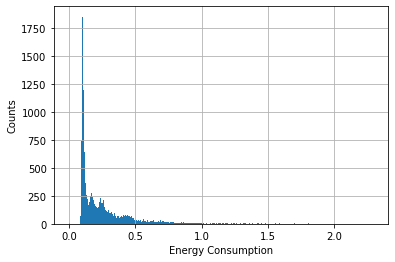

In [887]:
plt.figure()
df['consumption'].hist(bins=300)
plt.ylabel('Counts')
plt.xlabel('Energy Consumption')

In [854]:
df = all_houses.copy()

In [812]:
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size+1:]

apply_transform = transforms.Compose([
    transforms.ToTensor()
])

In [855]:
# for standardized comparison, train and test on same houses
# train_df = df_merged.loc[['MAC000003','MAC000004','MAC000006']]
# test_df = df_merged.loc['MAC000007']
train_df = all_houses_train
test_df = all_houses_test

In [856]:
train_dataset = LondonEnergyDataset(train_df, transform=apply_transform)
test_dataset = LondonEnergyDataset(test_df, transform=apply_transform)

In [857]:
# TODO 
# [X] Create dataframes resampled for hours, days
# [X] Join to weather data from https://www.kaggle.com/jeanmidev/smart-meters-in-london?select=weather_hourly_darksky.csv
# [X] Pytorch dataloaders for train, test for "Virtual Workers" to simulate each house
# [X] Train with MLP 
# [X] Re-run experiments with federated learning, LDP, CDP
# [ ] LSTM
# [ ] Implement hierarchical clustering?
# [ ] Moment accountant?

In [858]:
def seed_everything(seed=1234):
    torch.manual_seed(seed)
    np.random.seed(seed)

In [859]:
class MLP(nn.Module):
    def __init__(self, dim_in, dim_hidden, dim_out):
        super(MLP, self).__init__()
        self.layer_input = nn.Linear(dim_in, dim_hidden)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout()
        self.layer_hidden = nn.Linear(dim_hidden, dim_out)

    def forward(self, x):
        x = self.layer_input(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.layer_hidden(x)
        return x.view(-1,1)

In [860]:
class MLP2(nn.Module):
    def __init__(self, dim_in, dim_hidden1, dim_hidden2, dim_out):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(dim_in, dim_hidden1)
        self.fc2 = nn.Linear(dim_hidden1, dim_hidden2)
        self.dropout1 = nn.Dropout()
        self.dropout2 = nn.Dropout()
        self.output = nn.Linear(dim_hidden2, dim_out)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.output(x)
        return x.view(-1,1)

In [861]:
def test_inference(model, test_dataset):
    """ Returns the test accuracy and loss.
    """

    model.eval()
    loss = []
    r2 = []
    testloader = DataLoader(test_dataset, batch_size=128,
                            shuffle=False)
    
    for batch_idx, (features, labels) in enumerate(testloader):
        # Inference
        outputs = model(features)
        batch_loss = mean_squared_error(labels.detach().numpy(), 
                                        outputs.detach().numpy())
        loss.append(batch_loss)
        r_sq = r2_score(labels.detach().numpy(), outputs.detach().numpy())
        r2.append(r_sq)
    return np.mean(loss), np.mean(r2)

In [882]:
train_df.shape[1]-1

11

In [862]:
all_epoch_loss = []
all_testing_acc = []
all_testing_loss = []
for run in [0,1]: # average over three random seeds
    epoch_loss = []
    testing_acc = []
    testing_loss = []
    seed_everything(run)
    model = MLP2(train_df.shape[1]-1, 64, 64, 1)
    model.train()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()
    trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    for epoch in tqdm(range(500)):
        batch_loss = []
        for batch_idx, (features, labels) in enumerate(trainloader):
            optimizer.zero_grad()
            outputs = model(features)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            if batch_idx % 50 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(features), len(trainloader.dataset),
                    100. * batch_idx / len(trainloader), loss.item()))
            batch_loss.append(loss.item())

        loss_avg = sum(batch_loss)/len(batch_loss)
        print('\nTrain loss:', loss_avg)
        epoch_loss.append(loss_avg)

        test_loss, test_acc = test_inference(model, test_dataset)
        print('Test on', len(test_dataset), 'samples')
        print("R^2: {:.2f}".format(test_acc))
        print("Test Loss: {:.2f}%".format(100 * test_loss))
        testing_loss.append(test_loss)
        testing_acc.append(test_acc)
    all_epoch_loss.append(epoch_loss)
    all_testing_acc.append(testing_acc)
    all_testing_loss.append(testing_loss)

  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 1 [0/19577 (0%)]	Loss: 1.970436
Train Epoch: 1 [3200/19577 (16%)]	Loss: 0.313259
Train Epoch: 1 [6400/19577 (33%)]	Loss: 0.160398
Train Epoch: 1 [9600/19577 (49%)]	Loss: 0.209066
Train Epoch: 1 [12800/19577 (65%)]	Loss: 0.119667
Train Epoch: 1 [16000/19577 (82%)]	Loss: 0.155964
Train Epoch: 1 [19200/19577 (98%)]	Loss: 0.078465

Train loss: 0.2257974284268867


  0%|          | 1/500 [00:08<1:09:12,  8.32s/it]

Test on 1143 samples
R^2: -64.36
Test Loss: 11.15%
Train Epoch: 2 [0/19577 (0%)]	Loss: 0.032116
Train Epoch: 2 [3200/19577 (16%)]	Loss: 0.035546
Train Epoch: 2 [6400/19577 (33%)]	Loss: 0.065488
Train Epoch: 2 [9600/19577 (49%)]	Loss: 0.034710
Train Epoch: 2 [12800/19577 (65%)]	Loss: 0.030920
Train Epoch: 2 [16000/19577 (82%)]	Loss: 0.023051
Train Epoch: 2 [19200/19577 (98%)]	Loss: 0.050540

Train loss: 0.04835989145756839


  0%|          | 2/500 [00:15<1:07:17,  8.11s/it]

Test on 1143 samples
R^2: -122.93
Test Loss: 9.75%
Train Epoch: 3 [0/19577 (0%)]	Loss: 0.045032
Train Epoch: 3 [3200/19577 (16%)]	Loss: 0.035165
Train Epoch: 3 [6400/19577 (33%)]	Loss: 0.028982
Train Epoch: 3 [9600/19577 (49%)]	Loss: 0.042970
Train Epoch: 3 [12800/19577 (65%)]	Loss: 0.050935
Train Epoch: 3 [16000/19577 (82%)]	Loss: 0.035647
Train Epoch: 3 [19200/19577 (98%)]	Loss: 0.028144

Train loss: 0.045754220196672905


  1%|          | 3/500 [00:23<1:06:17,  8.00s/it]

Test on 1143 samples
R^2: -118.23
Test Loss: 9.28%
Train Epoch: 4 [0/19577 (0%)]	Loss: 0.016359
Train Epoch: 4 [3200/19577 (16%)]	Loss: 0.070863
Train Epoch: 4 [6400/19577 (33%)]	Loss: 0.027231
Train Epoch: 4 [9600/19577 (49%)]	Loss: 0.057396
Train Epoch: 4 [12800/19577 (65%)]	Loss: 0.054974
Train Epoch: 4 [16000/19577 (82%)]	Loss: 0.024316
Train Epoch: 4 [19200/19577 (98%)]	Loss: 0.053826

Train loss: 0.043810617324768326


  1%|          | 4/500 [00:31<1:05:52,  7.97s/it]

Test on 1143 samples
R^2: -121.23
Test Loss: 8.84%
Train Epoch: 5 [0/19577 (0%)]	Loss: 0.034863
Train Epoch: 5 [3200/19577 (16%)]	Loss: 0.027405
Train Epoch: 5 [6400/19577 (33%)]	Loss: 0.031687
Train Epoch: 5 [9600/19577 (49%)]	Loss: 0.041799
Train Epoch: 5 [12800/19577 (65%)]	Loss: 0.047992
Train Epoch: 5 [16000/19577 (82%)]	Loss: 0.038738
Train Epoch: 5 [19200/19577 (98%)]	Loss: 0.059635

Train loss: 0.04234680719064926


  1%|          | 5/500 [00:39<1:05:03,  7.89s/it]

Test on 1143 samples
R^2: -127.56
Test Loss: 8.44%
Train Epoch: 6 [0/19577 (0%)]	Loss: 0.021235
Train Epoch: 6 [3200/19577 (16%)]	Loss: 0.032873
Train Epoch: 6 [6400/19577 (33%)]	Loss: 0.036799
Train Epoch: 6 [9600/19577 (49%)]	Loss: 0.040739
Train Epoch: 6 [12800/19577 (65%)]	Loss: 0.031281
Train Epoch: 6 [16000/19577 (82%)]	Loss: 0.028995
Train Epoch: 6 [19200/19577 (98%)]	Loss: 0.020334

Train loss: 0.0411301917895626


  1%|          | 6/500 [00:46<1:03:41,  7.74s/it]

Test on 1143 samples
R^2: -104.80
Test Loss: 8.37%
Train Epoch: 7 [0/19577 (0%)]	Loss: 0.027537
Train Epoch: 7 [3200/19577 (16%)]	Loss: 0.030201
Train Epoch: 7 [6400/19577 (33%)]	Loss: 0.037987
Train Epoch: 7 [9600/19577 (49%)]	Loss: 0.055861
Train Epoch: 7 [12800/19577 (65%)]	Loss: 0.043712
Train Epoch: 7 [16000/19577 (82%)]	Loss: 0.041824
Train Epoch: 7 [19200/19577 (98%)]	Loss: 0.022872

Train loss: 0.04020306284180264


  1%|▏         | 7/500 [00:54<1:02:57,  7.66s/it]

Test on 1143 samples
R^2: -122.22
Test Loss: 7.96%
Train Epoch: 8 [0/19577 (0%)]	Loss: 0.030053
Train Epoch: 8 [3200/19577 (16%)]	Loss: 0.032140
Train Epoch: 8 [6400/19577 (33%)]	Loss: 0.021011
Train Epoch: 8 [9600/19577 (49%)]	Loss: 0.039734
Train Epoch: 8 [12800/19577 (65%)]	Loss: 0.038969
Train Epoch: 8 [16000/19577 (82%)]	Loss: 0.018606
Train Epoch: 8 [19200/19577 (98%)]	Loss: 0.053251

Train loss: 0.03946343128831169


  2%|▏         | 8/500 [01:08<1:18:08,  9.53s/it]

Test on 1143 samples
R^2: -123.48
Test Loss: 7.74%
Train Epoch: 9 [0/19577 (0%)]	Loss: 0.073591
Train Epoch: 9 [3200/19577 (16%)]	Loss: 0.054311
Train Epoch: 9 [6400/19577 (33%)]	Loss: 0.031314
Train Epoch: 9 [9600/19577 (49%)]	Loss: 0.022707
Train Epoch: 9 [12800/19577 (65%)]	Loss: 0.024644
Train Epoch: 9 [16000/19577 (82%)]	Loss: 0.032663
Train Epoch: 9 [19200/19577 (98%)]	Loss: 0.034940

Train loss: 0.0388234906702065


  2%|▏         | 9/500 [01:18<1:19:18,  9.69s/it]

Test on 1143 samples
R^2: -106.71
Test Loss: 7.72%
Train Epoch: 10 [0/19577 (0%)]	Loss: 0.013893
Train Epoch: 10 [3200/19577 (16%)]	Loss: 0.045544
Train Epoch: 10 [6400/19577 (33%)]	Loss: 0.032660
Train Epoch: 10 [9600/19577 (49%)]	Loss: 0.043213
Train Epoch: 10 [12800/19577 (65%)]	Loss: 0.039521
Train Epoch: 10 [16000/19577 (82%)]	Loss: 0.033635
Train Epoch: 10 [19200/19577 (98%)]	Loss: 0.038503

Train loss: 0.03828894757525691


  2%|▏         | 10/500 [01:26<1:15:17,  9.22s/it]

Test on 1143 samples
R^2: -107.29
Test Loss: 7.56%
Train Epoch: 11 [0/19577 (0%)]	Loss: 0.025545
Train Epoch: 11 [3200/19577 (16%)]	Loss: 0.029764
Train Epoch: 11 [6400/19577 (33%)]	Loss: 0.048013
Train Epoch: 11 [9600/19577 (49%)]	Loss: 0.050108
Train Epoch: 11 [12800/19577 (65%)]	Loss: 0.032060
Train Epoch: 11 [16000/19577 (82%)]	Loss: 0.031399
Train Epoch: 11 [19200/19577 (98%)]	Loss: 0.043112

Train loss: 0.03781194568252544


  2%|▏         | 11/500 [01:35<1:15:35,  9.28s/it]

Test on 1143 samples
R^2: -114.44
Test Loss: 7.34%
Train Epoch: 12 [0/19577 (0%)]	Loss: 0.050652
Train Epoch: 12 [3200/19577 (16%)]	Loss: 0.037500
Train Epoch: 12 [6400/19577 (33%)]	Loss: 0.468238
Train Epoch: 12 [9600/19577 (49%)]	Loss: 0.032541
Train Epoch: 12 [12800/19577 (65%)]	Loss: 0.045546
Train Epoch: 12 [16000/19577 (82%)]	Loss: 0.052005
Train Epoch: 12 [19200/19577 (98%)]	Loss: 0.046895

Train loss: 0.03736736031943092


  2%|▏         | 12/500 [01:48<1:23:51, 10.31s/it]

Test on 1143 samples
R^2: -111.82
Test Loss: 7.23%
Train Epoch: 13 [0/19577 (0%)]	Loss: 0.035233
Train Epoch: 13 [3200/19577 (16%)]	Loss: 0.038375
Train Epoch: 13 [6400/19577 (33%)]	Loss: 0.031937
Train Epoch: 13 [9600/19577 (49%)]	Loss: 0.027264
Train Epoch: 13 [12800/19577 (65%)]	Loss: 0.036329
Train Epoch: 13 [16000/19577 (82%)]	Loss: 0.033594
Train Epoch: 13 [19200/19577 (98%)]	Loss: 0.068273

Train loss: 0.036948629241022796


  3%|▎         | 13/500 [02:00<1:27:11, 10.74s/it]

Test on 1143 samples
R^2: -113.42
Test Loss: 7.09%
Train Epoch: 14 [0/19577 (0%)]	Loss: 0.021634
Train Epoch: 14 [3200/19577 (16%)]	Loss: 0.034963
Train Epoch: 14 [6400/19577 (33%)]	Loss: 0.052433
Train Epoch: 14 [9600/19577 (49%)]	Loss: 0.023188
Train Epoch: 14 [12800/19577 (65%)]	Loss: 0.040543
Train Epoch: 14 [16000/19577 (82%)]	Loss: 0.040018
Train Epoch: 14 [19200/19577 (98%)]	Loss: 0.037045

Train loss: 0.036505516597185456


  3%|▎         | 14/500 [02:09<1:24:24, 10.42s/it]

Test on 1143 samples
R^2: -104.31
Test Loss: 7.06%
Train Epoch: 15 [0/19577 (0%)]	Loss: 0.046281
Train Epoch: 15 [3200/19577 (16%)]	Loss: 0.024703
Train Epoch: 15 [6400/19577 (33%)]	Loss: 0.035144
Train Epoch: 15 [9600/19577 (49%)]	Loss: 0.047722
Train Epoch: 15 [12800/19577 (65%)]	Loss: 0.039276
Train Epoch: 15 [16000/19577 (82%)]	Loss: 0.030081
Train Epoch: 15 [19200/19577 (98%)]	Loss: 0.032813

Train loss: 0.03610086062728288


  3%|▎         | 15/500 [02:19<1:22:37, 10.22s/it]

Test on 1143 samples
R^2: -117.78
Test Loss: 6.81%
Train Epoch: 16 [0/19577 (0%)]	Loss: 0.054143
Train Epoch: 16 [3200/19577 (16%)]	Loss: 0.020057
Train Epoch: 16 [6400/19577 (33%)]	Loss: 0.038318
Train Epoch: 16 [9600/19577 (49%)]	Loss: 0.056771
Train Epoch: 16 [12800/19577 (65%)]	Loss: 0.042316
Train Epoch: 16 [16000/19577 (82%)]	Loss: 0.035220
Train Epoch: 16 [19200/19577 (98%)]	Loss: 0.036271

Train loss: 0.03567872257306685


  3%|▎         | 16/500 [02:27<1:17:11,  9.57s/it]

Test on 1143 samples
R^2: -106.18
Test Loss: 6.81%
Train Epoch: 17 [0/19577 (0%)]	Loss: 0.020283
Train Epoch: 17 [3200/19577 (16%)]	Loss: 0.058035
Train Epoch: 17 [6400/19577 (33%)]	Loss: 0.036283
Train Epoch: 17 [9600/19577 (49%)]	Loss: 0.035468
Train Epoch: 17 [12800/19577 (65%)]	Loss: 0.029921
Train Epoch: 17 [16000/19577 (82%)]	Loss: 0.024612
Train Epoch: 17 [19200/19577 (98%)]	Loss: 0.043313

Train loss: 0.03527644371272984


  3%|▎         | 17/500 [02:35<1:12:29,  9.01s/it]

Test on 1143 samples
R^2: -109.85
Test Loss: 6.66%
Train Epoch: 18 [0/19577 (0%)]	Loss: 0.057414
Train Epoch: 18 [3200/19577 (16%)]	Loss: 0.054557
Train Epoch: 18 [6400/19577 (33%)]	Loss: 0.036259
Train Epoch: 18 [9600/19577 (49%)]	Loss: 0.037845
Train Epoch: 18 [12800/19577 (65%)]	Loss: 0.025565
Train Epoch: 18 [16000/19577 (82%)]	Loss: 0.027058
Train Epoch: 18 [19200/19577 (98%)]	Loss: 0.017161

Train loss: 0.034863275914069486


  4%|▎         | 18/500 [02:42<1:07:29,  8.40s/it]

Test on 1143 samples
R^2: -104.03
Test Loss: 6.61%
Train Epoch: 19 [0/19577 (0%)]	Loss: 0.025063
Train Epoch: 19 [3200/19577 (16%)]	Loss: 0.029696
Train Epoch: 19 [6400/19577 (33%)]	Loss: 0.021051
Train Epoch: 19 [9600/19577 (49%)]	Loss: 0.026795
Train Epoch: 19 [12800/19577 (65%)]	Loss: 0.037608
Train Epoch: 19 [16000/19577 (82%)]	Loss: 0.045040
Train Epoch: 19 [19200/19577 (98%)]	Loss: 0.026502

Train loss: 0.034438325064804626


  4%|▍         | 19/500 [02:50<1:05:55,  8.22s/it]

Test on 1143 samples
R^2: -111.29
Test Loss: 6.43%
Train Epoch: 20 [0/19577 (0%)]	Loss: 0.017727
Train Epoch: 20 [3200/19577 (16%)]	Loss: 0.027321
Train Epoch: 20 [6400/19577 (33%)]	Loss: 0.027930
Train Epoch: 20 [9600/19577 (49%)]	Loss: 0.032815
Train Epoch: 20 [12800/19577 (65%)]	Loss: 0.039076
Train Epoch: 20 [16000/19577 (82%)]	Loss: 0.031013
Train Epoch: 20 [19200/19577 (98%)]	Loss: 0.037081

Train loss: 0.03401347479229075


  4%|▍         | 20/500 [02:59<1:07:56,  8.49s/it]

Test on 1143 samples
R^2: -98.94
Test Loss: 6.44%
Train Epoch: 21 [0/19577 (0%)]	Loss: 0.029946
Train Epoch: 21 [3200/19577 (16%)]	Loss: 0.021319
Train Epoch: 21 [6400/19577 (33%)]	Loss: 0.054087
Train Epoch: 21 [9600/19577 (49%)]	Loss: 0.022496
Train Epoch: 21 [12800/19577 (65%)]	Loss: 0.018559
Train Epoch: 21 [16000/19577 (82%)]	Loss: 0.039739
Train Epoch: 21 [19200/19577 (98%)]	Loss: 0.024321

Train loss: 0.03356729138313847


  4%|▍         | 21/500 [03:07<1:06:27,  8.33s/it]

Test on 1143 samples
R^2: -103.60
Test Loss: 6.28%
Train Epoch: 22 [0/19577 (0%)]	Loss: 0.027148
Train Epoch: 22 [3200/19577 (16%)]	Loss: 0.027921
Train Epoch: 22 [6400/19577 (33%)]	Loss: 0.037867
Train Epoch: 22 [9600/19577 (49%)]	Loss: 0.018850
Train Epoch: 22 [12800/19577 (65%)]	Loss: 0.029063
Train Epoch: 22 [16000/19577 (82%)]	Loss: 0.041009
Train Epoch: 22 [19200/19577 (98%)]	Loss: 0.022945

Train loss: 0.03312088622182023


  4%|▍         | 22/500 [03:15<1:06:41,  8.37s/it]

Test on 1143 samples
R^2: -102.23
Test Loss: 6.18%
Train Epoch: 23 [0/19577 (0%)]	Loss: 0.017480
Train Epoch: 23 [3200/19577 (16%)]	Loss: 0.016458
Train Epoch: 23 [6400/19577 (33%)]	Loss: 0.013431
Train Epoch: 23 [9600/19577 (49%)]	Loss: 0.035399
Train Epoch: 23 [12800/19577 (65%)]	Loss: 0.034270
Train Epoch: 23 [16000/19577 (82%)]	Loss: 0.019919
Train Epoch: 23 [19200/19577 (98%)]	Loss: 0.038251

Train loss: 0.03264399267903535


  5%|▍         | 23/500 [03:27<1:16:00,  9.56s/it]

Test on 1143 samples
R^2: -103.97
Test Loss: 6.05%
Train Epoch: 24 [0/19577 (0%)]	Loss: 0.025663
Train Epoch: 24 [3200/19577 (16%)]	Loss: 0.023727
Train Epoch: 24 [6400/19577 (33%)]	Loss: 0.025016
Train Epoch: 24 [9600/19577 (49%)]	Loss: 0.031210
Train Epoch: 24 [12800/19577 (65%)]	Loss: 0.025581
Train Epoch: 24 [16000/19577 (82%)]	Loss: 0.024868
Train Epoch: 24 [19200/19577 (98%)]	Loss: 0.012362

Train loss: 0.0321547430666054


  5%|▍         | 24/500 [03:40<1:21:54, 10.32s/it]

Test on 1143 samples
R^2: -101.27
Test Loss: 5.96%
Train Epoch: 25 [0/19577 (0%)]	Loss: 0.031150
Train Epoch: 25 [3200/19577 (16%)]	Loss: 0.024731
Train Epoch: 25 [6400/19577 (33%)]	Loss: 0.032721
Train Epoch: 25 [9600/19577 (49%)]	Loss: 0.036235
Train Epoch: 25 [12800/19577 (65%)]	Loss: 0.050837
Train Epoch: 25 [16000/19577 (82%)]	Loss: 0.038656
Train Epoch: 25 [19200/19577 (98%)]	Loss: 0.035622

Train loss: 0.031644725749037816


  5%|▌         | 25/500 [03:48<1:17:30,  9.79s/it]

Test on 1143 samples
R^2: -101.36
Test Loss: 5.84%
Train Epoch: 26 [0/19577 (0%)]	Loss: 0.023744
Train Epoch: 26 [3200/19577 (16%)]	Loss: 0.024111
Train Epoch: 26 [6400/19577 (33%)]	Loss: 0.046417
Train Epoch: 26 [9600/19577 (49%)]	Loss: 0.042078
Train Epoch: 26 [12800/19577 (65%)]	Loss: 0.023121
Train Epoch: 26 [16000/19577 (82%)]	Loss: 0.022979
Train Epoch: 26 [19200/19577 (98%)]	Loss: 0.041953

Train loss: 0.031105300512018742


  5%|▌         | 26/500 [03:55<1:10:39,  8.94s/it]

Test on 1143 samples
R^2: -108.43
Test Loss: 5.66%
Train Epoch: 27 [0/19577 (0%)]	Loss: 0.045226
Train Epoch: 27 [3200/19577 (16%)]	Loss: 0.020038
Train Epoch: 27 [6400/19577 (33%)]	Loss: 0.021423
Train Epoch: 27 [9600/19577 (49%)]	Loss: 0.028890
Train Epoch: 27 [12800/19577 (65%)]	Loss: 0.051637
Train Epoch: 27 [16000/19577 (82%)]	Loss: 0.027431
Train Epoch: 27 [19200/19577 (98%)]	Loss: 0.036503

Train loss: 0.03056090213723627


  5%|▌         | 27/500 [04:04<1:09:57,  8.87s/it]

Test on 1143 samples
R^2: -94.14
Test Loss: 5.65%
Train Epoch: 28 [0/19577 (0%)]	Loss: 0.031147
Train Epoch: 28 [3200/19577 (16%)]	Loss: 0.044328
Train Epoch: 28 [6400/19577 (33%)]	Loss: 0.019887
Train Epoch: 28 [9600/19577 (49%)]	Loss: 0.019862
Train Epoch: 28 [12800/19577 (65%)]	Loss: 0.030481
Train Epoch: 28 [16000/19577 (82%)]	Loss: 0.032401
Train Epoch: 28 [19200/19577 (98%)]	Loss: 0.034617

Train loss: 0.029974722723458327


  6%|▌         | 28/500 [04:11<1:05:36,  8.34s/it]

Test on 1143 samples
R^2: -87.53
Test Loss: 5.58%
Train Epoch: 29 [0/19577 (0%)]	Loss: 0.026917
Train Epoch: 29 [3200/19577 (16%)]	Loss: 0.026313
Train Epoch: 29 [6400/19577 (33%)]	Loss: 0.023153
Train Epoch: 29 [9600/19577 (49%)]	Loss: 0.036235
Train Epoch: 29 [12800/19577 (65%)]	Loss: 0.013393
Train Epoch: 29 [16000/19577 (82%)]	Loss: 0.028887
Train Epoch: 29 [19200/19577 (98%)]	Loss: 0.027868

Train loss: 0.02938038650047935


  6%|▌         | 29/500 [04:18<1:03:11,  8.05s/it]

Test on 1143 samples
R^2: -86.83
Test Loss: 5.45%
Train Epoch: 30 [0/19577 (0%)]	Loss: 0.023378
Train Epoch: 30 [3200/19577 (16%)]	Loss: 0.037483
Train Epoch: 30 [6400/19577 (33%)]	Loss: 0.020900
Train Epoch: 30 [9600/19577 (49%)]	Loss: 0.018551
Train Epoch: 30 [12800/19577 (65%)]	Loss: 0.019126
Train Epoch: 30 [16000/19577 (82%)]	Loss: 0.027165
Train Epoch: 30 [19200/19577 (98%)]	Loss: 0.014871

Train loss: 0.028764413356220996


  6%|▌         | 30/500 [04:27<1:05:54,  8.41s/it]

Test on 1143 samples
R^2: -78.16
Test Loss: 5.40%
Train Epoch: 31 [0/19577 (0%)]	Loss: 0.014048
Train Epoch: 31 [3200/19577 (16%)]	Loss: 0.037761
Train Epoch: 31 [6400/19577 (33%)]	Loss: 0.020211
Train Epoch: 31 [9600/19577 (49%)]	Loss: 0.019336
Train Epoch: 31 [12800/19577 (65%)]	Loss: 0.023036
Train Epoch: 31 [16000/19577 (82%)]	Loss: 0.019390
Train Epoch: 31 [19200/19577 (98%)]	Loss: 0.018027

Train loss: 0.028150269667331883


  6%|▌         | 31/500 [04:36<1:06:14,  8.47s/it]

Test on 1143 samples
R^2: -69.90
Test Loss: 5.35%
Train Epoch: 32 [0/19577 (0%)]	Loss: 0.024531
Train Epoch: 32 [3200/19577 (16%)]	Loss: 0.018645
Train Epoch: 32 [6400/19577 (33%)]	Loss: 0.027836
Train Epoch: 32 [9600/19577 (49%)]	Loss: 0.016587
Train Epoch: 32 [12800/19577 (65%)]	Loss: 0.020466
Train Epoch: 32 [16000/19577 (82%)]	Loss: 0.021832
Train Epoch: 32 [19200/19577 (98%)]	Loss: 0.036885

Train loss: 0.0275098272367971


  6%|▋         | 32/500 [04:44<1:05:15,  8.37s/it]

Test on 1143 samples
R^2: -80.43
Test Loss: 5.08%
Train Epoch: 33 [0/19577 (0%)]	Loss: 0.030391
Train Epoch: 33 [3200/19577 (16%)]	Loss: 0.024830
Train Epoch: 33 [6400/19577 (33%)]	Loss: 0.022151
Train Epoch: 33 [9600/19577 (49%)]	Loss: 0.029978
Train Epoch: 33 [12800/19577 (65%)]	Loss: 0.028893
Train Epoch: 33 [16000/19577 (82%)]	Loss: 0.033019
Train Epoch: 33 [19200/19577 (98%)]	Loss: 0.015692

Train loss: 0.026829769320518167


  7%|▋         | 33/500 [04:54<1:08:02,  8.74s/it]

Test on 1143 samples
R^2: -66.27
Test Loss: 5.08%
Train Epoch: 34 [0/19577 (0%)]	Loss: 0.027610
Train Epoch: 34 [3200/19577 (16%)]	Loss: 0.027158
Train Epoch: 34 [6400/19577 (33%)]	Loss: 0.024564
Train Epoch: 34 [9600/19577 (49%)]	Loss: 0.024006
Train Epoch: 34 [12800/19577 (65%)]	Loss: 0.029347
Train Epoch: 34 [16000/19577 (82%)]	Loss: 0.029698
Train Epoch: 34 [19200/19577 (98%)]	Loss: 0.023297

Train loss: 0.02613955581244203


  7%|▋         | 34/500 [05:04<1:10:50,  9.12s/it]

Test on 1143 samples
R^2: -78.27
Test Loss: 4.80%
Train Epoch: 35 [0/19577 (0%)]	Loss: 0.017329
Train Epoch: 35 [3200/19577 (16%)]	Loss: 0.014902
Train Epoch: 35 [6400/19577 (33%)]	Loss: 0.021825
Train Epoch: 35 [9600/19577 (49%)]	Loss: 0.020073
Train Epoch: 35 [12800/19577 (65%)]	Loss: 0.026631
Train Epoch: 35 [16000/19577 (82%)]	Loss: 0.025435
Train Epoch: 35 [19200/19577 (98%)]	Loss: 0.018967

Train loss: 0.025436703827889526


  7%|▋         | 35/500 [05:12<1:09:34,  8.98s/it]

Test on 1143 samples
R^2: -67.98
Test Loss: 4.74%
Train Epoch: 36 [0/19577 (0%)]	Loss: 0.022503
Train Epoch: 36 [3200/19577 (16%)]	Loss: 0.028687
Train Epoch: 36 [6400/19577 (33%)]	Loss: 0.025583
Train Epoch: 36 [9600/19577 (49%)]	Loss: 0.020553
Train Epoch: 36 [12800/19577 (65%)]	Loss: 0.029414
Train Epoch: 36 [16000/19577 (82%)]	Loss: 0.026089
Train Epoch: 36 [19200/19577 (98%)]	Loss: 0.012570

Train loss: 0.024704848711372785


  7%|▋         | 36/500 [05:20<1:05:25,  8.46s/it]

Test on 1143 samples
R^2: -65.57
Test Loss: 4.61%
Train Epoch: 37 [0/19577 (0%)]	Loss: 0.029197
Train Epoch: 37 [3200/19577 (16%)]	Loss: 0.028916
Train Epoch: 37 [6400/19577 (33%)]	Loss: 0.022087
Train Epoch: 37 [9600/19577 (49%)]	Loss: 0.012145
Train Epoch: 37 [12800/19577 (65%)]	Loss: 0.024007
Train Epoch: 37 [16000/19577 (82%)]	Loss: 0.018738
Train Epoch: 37 [19200/19577 (98%)]	Loss: 0.014466

Train loss: 0.023965752820539123


  7%|▋         | 37/500 [05:27<1:02:46,  8.14s/it]

Test on 1143 samples
R^2: -61.83
Test Loss: 4.49%
Train Epoch: 38 [0/19577 (0%)]	Loss: 0.014540
Train Epoch: 38 [3200/19577 (16%)]	Loss: 0.027847
Train Epoch: 38 [6400/19577 (33%)]	Loss: 0.013351
Train Epoch: 38 [9600/19577 (49%)]	Loss: 0.035260
Train Epoch: 38 [12800/19577 (65%)]	Loss: 0.017761
Train Epoch: 38 [16000/19577 (82%)]	Loss: 0.016586
Train Epoch: 38 [19200/19577 (98%)]	Loss: 0.018840

Train loss: 0.023216124672710507


  8%|▊         | 38/500 [05:35<1:00:57,  7.92s/it]

Test on 1143 samples
R^2: -58.92
Test Loss: 4.36%
Train Epoch: 39 [0/19577 (0%)]	Loss: 0.037154
Train Epoch: 39 [3200/19577 (16%)]	Loss: 0.024251
Train Epoch: 39 [6400/19577 (33%)]	Loss: 0.031701
Train Epoch: 39 [9600/19577 (49%)]	Loss: 0.022760
Train Epoch: 39 [12800/19577 (65%)]	Loss: 0.019457
Train Epoch: 39 [16000/19577 (82%)]	Loss: 0.019227
Train Epoch: 39 [19200/19577 (98%)]	Loss: 0.031686

Train loss: 0.022459886642477285


  8%|▊         | 39/500 [05:41<58:19,  7.59s/it]  

Test on 1143 samples
R^2: -66.14
Test Loss: 4.14%
Train Epoch: 40 [0/19577 (0%)]	Loss: 0.014848
Train Epoch: 40 [3200/19577 (16%)]	Loss: 0.012942
Train Epoch: 40 [6400/19577 (33%)]	Loss: 0.014911
Train Epoch: 40 [9600/19577 (49%)]	Loss: 0.015930
Train Epoch: 40 [12800/19577 (65%)]	Loss: 0.024703
Train Epoch: 40 [16000/19577 (82%)]	Loss: 0.025754
Train Epoch: 40 [19200/19577 (98%)]	Loss: 0.022950

Train loss: 0.02170646304928156


  8%|▊         | 40/500 [05:48<56:43,  7.40s/it]

Test on 1143 samples
R^2: -47.96
Test Loss: 4.16%
Train Epoch: 41 [0/19577 (0%)]	Loss: 0.013597
Train Epoch: 41 [3200/19577 (16%)]	Loss: 0.013346
Train Epoch: 41 [6400/19577 (33%)]	Loss: 0.022368
Train Epoch: 41 [9600/19577 (49%)]	Loss: 0.019120
Train Epoch: 41 [12800/19577 (65%)]	Loss: 0.023757
Train Epoch: 41 [16000/19577 (82%)]	Loss: 0.014793
Train Epoch: 41 [19200/19577 (98%)]	Loss: 0.022694

Train loss: 0.020984323981394565


  8%|▊         | 41/500 [05:56<57:18,  7.49s/it]

Test on 1143 samples
R^2: -55.01
Test Loss: 3.93%
Train Epoch: 42 [0/19577 (0%)]	Loss: 0.033781
Train Epoch: 42 [3200/19577 (16%)]	Loss: 0.012413
Train Epoch: 42 [6400/19577 (33%)]	Loss: 0.030445
Train Epoch: 42 [9600/19577 (49%)]	Loss: 0.029123
Train Epoch: 42 [12800/19577 (65%)]	Loss: 0.022119
Train Epoch: 42 [16000/19577 (82%)]	Loss: 0.010058
Train Epoch: 42 [19200/19577 (98%)]	Loss: 0.014683

Train loss: 0.020241115160067293


  8%|▊         | 42/500 [06:05<1:00:33,  7.93s/it]

Test on 1143 samples
R^2: -45.26
Test Loss: 3.87%
Train Epoch: 43 [0/19577 (0%)]	Loss: 0.012323
Train Epoch: 43 [3200/19577 (16%)]	Loss: 0.014044
Train Epoch: 43 [6400/19577 (33%)]	Loss: 0.021468
Train Epoch: 43 [9600/19577 (49%)]	Loss: 0.010792
Train Epoch: 43 [12800/19577 (65%)]	Loss: 0.014004
Train Epoch: 43 [16000/19577 (82%)]	Loss: 0.011637
Train Epoch: 43 [19200/19577 (98%)]	Loss: 0.025301

Train loss: 0.019521291822718542


  9%|▊         | 43/500 [06:14<1:03:21,  8.32s/it]

Test on 1143 samples
R^2: -40.01
Test Loss: 3.78%
Train Epoch: 44 [0/19577 (0%)]	Loss: 0.018255
Train Epoch: 44 [3200/19577 (16%)]	Loss: 0.014049
Train Epoch: 44 [6400/19577 (33%)]	Loss: 0.030542
Train Epoch: 44 [9600/19577 (49%)]	Loss: 0.011676
Train Epoch: 44 [12800/19577 (65%)]	Loss: 0.011967
Train Epoch: 44 [16000/19577 (82%)]	Loss: 0.010519
Train Epoch: 44 [19200/19577 (98%)]	Loss: 0.011361

Train loss: 0.01882379407404003


  9%|▉         | 44/500 [06:23<1:04:29,  8.49s/it]

Test on 1143 samples
R^2: -40.82
Test Loss: 3.62%
Train Epoch: 45 [0/19577 (0%)]	Loss: 0.007246
Train Epoch: 45 [3200/19577 (16%)]	Loss: 0.012689
Train Epoch: 45 [6400/19577 (33%)]	Loss: 0.012628
Train Epoch: 45 [9600/19577 (49%)]	Loss: 0.011567
Train Epoch: 45 [12800/19577 (65%)]	Loss: 0.017794
Train Epoch: 45 [16000/19577 (82%)]	Loss: 0.012687
Train Epoch: 45 [19200/19577 (98%)]	Loss: 0.016381

Train loss: 0.018178356093129303


  9%|▉         | 45/500 [06:31<1:03:04,  8.32s/it]

Test on 1143 samples
R^2: -47.36
Test Loss: 3.43%
Train Epoch: 46 [0/19577 (0%)]	Loss: 0.013870
Train Epoch: 46 [3200/19577 (16%)]	Loss: 0.033807
Train Epoch: 46 [6400/19577 (33%)]	Loss: 0.008124
Train Epoch: 46 [9600/19577 (49%)]	Loss: 0.015633
Train Epoch: 46 [12800/19577 (65%)]	Loss: 0.023735
Train Epoch: 46 [16000/19577 (82%)]	Loss: 0.021023
Train Epoch: 46 [19200/19577 (98%)]	Loss: 0.011817

Train loss: 0.017518014971203373


  9%|▉         | 46/500 [06:38<59:53,  7.92s/it]  

Test on 1143 samples
R^2: -34.90
Test Loss: 3.41%
Train Epoch: 47 [0/19577 (0%)]	Loss: 0.019447
Train Epoch: 47 [3200/19577 (16%)]	Loss: 0.012957
Train Epoch: 47 [6400/19577 (33%)]	Loss: 0.015531
Train Epoch: 47 [9600/19577 (49%)]	Loss: 0.009634
Train Epoch: 47 [12800/19577 (65%)]	Loss: 0.019077
Train Epoch: 47 [16000/19577 (82%)]	Loss: 0.015429
Train Epoch: 47 [19200/19577 (98%)]	Loss: 0.027081

Train loss: 0.016883793813511242


  9%|▉         | 47/500 [06:45<57:57,  7.68s/it]

Test on 1143 samples
R^2: -35.18
Test Loss: 3.27%
Train Epoch: 48 [0/19577 (0%)]	Loss: 0.009476
Train Epoch: 48 [3200/19577 (16%)]	Loss: 0.011765
Train Epoch: 48 [6400/19577 (33%)]	Loss: 0.011943
Train Epoch: 48 [9600/19577 (49%)]	Loss: 0.012364
Train Epoch: 48 [12800/19577 (65%)]	Loss: 0.008399
Train Epoch: 48 [16000/19577 (82%)]	Loss: 0.022776
Train Epoch: 48 [19200/19577 (98%)]	Loss: 0.010864

Train loss: 0.016283621138046964


 10%|▉         | 48/500 [06:52<56:07,  7.45s/it]

Test on 1143 samples
R^2: -39.68
Test Loss: 3.13%
Train Epoch: 49 [0/19577 (0%)]	Loss: 0.009593
Train Epoch: 49 [3200/19577 (16%)]	Loss: 0.012170
Train Epoch: 49 [6400/19577 (33%)]	Loss: 0.017570
Train Epoch: 49 [9600/19577 (49%)]	Loss: 0.019960
Train Epoch: 49 [12800/19577 (65%)]	Loss: 0.012554
Train Epoch: 49 [16000/19577 (82%)]	Loss: 0.011713
Train Epoch: 49 [19200/19577 (98%)]	Loss: 0.024776

Train loss: 0.01574586776657383


 10%|▉         | 49/500 [06:59<55:59,  7.45s/it]

Test on 1143 samples
R^2: -30.95
Test Loss: 3.08%
Train Epoch: 50 [0/19577 (0%)]	Loss: 0.016634
Train Epoch: 50 [3200/19577 (16%)]	Loss: 0.009097
Train Epoch: 50 [6400/19577 (33%)]	Loss: 0.009288
Train Epoch: 50 [9600/19577 (49%)]	Loss: 0.009747
Train Epoch: 50 [12800/19577 (65%)]	Loss: 0.016079
Train Epoch: 50 [16000/19577 (82%)]	Loss: 0.012847
Train Epoch: 50 [19200/19577 (98%)]	Loss: 0.022548

Train loss: 0.015206307737351535


 10%|█         | 50/500 [07:07<56:22,  7.52s/it]

Test on 1143 samples
R^2: -22.38
Test Loss: 3.07%
Train Epoch: 51 [0/19577 (0%)]	Loss: 0.014990
Train Epoch: 51 [3200/19577 (16%)]	Loss: 0.020963
Train Epoch: 51 [6400/19577 (33%)]	Loss: 0.005136
Train Epoch: 51 [9600/19577 (49%)]	Loss: 0.018378
Train Epoch: 51 [12800/19577 (65%)]	Loss: 0.011004
Train Epoch: 51 [16000/19577 (82%)]	Loss: 0.013175
Train Epoch: 51 [19200/19577 (98%)]	Loss: 0.018177

Train loss: 0.014692743544716363


 10%|█         | 51/500 [07:14<55:35,  7.43s/it]

Test on 1143 samples
R^2: -26.15
Test Loss: 2.93%
Train Epoch: 52 [0/19577 (0%)]	Loss: 0.012568
Train Epoch: 52 [3200/19577 (16%)]	Loss: 0.011290
Train Epoch: 52 [6400/19577 (33%)]	Loss: 0.013658
Train Epoch: 52 [9600/19577 (49%)]	Loss: 0.014709
Train Epoch: 52 [12800/19577 (65%)]	Loss: 0.012159
Train Epoch: 52 [16000/19577 (82%)]	Loss: 0.022955
Train Epoch: 52 [19200/19577 (98%)]	Loss: 0.013479

Train loss: 0.014232737340909593


 10%|█         | 52/500 [07:22<55:56,  7.49s/it]

Test on 1143 samples
R^2: -20.92
Test Loss: 2.89%
Train Epoch: 53 [0/19577 (0%)]	Loss: 0.020503
Train Epoch: 53 [3200/19577 (16%)]	Loss: 0.012955
Train Epoch: 53 [6400/19577 (33%)]	Loss: 0.020086
Train Epoch: 53 [9600/19577 (49%)]	Loss: 0.018195
Train Epoch: 53 [12800/19577 (65%)]	Loss: 0.005800
Train Epoch: 53 [16000/19577 (82%)]	Loss: 0.008666
Train Epoch: 53 [19200/19577 (98%)]	Loss: 0.018695

Train loss: 0.013811403739393926


 11%|█         | 53/500 [07:29<54:57,  7.38s/it]

Test on 1143 samples
R^2: -16.49
Test Loss: 2.85%
Train Epoch: 54 [0/19577 (0%)]	Loss: 0.013376
Train Epoch: 54 [3200/19577 (16%)]	Loss: 0.025368
Train Epoch: 54 [6400/19577 (33%)]	Loss: 0.016557
Train Epoch: 54 [9600/19577 (49%)]	Loss: 0.015950
Train Epoch: 54 [12800/19577 (65%)]	Loss: 0.013364
Train Epoch: 54 [16000/19577 (82%)]	Loss: 0.010639
Train Epoch: 54 [19200/19577 (98%)]	Loss: 0.011277

Train loss: 0.01340231566851216


 11%|█         | 54/500 [07:36<54:13,  7.29s/it]

Test on 1143 samples
R^2: -16.66
Test Loss: 2.76%
Train Epoch: 55 [0/19577 (0%)]	Loss: 0.013227
Train Epoch: 55 [3200/19577 (16%)]	Loss: 0.012944
Train Epoch: 55 [6400/19577 (33%)]	Loss: 0.010951
Train Epoch: 55 [9600/19577 (49%)]	Loss: 0.010618
Train Epoch: 55 [12800/19577 (65%)]	Loss: 0.016741
Train Epoch: 55 [16000/19577 (82%)]	Loss: 0.008997
Train Epoch: 55 [19200/19577 (98%)]	Loss: 0.007156

Train loss: 0.013043588517367645


 11%|█         | 55/500 [07:43<53:35,  7.23s/it]

Test on 1143 samples
R^2: -15.07
Test Loss: 2.71%
Train Epoch: 56 [0/19577 (0%)]	Loss: 0.011268
Train Epoch: 56 [3200/19577 (16%)]	Loss: 0.004751
Train Epoch: 56 [6400/19577 (33%)]	Loss: 0.009870
Train Epoch: 56 [9600/19577 (49%)]	Loss: 0.005346
Train Epoch: 56 [12800/19577 (65%)]	Loss: 0.009355
Train Epoch: 56 [16000/19577 (82%)]	Loss: 0.009179
Train Epoch: 56 [19200/19577 (98%)]	Loss: 0.009959

Train loss: 0.012697936796577148


 11%|█         | 56/500 [07:50<52:43,  7.12s/it]

Test on 1143 samples
R^2: -17.05
Test Loss: 2.62%
Train Epoch: 57 [0/19577 (0%)]	Loss: 0.010865
Train Epoch: 57 [3200/19577 (16%)]	Loss: 0.006375
Train Epoch: 57 [6400/19577 (33%)]	Loss: 0.010028
Train Epoch: 57 [9600/19577 (49%)]	Loss: 0.007824
Train Epoch: 57 [12800/19577 (65%)]	Loss: 0.008283
Train Epoch: 57 [16000/19577 (82%)]	Loss: 0.008329
Train Epoch: 57 [19200/19577 (98%)]	Loss: 0.012027

Train loss: 0.012390518859272299


 11%|█▏        | 57/500 [07:58<54:46,  7.42s/it]

Test on 1143 samples
R^2: -24.22
Test Loss: 2.55%
Train Epoch: 58 [0/19577 (0%)]	Loss: 0.014195
Train Epoch: 58 [3200/19577 (16%)]	Loss: 0.010444
Train Epoch: 58 [6400/19577 (33%)]	Loss: 0.023837
Train Epoch: 58 [9600/19577 (49%)]	Loss: 0.007662
Train Epoch: 58 [12800/19577 (65%)]	Loss: 0.006503
Train Epoch: 58 [16000/19577 (82%)]	Loss: 0.007328
Train Epoch: 58 [19200/19577 (98%)]	Loss: 0.005971

Train loss: 0.01210720094645189


 12%|█▏        | 58/500 [08:06<55:36,  7.55s/it]

Test on 1143 samples
R^2: -11.22
Test Loss: 2.57%
Train Epoch: 59 [0/19577 (0%)]	Loss: 0.008851
Train Epoch: 59 [3200/19577 (16%)]	Loss: 0.013114
Train Epoch: 59 [6400/19577 (33%)]	Loss: 0.005840
Train Epoch: 59 [9600/19577 (49%)]	Loss: 0.009338
Train Epoch: 59 [12800/19577 (65%)]	Loss: 0.008516
Train Epoch: 59 [16000/19577 (82%)]	Loss: 0.009757
Train Epoch: 59 [19200/19577 (98%)]	Loss: 0.009305

Train loss: 0.011831383159980665


 12%|█▏        | 59/500 [08:14<56:21,  7.67s/it]

Test on 1143 samples
R^2: -9.47
Test Loss: 2.54%
Train Epoch: 60 [0/19577 (0%)]	Loss: 0.008377
Train Epoch: 60 [3200/19577 (16%)]	Loss: 0.010471
Train Epoch: 60 [6400/19577 (33%)]	Loss: 0.005182
Train Epoch: 60 [9600/19577 (49%)]	Loss: 0.005099
Train Epoch: 60 [12800/19577 (65%)]	Loss: 0.012367
Train Epoch: 60 [16000/19577 (82%)]	Loss: 0.008239
Train Epoch: 60 [19200/19577 (98%)]	Loss: 0.009186

Train loss: 0.011591118631056614


 12%|█▏        | 60/500 [08:21<55:00,  7.50s/it]

Test on 1143 samples
R^2: -10.78
Test Loss: 2.48%
Train Epoch: 61 [0/19577 (0%)]	Loss: 0.012606
Train Epoch: 61 [3200/19577 (16%)]	Loss: 0.006595
Train Epoch: 61 [6400/19577 (33%)]	Loss: 0.015256
Train Epoch: 61 [9600/19577 (49%)]	Loss: 0.015468
Train Epoch: 61 [12800/19577 (65%)]	Loss: 0.007513
Train Epoch: 61 [16000/19577 (82%)]	Loss: 0.008291
Train Epoch: 61 [19200/19577 (98%)]	Loss: 0.013566

Train loss: 0.01136699457823305


 12%|█▏        | 61/500 [08:31<1:00:09,  8.22s/it]

Test on 1143 samples
R^2: -6.43
Test Loss: 2.50%
Train Epoch: 62 [0/19577 (0%)]	Loss: 0.005684
Train Epoch: 62 [3200/19577 (16%)]	Loss: 0.006981
Train Epoch: 62 [6400/19577 (33%)]	Loss: 0.007171
Train Epoch: 62 [9600/19577 (49%)]	Loss: 0.016589
Train Epoch: 62 [12800/19577 (65%)]	Loss: 0.010867
Train Epoch: 62 [16000/19577 (82%)]	Loss: 0.012041
Train Epoch: 62 [19200/19577 (98%)]	Loss: 0.016186

Train loss: 0.0111738965432677


 12%|█▏        | 62/500 [08:40<1:01:33,  8.43s/it]

Test on 1143 samples
R^2: -8.94
Test Loss: 2.42%
Train Epoch: 63 [0/19577 (0%)]	Loss: 0.010680
Train Epoch: 63 [3200/19577 (16%)]	Loss: 0.004691
Train Epoch: 63 [6400/19577 (33%)]	Loss: 0.012896
Train Epoch: 63 [9600/19577 (49%)]	Loss: 0.019622
Train Epoch: 63 [12800/19577 (65%)]	Loss: 0.007676
Train Epoch: 63 [16000/19577 (82%)]	Loss: 0.006800
Train Epoch: 63 [19200/19577 (98%)]	Loss: 0.006694

Train loss: 0.011002729133264545


 13%|█▎        | 63/500 [08:48<1:00:41,  8.33s/it]

Test on 1143 samples
R^2: -5.31
Test Loss: 2.44%
Train Epoch: 64 [0/19577 (0%)]	Loss: 0.008713
Train Epoch: 64 [3200/19577 (16%)]	Loss: 0.008841
Train Epoch: 64 [6400/19577 (33%)]	Loss: 0.047978
Train Epoch: 64 [9600/19577 (49%)]	Loss: 0.005404
Train Epoch: 64 [12800/19577 (65%)]	Loss: 0.008327
Train Epoch: 64 [16000/19577 (82%)]	Loss: 0.017795
Train Epoch: 64 [19200/19577 (98%)]	Loss: 0.004146

Train loss: 0.010843394640711398


 13%|█▎        | 64/500 [08:55<58:20,  8.03s/it]  

Test on 1143 samples
R^2: -7.02
Test Loss: 2.37%
Train Epoch: 65 [0/19577 (0%)]	Loss: 0.007777
Train Epoch: 65 [3200/19577 (16%)]	Loss: 0.007611
Train Epoch: 65 [6400/19577 (33%)]	Loss: 0.016893
Train Epoch: 65 [9600/19577 (49%)]	Loss: 0.003797
Train Epoch: 65 [12800/19577 (65%)]	Loss: 0.008812
Train Epoch: 65 [16000/19577 (82%)]	Loss: 0.010691
Train Epoch: 65 [19200/19577 (98%)]	Loss: 0.009164

Train loss: 0.010701255897193953


 13%|█▎        | 65/500 [09:03<56:25,  7.78s/it]

Test on 1143 samples
R^2: -4.31
Test Loss: 2.39%
Train Epoch: 66 [0/19577 (0%)]	Loss: 0.008441
Train Epoch: 66 [3200/19577 (16%)]	Loss: 0.008976
Train Epoch: 66 [6400/19577 (33%)]	Loss: 0.006903
Train Epoch: 66 [9600/19577 (49%)]	Loss: 0.010527
Train Epoch: 66 [12800/19577 (65%)]	Loss: 0.008072
Train Epoch: 66 [16000/19577 (82%)]	Loss: 0.011377
Train Epoch: 66 [19200/19577 (98%)]	Loss: 0.012496

Train loss: 0.010557087565151354


 13%|█▎        | 66/500 [09:10<54:57,  7.60s/it]

Test on 1143 samples
R^2: -8.78
Test Loss: 2.32%
Train Epoch: 67 [0/19577 (0%)]	Loss: 0.011060
Train Epoch: 67 [3200/19577 (16%)]	Loss: 0.009511
Train Epoch: 67 [6400/19577 (33%)]	Loss: 0.005791
Train Epoch: 67 [9600/19577 (49%)]	Loss: 0.007138
Train Epoch: 67 [12800/19577 (65%)]	Loss: 0.008490
Train Epoch: 67 [16000/19577 (82%)]	Loss: 0.004083
Train Epoch: 67 [19200/19577 (98%)]	Loss: 0.007459

Train loss: 0.010441655551807748


 13%|█▎        | 67/500 [09:18<55:56,  7.75s/it]

Test on 1143 samples
R^2: -3.98
Test Loss: 2.33%
Train Epoch: 68 [0/19577 (0%)]	Loss: 0.005596
Train Epoch: 68 [3200/19577 (16%)]	Loss: 0.011177
Train Epoch: 68 [6400/19577 (33%)]	Loss: 0.010252
Train Epoch: 68 [9600/19577 (49%)]	Loss: 0.006175
Train Epoch: 68 [12800/19577 (65%)]	Loss: 0.012395
Train Epoch: 68 [16000/19577 (82%)]	Loss: 0.007234
Train Epoch: 68 [19200/19577 (98%)]	Loss: 0.011785

Train loss: 0.010327876823211662


 14%|█▎        | 68/500 [09:25<53:58,  7.50s/it]

Test on 1143 samples
R^2: -6.48
Test Loss: 2.29%
Train Epoch: 69 [0/19577 (0%)]	Loss: 0.007821
Train Epoch: 69 [3200/19577 (16%)]	Loss: 0.008065
Train Epoch: 69 [6400/19577 (33%)]	Loss: 0.006035
Train Epoch: 69 [9600/19577 (49%)]	Loss: 0.006702
Train Epoch: 69 [12800/19577 (65%)]	Loss: 0.010226
Train Epoch: 69 [16000/19577 (82%)]	Loss: 0.009581
Train Epoch: 69 [19200/19577 (98%)]	Loss: 0.007493

Train loss: 0.01025023806255822


 14%|█▍        | 69/500 [09:32<52:45,  7.34s/it]

Test on 1143 samples
R^2: -7.01
Test Loss: 2.28%
Train Epoch: 70 [0/19577 (0%)]	Loss: 0.014979
Train Epoch: 70 [3200/19577 (16%)]	Loss: 0.007432
Train Epoch: 70 [6400/19577 (33%)]	Loss: 0.009100
Train Epoch: 70 [9600/19577 (49%)]	Loss: 0.009733
Train Epoch: 70 [12800/19577 (65%)]	Loss: 0.011582
Train Epoch: 70 [16000/19577 (82%)]	Loss: 0.010605
Train Epoch: 70 [19200/19577 (98%)]	Loss: 0.009208

Train loss: 0.010162173117529236


 14%|█▍        | 70/500 [09:39<51:41,  7.21s/it]

Test on 1143 samples
R^2: -3.74
Test Loss: 2.28%
Train Epoch: 71 [0/19577 (0%)]	Loss: 0.005732
Train Epoch: 71 [3200/19577 (16%)]	Loss: 0.012077
Train Epoch: 71 [6400/19577 (33%)]	Loss: 0.005540
Train Epoch: 71 [9600/19577 (49%)]	Loss: 0.009317
Train Epoch: 71 [12800/19577 (65%)]	Loss: 0.004070
Train Epoch: 71 [16000/19577 (82%)]	Loss: 0.004723
Train Epoch: 71 [19200/19577 (98%)]	Loss: 0.006487

Train loss: 0.01006669803899926


 14%|█▍        | 71/500 [09:46<50:45,  7.10s/it]

Test on 1143 samples
R^2: -2.70
Test Loss: 2.33%
Train Epoch: 72 [0/19577 (0%)]	Loss: 0.012156
Train Epoch: 72 [3200/19577 (16%)]	Loss: 0.011317
Train Epoch: 72 [6400/19577 (33%)]	Loss: 0.006207
Train Epoch: 72 [9600/19577 (49%)]	Loss: 0.006326
Train Epoch: 72 [12800/19577 (65%)]	Loss: 0.008742
Train Epoch: 72 [16000/19577 (82%)]	Loss: 0.003458
Train Epoch: 72 [19200/19577 (98%)]	Loss: 0.004496

Train loss: 0.010010954249023271


 14%|█▍        | 72/500 [09:52<50:11,  7.04s/it]

Test on 1143 samples
R^2: -2.70
Test Loss: 2.26%
Train Epoch: 73 [0/19577 (0%)]	Loss: 0.004624
Train Epoch: 73 [3200/19577 (16%)]	Loss: 0.005234
Train Epoch: 73 [6400/19577 (33%)]	Loss: 0.009389
Train Epoch: 73 [9600/19577 (49%)]	Loss: 0.006794
Train Epoch: 73 [12800/19577 (65%)]	Loss: 0.007012
Train Epoch: 73 [16000/19577 (82%)]	Loss: 0.003130
Train Epoch: 73 [19200/19577 (98%)]	Loss: 0.009364

Train loss: 0.009933077794152732


 15%|█▍        | 73/500 [10:01<52:52,  7.43s/it]

Test on 1143 samples
R^2: -2.34
Test Loss: 2.26%
Train Epoch: 74 [0/19577 (0%)]	Loss: 0.004304
Train Epoch: 74 [3200/19577 (16%)]	Loss: 0.006750
Train Epoch: 74 [6400/19577 (33%)]	Loss: 0.007085
Train Epoch: 74 [9600/19577 (49%)]	Loss: 0.008530
Train Epoch: 74 [12800/19577 (65%)]	Loss: 0.012909
Train Epoch: 74 [16000/19577 (82%)]	Loss: 0.002506
Train Epoch: 74 [19200/19577 (98%)]	Loss: 0.015921

Train loss: 0.009869421394754907


 15%|█▍        | 74/500 [10:08<51:39,  7.28s/it]

Test on 1143 samples
R^2: -2.62
Test Loss: 2.24%
Train Epoch: 75 [0/19577 (0%)]	Loss: 0.012867
Train Epoch: 75 [3200/19577 (16%)]	Loss: 0.008123
Train Epoch: 75 [6400/19577 (33%)]	Loss: 0.006382
Train Epoch: 75 [9600/19577 (49%)]	Loss: 0.015631
Train Epoch: 75 [12800/19577 (65%)]	Loss: 0.005787
Train Epoch: 75 [16000/19577 (82%)]	Loss: 0.007270
Train Epoch: 75 [19200/19577 (98%)]	Loss: 0.006928

Train loss: 0.009828191645461701


 15%|█▌        | 75/500 [10:15<50:41,  7.16s/it]

Test on 1143 samples
R^2: -2.28
Test Loss: 2.23%
Train Epoch: 76 [0/19577 (0%)]	Loss: 0.015304
Train Epoch: 76 [3200/19577 (16%)]	Loss: 0.012993
Train Epoch: 76 [6400/19577 (33%)]	Loss: 0.008949
Train Epoch: 76 [9600/19577 (49%)]	Loss: 0.012921
Train Epoch: 76 [12800/19577 (65%)]	Loss: 0.009219
Train Epoch: 76 [16000/19577 (82%)]	Loss: 0.007296
Train Epoch: 76 [19200/19577 (98%)]	Loss: 0.007792

Train loss: 0.009772871552473483


 15%|█▌        | 76/500 [10:21<49:55,  7.07s/it]

Test on 1143 samples
R^2: -1.54
Test Loss: 2.25%
Train Epoch: 77 [0/19577 (0%)]	Loss: 0.008794
Train Epoch: 77 [3200/19577 (16%)]	Loss: 0.005684
Train Epoch: 77 [6400/19577 (33%)]	Loss: 0.010379
Train Epoch: 77 [9600/19577 (49%)]	Loss: 0.011335
Train Epoch: 77 [12800/19577 (65%)]	Loss: 0.007860
Train Epoch: 77 [16000/19577 (82%)]	Loss: 0.008360
Train Epoch: 77 [19200/19577 (98%)]	Loss: 0.013274

Train loss: 0.009717499847931702


 15%|█▌        | 77/500 [10:28<49:29,  7.02s/it]

Test on 1143 samples
R^2: -2.57
Test Loss: 2.21%
Train Epoch: 78 [0/19577 (0%)]	Loss: 0.004212
Train Epoch: 78 [3200/19577 (16%)]	Loss: 0.004834
Train Epoch: 78 [6400/19577 (33%)]	Loss: 0.005063
Train Epoch: 78 [9600/19577 (49%)]	Loss: 0.011356
Train Epoch: 78 [12800/19577 (65%)]	Loss: 0.006037
Train Epoch: 78 [16000/19577 (82%)]	Loss: 0.007637
Train Epoch: 78 [19200/19577 (98%)]	Loss: 0.010389

Train loss: 0.009679825641701813


 16%|█▌        | 78/500 [10:35<49:01,  6.97s/it]

Test on 1143 samples
R^2: -1.41
Test Loss: 2.21%
Train Epoch: 79 [0/19577 (0%)]	Loss: 0.004990
Train Epoch: 79 [3200/19577 (16%)]	Loss: 0.008190
Train Epoch: 79 [6400/19577 (33%)]	Loss: 0.006342
Train Epoch: 79 [9600/19577 (49%)]	Loss: 0.006643
Train Epoch: 79 [12800/19577 (65%)]	Loss: 0.009672
Train Epoch: 79 [16000/19577 (82%)]	Loss: 0.014374
Train Epoch: 79 [19200/19577 (98%)]	Loss: 0.005841

Train loss: 0.009624422457848305


 16%|█▌        | 79/500 [10:43<49:53,  7.11s/it]

Test on 1143 samples
R^2: -2.22
Test Loss: 2.20%
Train Epoch: 80 [0/19577 (0%)]	Loss: 0.007335
Train Epoch: 80 [3200/19577 (16%)]	Loss: 0.013835
Train Epoch: 80 [6400/19577 (33%)]	Loss: 0.021708
Train Epoch: 80 [9600/19577 (49%)]	Loss: 0.013107
Train Epoch: 80 [12800/19577 (65%)]	Loss: 0.008320
Train Epoch: 80 [16000/19577 (82%)]	Loss: 0.007956
Train Epoch: 80 [19200/19577 (98%)]	Loss: 0.005475

Train loss: 0.009589175421294142


 16%|█▌        | 80/500 [10:49<49:07,  7.02s/it]

Test on 1143 samples
R^2: -1.15
Test Loss: 2.21%
Train Epoch: 81 [0/19577 (0%)]	Loss: 0.007991
Train Epoch: 81 [3200/19577 (16%)]	Loss: 0.010103
Train Epoch: 81 [6400/19577 (33%)]	Loss: 0.005825
Train Epoch: 81 [9600/19577 (49%)]	Loss: 0.012591
Train Epoch: 81 [12800/19577 (65%)]	Loss: 0.007732
Train Epoch: 81 [16000/19577 (82%)]	Loss: 0.011665
Train Epoch: 81 [19200/19577 (98%)]	Loss: 0.007673

Train loss: 0.00954953516419563


 16%|█▌        | 81/500 [10:57<49:44,  7.12s/it]

Test on 1143 samples
R^2: -3.80
Test Loss: 2.19%
Train Epoch: 82 [0/19577 (0%)]	Loss: 0.002511
Train Epoch: 82 [3200/19577 (16%)]	Loss: 0.004904
Train Epoch: 82 [6400/19577 (33%)]	Loss: 0.004181
Train Epoch: 82 [9600/19577 (49%)]	Loss: 0.008285
Train Epoch: 82 [12800/19577 (65%)]	Loss: 0.015178
Train Epoch: 82 [16000/19577 (82%)]	Loss: 0.004941
Train Epoch: 82 [19200/19577 (98%)]	Loss: 0.010430

Train loss: 0.009524849896300949


 16%|█▋        | 82/500 [11:04<50:28,  7.25s/it]

Test on 1143 samples
R^2: -1.32
Test Loss: 2.18%
Train Epoch: 83 [0/19577 (0%)]	Loss: 0.018685
Train Epoch: 83 [3200/19577 (16%)]	Loss: 0.008377
Train Epoch: 83 [6400/19577 (33%)]	Loss: 0.005744
Train Epoch: 83 [9600/19577 (49%)]	Loss: 0.003261
Train Epoch: 83 [12800/19577 (65%)]	Loss: 0.005852
Train Epoch: 83 [16000/19577 (82%)]	Loss: 0.006919
Train Epoch: 83 [19200/19577 (98%)]	Loss: 0.009170

Train loss: 0.009472451363751069


 17%|█▋        | 83/500 [11:11<49:35,  7.13s/it]

Test on 1143 samples
R^2: -0.89
Test Loss: 2.19%
Train Epoch: 84 [0/19577 (0%)]	Loss: 0.009277
Train Epoch: 84 [3200/19577 (16%)]	Loss: 0.007439
Train Epoch: 84 [6400/19577 (33%)]	Loss: 0.007557
Train Epoch: 84 [9600/19577 (49%)]	Loss: 0.009928
Train Epoch: 84 [12800/19577 (65%)]	Loss: 0.006210
Train Epoch: 84 [16000/19577 (82%)]	Loss: 0.008815
Train Epoch: 84 [19200/19577 (98%)]	Loss: 0.005390

Train loss: 0.009466566230639134


 17%|█▋        | 84/500 [11:18<49:01,  7.07s/it]

Test on 1143 samples
R^2: -0.94
Test Loss: 2.17%
Train Epoch: 85 [0/19577 (0%)]	Loss: 0.006866
Train Epoch: 85 [3200/19577 (16%)]	Loss: 0.003089
Train Epoch: 85 [6400/19577 (33%)]	Loss: 0.005660
Train Epoch: 85 [9600/19577 (49%)]	Loss: 0.008309
Train Epoch: 85 [12800/19577 (65%)]	Loss: 0.003961
Train Epoch: 85 [16000/19577 (82%)]	Loss: 0.003586
Train Epoch: 85 [19200/19577 (98%)]	Loss: 0.008009

Train loss: 0.009436337560342224


 17%|█▋        | 85/500 [11:25<49:14,  7.12s/it]

Test on 1143 samples
R^2: -0.95
Test Loss: 2.17%
Train Epoch: 86 [0/19577 (0%)]	Loss: 0.011615
Train Epoch: 86 [3200/19577 (16%)]	Loss: 0.003580
Train Epoch: 86 [6400/19577 (33%)]	Loss: 0.005835
Train Epoch: 86 [9600/19577 (49%)]	Loss: 0.004906
Train Epoch: 86 [12800/19577 (65%)]	Loss: 0.007060
Train Epoch: 86 [16000/19577 (82%)]	Loss: 0.004403
Train Epoch: 86 [19200/19577 (98%)]	Loss: 0.075884

Train loss: 0.00941075290571533


 17%|█▋        | 86/500 [11:32<48:36,  7.05s/it]

Test on 1143 samples
R^2: -0.75
Test Loss: 2.17%
Train Epoch: 87 [0/19577 (0%)]	Loss: 0.005879
Train Epoch: 87 [3200/19577 (16%)]	Loss: 0.005577
Train Epoch: 87 [6400/19577 (33%)]	Loss: 0.011083
Train Epoch: 87 [9600/19577 (49%)]	Loss: 0.003069
Train Epoch: 87 [12800/19577 (65%)]	Loss: 0.009249
Train Epoch: 87 [16000/19577 (82%)]	Loss: 0.004167
Train Epoch: 87 [19200/19577 (98%)]	Loss: 0.010336

Train loss: 0.009387350905217912


 17%|█▋        | 87/500 [11:39<48:13,  7.01s/it]

Test on 1143 samples
R^2: -3.28
Test Loss: 2.23%
Train Epoch: 88 [0/19577 (0%)]	Loss: 0.008005
Train Epoch: 88 [3200/19577 (16%)]	Loss: 0.008252
Train Epoch: 88 [6400/19577 (33%)]	Loss: 0.007892
Train Epoch: 88 [9600/19577 (49%)]	Loss: 0.006602
Train Epoch: 88 [12800/19577 (65%)]	Loss: 0.007622
Train Epoch: 88 [16000/19577 (82%)]	Loss: 0.026021
Train Epoch: 88 [19200/19577 (98%)]	Loss: 0.006333

Train loss: 0.009341876981232096


 18%|█▊        | 88/500 [11:46<47:45,  6.96s/it]

Test on 1143 samples
R^2: -0.75
Test Loss: 2.16%
Train Epoch: 89 [0/19577 (0%)]	Loss: 0.004536
Train Epoch: 89 [3200/19577 (16%)]	Loss: 0.007514
Train Epoch: 89 [6400/19577 (33%)]	Loss: 0.014312
Train Epoch: 89 [9600/19577 (49%)]	Loss: 0.011857
Train Epoch: 89 [12800/19577 (65%)]	Loss: 0.008824
Train Epoch: 89 [16000/19577 (82%)]	Loss: 0.005227
Train Epoch: 89 [19200/19577 (98%)]	Loss: 0.011776

Train loss: 0.009327322002682908


 18%|█▊        | 89/500 [11:53<47:36,  6.95s/it]

Test on 1143 samples
R^2: -0.72
Test Loss: 2.15%
Train Epoch: 90 [0/19577 (0%)]	Loss: 0.009010
Train Epoch: 90 [3200/19577 (16%)]	Loss: 0.008494
Train Epoch: 90 [6400/19577 (33%)]	Loss: 0.003932
Train Epoch: 90 [9600/19577 (49%)]	Loss: 0.004875
Train Epoch: 90 [12800/19577 (65%)]	Loss: 0.004790
Train Epoch: 90 [16000/19577 (82%)]	Loss: 0.006325
Train Epoch: 90 [19200/19577 (98%)]	Loss: 0.004967

Train loss: 0.009307617425090738


 18%|█▊        | 90/500 [12:01<49:30,  7.24s/it]

Test on 1143 samples
R^2: -1.57
Test Loss: 2.18%
Train Epoch: 91 [0/19577 (0%)]	Loss: 0.004308
Train Epoch: 91 [3200/19577 (16%)]	Loss: 0.005497
Train Epoch: 91 [6400/19577 (33%)]	Loss: 0.007917
Train Epoch: 91 [9600/19577 (49%)]	Loss: 0.012715
Train Epoch: 91 [12800/19577 (65%)]	Loss: 0.012110
Train Epoch: 91 [16000/19577 (82%)]	Loss: 0.004806
Train Epoch: 91 [19200/19577 (98%)]	Loss: 0.015761

Train loss: 0.009292265641490861


 18%|█▊        | 91/500 [12:08<48:47,  7.16s/it]

Test on 1143 samples
R^2: -1.31
Test Loss: 2.14%
Train Epoch: 92 [0/19577 (0%)]	Loss: 0.006385
Train Epoch: 92 [3200/19577 (16%)]	Loss: 0.004870
Train Epoch: 92 [6400/19577 (33%)]	Loss: 0.003841
Train Epoch: 92 [9600/19577 (49%)]	Loss: 0.006944
Train Epoch: 92 [12800/19577 (65%)]	Loss: 0.007425
Train Epoch: 92 [16000/19577 (82%)]	Loss: 0.006154
Train Epoch: 92 [19200/19577 (98%)]	Loss: 0.005155

Train loss: 0.009266604382538669


 18%|█▊        | 92/500 [12:15<48:18,  7.10s/it]

Test on 1143 samples
R^2: -1.44
Test Loss: 2.16%
Train Epoch: 93 [0/19577 (0%)]	Loss: 0.012421
Train Epoch: 93 [3200/19577 (16%)]	Loss: 0.003352
Train Epoch: 93 [6400/19577 (33%)]	Loss: 0.008225
Train Epoch: 93 [9600/19577 (49%)]	Loss: 0.013831
Train Epoch: 93 [12800/19577 (65%)]	Loss: 0.005434
Train Epoch: 93 [16000/19577 (82%)]	Loss: 0.006339
Train Epoch: 93 [19200/19577 (98%)]	Loss: 0.004158

Train loss: 0.009242867605815478


 19%|█▊        | 93/500 [12:22<48:14,  7.11s/it]

Test on 1143 samples
R^2: -3.04
Test Loss: 2.14%
Train Epoch: 94 [0/19577 (0%)]	Loss: 0.007546
Train Epoch: 94 [3200/19577 (16%)]	Loss: 0.013790
Train Epoch: 94 [6400/19577 (33%)]	Loss: 0.015545
Train Epoch: 94 [9600/19577 (49%)]	Loss: 0.005762
Train Epoch: 94 [12800/19577 (65%)]	Loss: 0.009150
Train Epoch: 94 [16000/19577 (82%)]	Loss: 0.014052
Train Epoch: 94 [19200/19577 (98%)]	Loss: 0.006946

Train loss: 0.009212556304988372


 19%|█▉        | 94/500 [12:31<52:38,  7.78s/it]

Test on 1143 samples
R^2: -0.50
Test Loss: 2.13%
Train Epoch: 95 [0/19577 (0%)]	Loss: 0.008172
Train Epoch: 95 [3200/19577 (16%)]	Loss: 0.004304
Train Epoch: 95 [6400/19577 (33%)]	Loss: 0.080324
Train Epoch: 95 [9600/19577 (49%)]	Loss: 0.012503
Train Epoch: 95 [12800/19577 (65%)]	Loss: 0.005415
Train Epoch: 95 [16000/19577 (82%)]	Loss: 0.006679
Train Epoch: 95 [19200/19577 (98%)]	Loss: 0.006842

Train loss: 0.009194871941063967


 19%|█▉        | 95/500 [12:40<54:48,  8.12s/it]

Test on 1143 samples
R^2: -0.63
Test Loss: 2.12%
Train Epoch: 96 [0/19577 (0%)]	Loss: 0.008756
Train Epoch: 96 [3200/19577 (16%)]	Loss: 0.002698
Train Epoch: 96 [6400/19577 (33%)]	Loss: 0.006063
Train Epoch: 96 [9600/19577 (49%)]	Loss: 0.005746
Train Epoch: 96 [12800/19577 (65%)]	Loss: 0.007209
Train Epoch: 96 [16000/19577 (82%)]	Loss: 0.011858
Train Epoch: 96 [19200/19577 (98%)]	Loss: 0.005866

Train loss: 0.009200335265703354


 19%|█▉        | 96/500 [12:48<54:50,  8.14s/it]

Test on 1143 samples
R^2: -2.41
Test Loss: 2.17%
Train Epoch: 97 [0/19577 (0%)]	Loss: 0.004729
Train Epoch: 97 [3200/19577 (16%)]	Loss: 0.003739
Train Epoch: 97 [6400/19577 (33%)]	Loss: 0.007027
Train Epoch: 97 [9600/19577 (49%)]	Loss: 0.003883
Train Epoch: 97 [12800/19577 (65%)]	Loss: 0.011768
Train Epoch: 97 [16000/19577 (82%)]	Loss: 0.005621
Train Epoch: 97 [19200/19577 (98%)]	Loss: 0.007944

Train loss: 0.009163158254856182


 19%|█▉        | 97/500 [12:57<54:52,  8.17s/it]

Test on 1143 samples
R^2: -0.89
Test Loss: 2.12%
Train Epoch: 98 [0/19577 (0%)]	Loss: 0.006114
Train Epoch: 98 [3200/19577 (16%)]	Loss: 0.006322
Train Epoch: 98 [6400/19577 (33%)]	Loss: 0.007984
Train Epoch: 98 [9600/19577 (49%)]	Loss: 0.006939
Train Epoch: 98 [12800/19577 (65%)]	Loss: 0.004586
Train Epoch: 98 [16000/19577 (82%)]	Loss: 0.006357
Train Epoch: 98 [19200/19577 (98%)]	Loss: 0.010603

Train loss: 0.009136878173521362


 20%|█▉        | 98/500 [13:05<55:06,  8.23s/it]

Test on 1143 samples
R^2: -2.68
Test Loss: 2.12%
Train Epoch: 99 [0/19577 (0%)]	Loss: 0.010203
Train Epoch: 99 [3200/19577 (16%)]	Loss: 0.005320
Train Epoch: 99 [6400/19577 (33%)]	Loss: 0.005852
Train Epoch: 99 [9600/19577 (49%)]	Loss: 0.006390
Train Epoch: 99 [12800/19577 (65%)]	Loss: 0.005046
Train Epoch: 99 [16000/19577 (82%)]	Loss: 0.010473
Train Epoch: 99 [19200/19577 (98%)]	Loss: 0.009919

Train loss: 0.00912239877438611


 20%|█▉        | 99/500 [13:13<53:53,  8.06s/it]

Test on 1143 samples
R^2: -2.10
Test Loss: 2.10%
Train Epoch: 100 [0/19577 (0%)]	Loss: 0.003954
Train Epoch: 100 [3200/19577 (16%)]	Loss: 0.007300
Train Epoch: 100 [6400/19577 (33%)]	Loss: 0.009593
Train Epoch: 100 [9600/19577 (49%)]	Loss: 0.006353
Train Epoch: 100 [12800/19577 (65%)]	Loss: 0.006436
Train Epoch: 100 [16000/19577 (82%)]	Loss: 0.007972
Train Epoch: 100 [19200/19577 (98%)]	Loss: 0.013468

Train loss: 0.009101535466018747


 20%|██        | 100/500 [13:20<51:29,  7.72s/it]

Test on 1143 samples
R^2: -0.40
Test Loss: 2.10%
Train Epoch: 101 [0/19577 (0%)]	Loss: 0.003606
Train Epoch: 101 [3200/19577 (16%)]	Loss: 0.008715
Train Epoch: 101 [6400/19577 (33%)]	Loss: 0.004039
Train Epoch: 101 [9600/19577 (49%)]	Loss: 0.008490
Train Epoch: 101 [12800/19577 (65%)]	Loss: 0.010258
Train Epoch: 101 [16000/19577 (82%)]	Loss: 0.007485
Train Epoch: 101 [19200/19577 (98%)]	Loss: 0.013389

Train loss: 0.009095176318629944


 20%|██        | 101/500 [13:27<49:51,  7.50s/it]

Test on 1143 samples
R^2: -2.52
Test Loss: 2.10%
Train Epoch: 102 [0/19577 (0%)]	Loss: 0.009539
Train Epoch: 102 [3200/19577 (16%)]	Loss: 0.004648
Train Epoch: 102 [6400/19577 (33%)]	Loss: 0.017345
Train Epoch: 102 [9600/19577 (49%)]	Loss: 0.005386
Train Epoch: 102 [12800/19577 (65%)]	Loss: 0.007875
Train Epoch: 102 [16000/19577 (82%)]	Loss: 0.007304
Train Epoch: 102 [19200/19577 (98%)]	Loss: 0.008659

Train loss: 0.009073058300761177


 20%|██        | 102/500 [13:35<50:46,  7.65s/it]

Test on 1143 samples
R^2: -0.63
Test Loss: 2.09%
Train Epoch: 103 [0/19577 (0%)]	Loss: 0.005376
Train Epoch: 103 [3200/19577 (16%)]	Loss: 0.005248
Train Epoch: 103 [6400/19577 (33%)]	Loss: 0.004887
Train Epoch: 103 [9600/19577 (49%)]	Loss: 0.007664
Train Epoch: 103 [12800/19577 (65%)]	Loss: 0.005115
Train Epoch: 103 [16000/19577 (82%)]	Loss: 0.006817
Train Epoch: 103 [19200/19577 (98%)]	Loss: 0.005301

Train loss: 0.00907233734676018


 21%|██        | 103/500 [13:42<50:19,  7.61s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 2.09%
Train Epoch: 104 [0/19577 (0%)]	Loss: 0.005404
Train Epoch: 104 [3200/19577 (16%)]	Loss: 0.007313
Train Epoch: 104 [6400/19577 (33%)]	Loss: 0.009064
Train Epoch: 104 [9600/19577 (49%)]	Loss: 0.004805
Train Epoch: 104 [12800/19577 (65%)]	Loss: 0.006793
Train Epoch: 104 [16000/19577 (82%)]	Loss: 0.006515
Train Epoch: 104 [19200/19577 (98%)]	Loss: 0.004387

Train loss: 0.009023249366174579


 21%|██        | 104/500 [13:49<48:54,  7.41s/it]

Test on 1143 samples
R^2: -0.55
Test Loss: 2.08%
Train Epoch: 105 [0/19577 (0%)]	Loss: 0.006985
Train Epoch: 105 [3200/19577 (16%)]	Loss: 0.006411
Train Epoch: 105 [6400/19577 (33%)]	Loss: 0.009553
Train Epoch: 105 [9600/19577 (49%)]	Loss: 0.007638
Train Epoch: 105 [12800/19577 (65%)]	Loss: 0.004424
Train Epoch: 105 [16000/19577 (82%)]	Loss: 0.007551
Train Epoch: 105 [19200/19577 (98%)]	Loss: 0.006520

Train loss: 0.009007999422393885


 21%|██        | 105/500 [13:56<48:49,  7.42s/it]

Test on 1143 samples
R^2: -0.30
Test Loss: 2.08%
Train Epoch: 106 [0/19577 (0%)]	Loss: 0.006086
Train Epoch: 106 [3200/19577 (16%)]	Loss: 0.003373
Train Epoch: 106 [6400/19577 (33%)]	Loss: 0.007738
Train Epoch: 106 [9600/19577 (49%)]	Loss: 0.002928
Train Epoch: 106 [12800/19577 (65%)]	Loss: 0.005560
Train Epoch: 106 [16000/19577 (82%)]	Loss: 0.007032
Train Epoch: 106 [19200/19577 (98%)]	Loss: 0.008811

Train loss: 0.008982719234160446


 21%|██        | 106/500 [14:06<52:30,  8.00s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 2.07%
Train Epoch: 107 [0/19577 (0%)]	Loss: 0.008681
Train Epoch: 107 [3200/19577 (16%)]	Loss: 0.015011
Train Epoch: 107 [6400/19577 (33%)]	Loss: 0.006421
Train Epoch: 107 [9600/19577 (49%)]	Loss: 0.005561
Train Epoch: 107 [12800/19577 (65%)]	Loss: 0.014173
Train Epoch: 107 [16000/19577 (82%)]	Loss: 0.005410
Train Epoch: 107 [19200/19577 (98%)]	Loss: 0.005567

Train loss: 0.008978694105167793


 21%|██▏       | 107/500 [14:14<52:29,  8.02s/it]

Test on 1143 samples
R^2: -0.32
Test Loss: 2.07%
Train Epoch: 108 [0/19577 (0%)]	Loss: 0.007324
Train Epoch: 108 [3200/19577 (16%)]	Loss: 0.005913
Train Epoch: 108 [6400/19577 (33%)]	Loss: 0.006739
Train Epoch: 108 [9600/19577 (49%)]	Loss: 0.009970
Train Epoch: 108 [12800/19577 (65%)]	Loss: 0.011537
Train Epoch: 108 [16000/19577 (82%)]	Loss: 0.016676
Train Epoch: 108 [19200/19577 (98%)]	Loss: 0.005624

Train loss: 0.008959937783633815


 22%|██▏       | 108/500 [14:21<50:21,  7.71s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 2.07%
Train Epoch: 109 [0/19577 (0%)]	Loss: 0.010449
Train Epoch: 109 [3200/19577 (16%)]	Loss: 0.003735
Train Epoch: 109 [6400/19577 (33%)]	Loss: 0.005845
Train Epoch: 109 [9600/19577 (49%)]	Loss: 0.004206
Train Epoch: 109 [12800/19577 (65%)]	Loss: 0.008783
Train Epoch: 109 [16000/19577 (82%)]	Loss: 0.005785
Train Epoch: 109 [19200/19577 (98%)]	Loss: 0.008569

Train loss: 0.008943932105062736


 22%|██▏       | 109/500 [14:28<49:08,  7.54s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 2.07%
Train Epoch: 110 [0/19577 (0%)]	Loss: 0.011918
Train Epoch: 110 [3200/19577 (16%)]	Loss: 0.004952
Train Epoch: 110 [6400/19577 (33%)]	Loss: 0.006421
Train Epoch: 110 [9600/19577 (49%)]	Loss: 0.007244
Train Epoch: 110 [12800/19577 (65%)]	Loss: 0.012406
Train Epoch: 110 [16000/19577 (82%)]	Loss: 0.007089
Train Epoch: 110 [19200/19577 (98%)]	Loss: 0.005210

Train loss: 0.008938533778217152


 22%|██▏       | 110/500 [14:35<47:48,  7.36s/it]

Test on 1143 samples
R^2: -1.42
Test Loss: 2.07%
Train Epoch: 111 [0/19577 (0%)]	Loss: 0.008128
Train Epoch: 111 [3200/19577 (16%)]	Loss: 0.012168
Train Epoch: 111 [6400/19577 (33%)]	Loss: 0.004627
Train Epoch: 111 [9600/19577 (49%)]	Loss: 0.004307
Train Epoch: 111 [12800/19577 (65%)]	Loss: 0.006485
Train Epoch: 111 [16000/19577 (82%)]	Loss: 0.006904
Train Epoch: 111 [19200/19577 (98%)]	Loss: 0.006779

Train loss: 0.008914922918740879


 22%|██▏       | 111/500 [14:42<46:44,  7.21s/it]

Test on 1143 samples
R^2: -1.57
Test Loss: 2.09%
Train Epoch: 112 [0/19577 (0%)]	Loss: 0.004587
Train Epoch: 112 [3200/19577 (16%)]	Loss: 0.003324
Train Epoch: 112 [6400/19577 (33%)]	Loss: 0.016481
Train Epoch: 112 [9600/19577 (49%)]	Loss: 0.335567
Train Epoch: 112 [12800/19577 (65%)]	Loss: 0.006336
Train Epoch: 112 [16000/19577 (82%)]	Loss: 0.004960
Train Epoch: 112 [19200/19577 (98%)]	Loss: 0.009549

Train loss: 0.00891492539998509


 22%|██▏       | 112/500 [14:49<46:01,  7.12s/it]

Test on 1143 samples
R^2: -2.69
Test Loss: 2.11%
Train Epoch: 113 [0/19577 (0%)]	Loss: 0.019294
Train Epoch: 113 [3200/19577 (16%)]	Loss: 0.009445
Train Epoch: 113 [6400/19577 (33%)]	Loss: 0.005043
Train Epoch: 113 [9600/19577 (49%)]	Loss: 0.005469
Train Epoch: 113 [12800/19577 (65%)]	Loss: 0.008945
Train Epoch: 113 [16000/19577 (82%)]	Loss: 0.005300
Train Epoch: 113 [19200/19577 (98%)]	Loss: 0.005432

Train loss: 0.008901584198777533


 23%|██▎       | 113/500 [14:56<45:22,  7.03s/it]

Test on 1143 samples
R^2: -0.44
Test Loss: 2.06%
Train Epoch: 114 [0/19577 (0%)]	Loss: 0.004546
Train Epoch: 114 [3200/19577 (16%)]	Loss: 0.004255
Train Epoch: 114 [6400/19577 (33%)]	Loss: 0.008201
Train Epoch: 114 [9600/19577 (49%)]	Loss: 0.004753
Train Epoch: 114 [12800/19577 (65%)]	Loss: 0.006025
Train Epoch: 114 [16000/19577 (82%)]	Loss: 0.010419
Train Epoch: 114 [19200/19577 (98%)]	Loss: 0.007266

Train loss: 0.00888687632658391


 23%|██▎       | 114/500 [15:02<44:56,  6.99s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 2.05%
Train Epoch: 115 [0/19577 (0%)]	Loss: 0.004654
Train Epoch: 115 [3200/19577 (16%)]	Loss: 0.018075
Train Epoch: 115 [6400/19577 (33%)]	Loss: 0.010678
Train Epoch: 115 [9600/19577 (49%)]	Loss: 0.005842
Train Epoch: 115 [12800/19577 (65%)]	Loss: 0.003762
Train Epoch: 115 [16000/19577 (82%)]	Loss: 0.005747
Train Epoch: 115 [19200/19577 (98%)]	Loss: 0.005871

Train loss: 0.00886478125546858


 23%|██▎       | 115/500 [15:09<44:50,  6.99s/it]

Test on 1143 samples
R^2: -0.62
Test Loss: 2.04%
Train Epoch: 116 [0/19577 (0%)]	Loss: 0.005391
Train Epoch: 116 [3200/19577 (16%)]	Loss: 0.004778
Train Epoch: 116 [6400/19577 (33%)]	Loss: 0.006145
Train Epoch: 116 [9600/19577 (49%)]	Loss: 0.005654
Train Epoch: 116 [12800/19577 (65%)]	Loss: 0.010639
Train Epoch: 116 [16000/19577 (82%)]	Loss: 0.004033
Train Epoch: 116 [19200/19577 (98%)]	Loss: 0.005619

Train loss: 0.008857547173891337


 23%|██▎       | 116/500 [15:16<44:34,  6.96s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 2.04%
Train Epoch: 117 [0/19577 (0%)]	Loss: 0.008357
Train Epoch: 117 [3200/19577 (16%)]	Loss: 0.005126
Train Epoch: 117 [6400/19577 (33%)]	Loss: 0.004337
Train Epoch: 117 [9600/19577 (49%)]	Loss: 0.008602
Train Epoch: 117 [12800/19577 (65%)]	Loss: 0.005243
Train Epoch: 117 [16000/19577 (82%)]	Loss: 0.005872
Train Epoch: 117 [19200/19577 (98%)]	Loss: 0.008722

Train loss: 0.008850711207225114


 23%|██▎       | 117/500 [15:23<44:15,  6.93s/it]

Test on 1143 samples
R^2: -0.32
Test Loss: 2.04%
Train Epoch: 118 [0/19577 (0%)]	Loss: 0.013145
Train Epoch: 118 [3200/19577 (16%)]	Loss: 0.005327
Train Epoch: 118 [6400/19577 (33%)]	Loss: 0.008342
Train Epoch: 118 [9600/19577 (49%)]	Loss: 0.006516
Train Epoch: 118 [12800/19577 (65%)]	Loss: 0.004744
Train Epoch: 118 [16000/19577 (82%)]	Loss: 0.004896
Train Epoch: 118 [19200/19577 (98%)]	Loss: 0.004185

Train loss: 0.008869777070632315


 24%|██▎       | 118/500 [15:30<44:00,  6.91s/it]

Test on 1143 samples
R^2: -1.31
Test Loss: 2.06%
Train Epoch: 119 [0/19577 (0%)]	Loss: 0.004282
Train Epoch: 119 [3200/19577 (16%)]	Loss: 0.004822
Train Epoch: 119 [6400/19577 (33%)]	Loss: 0.004670
Train Epoch: 119 [9600/19577 (49%)]	Loss: 0.007027
Train Epoch: 119 [12800/19577 (65%)]	Loss: 0.008938
Train Epoch: 119 [16000/19577 (82%)]	Loss: 0.006154
Train Epoch: 119 [19200/19577 (98%)]	Loss: 0.004650

Train loss: 0.008817413049899163


 24%|██▍       | 119/500 [15:37<43:46,  6.89s/it]

Test on 1143 samples
R^2: -0.29
Test Loss: 2.04%
Train Epoch: 120 [0/19577 (0%)]	Loss: 0.004447
Train Epoch: 120 [3200/19577 (16%)]	Loss: 0.007146
Train Epoch: 120 [6400/19577 (33%)]	Loss: 0.007213
Train Epoch: 120 [9600/19577 (49%)]	Loss: 0.006477
Train Epoch: 120 [12800/19577 (65%)]	Loss: 0.008484
Train Epoch: 120 [16000/19577 (82%)]	Loss: 0.006316
Train Epoch: 120 [19200/19577 (98%)]	Loss: 0.007980

Train loss: 0.008793712747313715


 24%|██▍       | 120/500 [15:44<43:41,  6.90s/it]

Test on 1143 samples
R^2: -0.83
Test Loss: 2.03%
Train Epoch: 121 [0/19577 (0%)]	Loss: 0.005383
Train Epoch: 121 [3200/19577 (16%)]	Loss: 0.004056
Train Epoch: 121 [6400/19577 (33%)]	Loss: 0.008381
Train Epoch: 121 [9600/19577 (49%)]	Loss: 0.009994
Train Epoch: 121 [12800/19577 (65%)]	Loss: 0.006330
Train Epoch: 121 [16000/19577 (82%)]	Loss: 0.003735
Train Epoch: 121 [19200/19577 (98%)]	Loss: 0.005502

Train loss: 0.008766913741638311


 24%|██▍       | 121/500 [15:51<43:29,  6.88s/it]

Test on 1143 samples
R^2: -0.54
Test Loss: 2.02%
Train Epoch: 122 [0/19577 (0%)]	Loss: 0.005196
Train Epoch: 122 [3200/19577 (16%)]	Loss: 0.003853
Train Epoch: 122 [6400/19577 (33%)]	Loss: 0.006930
Train Epoch: 122 [9600/19577 (49%)]	Loss: 0.002335
Train Epoch: 122 [12800/19577 (65%)]	Loss: 0.009235
Train Epoch: 122 [16000/19577 (82%)]	Loss: 0.004985
Train Epoch: 122 [19200/19577 (98%)]	Loss: 0.005186

Train loss: 0.008758385922132803


 24%|██▍       | 122/500 [15:58<44:39,  7.09s/it]

Test on 1143 samples
R^2: -0.49
Test Loss: 2.02%
Train Epoch: 123 [0/19577 (0%)]	Loss: 0.011491
Train Epoch: 123 [3200/19577 (16%)]	Loss: 0.004865
Train Epoch: 123 [6400/19577 (33%)]	Loss: 0.007863
Train Epoch: 123 [9600/19577 (49%)]	Loss: 0.007270
Train Epoch: 123 [12800/19577 (65%)]	Loss: 0.010604
Train Epoch: 123 [16000/19577 (82%)]	Loss: 0.002239
Train Epoch: 123 [19200/19577 (98%)]	Loss: 0.007635

Train loss: 0.008757729295205957


 25%|██▍       | 123/500 [16:05<44:15,  7.04s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 2.03%
Train Epoch: 124 [0/19577 (0%)]	Loss: 0.024129
Train Epoch: 124 [3200/19577 (16%)]	Loss: 0.003899
Train Epoch: 124 [6400/19577 (33%)]	Loss: 0.005762
Train Epoch: 124 [9600/19577 (49%)]	Loss: 0.009631
Train Epoch: 124 [12800/19577 (65%)]	Loss: 0.004819
Train Epoch: 124 [16000/19577 (82%)]	Loss: 0.007546
Train Epoch: 124 [19200/19577 (98%)]	Loss: 0.005561

Train loss: 0.008737301318510587


 25%|██▍       | 124/500 [16:12<44:07,  7.04s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 2.03%
Train Epoch: 125 [0/19577 (0%)]	Loss: 0.002565
Train Epoch: 125 [3200/19577 (16%)]	Loss: 0.006226
Train Epoch: 125 [6400/19577 (33%)]	Loss: 0.004292
Train Epoch: 125 [9600/19577 (49%)]	Loss: 0.006526
Train Epoch: 125 [12800/19577 (65%)]	Loss: 0.004493
Train Epoch: 125 [16000/19577 (82%)]	Loss: 0.004442
Train Epoch: 125 [19200/19577 (98%)]	Loss: 0.005888

Train loss: 0.008741478719124632


 25%|██▌       | 125/500 [16:19<43:45,  7.00s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 2.01%
Train Epoch: 126 [0/19577 (0%)]	Loss: 0.005177
Train Epoch: 126 [3200/19577 (16%)]	Loss: 0.008620
Train Epoch: 126 [6400/19577 (33%)]	Loss: 0.003540
Train Epoch: 126 [9600/19577 (49%)]	Loss: 0.011997
Train Epoch: 126 [12800/19577 (65%)]	Loss: 0.006774
Train Epoch: 126 [16000/19577 (82%)]	Loss: 0.010834
Train Epoch: 126 [19200/19577 (98%)]	Loss: 0.005698

Train loss: 0.008706831117617149


 25%|██▌       | 126/500 [16:26<43:25,  6.97s/it]

Test on 1143 samples
R^2: -0.58
Test Loss: 2.01%
Train Epoch: 127 [0/19577 (0%)]	Loss: 0.006493
Train Epoch: 127 [3200/19577 (16%)]	Loss: 0.003351
Train Epoch: 127 [6400/19577 (33%)]	Loss: 0.007469
Train Epoch: 127 [9600/19577 (49%)]	Loss: 0.005163
Train Epoch: 127 [12800/19577 (65%)]	Loss: 0.007636
Train Epoch: 127 [16000/19577 (82%)]	Loss: 0.006656
Train Epoch: 127 [19200/19577 (98%)]	Loss: 0.011036

Train loss: 0.008719580982251738


 25%|██▌       | 127/500 [16:33<43:11,  6.95s/it]

Test on 1143 samples
R^2: -1.35
Test Loss: 2.04%
Train Epoch: 128 [0/19577 (0%)]	Loss: 0.007921
Train Epoch: 128 [3200/19577 (16%)]	Loss: 0.005694
Train Epoch: 128 [6400/19577 (33%)]	Loss: 0.005923
Train Epoch: 128 [9600/19577 (49%)]	Loss: 0.005505
Train Epoch: 128 [12800/19577 (65%)]	Loss: 0.012327
Train Epoch: 128 [16000/19577 (82%)]	Loss: 0.010425
Train Epoch: 128 [19200/19577 (98%)]	Loss: 0.008175

Train loss: 0.008696291960161058


 26%|██▌       | 128/500 [16:40<43:21,  6.99s/it]

Test on 1143 samples
R^2: -2.27
Test Loss: 2.05%
Train Epoch: 129 [0/19577 (0%)]	Loss: 0.006223
Train Epoch: 129 [3200/19577 (16%)]	Loss: 0.006366
Train Epoch: 129 [6400/19577 (33%)]	Loss: 0.010850
Train Epoch: 129 [9600/19577 (49%)]	Loss: 0.003688
Train Epoch: 129 [12800/19577 (65%)]	Loss: 0.008504
Train Epoch: 129 [16000/19577 (82%)]	Loss: 0.004953
Train Epoch: 129 [19200/19577 (98%)]	Loss: 0.010710

Train loss: 0.008686215973617448


 26%|██▌       | 129/500 [16:47<43:36,  7.05s/it]

Test on 1143 samples
R^2: -1.93
Test Loss: 2.01%
Train Epoch: 130 [0/19577 (0%)]	Loss: 0.008258
Train Epoch: 130 [3200/19577 (16%)]	Loss: 0.013617
Train Epoch: 130 [6400/19577 (33%)]	Loss: 0.007288
Train Epoch: 130 [9600/19577 (49%)]	Loss: 0.010721
Train Epoch: 130 [12800/19577 (65%)]	Loss: 0.007150
Train Epoch: 130 [16000/19577 (82%)]	Loss: 0.002725
Train Epoch: 130 [19200/19577 (98%)]	Loss: 0.007566

Train loss: 0.00866430107841962


 26%|██▌       | 130/500 [16:55<44:17,  7.18s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 2.01%
Train Epoch: 131 [0/19577 (0%)]	Loss: 0.008440
Train Epoch: 131 [3200/19577 (16%)]	Loss: 0.013007
Train Epoch: 131 [6400/19577 (33%)]	Loss: 0.007163
Train Epoch: 131 [9600/19577 (49%)]	Loss: 0.009977
Train Epoch: 131 [12800/19577 (65%)]	Loss: 0.006438
Train Epoch: 131 [16000/19577 (82%)]	Loss: 0.003976
Train Epoch: 131 [19200/19577 (98%)]	Loss: 0.005104

Train loss: 0.008652167665632137


 26%|██▌       | 131/500 [17:02<44:28,  7.23s/it]

Test on 1143 samples
R^2: -0.35
Test Loss: 2.01%
Train Epoch: 132 [0/19577 (0%)]	Loss: 0.009542
Train Epoch: 132 [3200/19577 (16%)]	Loss: 0.006099
Train Epoch: 132 [6400/19577 (33%)]	Loss: 0.005113
Train Epoch: 132 [9600/19577 (49%)]	Loss: 0.007009
Train Epoch: 132 [12800/19577 (65%)]	Loss: 0.008818
Train Epoch: 132 [16000/19577 (82%)]	Loss: 0.004306
Train Epoch: 132 [19200/19577 (98%)]	Loss: 0.003092

Train loss: 0.00865435633455324


 26%|██▋       | 132/500 [17:10<46:22,  7.56s/it]

Test on 1143 samples
R^2: -0.55
Test Loss: 1.99%
Train Epoch: 133 [0/19577 (0%)]	Loss: 0.004870
Train Epoch: 133 [3200/19577 (16%)]	Loss: 0.017175
Train Epoch: 133 [6400/19577 (33%)]	Loss: 0.004612
Train Epoch: 133 [9600/19577 (49%)]	Loss: 0.009668
Train Epoch: 133 [12800/19577 (65%)]	Loss: 0.014696
Train Epoch: 133 [16000/19577 (82%)]	Loss: 0.005599
Train Epoch: 133 [19200/19577 (98%)]	Loss: 0.008607

Train loss: 0.008674903011126018


 27%|██▋       | 133/500 [17:18<46:17,  7.57s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.99%
Train Epoch: 134 [0/19577 (0%)]	Loss: 0.006094
Train Epoch: 134 [3200/19577 (16%)]	Loss: 0.008043
Train Epoch: 134 [6400/19577 (33%)]	Loss: 0.006447
Train Epoch: 134 [9600/19577 (49%)]	Loss: 0.006656
Train Epoch: 134 [12800/19577 (65%)]	Loss: 0.016175
Train Epoch: 134 [16000/19577 (82%)]	Loss: 0.005267
Train Epoch: 134 [19200/19577 (98%)]	Loss: 0.009638

Train loss: 0.008629708964791562


 27%|██▋       | 134/500 [17:25<44:53,  7.36s/it]

Test on 1143 samples
R^2: -1.33
Test Loss: 2.02%
Train Epoch: 135 [0/19577 (0%)]	Loss: 0.006143
Train Epoch: 135 [3200/19577 (16%)]	Loss: 0.006074
Train Epoch: 135 [6400/19577 (33%)]	Loss: 0.006249
Train Epoch: 135 [9600/19577 (49%)]	Loss: 0.009948
Train Epoch: 135 [12800/19577 (65%)]	Loss: 0.007776
Train Epoch: 135 [16000/19577 (82%)]	Loss: 0.005928
Train Epoch: 135 [19200/19577 (98%)]	Loss: 0.007392

Train loss: 0.008616739411509651


 27%|██▋       | 135/500 [17:33<45:39,  7.51s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.99%
Train Epoch: 136 [0/19577 (0%)]	Loss: 0.010983
Train Epoch: 136 [3200/19577 (16%)]	Loss: 0.006781
Train Epoch: 136 [6400/19577 (33%)]	Loss: 0.004784
Train Epoch: 136 [9600/19577 (49%)]	Loss: 0.009048
Train Epoch: 136 [12800/19577 (65%)]	Loss: 0.005800
Train Epoch: 136 [16000/19577 (82%)]	Loss: 0.005813
Train Epoch: 136 [19200/19577 (98%)]	Loss: 0.006423

Train loss: 0.008592939905569663


 27%|██▋       | 136/500 [17:40<44:29,  7.33s/it]

Test on 1143 samples
R^2: -0.28
Test Loss: 1.99%
Train Epoch: 137 [0/19577 (0%)]	Loss: 0.011928
Train Epoch: 137 [3200/19577 (16%)]	Loss: 0.005415
Train Epoch: 137 [6400/19577 (33%)]	Loss: 0.004742
Train Epoch: 137 [9600/19577 (49%)]	Loss: 0.004913
Train Epoch: 137 [12800/19577 (65%)]	Loss: 0.005930
Train Epoch: 137 [16000/19577 (82%)]	Loss: 0.003392
Train Epoch: 137 [19200/19577 (98%)]	Loss: 0.006301

Train loss: 0.008617676499305792


 27%|██▋       | 137/500 [17:47<44:35,  7.37s/it]

Test on 1143 samples
R^2: -1.14
Test Loss: 1.98%
Train Epoch: 138 [0/19577 (0%)]	Loss: 0.008502
Train Epoch: 138 [3200/19577 (16%)]	Loss: 0.003434
Train Epoch: 138 [6400/19577 (33%)]	Loss: 0.015068
Train Epoch: 138 [9600/19577 (49%)]	Loss: 0.005238
Train Epoch: 138 [12800/19577 (65%)]	Loss: 0.003035
Train Epoch: 138 [16000/19577 (82%)]	Loss: 0.006457
Train Epoch: 138 [19200/19577 (98%)]	Loss: 0.006937

Train loss: 0.008582436325929426


 28%|██▊       | 138/500 [17:54<43:34,  7.22s/it]

Test on 1143 samples
R^2: -1.85
Test Loss: 1.98%
Train Epoch: 139 [0/19577 (0%)]	Loss: 0.006762
Train Epoch: 139 [3200/19577 (16%)]	Loss: 0.006159
Train Epoch: 139 [6400/19577 (33%)]	Loss: 0.004846
Train Epoch: 139 [9600/19577 (49%)]	Loss: 0.005702
Train Epoch: 139 [12800/19577 (65%)]	Loss: 0.006408
Train Epoch: 139 [16000/19577 (82%)]	Loss: 0.005730
Train Epoch: 139 [19200/19577 (98%)]	Loss: 0.004059

Train loss: 0.008581983465381771


 28%|██▊       | 139/500 [18:01<43:59,  7.31s/it]

Test on 1143 samples
R^2: -0.71
Test Loss: 1.98%
Train Epoch: 140 [0/19577 (0%)]	Loss: 0.009081
Train Epoch: 140 [3200/19577 (16%)]	Loss: 0.005963
Train Epoch: 140 [6400/19577 (33%)]	Loss: 0.005681
Train Epoch: 140 [9600/19577 (49%)]	Loss: 0.007183
Train Epoch: 140 [12800/19577 (65%)]	Loss: 0.008576
Train Epoch: 140 [16000/19577 (82%)]	Loss: 0.005861
Train Epoch: 140 [19200/19577 (98%)]	Loss: 0.009760

Train loss: 0.00858328061017019


 28%|██▊       | 140/500 [18:09<43:36,  7.27s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.98%
Train Epoch: 141 [0/19577 (0%)]	Loss: 0.004230
Train Epoch: 141 [3200/19577 (16%)]	Loss: 0.007988
Train Epoch: 141 [6400/19577 (33%)]	Loss: 0.010676
Train Epoch: 141 [9600/19577 (49%)]	Loss: 0.004281
Train Epoch: 141 [12800/19577 (65%)]	Loss: 0.009117
Train Epoch: 141 [16000/19577 (82%)]	Loss: 0.005600
Train Epoch: 141 [19200/19577 (98%)]	Loss: 0.003843

Train loss: 0.008578426349950723


 28%|██▊       | 141/500 [18:16<42:57,  7.18s/it]

Test on 1143 samples
R^2: -0.66
Test Loss: 1.97%
Train Epoch: 142 [0/19577 (0%)]	Loss: 0.006747
Train Epoch: 142 [3200/19577 (16%)]	Loss: 0.010656
Train Epoch: 142 [6400/19577 (33%)]	Loss: 0.011426
Train Epoch: 142 [9600/19577 (49%)]	Loss: 0.005646
Train Epoch: 142 [12800/19577 (65%)]	Loss: 0.004250
Train Epoch: 142 [16000/19577 (82%)]	Loss: 0.009943
Train Epoch: 142 [19200/19577 (98%)]	Loss: 0.007200

Train loss: 0.0085578327016978


 28%|██▊       | 142/500 [18:23<42:54,  7.19s/it]

Test on 1143 samples
R^2: -1.73
Test Loss: 2.01%
Train Epoch: 143 [0/19577 (0%)]	Loss: 0.008715
Train Epoch: 143 [3200/19577 (16%)]	Loss: 0.010180
Train Epoch: 143 [6400/19577 (33%)]	Loss: 0.004834
Train Epoch: 143 [9600/19577 (49%)]	Loss: 0.007662
Train Epoch: 143 [12800/19577 (65%)]	Loss: 0.004929
Train Epoch: 143 [16000/19577 (82%)]	Loss: 0.005503
Train Epoch: 143 [19200/19577 (98%)]	Loss: 0.015059

Train loss: 0.008521574086759215


 29%|██▊       | 143/500 [18:30<42:41,  7.18s/it]

Test on 1143 samples
R^2: -6.53
Test Loss: 2.02%
Train Epoch: 144 [0/19577 (0%)]	Loss: 0.005519
Train Epoch: 144 [3200/19577 (16%)]	Loss: 0.017036
Train Epoch: 144 [6400/19577 (33%)]	Loss: 0.007263
Train Epoch: 144 [9600/19577 (49%)]	Loss: 0.003673
Train Epoch: 144 [12800/19577 (65%)]	Loss: 0.005373
Train Epoch: 144 [16000/19577 (82%)]	Loss: 0.003074
Train Epoch: 144 [19200/19577 (98%)]	Loss: 0.007462

Train loss: 0.008506198352799307


 29%|██▉       | 144/500 [18:37<42:03,  7.09s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.96%
Train Epoch: 145 [0/19577 (0%)]	Loss: 0.005711
Train Epoch: 145 [3200/19577 (16%)]	Loss: 0.004892
Train Epoch: 145 [6400/19577 (33%)]	Loss: 0.009786
Train Epoch: 145 [9600/19577 (49%)]	Loss: 0.041985
Train Epoch: 145 [12800/19577 (65%)]	Loss: 0.005959
Train Epoch: 145 [16000/19577 (82%)]	Loss: 0.011095
Train Epoch: 145 [19200/19577 (98%)]	Loss: 0.005148

Train loss: 0.008513020833168983


 29%|██▉       | 145/500 [18:44<41:34,  7.03s/it]

Test on 1143 samples
R^2: -0.58
Test Loss: 1.96%
Train Epoch: 146 [0/19577 (0%)]	Loss: 0.011974
Train Epoch: 146 [3200/19577 (16%)]	Loss: 0.008278
Train Epoch: 146 [6400/19577 (33%)]	Loss: 0.005968
Train Epoch: 146 [9600/19577 (49%)]	Loss: 0.009523
Train Epoch: 146 [12800/19577 (65%)]	Loss: 0.005866
Train Epoch: 146 [16000/19577 (82%)]	Loss: 0.004306
Train Epoch: 146 [19200/19577 (98%)]	Loss: 0.006632

Train loss: 0.008511056239394094


 29%|██▉       | 146/500 [18:51<41:06,  6.97s/it]

Test on 1143 samples
R^2: -1.08
Test Loss: 1.96%
Train Epoch: 147 [0/19577 (0%)]	Loss: 0.007312
Train Epoch: 147 [3200/19577 (16%)]	Loss: 0.010136
Train Epoch: 147 [6400/19577 (33%)]	Loss: 0.004674
Train Epoch: 147 [9600/19577 (49%)]	Loss: 0.004181
Train Epoch: 147 [12800/19577 (65%)]	Loss: 0.004624
Train Epoch: 147 [16000/19577 (82%)]	Loss: 0.005175
Train Epoch: 147 [19200/19577 (98%)]	Loss: 0.008115

Train loss: 0.008498720329382694


 29%|██▉       | 147/500 [18:57<40:56,  6.96s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 1.96%
Train Epoch: 148 [0/19577 (0%)]	Loss: 0.010608
Train Epoch: 148 [3200/19577 (16%)]	Loss: 0.004815
Train Epoch: 148 [6400/19577 (33%)]	Loss: 0.003630
Train Epoch: 148 [9600/19577 (49%)]	Loss: 0.006177
Train Epoch: 148 [12800/19577 (65%)]	Loss: 0.007152
Train Epoch: 148 [16000/19577 (82%)]	Loss: 0.002978
Train Epoch: 148 [19200/19577 (98%)]	Loss: 0.006965

Train loss: 0.008476227967013769


 30%|██▉       | 148/500 [19:04<40:44,  6.94s/it]

Test on 1143 samples
R^2: -0.16
Test Loss: 1.96%
Train Epoch: 149 [0/19577 (0%)]	Loss: 0.004783
Train Epoch: 149 [3200/19577 (16%)]	Loss: 0.003778
Train Epoch: 149 [6400/19577 (33%)]	Loss: 0.005360
Train Epoch: 149 [9600/19577 (49%)]	Loss: 0.007034
Train Epoch: 149 [12800/19577 (65%)]	Loss: 0.007841
Train Epoch: 149 [16000/19577 (82%)]	Loss: 0.005190
Train Epoch: 149 [19200/19577 (98%)]	Loss: 0.008925

Train loss: 0.00845777917595495


 30%|██▉       | 149/500 [19:13<43:43,  7.48s/it]

Test on 1143 samples
R^2: -0.27
Test Loss: 1.96%
Train Epoch: 150 [0/19577 (0%)]	Loss: 0.004053
Train Epoch: 150 [3200/19577 (16%)]	Loss: 0.006645
Train Epoch: 150 [6400/19577 (33%)]	Loss: 0.005359
Train Epoch: 150 [9600/19577 (49%)]	Loss: 0.004602
Train Epoch: 150 [12800/19577 (65%)]	Loss: 0.007442
Train Epoch: 150 [16000/19577 (82%)]	Loss: 0.008706
Train Epoch: 150 [19200/19577 (98%)]	Loss: 0.004185

Train loss: 0.00847234217460675


 30%|███       | 150/500 [19:27<54:22,  9.32s/it]

Test on 1143 samples
R^2: -0.96
Test Loss: 1.95%
Train Epoch: 151 [0/19577 (0%)]	Loss: 0.007754
Train Epoch: 151 [3200/19577 (16%)]	Loss: 0.007573
Train Epoch: 151 [6400/19577 (33%)]	Loss: 0.005966
Train Epoch: 151 [9600/19577 (49%)]	Loss: 0.005101
Train Epoch: 151 [12800/19577 (65%)]	Loss: 0.007898
Train Epoch: 151 [16000/19577 (82%)]	Loss: 0.003898
Train Epoch: 151 [19200/19577 (98%)]	Loss: 0.005716

Train loss: 0.008456476149149239


 30%|███       | 151/500 [19:36<54:24,  9.35s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.94%
Train Epoch: 152 [0/19577 (0%)]	Loss: 0.016162
Train Epoch: 152 [3200/19577 (16%)]	Loss: 0.008917
Train Epoch: 152 [6400/19577 (33%)]	Loss: 0.012583
Train Epoch: 152 [9600/19577 (49%)]	Loss: 0.008312
Train Epoch: 152 [12800/19577 (65%)]	Loss: 0.008524
Train Epoch: 152 [16000/19577 (82%)]	Loss: 0.004912
Train Epoch: 152 [19200/19577 (98%)]	Loss: 0.006289

Train loss: 0.008440738178263083


 30%|███       | 152/500 [19:44<52:01,  8.97s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.95%
Train Epoch: 153 [0/19577 (0%)]	Loss: 0.007194
Train Epoch: 153 [3200/19577 (16%)]	Loss: 0.004209
Train Epoch: 153 [6400/19577 (33%)]	Loss: 0.007750
Train Epoch: 153 [9600/19577 (49%)]	Loss: 0.007347
Train Epoch: 153 [12800/19577 (65%)]	Loss: 0.010244
Train Epoch: 153 [16000/19577 (82%)]	Loss: 0.008248
Train Epoch: 153 [19200/19577 (98%)]	Loss: 0.004554

Train loss: 0.008443715770613232


 31%|███       | 153/500 [19:54<54:05,  9.35s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.94%
Train Epoch: 154 [0/19577 (0%)]	Loss: 0.011411
Train Epoch: 154 [3200/19577 (16%)]	Loss: 0.004012
Train Epoch: 154 [6400/19577 (33%)]	Loss: 0.006557
Train Epoch: 154 [9600/19577 (49%)]	Loss: 0.009777
Train Epoch: 154 [12800/19577 (65%)]	Loss: 0.011051
Train Epoch: 154 [16000/19577 (82%)]	Loss: 0.005775
Train Epoch: 154 [19200/19577 (98%)]	Loss: 0.004656

Train loss: 0.008409658247936712


 31%|███       | 154/500 [20:22<1:24:54, 14.72s/it]

Test on 1143 samples
R^2: -0.36
Test Loss: 1.94%
Train Epoch: 155 [0/19577 (0%)]	Loss: 0.012019
Train Epoch: 155 [3200/19577 (16%)]	Loss: 0.005958
Train Epoch: 155 [6400/19577 (33%)]	Loss: 0.004575
Train Epoch: 155 [9600/19577 (49%)]	Loss: 0.027500
Train Epoch: 155 [12800/19577 (65%)]	Loss: 0.005253
Train Epoch: 155 [16000/19577 (82%)]	Loss: 0.004285
Train Epoch: 155 [19200/19577 (98%)]	Loss: 0.008752

Train loss: 0.008413739813631705


 31%|███       | 155/500 [20:31<1:14:56, 13.03s/it]

Test on 1143 samples
R^2: -0.58
Test Loss: 1.94%
Train Epoch: 156 [0/19577 (0%)]	Loss: 0.004885
Train Epoch: 156 [3200/19577 (16%)]	Loss: 0.005629
Train Epoch: 156 [6400/19577 (33%)]	Loss: 0.003407
Train Epoch: 156 [9600/19577 (49%)]	Loss: 0.005543
Train Epoch: 156 [12800/19577 (65%)]	Loss: 0.004812
Train Epoch: 156 [16000/19577 (82%)]	Loss: 0.008050
Train Epoch: 156 [19200/19577 (98%)]	Loss: 0.003323

Train loss: 0.008396154433166231


 31%|███       | 156/500 [20:40<1:08:57, 12.03s/it]

Test on 1143 samples
R^2: -2.33
Test Loss: 1.95%
Train Epoch: 157 [0/19577 (0%)]	Loss: 0.004876
Train Epoch: 157 [3200/19577 (16%)]	Loss: 0.007571
Train Epoch: 157 [6400/19577 (33%)]	Loss: 0.017373
Train Epoch: 157 [9600/19577 (49%)]	Loss: 0.004735
Train Epoch: 157 [12800/19577 (65%)]	Loss: 0.009796
Train Epoch: 157 [16000/19577 (82%)]	Loss: 0.008455
Train Epoch: 157 [19200/19577 (98%)]	Loss: 0.004096

Train loss: 0.008381451358349105


 31%|███▏      | 157/500 [20:48<1:00:27, 10.57s/it]

Test on 1143 samples
R^2: -1.33
Test Loss: 1.94%
Train Epoch: 158 [0/19577 (0%)]	Loss: 0.011744
Train Epoch: 158 [3200/19577 (16%)]	Loss: 0.004782
Train Epoch: 158 [6400/19577 (33%)]	Loss: 0.004031
Train Epoch: 158 [9600/19577 (49%)]	Loss: 0.006922
Train Epoch: 158 [12800/19577 (65%)]	Loss: 0.004823
Train Epoch: 158 [16000/19577 (82%)]	Loss: 0.007992
Train Epoch: 158 [19200/19577 (98%)]	Loss: 0.005513

Train loss: 0.008381209365134827


 32%|███▏      | 158/500 [20:58<59:15, 10.40s/it]  

Test on 1143 samples
R^2: -0.39
Test Loss: 1.94%
Train Epoch: 159 [0/19577 (0%)]	Loss: 0.012516
Train Epoch: 159 [3200/19577 (16%)]	Loss: 0.006688
Train Epoch: 159 [6400/19577 (33%)]	Loss: 0.003032
Train Epoch: 159 [9600/19577 (49%)]	Loss: 0.004825
Train Epoch: 159 [12800/19577 (65%)]	Loss: 0.012099
Train Epoch: 159 [16000/19577 (82%)]	Loss: 0.008093
Train Epoch: 159 [19200/19577 (98%)]	Loss: 0.008185

Train loss: 0.008388403153314797


 32%|███▏      | 159/500 [21:05<53:57,  9.49s/it]

Test on 1143 samples
R^2: -1.60
Test Loss: 1.96%
Train Epoch: 160 [0/19577 (0%)]	Loss: 0.008146
Train Epoch: 160 [3200/19577 (16%)]	Loss: 0.005397
Train Epoch: 160 [6400/19577 (33%)]	Loss: 0.008257
Train Epoch: 160 [9600/19577 (49%)]	Loss: 0.005239
Train Epoch: 160 [12800/19577 (65%)]	Loss: 0.005938
Train Epoch: 160 [16000/19577 (82%)]	Loss: 0.009656
Train Epoch: 160 [19200/19577 (98%)]	Loss: 0.005826

Train loss: 0.00834740395962072


 32%|███▏      | 160/500 [21:15<53:49,  9.50s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 1.95%
Train Epoch: 161 [0/19577 (0%)]	Loss: 0.006240
Train Epoch: 161 [3200/19577 (16%)]	Loss: 0.012874
Train Epoch: 161 [6400/19577 (33%)]	Loss: 0.007217
Train Epoch: 161 [9600/19577 (49%)]	Loss: 0.005981
Train Epoch: 161 [12800/19577 (65%)]	Loss: 0.005712
Train Epoch: 161 [16000/19577 (82%)]	Loss: 0.007092
Train Epoch: 161 [19200/19577 (98%)]	Loss: 0.008371

Train loss: 0.008351011501908229


 32%|███▏      | 161/500 [21:22<50:16,  8.90s/it]

Test on 1143 samples
R^2: -0.59
Test Loss: 1.93%
Train Epoch: 162 [0/19577 (0%)]	Loss: 0.003605
Train Epoch: 162 [3200/19577 (16%)]	Loss: 0.011624
Train Epoch: 162 [6400/19577 (33%)]	Loss: 0.004637
Train Epoch: 162 [9600/19577 (49%)]	Loss: 0.006943
Train Epoch: 162 [12800/19577 (65%)]	Loss: 0.006603
Train Epoch: 162 [16000/19577 (82%)]	Loss: 0.007314
Train Epoch: 162 [19200/19577 (98%)]	Loss: 0.007406

Train loss: 0.008371548980529256


 32%|███▏      | 162/500 [21:31<49:25,  8.77s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.92%
Train Epoch: 163 [0/19577 (0%)]	Loss: 0.005044
Train Epoch: 163 [3200/19577 (16%)]	Loss: 0.004150
Train Epoch: 163 [6400/19577 (33%)]	Loss: 0.005515
Train Epoch: 163 [9600/19577 (49%)]	Loss: 0.005399
Train Epoch: 163 [12800/19577 (65%)]	Loss: 0.003993
Train Epoch: 163 [16000/19577 (82%)]	Loss: 0.005591
Train Epoch: 163 [19200/19577 (98%)]	Loss: 0.011717

Train loss: 0.008344136958400068


 33%|███▎      | 163/500 [21:39<48:50,  8.70s/it]

Test on 1143 samples
R^2: -3.30
Test Loss: 1.94%
Train Epoch: 164 [0/19577 (0%)]	Loss: 0.008065
Train Epoch: 164 [3200/19577 (16%)]	Loss: 0.006150
Train Epoch: 164 [6400/19577 (33%)]	Loss: 0.017293
Train Epoch: 164 [9600/19577 (49%)]	Loss: 0.006321
Train Epoch: 164 [12800/19577 (65%)]	Loss: 0.009990
Train Epoch: 164 [16000/19577 (82%)]	Loss: 0.007217
Train Epoch: 164 [19200/19577 (98%)]	Loss: 0.007494

Train loss: 0.00833404779790298


 33%|███▎      | 164/500 [21:47<47:23,  8.46s/it]

Test on 1143 samples
R^2: -0.63
Test Loss: 1.92%
Train Epoch: 165 [0/19577 (0%)]	Loss: 0.006369
Train Epoch: 165 [3200/19577 (16%)]	Loss: 0.005393
Train Epoch: 165 [6400/19577 (33%)]	Loss: 0.003628
Train Epoch: 165 [9600/19577 (49%)]	Loss: 0.005240
Train Epoch: 165 [12800/19577 (65%)]	Loss: 0.010349
Train Epoch: 165 [16000/19577 (82%)]	Loss: 0.005240
Train Epoch: 165 [19200/19577 (98%)]	Loss: 0.006328

Train loss: 0.008327886645584762


 33%|███▎      | 165/500 [21:56<47:42,  8.54s/it]

Test on 1143 samples
R^2: -0.65
Test Loss: 1.92%
Train Epoch: 166 [0/19577 (0%)]	Loss: 0.004835
Train Epoch: 166 [3200/19577 (16%)]	Loss: 0.004851
Train Epoch: 166 [6400/19577 (33%)]	Loss: 0.008178
Train Epoch: 166 [9600/19577 (49%)]	Loss: 0.006069
Train Epoch: 166 [12800/19577 (65%)]	Loss: 0.002654
Train Epoch: 166 [16000/19577 (82%)]	Loss: 0.005645
Train Epoch: 166 [19200/19577 (98%)]	Loss: 0.004937

Train loss: 0.008296730269197057


 33%|███▎      | 166/500 [22:03<46:02,  8.27s/it]

Test on 1143 samples
R^2: -1.48
Test Loss: 1.92%
Train Epoch: 167 [0/19577 (0%)]	Loss: 0.007624
Train Epoch: 167 [3200/19577 (16%)]	Loss: 0.010802
Train Epoch: 167 [6400/19577 (33%)]	Loss: 0.008349
Train Epoch: 167 [9600/19577 (49%)]	Loss: 0.011514
Train Epoch: 167 [12800/19577 (65%)]	Loss: 0.008478
Train Epoch: 167 [16000/19577 (82%)]	Loss: 0.007062
Train Epoch: 167 [19200/19577 (98%)]	Loss: 0.005877

Train loss: 0.008319480600310307


 33%|███▎      | 167/500 [22:20<59:31, 10.72s/it]

Test on 1143 samples
R^2: -0.90
Test Loss: 1.91%
Train Epoch: 168 [0/19577 (0%)]	Loss: 0.003293
Train Epoch: 168 [3200/19577 (16%)]	Loss: 0.008035
Train Epoch: 168 [6400/19577 (33%)]	Loss: 0.004446
Train Epoch: 168 [9600/19577 (49%)]	Loss: 0.006889
Train Epoch: 168 [12800/19577 (65%)]	Loss: 0.005995
Train Epoch: 168 [16000/19577 (82%)]	Loss: 0.005267
Train Epoch: 168 [19200/19577 (98%)]	Loss: 0.007419

Train loss: 0.008320386605976405


 34%|███▎      | 168/500 [22:32<1:02:07, 11.23s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 1.92%
Train Epoch: 169 [0/19577 (0%)]	Loss: 0.005122
Train Epoch: 169 [3200/19577 (16%)]	Loss: 0.017600
Train Epoch: 169 [6400/19577 (33%)]	Loss: 0.004656
Train Epoch: 169 [9600/19577 (49%)]	Loss: 0.005840
Train Epoch: 169 [12800/19577 (65%)]	Loss: 0.005742
Train Epoch: 169 [16000/19577 (82%)]	Loss: 0.004613
Train Epoch: 169 [19200/19577 (98%)]	Loss: 0.011681

Train loss: 0.008283613346291864


 34%|███▍      | 169/500 [22:41<57:54, 10.50s/it]  

Test on 1143 samples
R^2: -0.16
Test Loss: 1.92%
Train Epoch: 170 [0/19577 (0%)]	Loss: 0.003397
Train Epoch: 170 [3200/19577 (16%)]	Loss: 0.008732
Train Epoch: 170 [6400/19577 (33%)]	Loss: 0.002654
Train Epoch: 170 [9600/19577 (49%)]	Loss: 0.003762
Train Epoch: 170 [12800/19577 (65%)]	Loss: 0.006092
Train Epoch: 170 [16000/19577 (82%)]	Loss: 0.003694
Train Epoch: 170 [19200/19577 (98%)]	Loss: 0.007955

Train loss: 0.00826865996483689


 34%|███▍      | 170/500 [22:49<54:22,  9.89s/it]

Test on 1143 samples
R^2: -1.64
Test Loss: 1.95%
Train Epoch: 171 [0/19577 (0%)]	Loss: 0.005211
Train Epoch: 171 [3200/19577 (16%)]	Loss: 0.005046
Train Epoch: 171 [6400/19577 (33%)]	Loss: 0.008598
Train Epoch: 171 [9600/19577 (49%)]	Loss: 0.012577
Train Epoch: 171 [12800/19577 (65%)]	Loss: 0.004495
Train Epoch: 171 [16000/19577 (82%)]	Loss: 0.004947
Train Epoch: 171 [19200/19577 (98%)]	Loss: 0.008268

Train loss: 0.00827399239186015


 34%|███▍      | 171/500 [22:58<51:27,  9.38s/it]

Test on 1143 samples
R^2: -1.29
Test Loss: 1.94%
Train Epoch: 172 [0/19577 (0%)]	Loss: 0.005044
Train Epoch: 172 [3200/19577 (16%)]	Loss: 0.004983
Train Epoch: 172 [6400/19577 (33%)]	Loss: 0.004146
Train Epoch: 172 [9600/19577 (49%)]	Loss: 0.007948
Train Epoch: 172 [12800/19577 (65%)]	Loss: 0.002152
Train Epoch: 172 [16000/19577 (82%)]	Loss: 0.004936
Train Epoch: 172 [19200/19577 (98%)]	Loss: 0.003196

Train loss: 0.008272713178074827


 34%|███▍      | 172/500 [23:09<54:51, 10.03s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.91%
Train Epoch: 173 [0/19577 (0%)]	Loss: 0.007155
Train Epoch: 173 [3200/19577 (16%)]	Loss: 0.007542
Train Epoch: 173 [6400/19577 (33%)]	Loss: 0.005227
Train Epoch: 173 [9600/19577 (49%)]	Loss: 0.011442
Train Epoch: 173 [12800/19577 (65%)]	Loss: 0.004414
Train Epoch: 173 [16000/19577 (82%)]	Loss: 0.005817
Train Epoch: 173 [19200/19577 (98%)]	Loss: 0.008919

Train loss: 0.008271668978291107


 35%|███▍      | 173/500 [23:18<52:21,  9.61s/it]

Test on 1143 samples
R^2: -1.35
Test Loss: 1.94%
Train Epoch: 174 [0/19577 (0%)]	Loss: 0.011746
Train Epoch: 174 [3200/19577 (16%)]	Loss: 0.008322
Train Epoch: 174 [6400/19577 (33%)]	Loss: 0.003980
Train Epoch: 174 [9600/19577 (49%)]	Loss: 0.008671
Train Epoch: 174 [12800/19577 (65%)]	Loss: 0.005750
Train Epoch: 174 [16000/19577 (82%)]	Loss: 0.004989
Train Epoch: 174 [19200/19577 (98%)]	Loss: 0.007885

Train loss: 0.008256972955351122


 35%|███▍      | 174/500 [23:27<52:08,  9.60s/it]

Test on 1143 samples
R^2: -1.09
Test Loss: 1.93%
Train Epoch: 175 [0/19577 (0%)]	Loss: 0.005546
Train Epoch: 175 [3200/19577 (16%)]	Loss: 0.005064
Train Epoch: 175 [6400/19577 (33%)]	Loss: 0.007447
Train Epoch: 175 [9600/19577 (49%)]	Loss: 0.007719
Train Epoch: 175 [12800/19577 (65%)]	Loss: 0.005915
Train Epoch: 175 [16000/19577 (82%)]	Loss: 0.010555
Train Epoch: 175 [19200/19577 (98%)]	Loss: 0.015631

Train loss: 0.008238705683170873


 35%|███▌      | 175/500 [23:35<48:00,  8.86s/it]

Test on 1143 samples
R^2: -0.55
Test Loss: 1.91%
Train Epoch: 176 [0/19577 (0%)]	Loss: 0.005080
Train Epoch: 176 [3200/19577 (16%)]	Loss: 0.004492
Train Epoch: 176 [6400/19577 (33%)]	Loss: 0.005982
Train Epoch: 176 [9600/19577 (49%)]	Loss: 0.006760
Train Epoch: 176 [12800/19577 (65%)]	Loss: 0.005056
Train Epoch: 176 [16000/19577 (82%)]	Loss: 0.004790
Train Epoch: 176 [19200/19577 (98%)]	Loss: 0.012063

Train loss: 0.008242924615902083


 35%|███▌      | 176/500 [23:42<45:02,  8.34s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.90%
Train Epoch: 177 [0/19577 (0%)]	Loss: 0.008022
Train Epoch: 177 [3200/19577 (16%)]	Loss: 0.004883
Train Epoch: 177 [6400/19577 (33%)]	Loss: 0.008144
Train Epoch: 177 [9600/19577 (49%)]	Loss: 0.011675
Train Epoch: 177 [12800/19577 (65%)]	Loss: 0.005564
Train Epoch: 177 [16000/19577 (82%)]	Loss: 0.006856
Train Epoch: 177 [19200/19577 (98%)]	Loss: 0.004532

Train loss: 0.008215216386780216


 35%|███▌      | 177/500 [23:49<43:39,  8.11s/it]

Test on 1143 samples
R^2: -0.49
Test Loss: 1.90%
Train Epoch: 178 [0/19577 (0%)]	Loss: 0.005856
Train Epoch: 178 [3200/19577 (16%)]	Loss: 0.004870
Train Epoch: 178 [6400/19577 (33%)]	Loss: 0.007406
Train Epoch: 178 [9600/19577 (49%)]	Loss: 0.007001
Train Epoch: 178 [12800/19577 (65%)]	Loss: 0.004918
Train Epoch: 178 [16000/19577 (82%)]	Loss: 0.009033
Train Epoch: 178 [19200/19577 (98%)]	Loss: 0.004648

Train loss: 0.008220181955645481


 36%|███▌      | 178/500 [23:57<43:29,  8.10s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.89%
Train Epoch: 179 [0/19577 (0%)]	Loss: 0.003530
Train Epoch: 179 [3200/19577 (16%)]	Loss: 0.007091
Train Epoch: 179 [6400/19577 (33%)]	Loss: 0.007197
Train Epoch: 179 [9600/19577 (49%)]	Loss: 0.004990
Train Epoch: 179 [12800/19577 (65%)]	Loss: 0.008292
Train Epoch: 179 [16000/19577 (82%)]	Loss: 0.016165
Train Epoch: 179 [19200/19577 (98%)]	Loss: 0.008863

Train loss: 0.008203119458021973


 36%|███▌      | 179/500 [24:05<43:24,  8.11s/it]

Test on 1143 samples
R^2: -0.28
Test Loss: 1.90%
Train Epoch: 180 [0/19577 (0%)]	Loss: 0.004947
Train Epoch: 180 [3200/19577 (16%)]	Loss: 0.004709
Train Epoch: 180 [6400/19577 (33%)]	Loss: 0.008724
Train Epoch: 180 [9600/19577 (49%)]	Loss: 0.004719
Train Epoch: 180 [12800/19577 (65%)]	Loss: 0.006269
Train Epoch: 180 [16000/19577 (82%)]	Loss: 0.005341
Train Epoch: 180 [19200/19577 (98%)]	Loss: 0.003735

Train loss: 0.008210537824292784


 36%|███▌      | 180/500 [24:14<43:40,  8.19s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.89%
Train Epoch: 181 [0/19577 (0%)]	Loss: 0.007072
Train Epoch: 181 [3200/19577 (16%)]	Loss: 0.003913
Train Epoch: 181 [6400/19577 (33%)]	Loss: 0.005589
Train Epoch: 181 [9600/19577 (49%)]	Loss: 0.006637
Train Epoch: 181 [12800/19577 (65%)]	Loss: 0.010604
Train Epoch: 181 [16000/19577 (82%)]	Loss: 0.003115
Train Epoch: 181 [19200/19577 (98%)]	Loss: 0.008855

Train loss: 0.00818736310378691


 36%|███▌      | 181/500 [24:24<47:19,  8.90s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.89%
Train Epoch: 182 [0/19577 (0%)]	Loss: 0.009349
Train Epoch: 182 [3200/19577 (16%)]	Loss: 0.006164
Train Epoch: 182 [6400/19577 (33%)]	Loss: 0.003671
Train Epoch: 182 [9600/19577 (49%)]	Loss: 0.006065
Train Epoch: 182 [12800/19577 (65%)]	Loss: 0.005072
Train Epoch: 182 [16000/19577 (82%)]	Loss: 0.006035
Train Epoch: 182 [19200/19577 (98%)]	Loss: 0.005147

Train loss: 0.008199339420945547


 36%|███▋      | 182/500 [24:39<56:54, 10.74s/it]

Test on 1143 samples
R^2: -1.45
Test Loss: 1.89%
Train Epoch: 183 [0/19577 (0%)]	Loss: 0.004570
Train Epoch: 183 [3200/19577 (16%)]	Loss: 0.006353
Train Epoch: 183 [6400/19577 (33%)]	Loss: 0.006150
Train Epoch: 183 [9600/19577 (49%)]	Loss: 0.006430
Train Epoch: 183 [12800/19577 (65%)]	Loss: 0.009312
Train Epoch: 183 [16000/19577 (82%)]	Loss: 0.005526
Train Epoch: 183 [19200/19577 (98%)]	Loss: 0.006130

Train loss: 0.00817508436092693


 37%|███▋      | 183/500 [24:48<53:06, 10.05s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.89%
Train Epoch: 184 [0/19577 (0%)]	Loss: 0.011334
Train Epoch: 184 [3200/19577 (16%)]	Loss: 0.006323
Train Epoch: 184 [6400/19577 (33%)]	Loss: 0.006897
Train Epoch: 184 [9600/19577 (49%)]	Loss: 0.005156
Train Epoch: 184 [12800/19577 (65%)]	Loss: 0.005673
Train Epoch: 184 [16000/19577 (82%)]	Loss: 0.004748
Train Epoch: 184 [19200/19577 (98%)]	Loss: 0.018883

Train loss: 0.008163478093075693


 37%|███▋      | 184/500 [24:59<54:51, 10.42s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.89%
Train Epoch: 185 [0/19577 (0%)]	Loss: 0.003802
Train Epoch: 185 [3200/19577 (16%)]	Loss: 0.010980
Train Epoch: 185 [6400/19577 (33%)]	Loss: 0.009397
Train Epoch: 185 [9600/19577 (49%)]	Loss: 0.004805
Train Epoch: 185 [12800/19577 (65%)]	Loss: 0.003432
Train Epoch: 185 [16000/19577 (82%)]	Loss: 0.007208
Train Epoch: 185 [19200/19577 (98%)]	Loss: 0.005659

Train loss: 0.008150098739219281


 37%|███▋      | 185/500 [25:08<51:51,  9.88s/it]

Test on 1143 samples
R^2: -2.49
Test Loss: 1.93%
Train Epoch: 186 [0/19577 (0%)]	Loss: 0.003515
Train Epoch: 186 [3200/19577 (16%)]	Loss: 0.006569
Train Epoch: 186 [6400/19577 (33%)]	Loss: 0.006744
Train Epoch: 186 [9600/19577 (49%)]	Loss: 0.007216
Train Epoch: 186 [12800/19577 (65%)]	Loss: 0.007737
Train Epoch: 186 [16000/19577 (82%)]	Loss: 0.007028
Train Epoch: 186 [19200/19577 (98%)]	Loss: 0.005610

Train loss: 0.008159793720099758


 37%|███▋      | 186/500 [25:15<47:55,  9.16s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 1.88%
Train Epoch: 187 [0/19577 (0%)]	Loss: 0.004387
Train Epoch: 187 [3200/19577 (16%)]	Loss: 0.009394
Train Epoch: 187 [6400/19577 (33%)]	Loss: 0.004612
Train Epoch: 187 [9600/19577 (49%)]	Loss: 0.005905
Train Epoch: 187 [12800/19577 (65%)]	Loss: 0.005232
Train Epoch: 187 [16000/19577 (82%)]	Loss: 0.004528
Train Epoch: 187 [19200/19577 (98%)]	Loss: 0.003196

Train loss: 0.008145433593027026


 37%|███▋      | 187/500 [25:23<45:19,  8.69s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.88%
Train Epoch: 188 [0/19577 (0%)]	Loss: 0.003389
Train Epoch: 188 [3200/19577 (16%)]	Loss: 0.008391
Train Epoch: 188 [6400/19577 (33%)]	Loss: 0.005339
Train Epoch: 188 [9600/19577 (49%)]	Loss: 0.003035
Train Epoch: 188 [12800/19577 (65%)]	Loss: 0.004302
Train Epoch: 188 [16000/19577 (82%)]	Loss: 0.005033
Train Epoch: 188 [19200/19577 (98%)]	Loss: 0.002460

Train loss: 0.008166190232241563


 38%|███▊      | 188/500 [25:30<43:07,  8.29s/it]

Test on 1143 samples
R^2: -0.60
Test Loss: 1.89%
Train Epoch: 189 [0/19577 (0%)]	Loss: 0.021180
Train Epoch: 189 [3200/19577 (16%)]	Loss: 0.004530
Train Epoch: 189 [6400/19577 (33%)]	Loss: 0.004941
Train Epoch: 189 [9600/19577 (49%)]	Loss: 0.006832
Train Epoch: 189 [12800/19577 (65%)]	Loss: 0.013337
Train Epoch: 189 [16000/19577 (82%)]	Loss: 0.002854
Train Epoch: 189 [19200/19577 (98%)]	Loss: 0.005276

Train loss: 0.008151838856481405


 38%|███▊      | 189/500 [25:38<42:01,  8.11s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.87%
Train Epoch: 190 [0/19577 (0%)]	Loss: 0.006770
Train Epoch: 190 [3200/19577 (16%)]	Loss: 0.002839
Train Epoch: 190 [6400/19577 (33%)]	Loss: 0.002465
Train Epoch: 190 [9600/19577 (49%)]	Loss: 0.014709
Train Epoch: 190 [12800/19577 (65%)]	Loss: 0.005703
Train Epoch: 190 [16000/19577 (82%)]	Loss: 0.014625
Train Epoch: 190 [19200/19577 (98%)]	Loss: 0.005204

Train loss: 0.008126893234469629


 38%|███▊      | 190/500 [25:46<42:40,  8.26s/it]

Test on 1143 samples
R^2: -0.77
Test Loss: 1.87%
Train Epoch: 191 [0/19577 (0%)]	Loss: 0.005814
Train Epoch: 191 [3200/19577 (16%)]	Loss: 0.006083
Train Epoch: 191 [6400/19577 (33%)]	Loss: 0.084436
Train Epoch: 191 [9600/19577 (49%)]	Loss: 0.003657
Train Epoch: 191 [12800/19577 (65%)]	Loss: 0.006314
Train Epoch: 191 [16000/19577 (82%)]	Loss: 0.007674
Train Epoch: 191 [19200/19577 (98%)]	Loss: 0.003942

Train loss: 0.008145134672339932


 38%|███▊      | 191/500 [25:55<43:41,  8.48s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.87%
Train Epoch: 192 [0/19577 (0%)]	Loss: 0.010292
Train Epoch: 192 [3200/19577 (16%)]	Loss: 0.005651
Train Epoch: 192 [6400/19577 (33%)]	Loss: 0.005772
Train Epoch: 192 [9600/19577 (49%)]	Loss: 0.007081
Train Epoch: 192 [12800/19577 (65%)]	Loss: 0.006037
Train Epoch: 192 [16000/19577 (82%)]	Loss: 0.009259
Train Epoch: 192 [19200/19577 (98%)]	Loss: 0.004063

Train loss: 0.008110078127774733


 38%|███▊      | 192/500 [26:04<42:56,  8.36s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.87%
Train Epoch: 193 [0/19577 (0%)]	Loss: 0.005745
Train Epoch: 193 [3200/19577 (16%)]	Loss: 0.008001
Train Epoch: 193 [6400/19577 (33%)]	Loss: 0.002899
Train Epoch: 193 [9600/19577 (49%)]	Loss: 0.007801
Train Epoch: 193 [12800/19577 (65%)]	Loss: 0.003966
Train Epoch: 193 [16000/19577 (82%)]	Loss: 0.005199
Train Epoch: 193 [19200/19577 (98%)]	Loss: 0.004862

Train loss: 0.008135988386165277


 39%|███▊      | 193/500 [26:15<47:18,  9.24s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.87%
Train Epoch: 194 [0/19577 (0%)]	Loss: 0.007681
Train Epoch: 194 [3200/19577 (16%)]	Loss: 0.009491
Train Epoch: 194 [6400/19577 (33%)]	Loss: 0.010268
Train Epoch: 194 [9600/19577 (49%)]	Loss: 0.007916
Train Epoch: 194 [12800/19577 (65%)]	Loss: 0.040366
Train Epoch: 194 [16000/19577 (82%)]	Loss: 0.005808
Train Epoch: 194 [19200/19577 (98%)]	Loss: 0.003592

Train loss: 0.00809683726478088


 39%|███▉      | 194/500 [26:23<46:00,  9.02s/it]

Test on 1143 samples
R^2: -4.42
Test Loss: 1.90%
Train Epoch: 195 [0/19577 (0%)]	Loss: 0.005747
Train Epoch: 195 [3200/19577 (16%)]	Loss: 0.007711
Train Epoch: 195 [6400/19577 (33%)]	Loss: 0.007167
Train Epoch: 195 [9600/19577 (49%)]	Loss: 0.016344
Train Epoch: 195 [12800/19577 (65%)]	Loss: 0.005213
Train Epoch: 195 [16000/19577 (82%)]	Loss: 0.005571
Train Epoch: 195 [19200/19577 (98%)]	Loss: 0.010532

Train loss: 0.00810379250845537


 39%|███▉      | 195/500 [26:35<49:58,  9.83s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.86%
Train Epoch: 196 [0/19577 (0%)]	Loss: 0.005066
Train Epoch: 196 [3200/19577 (16%)]	Loss: 0.005335
Train Epoch: 196 [6400/19577 (33%)]	Loss: 0.015144
Train Epoch: 196 [9600/19577 (49%)]	Loss: 0.005870
Train Epoch: 196 [12800/19577 (65%)]	Loss: 0.005331
Train Epoch: 196 [16000/19577 (82%)]	Loss: 0.011865
Train Epoch: 196 [19200/19577 (98%)]	Loss: 0.005605

Train loss: 0.008090889694631781


 39%|███▉      | 196/500 [26:45<50:06,  9.89s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 1.86%
Train Epoch: 197 [0/19577 (0%)]	Loss: 0.007739
Train Epoch: 197 [3200/19577 (16%)]	Loss: 0.002499
Train Epoch: 197 [6400/19577 (33%)]	Loss: 0.004018
Train Epoch: 197 [9600/19577 (49%)]	Loss: 0.004040
Train Epoch: 197 [12800/19577 (65%)]	Loss: 0.003562
Train Epoch: 197 [16000/19577 (82%)]	Loss: 0.004272
Train Epoch: 197 [19200/19577 (98%)]	Loss: 0.005879

Train loss: 0.00807046609035894


 39%|███▉      | 197/500 [26:53<46:09,  9.14s/it]

Test on 1143 samples
R^2: -0.70
Test Loss: 1.86%
Train Epoch: 198 [0/19577 (0%)]	Loss: 0.004023
Train Epoch: 198 [3200/19577 (16%)]	Loss: 0.006226
Train Epoch: 198 [6400/19577 (33%)]	Loss: 0.005321
Train Epoch: 198 [9600/19577 (49%)]	Loss: 0.004850
Train Epoch: 198 [12800/19577 (65%)]	Loss: 0.012157
Train Epoch: 198 [16000/19577 (82%)]	Loss: 0.009024
Train Epoch: 198 [19200/19577 (98%)]	Loss: 0.005254

Train loss: 0.008060946026543045


 40%|███▉      | 198/500 [27:00<43:44,  8.69s/it]

Test on 1143 samples
R^2: -0.80
Test Loss: 1.88%
Train Epoch: 199 [0/19577 (0%)]	Loss: 0.003722
Train Epoch: 199 [3200/19577 (16%)]	Loss: 0.006578
Train Epoch: 199 [6400/19577 (33%)]	Loss: 0.006955
Train Epoch: 199 [9600/19577 (49%)]	Loss: 0.002964
Train Epoch: 199 [12800/19577 (65%)]	Loss: 0.005076
Train Epoch: 199 [16000/19577 (82%)]	Loss: 0.003241
Train Epoch: 199 [19200/19577 (98%)]	Loss: 0.005454

Train loss: 0.008078701229190783


 40%|███▉      | 199/500 [27:07<41:26,  8.26s/it]

Test on 1143 samples
R^2: -0.68
Test Loss: 1.86%
Train Epoch: 200 [0/19577 (0%)]	Loss: 0.004728
Train Epoch: 200 [3200/19577 (16%)]	Loss: 0.005188
Train Epoch: 200 [6400/19577 (33%)]	Loss: 0.009154
Train Epoch: 200 [9600/19577 (49%)]	Loss: 0.008680
Train Epoch: 200 [12800/19577 (65%)]	Loss: 0.014148
Train Epoch: 200 [16000/19577 (82%)]	Loss: 0.007312
Train Epoch: 200 [19200/19577 (98%)]	Loss: 0.006799

Train loss: 0.008058721102618923


 40%|████      | 200/500 [27:15<40:04,  8.01s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.85%
Train Epoch: 201 [0/19577 (0%)]	Loss: 0.005157
Train Epoch: 201 [3200/19577 (16%)]	Loss: 0.004756
Train Epoch: 201 [6400/19577 (33%)]	Loss: 0.010620
Train Epoch: 201 [9600/19577 (49%)]	Loss: 0.004795
Train Epoch: 201 [12800/19577 (65%)]	Loss: 0.007740
Train Epoch: 201 [16000/19577 (82%)]	Loss: 0.004385
Train Epoch: 201 [19200/19577 (98%)]	Loss: 0.004135

Train loss: 0.008047372296382522


 40%|████      | 201/500 [27:24<40:56,  8.22s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.85%
Train Epoch: 202 [0/19577 (0%)]	Loss: 0.005954
Train Epoch: 202 [3200/19577 (16%)]	Loss: 0.006634
Train Epoch: 202 [6400/19577 (33%)]	Loss: 0.012045
Train Epoch: 202 [9600/19577 (49%)]	Loss: 0.007461
Train Epoch: 202 [12800/19577 (65%)]	Loss: 0.004381
Train Epoch: 202 [16000/19577 (82%)]	Loss: 0.009644
Train Epoch: 202 [19200/19577 (98%)]	Loss: 0.006077

Train loss: 0.008054941334895595


 40%|████      | 202/500 [27:32<41:47,  8.41s/it]

Test on 1143 samples
R^2: -0.46
Test Loss: 1.84%
Train Epoch: 203 [0/19577 (0%)]	Loss: 0.007336
Train Epoch: 203 [3200/19577 (16%)]	Loss: 0.004491
Train Epoch: 203 [6400/19577 (33%)]	Loss: 0.002707
Train Epoch: 203 [9600/19577 (49%)]	Loss: 0.005714
Train Epoch: 203 [12800/19577 (65%)]	Loss: 0.011780
Train Epoch: 203 [16000/19577 (82%)]	Loss: 0.004883
Train Epoch: 203 [19200/19577 (98%)]	Loss: 0.003091

Train loss: 0.008040637888388671


 41%|████      | 203/500 [27:40<40:29,  8.18s/it]

Test on 1143 samples
R^2: -1.19
Test Loss: 1.88%
Train Epoch: 204 [0/19577 (0%)]	Loss: 0.004343
Train Epoch: 204 [3200/19577 (16%)]	Loss: 0.008459
Train Epoch: 204 [6400/19577 (33%)]	Loss: 0.003955
Train Epoch: 204 [9600/19577 (49%)]	Loss: 0.007284
Train Epoch: 204 [12800/19577 (65%)]	Loss: 0.003647
Train Epoch: 204 [16000/19577 (82%)]	Loss: 0.005953
Train Epoch: 204 [19200/19577 (98%)]	Loss: 0.002620

Train loss: 0.008039447457645258


 41%|████      | 204/500 [27:47<39:16,  7.96s/it]

Test on 1143 samples
R^2: -0.28
Test Loss: 1.84%
Train Epoch: 205 [0/19577 (0%)]	Loss: 0.011355
Train Epoch: 205 [3200/19577 (16%)]	Loss: 0.003191
Train Epoch: 205 [6400/19577 (33%)]	Loss: 0.005963
Train Epoch: 205 [9600/19577 (49%)]	Loss: 0.007276
Train Epoch: 205 [12800/19577 (65%)]	Loss: 0.008007
Train Epoch: 205 [16000/19577 (82%)]	Loss: 0.004220
Train Epoch: 205 [19200/19577 (98%)]	Loss: 0.006175

Train loss: 0.00803755059628291


 41%|████      | 205/500 [27:55<38:19,  7.79s/it]

Test on 1143 samples
R^2: -0.68
Test Loss: 1.85%
Train Epoch: 206 [0/19577 (0%)]	Loss: 0.006249
Train Epoch: 206 [3200/19577 (16%)]	Loss: 0.002827
Train Epoch: 206 [6400/19577 (33%)]	Loss: 0.005087
Train Epoch: 206 [9600/19577 (49%)]	Loss: 0.004286
Train Epoch: 206 [12800/19577 (65%)]	Loss: 0.005619
Train Epoch: 206 [16000/19577 (82%)]	Loss: 0.009852
Train Epoch: 206 [19200/19577 (98%)]	Loss: 0.004474

Train loss: 0.008044096270691773


 41%|████      | 206/500 [28:03<38:49,  7.92s/it]

Test on 1143 samples
R^2: -1.07
Test Loss: 1.85%
Train Epoch: 207 [0/19577 (0%)]	Loss: 0.005807
Train Epoch: 207 [3200/19577 (16%)]	Loss: 0.007076
Train Epoch: 207 [6400/19577 (33%)]	Loss: 0.002732
Train Epoch: 207 [9600/19577 (49%)]	Loss: 0.003223
Train Epoch: 207 [12800/19577 (65%)]	Loss: 0.005873
Train Epoch: 207 [16000/19577 (82%)]	Loss: 0.005745
Train Epoch: 207 [19200/19577 (98%)]	Loss: 0.004774

Train loss: 0.008033380648912557


 41%|████▏     | 207/500 [28:17<47:18,  9.69s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.84%
Train Epoch: 208 [0/19577 (0%)]	Loss: 0.005174
Train Epoch: 208 [3200/19577 (16%)]	Loss: 0.018861
Train Epoch: 208 [6400/19577 (33%)]	Loss: 0.007608
Train Epoch: 208 [9600/19577 (49%)]	Loss: 0.014889
Train Epoch: 208 [12800/19577 (65%)]	Loss: 0.010597
Train Epoch: 208 [16000/19577 (82%)]	Loss: 0.006544
Train Epoch: 208 [19200/19577 (98%)]	Loss: 0.005056

Train loss: 0.008018541895842266


 42%|████▏     | 208/500 [28:25<45:26,  9.34s/it]

Test on 1143 samples
R^2: -1.08
Test Loss: 1.87%
Train Epoch: 209 [0/19577 (0%)]	Loss: 0.004280
Train Epoch: 209 [3200/19577 (16%)]	Loss: 0.008407
Train Epoch: 209 [6400/19577 (33%)]	Loss: 0.006837
Train Epoch: 209 [9600/19577 (49%)]	Loss: 0.010036
Train Epoch: 209 [12800/19577 (65%)]	Loss: 0.002538
Train Epoch: 209 [16000/19577 (82%)]	Loss: 0.005073
Train Epoch: 209 [19200/19577 (98%)]	Loss: 0.005952

Train loss: 0.008029331956089176


 42%|████▏     | 209/500 [28:33<42:44,  8.81s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.84%
Train Epoch: 210 [0/19577 (0%)]	Loss: 0.007633
Train Epoch: 210 [3200/19577 (16%)]	Loss: 0.013121
Train Epoch: 210 [6400/19577 (33%)]	Loss: 0.005182
Train Epoch: 210 [9600/19577 (49%)]	Loss: 0.006326
Train Epoch: 210 [12800/19577 (65%)]	Loss: 0.004342
Train Epoch: 210 [16000/19577 (82%)]	Loss: 0.005997
Train Epoch: 210 [19200/19577 (98%)]	Loss: 0.007086

Train loss: 0.00800465838983655


 42%|████▏     | 210/500 [28:41<41:21,  8.56s/it]

Test on 1143 samples
R^2: -1.29
Test Loss: 1.84%
Train Epoch: 211 [0/19577 (0%)]	Loss: 0.004664
Train Epoch: 211 [3200/19577 (16%)]	Loss: 0.006308
Train Epoch: 211 [6400/19577 (33%)]	Loss: 0.012040
Train Epoch: 211 [9600/19577 (49%)]	Loss: 0.005433
Train Epoch: 211 [12800/19577 (65%)]	Loss: 0.010769
Train Epoch: 211 [16000/19577 (82%)]	Loss: 0.005597
Train Epoch: 211 [19200/19577 (98%)]	Loss: 0.005269

Train loss: 0.008013432790689608


 42%|████▏     | 211/500 [28:48<39:15,  8.15s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.84%
Train Epoch: 212 [0/19577 (0%)]	Loss: 0.011109
Train Epoch: 212 [3200/19577 (16%)]	Loss: 0.003709
Train Epoch: 212 [6400/19577 (33%)]	Loss: 0.010334
Train Epoch: 212 [9600/19577 (49%)]	Loss: 0.003505
Train Epoch: 212 [12800/19577 (65%)]	Loss: 0.009326
Train Epoch: 212 [16000/19577 (82%)]	Loss: 0.005359
Train Epoch: 212 [19200/19577 (98%)]	Loss: 0.003127

Train loss: 0.00797671487165335


 42%|████▏     | 212/500 [28:56<38:01,  7.92s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.84%
Train Epoch: 213 [0/19577 (0%)]	Loss: 0.006917
Train Epoch: 213 [3200/19577 (16%)]	Loss: 0.003616
Train Epoch: 213 [6400/19577 (33%)]	Loss: 0.009681
Train Epoch: 213 [9600/19577 (49%)]	Loss: 0.004391
Train Epoch: 213 [12800/19577 (65%)]	Loss: 0.003549
Train Epoch: 213 [16000/19577 (82%)]	Loss: 0.009013
Train Epoch: 213 [19200/19577 (98%)]	Loss: 0.012740

Train loss: 0.007965761830336322


 43%|████▎     | 213/500 [29:04<38:48,  8.11s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.84%
Train Epoch: 214 [0/19577 (0%)]	Loss: 0.010096
Train Epoch: 214 [3200/19577 (16%)]	Loss: 0.012419
Train Epoch: 214 [6400/19577 (33%)]	Loss: 0.005952
Train Epoch: 214 [9600/19577 (49%)]	Loss: 0.003089
Train Epoch: 214 [12800/19577 (65%)]	Loss: 0.006425
Train Epoch: 214 [16000/19577 (82%)]	Loss: 0.004872
Train Epoch: 214 [19200/19577 (98%)]	Loss: 0.041231

Train loss: 0.008004300689303433


 43%|████▎     | 214/500 [29:12<37:37,  7.89s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 1.83%
Train Epoch: 215 [0/19577 (0%)]	Loss: 0.019023
Train Epoch: 215 [3200/19577 (16%)]	Loss: 0.005892
Train Epoch: 215 [6400/19577 (33%)]	Loss: 0.005224
Train Epoch: 215 [9600/19577 (49%)]	Loss: 0.006204
Train Epoch: 215 [12800/19577 (65%)]	Loss: 0.005654
Train Epoch: 215 [16000/19577 (82%)]	Loss: 0.002945
Train Epoch: 215 [19200/19577 (98%)]	Loss: 0.021439

Train loss: 0.007963958417378927


 43%|████▎     | 215/500 [29:19<36:47,  7.74s/it]

Test on 1143 samples
R^2: -2.11
Test Loss: 1.88%
Train Epoch: 216 [0/19577 (0%)]	Loss: 0.009496
Train Epoch: 216 [3200/19577 (16%)]	Loss: 0.003167
Train Epoch: 216 [6400/19577 (33%)]	Loss: 0.009768
Train Epoch: 216 [9600/19577 (49%)]	Loss: 0.004346
Train Epoch: 216 [12800/19577 (65%)]	Loss: 0.008430
Train Epoch: 216 [16000/19577 (82%)]	Loss: 0.004578
Train Epoch: 216 [19200/19577 (98%)]	Loss: 0.004188

Train loss: 0.007970280486107286


 43%|████▎     | 216/500 [29:27<36:33,  7.72s/it]

Test on 1143 samples
R^2: -0.32
Test Loss: 1.83%
Train Epoch: 217 [0/19577 (0%)]	Loss: 0.006297
Train Epoch: 217 [3200/19577 (16%)]	Loss: 0.008692
Train Epoch: 217 [6400/19577 (33%)]	Loss: 0.008485
Train Epoch: 217 [9600/19577 (49%)]	Loss: 0.003998
Train Epoch: 217 [12800/19577 (65%)]	Loss: 0.003038
Train Epoch: 217 [16000/19577 (82%)]	Loss: 0.009867
Train Epoch: 217 [19200/19577 (98%)]	Loss: 0.006082

Train loss: 0.007971547629221592


 43%|████▎     | 217/500 [29:37<40:54,  8.67s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.84%
Train Epoch: 218 [0/19577 (0%)]	Loss: 0.007251
Train Epoch: 218 [3200/19577 (16%)]	Loss: 0.006491
Train Epoch: 218 [6400/19577 (33%)]	Loss: 0.009483
Train Epoch: 218 [9600/19577 (49%)]	Loss: 0.007781
Train Epoch: 218 [12800/19577 (65%)]	Loss: 0.005351
Train Epoch: 218 [16000/19577 (82%)]	Loss: 0.006526
Train Epoch: 218 [19200/19577 (98%)]	Loss: 0.003839

Train loss: 0.007931057837779566


 44%|████▎     | 218/500 [29:48<42:56,  9.14s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.83%
Train Epoch: 219 [0/19577 (0%)]	Loss: 0.006035
Train Epoch: 219 [3200/19577 (16%)]	Loss: 0.014262
Train Epoch: 219 [6400/19577 (33%)]	Loss: 0.002833
Train Epoch: 219 [9600/19577 (49%)]	Loss: 0.005261
Train Epoch: 219 [12800/19577 (65%)]	Loss: 0.009662
Train Epoch: 219 [16000/19577 (82%)]	Loss: 0.004995
Train Epoch: 219 [19200/19577 (98%)]	Loss: 0.004686

Train loss: 0.00795557679307154


 44%|████▍     | 219/500 [29:55<40:30,  8.65s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.83%
Train Epoch: 220 [0/19577 (0%)]	Loss: 0.005956
Train Epoch: 220 [3200/19577 (16%)]	Loss: 0.004426
Train Epoch: 220 [6400/19577 (33%)]	Loss: 0.002084
Train Epoch: 220 [9600/19577 (49%)]	Loss: 0.002717
Train Epoch: 220 [12800/19577 (65%)]	Loss: 0.016344
Train Epoch: 220 [16000/19577 (82%)]	Loss: 0.006903
Train Epoch: 220 [19200/19577 (98%)]	Loss: 0.011687

Train loss: 0.007949914026920215


 44%|████▍     | 220/500 [30:04<39:54,  8.55s/it]

Test on 1143 samples
R^2: -0.92
Test Loss: 1.83%
Train Epoch: 221 [0/19577 (0%)]	Loss: 0.005871
Train Epoch: 221 [3200/19577 (16%)]	Loss: 0.009167
Train Epoch: 221 [6400/19577 (33%)]	Loss: 0.013165
Train Epoch: 221 [9600/19577 (49%)]	Loss: 0.006285
Train Epoch: 221 [12800/19577 (65%)]	Loss: 0.008851
Train Epoch: 221 [16000/19577 (82%)]	Loss: 0.004445
Train Epoch: 221 [19200/19577 (98%)]	Loss: 0.005400

Train loss: 0.007929175043649046


 44%|████▍     | 221/500 [30:11<37:56,  8.16s/it]

Test on 1143 samples
R^2: -1.24
Test Loss: 1.86%
Train Epoch: 222 [0/19577 (0%)]	Loss: 0.004198
Train Epoch: 222 [3200/19577 (16%)]	Loss: 0.005504
Train Epoch: 222 [6400/19577 (33%)]	Loss: 0.007669
Train Epoch: 222 [9600/19577 (49%)]	Loss: 0.005487
Train Epoch: 222 [12800/19577 (65%)]	Loss: 0.015595
Train Epoch: 222 [16000/19577 (82%)]	Loss: 0.005181
Train Epoch: 222 [19200/19577 (98%)]	Loss: 0.006274

Train loss: 0.007938257347430207


 44%|████▍     | 222/500 [30:18<37:02,  7.99s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.83%
Train Epoch: 223 [0/19577 (0%)]	Loss: 0.006184
Train Epoch: 223 [3200/19577 (16%)]	Loss: 0.014573
Train Epoch: 223 [6400/19577 (33%)]	Loss: 0.007867
Train Epoch: 223 [9600/19577 (49%)]	Loss: 0.005028
Train Epoch: 223 [12800/19577 (65%)]	Loss: 0.005937
Train Epoch: 223 [16000/19577 (82%)]	Loss: 0.010257
Train Epoch: 223 [19200/19577 (98%)]	Loss: 0.007955

Train loss: 0.007909774387276615


 45%|████▍     | 223/500 [30:26<35:56,  7.79s/it]

Test on 1143 samples
R^2: -1.21
Test Loss: 1.82%
Train Epoch: 224 [0/19577 (0%)]	Loss: 0.003185
Train Epoch: 224 [3200/19577 (16%)]	Loss: 0.003551
Train Epoch: 224 [6400/19577 (33%)]	Loss: 0.006001
Train Epoch: 224 [9600/19577 (49%)]	Loss: 0.005825
Train Epoch: 224 [12800/19577 (65%)]	Loss: 0.011423
Train Epoch: 224 [16000/19577 (82%)]	Loss: 0.012051
Train Epoch: 224 [19200/19577 (98%)]	Loss: 0.006157

Train loss: 0.007925212883171351


 45%|████▍     | 224/500 [30:34<35:56,  7.81s/it]

Test on 1143 samples
R^2: -2.13
Test Loss: 1.83%
Train Epoch: 225 [0/19577 (0%)]	Loss: 0.005997
Train Epoch: 225 [3200/19577 (16%)]	Loss: 0.005127
Train Epoch: 225 [6400/19577 (33%)]	Loss: 0.333085
Train Epoch: 225 [9600/19577 (49%)]	Loss: 0.004823
Train Epoch: 225 [12800/19577 (65%)]	Loss: 0.003255
Train Epoch: 225 [16000/19577 (82%)]	Loss: 0.004291
Train Epoch: 225 [19200/19577 (98%)]	Loss: 0.005001

Train loss: 0.007922950790802418


 45%|████▌     | 225/500 [30:41<35:27,  7.74s/it]

Test on 1143 samples
R^2: -1.23
Test Loss: 1.82%
Train Epoch: 226 [0/19577 (0%)]	Loss: 0.003681
Train Epoch: 226 [3200/19577 (16%)]	Loss: 0.003722
Train Epoch: 226 [6400/19577 (33%)]	Loss: 0.010435
Train Epoch: 226 [9600/19577 (49%)]	Loss: 0.002520
Train Epoch: 226 [12800/19577 (65%)]	Loss: 0.006228
Train Epoch: 226 [16000/19577 (82%)]	Loss: 0.009737
Train Epoch: 226 [19200/19577 (98%)]	Loss: 0.007473

Train loss: 0.007921798149385532


 45%|████▌     | 226/500 [30:50<37:23,  8.19s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.82%
Train Epoch: 227 [0/19577 (0%)]	Loss: 0.003998
Train Epoch: 227 [3200/19577 (16%)]	Loss: 0.007427
Train Epoch: 227 [6400/19577 (33%)]	Loss: 0.006085
Train Epoch: 227 [9600/19577 (49%)]	Loss: 0.004488
Train Epoch: 227 [12800/19577 (65%)]	Loss: 0.002257
Train Epoch: 227 [16000/19577 (82%)]	Loss: 0.004663
Train Epoch: 227 [19200/19577 (98%)]	Loss: 0.009970

Train loss: 0.007895615977901673


 45%|████▌     | 227/500 [30:59<37:39,  8.28s/it]

Test on 1143 samples
R^2: -0.30
Test Loss: 1.82%
Train Epoch: 228 [0/19577 (0%)]	Loss: 0.003972
Train Epoch: 228 [3200/19577 (16%)]	Loss: 0.004522
Train Epoch: 228 [6400/19577 (33%)]	Loss: 0.005868
Train Epoch: 228 [9600/19577 (49%)]	Loss: 0.004031
Train Epoch: 228 [12800/19577 (65%)]	Loss: 0.004703
Train Epoch: 228 [16000/19577 (82%)]	Loss: 0.004114
Train Epoch: 228 [19200/19577 (98%)]	Loss: 0.009582

Train loss: 0.00791546614654971


 46%|████▌     | 228/500 [31:07<36:41,  8.09s/it]

Test on 1143 samples
R^2: -0.54
Test Loss: 1.83%
Train Epoch: 229 [0/19577 (0%)]	Loss: 0.009383
Train Epoch: 229 [3200/19577 (16%)]	Loss: 0.005565
Train Epoch: 229 [6400/19577 (33%)]	Loss: 0.007804
Train Epoch: 229 [9600/19577 (49%)]	Loss: 0.011798
Train Epoch: 229 [12800/19577 (65%)]	Loss: 0.004540
Train Epoch: 229 [16000/19577 (82%)]	Loss: 0.005844
Train Epoch: 229 [19200/19577 (98%)]	Loss: 0.016319

Train loss: 0.007895884378752336


 46%|████▌     | 229/500 [31:16<38:16,  8.47s/it]

Test on 1143 samples
R^2: -0.52
Test Loss: 1.83%
Train Epoch: 230 [0/19577 (0%)]	Loss: 0.003893
Train Epoch: 230 [3200/19577 (16%)]	Loss: 0.004635
Train Epoch: 230 [6400/19577 (33%)]	Loss: 0.003277
Train Epoch: 230 [9600/19577 (49%)]	Loss: 0.017825
Train Epoch: 230 [12800/19577 (65%)]	Loss: 0.005779
Train Epoch: 230 [16000/19577 (82%)]	Loss: 0.006813
Train Epoch: 230 [19200/19577 (98%)]	Loss: 0.008717

Train loss: 0.007866034333311095


 46%|████▌     | 230/500 [31:25<39:18,  8.73s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.81%
Train Epoch: 231 [0/19577 (0%)]	Loss: 0.009634
Train Epoch: 231 [3200/19577 (16%)]	Loss: 0.007333
Train Epoch: 231 [6400/19577 (33%)]	Loss: 0.005844
Train Epoch: 231 [9600/19577 (49%)]	Loss: 0.007066
Train Epoch: 231 [12800/19577 (65%)]	Loss: 0.005054
Train Epoch: 231 [16000/19577 (82%)]	Loss: 0.007765
Train Epoch: 231 [19200/19577 (98%)]	Loss: 0.005526

Train loss: 0.00787044262126989


 46%|████▌     | 231/500 [31:34<38:59,  8.70s/it]

Test on 1143 samples
R^2: -0.27
Test Loss: 1.81%
Train Epoch: 232 [0/19577 (0%)]	Loss: 0.003631
Train Epoch: 232 [3200/19577 (16%)]	Loss: 0.005212
Train Epoch: 232 [6400/19577 (33%)]	Loss: 0.004815
Train Epoch: 232 [9600/19577 (49%)]	Loss: 0.010642
Train Epoch: 232 [12800/19577 (65%)]	Loss: 0.006320
Train Epoch: 232 [16000/19577 (82%)]	Loss: 0.004666
Train Epoch: 232 [19200/19577 (98%)]	Loss: 0.006228

Train loss: 0.007880270695298593


 46%|████▋     | 232/500 [31:41<37:12,  8.33s/it]

Test on 1143 samples
R^2: -0.82
Test Loss: 1.81%
Train Epoch: 233 [0/19577 (0%)]	Loss: 0.004950
Train Epoch: 233 [3200/19577 (16%)]	Loss: 0.010068
Train Epoch: 233 [6400/19577 (33%)]	Loss: 0.006064
Train Epoch: 233 [9600/19577 (49%)]	Loss: 0.003700
Train Epoch: 233 [12800/19577 (65%)]	Loss: 0.006004
Train Epoch: 233 [16000/19577 (82%)]	Loss: 0.007893
Train Epoch: 233 [19200/19577 (98%)]	Loss: 0.004455

Train loss: 0.007868778297610679


 47%|████▋     | 233/500 [31:49<35:45,  8.04s/it]

Test on 1143 samples
R^2: -1.11
Test Loss: 1.81%
Train Epoch: 234 [0/19577 (0%)]	Loss: 0.007914
Train Epoch: 234 [3200/19577 (16%)]	Loss: 0.003536
Train Epoch: 234 [6400/19577 (33%)]	Loss: 0.008346
Train Epoch: 234 [9600/19577 (49%)]	Loss: 0.008343
Train Epoch: 234 [12800/19577 (65%)]	Loss: 0.007018
Train Epoch: 234 [16000/19577 (82%)]	Loss: 0.008994
Train Epoch: 234 [19200/19577 (98%)]	Loss: 0.004698

Train loss: 0.00786915412279199


 47%|████▋     | 234/500 [31:57<36:06,  8.14s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.81%
Train Epoch: 235 [0/19577 (0%)]	Loss: 0.003503
Train Epoch: 235 [3200/19577 (16%)]	Loss: 0.007268
Train Epoch: 235 [6400/19577 (33%)]	Loss: 0.005583
Train Epoch: 235 [9600/19577 (49%)]	Loss: 0.005726
Train Epoch: 235 [12800/19577 (65%)]	Loss: 0.009733
Train Epoch: 235 [16000/19577 (82%)]	Loss: 0.006879
Train Epoch: 235 [19200/19577 (98%)]	Loss: 0.006595

Train loss: 0.00786879029751944


 47%|████▋     | 235/500 [32:05<35:38,  8.07s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.82%
Train Epoch: 236 [0/19577 (0%)]	Loss: 0.007807
Train Epoch: 236 [3200/19577 (16%)]	Loss: 0.003770
Train Epoch: 236 [6400/19577 (33%)]	Loss: 0.009252
Train Epoch: 236 [9600/19577 (49%)]	Loss: 0.003050
Train Epoch: 236 [12800/19577 (65%)]	Loss: 0.018548
Train Epoch: 236 [16000/19577 (82%)]	Loss: 0.006022
Train Epoch: 236 [19200/19577 (98%)]	Loss: 0.009521

Train loss: 0.007856192041395439


 47%|████▋     | 236/500 [32:12<34:23,  7.82s/it]

Test on 1143 samples
R^2: -0.54
Test Loss: 1.80%
Train Epoch: 237 [0/19577 (0%)]	Loss: 0.002928
Train Epoch: 237 [3200/19577 (16%)]	Loss: 0.003466
Train Epoch: 237 [6400/19577 (33%)]	Loss: 0.009641
Train Epoch: 237 [9600/19577 (49%)]	Loss: 0.011583
Train Epoch: 237 [12800/19577 (65%)]	Loss: 0.003042
Train Epoch: 237 [16000/19577 (82%)]	Loss: 0.006263
Train Epoch: 237 [19200/19577 (98%)]	Loss: 0.005448

Train loss: 0.00784595126477892


 47%|████▋     | 237/500 [32:20<33:38,  7.68s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 1.80%
Train Epoch: 238 [0/19577 (0%)]	Loss: 0.009619
Train Epoch: 238 [3200/19577 (16%)]	Loss: 0.010671
Train Epoch: 238 [6400/19577 (33%)]	Loss: 0.008931
Train Epoch: 238 [9600/19577 (49%)]	Loss: 0.004498
Train Epoch: 238 [12800/19577 (65%)]	Loss: 0.009656
Train Epoch: 238 [16000/19577 (82%)]	Loss: 0.003946
Train Epoch: 238 [19200/19577 (98%)]	Loss: 0.007631

Train loss: 0.007852961504421033


 48%|████▊     | 238/500 [32:27<32:42,  7.49s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.81%
Train Epoch: 239 [0/19577 (0%)]	Loss: 0.006370
Train Epoch: 239 [3200/19577 (16%)]	Loss: 0.012353
Train Epoch: 239 [6400/19577 (33%)]	Loss: 0.009249
Train Epoch: 239 [9600/19577 (49%)]	Loss: 0.008060
Train Epoch: 239 [12800/19577 (65%)]	Loss: 0.004321
Train Epoch: 239 [16000/19577 (82%)]	Loss: 0.006405
Train Epoch: 239 [19200/19577 (98%)]	Loss: 0.004923

Train loss: 0.007830220962466758


 48%|████▊     | 239/500 [32:34<32:18,  7.43s/it]

Test on 1143 samples
R^2: -1.09
Test Loss: 1.80%
Train Epoch: 240 [0/19577 (0%)]	Loss: 0.006070
Train Epoch: 240 [3200/19577 (16%)]	Loss: 0.004263
Train Epoch: 240 [6400/19577 (33%)]	Loss: 0.004023
Train Epoch: 240 [9600/19577 (49%)]	Loss: 0.007224
Train Epoch: 240 [12800/19577 (65%)]	Loss: 0.004984
Train Epoch: 240 [16000/19577 (82%)]	Loss: 0.008007
Train Epoch: 240 [19200/19577 (98%)]	Loss: 0.006165

Train loss: 0.00783703343187964


 48%|████▊     | 240/500 [32:41<32:08,  7.42s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.80%
Train Epoch: 241 [0/19577 (0%)]	Loss: 0.004593
Train Epoch: 241 [3200/19577 (16%)]	Loss: 0.006893
Train Epoch: 241 [6400/19577 (33%)]	Loss: 0.004330
Train Epoch: 241 [9600/19577 (49%)]	Loss: 0.005499
Train Epoch: 241 [12800/19577 (65%)]	Loss: 0.003407
Train Epoch: 241 [16000/19577 (82%)]	Loss: 0.003427
Train Epoch: 241 [19200/19577 (98%)]	Loss: 0.004342

Train loss: 0.00784011228882032


 48%|████▊     | 241/500 [32:49<32:48,  7.60s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 1.80%
Train Epoch: 242 [0/19577 (0%)]	Loss: 0.005885
Train Epoch: 242 [3200/19577 (16%)]	Loss: 0.005750
Train Epoch: 242 [6400/19577 (33%)]	Loss: 0.014315
Train Epoch: 242 [9600/19577 (49%)]	Loss: 0.004695
Train Epoch: 242 [12800/19577 (65%)]	Loss: 0.004623
Train Epoch: 242 [16000/19577 (82%)]	Loss: 0.004943
Train Epoch: 242 [19200/19577 (98%)]	Loss: 0.005427

Train loss: 0.007821044801305249


 48%|████▊     | 242/500 [32:57<33:28,  7.79s/it]

Test on 1143 samples
R^2: -0.93
Test Loss: 1.80%
Train Epoch: 243 [0/19577 (0%)]	Loss: 0.003573
Train Epoch: 243 [3200/19577 (16%)]	Loss: 0.009506
Train Epoch: 243 [6400/19577 (33%)]	Loss: 0.012793
Train Epoch: 243 [9600/19577 (49%)]	Loss: 0.004509
Train Epoch: 243 [12800/19577 (65%)]	Loss: 0.004870
Train Epoch: 243 [16000/19577 (82%)]	Loss: 0.004797
Train Epoch: 243 [19200/19577 (98%)]	Loss: 0.003707

Train loss: 0.007825382368858247


 49%|████▊     | 243/500 [33:08<36:12,  8.45s/it]

Test on 1143 samples
R^2: -2.82
Test Loss: 1.81%
Train Epoch: 244 [0/19577 (0%)]	Loss: 0.008705
Train Epoch: 244 [3200/19577 (16%)]	Loss: 0.076808
Train Epoch: 244 [6400/19577 (33%)]	Loss: 0.003678
Train Epoch: 244 [9600/19577 (49%)]	Loss: 0.002561
Train Epoch: 244 [12800/19577 (65%)]	Loss: 0.006686
Train Epoch: 244 [16000/19577 (82%)]	Loss: 0.003953
Train Epoch: 244 [19200/19577 (98%)]	Loss: 0.006099

Train loss: 0.007806328913954762


 49%|████▉     | 244/500 [33:15<35:16,  8.27s/it]

Test on 1143 samples
R^2: -5.18
Test Loss: 1.84%
Train Epoch: 245 [0/19577 (0%)]	Loss: 0.006339
Train Epoch: 245 [3200/19577 (16%)]	Loss: 0.007867
Train Epoch: 245 [6400/19577 (33%)]	Loss: 0.003658
Train Epoch: 245 [9600/19577 (49%)]	Loss: 0.002763
Train Epoch: 245 [12800/19577 (65%)]	Loss: 0.010887
Train Epoch: 245 [16000/19577 (82%)]	Loss: 0.003599
Train Epoch: 245 [19200/19577 (98%)]	Loss: 0.002432

Train loss: 0.00783760795747143


 49%|████▉     | 245/500 [33:23<34:07,  8.03s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.80%
Train Epoch: 246 [0/19577 (0%)]	Loss: 0.004088
Train Epoch: 246 [3200/19577 (16%)]	Loss: 0.008388
Train Epoch: 246 [6400/19577 (33%)]	Loss: 0.004415
Train Epoch: 246 [9600/19577 (49%)]	Loss: 0.007439
Train Epoch: 246 [12800/19577 (65%)]	Loss: 0.004446
Train Epoch: 246 [16000/19577 (82%)]	Loss: 0.006733
Train Epoch: 246 [19200/19577 (98%)]	Loss: 0.003324

Train loss: 0.007803154170354889


 49%|████▉     | 246/500 [33:31<34:24,  8.13s/it]

Test on 1143 samples
R^2: -2.46
Test Loss: 1.80%
Train Epoch: 247 [0/19577 (0%)]	Loss: 0.005535
Train Epoch: 247 [3200/19577 (16%)]	Loss: 0.003628
Train Epoch: 247 [6400/19577 (33%)]	Loss: 0.011902
Train Epoch: 247 [9600/19577 (49%)]	Loss: 0.007802
Train Epoch: 247 [12800/19577 (65%)]	Loss: 0.004622
Train Epoch: 247 [16000/19577 (82%)]	Loss: 0.008465
Train Epoch: 247 [19200/19577 (98%)]	Loss: 0.008527

Train loss: 0.007818191603672222


 49%|████▉     | 247/500 [33:40<34:52,  8.27s/it]

Test on 1143 samples
R^2: -1.01
Test Loss: 1.81%
Train Epoch: 248 [0/19577 (0%)]	Loss: 0.005228
Train Epoch: 248 [3200/19577 (16%)]	Loss: 0.005840
Train Epoch: 248 [6400/19577 (33%)]	Loss: 0.004272
Train Epoch: 248 [9600/19577 (49%)]	Loss: 0.004768
Train Epoch: 248 [12800/19577 (65%)]	Loss: 0.003974
Train Epoch: 248 [16000/19577 (82%)]	Loss: 0.003449
Train Epoch: 248 [19200/19577 (98%)]	Loss: 0.010041

Train loss: 0.007812801286276868


 50%|████▉     | 248/500 [33:47<33:56,  8.08s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.79%
Train Epoch: 249 [0/19577 (0%)]	Loss: 0.003904
Train Epoch: 249 [3200/19577 (16%)]	Loss: 0.008871
Train Epoch: 249 [6400/19577 (33%)]	Loss: 0.003459
Train Epoch: 249 [9600/19577 (49%)]	Loss: 0.006293
Train Epoch: 249 [12800/19577 (65%)]	Loss: 0.005102
Train Epoch: 249 [16000/19577 (82%)]	Loss: 0.013176
Train Epoch: 249 [19200/19577 (98%)]	Loss: 0.004508

Train loss: 0.007786140876085638


 50%|████▉     | 249/500 [33:55<32:54,  7.86s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.79%
Train Epoch: 250 [0/19577 (0%)]	Loss: 0.007913
Train Epoch: 250 [3200/19577 (16%)]	Loss: 0.006723
Train Epoch: 250 [6400/19577 (33%)]	Loss: 0.003980
Train Epoch: 250 [9600/19577 (49%)]	Loss: 0.007410
Train Epoch: 250 [12800/19577 (65%)]	Loss: 0.005501
Train Epoch: 250 [16000/19577 (82%)]	Loss: 0.004464
Train Epoch: 250 [19200/19577 (98%)]	Loss: 0.006208

Train loss: 0.007804982639998319


 50%|█████     | 250/500 [34:03<33:08,  7.95s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.80%
Train Epoch: 251 [0/19577 (0%)]	Loss: 0.005468
Train Epoch: 251 [3200/19577 (16%)]	Loss: 0.010982
Train Epoch: 251 [6400/19577 (33%)]	Loss: 0.007466
Train Epoch: 251 [9600/19577 (49%)]	Loss: 0.012678
Train Epoch: 251 [12800/19577 (65%)]	Loss: 0.002752
Train Epoch: 251 [16000/19577 (82%)]	Loss: 0.005095
Train Epoch: 251 [19200/19577 (98%)]	Loss: 0.007444

Train loss: 0.007771902119594754


 50%|█████     | 251/500 [34:11<32:36,  7.86s/it]

Test on 1143 samples
R^2: -0.62
Test Loss: 1.78%
Train Epoch: 252 [0/19577 (0%)]	Loss: 0.006628
Train Epoch: 252 [3200/19577 (16%)]	Loss: 0.005123
Train Epoch: 252 [6400/19577 (33%)]	Loss: 0.004789
Train Epoch: 252 [9600/19577 (49%)]	Loss: 0.077521
Train Epoch: 252 [12800/19577 (65%)]	Loss: 0.004286
Train Epoch: 252 [16000/19577 (82%)]	Loss: 0.003585
Train Epoch: 252 [19200/19577 (98%)]	Loss: 0.005534

Train loss: 0.00775957995001531


 50%|█████     | 252/500 [34:18<31:59,  7.74s/it]

Test on 1143 samples
R^2: -0.50
Test Loss: 1.78%
Train Epoch: 253 [0/19577 (0%)]	Loss: 0.007101
Train Epoch: 253 [3200/19577 (16%)]	Loss: 0.004032
Train Epoch: 253 [6400/19577 (33%)]	Loss: 0.006560
Train Epoch: 253 [9600/19577 (49%)]	Loss: 0.005745
Train Epoch: 253 [12800/19577 (65%)]	Loss: 0.002996
Train Epoch: 253 [16000/19577 (82%)]	Loss: 0.003375
Train Epoch: 253 [19200/19577 (98%)]	Loss: 0.008298

Train loss: 0.007795243105528499


 51%|█████     | 253/500 [34:25<31:16,  7.60s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.78%
Train Epoch: 254 [0/19577 (0%)]	Loss: 0.005511
Train Epoch: 254 [3200/19577 (16%)]	Loss: 0.004125
Train Epoch: 254 [6400/19577 (33%)]	Loss: 0.008852
Train Epoch: 254 [9600/19577 (49%)]	Loss: 0.005898
Train Epoch: 254 [12800/19577 (65%)]	Loss: 0.007156
Train Epoch: 254 [16000/19577 (82%)]	Loss: 0.011514
Train Epoch: 254 [19200/19577 (98%)]	Loss: 0.005527

Train loss: 0.007760886521401261


 51%|█████     | 254/500 [34:33<30:43,  7.49s/it]

Test on 1143 samples
R^2: -0.38
Test Loss: 1.79%
Train Epoch: 255 [0/19577 (0%)]	Loss: 0.007538
Train Epoch: 255 [3200/19577 (16%)]	Loss: 0.002709
Train Epoch: 255 [6400/19577 (33%)]	Loss: 0.015537
Train Epoch: 255 [9600/19577 (49%)]	Loss: 0.005128
Train Epoch: 255 [12800/19577 (65%)]	Loss: 0.012981
Train Epoch: 255 [16000/19577 (82%)]	Loss: 0.006954
Train Epoch: 255 [19200/19577 (98%)]	Loss: 0.004923

Train loss: 0.007760588068277666


 51%|█████     | 255/500 [34:40<30:33,  7.48s/it]

Test on 1143 samples
R^2: -0.39
Test Loss: 1.79%
Train Epoch: 256 [0/19577 (0%)]	Loss: 0.009146
Train Epoch: 256 [3200/19577 (16%)]	Loss: 0.003275
Train Epoch: 256 [6400/19577 (33%)]	Loss: 0.008300
Train Epoch: 256 [9600/19577 (49%)]	Loss: 0.002344
Train Epoch: 256 [12800/19577 (65%)]	Loss: 0.006748
Train Epoch: 256 [16000/19577 (82%)]	Loss: 0.006531
Train Epoch: 256 [19200/19577 (98%)]	Loss: 0.005117

Train loss: 0.007754766427930079


 51%|█████     | 256/500 [34:48<30:31,  7.51s/it]

Test on 1143 samples
R^2: -0.44
Test Loss: 1.80%
Train Epoch: 257 [0/19577 (0%)]	Loss: 0.005045
Train Epoch: 257 [3200/19577 (16%)]	Loss: 0.005893
Train Epoch: 257 [6400/19577 (33%)]	Loss: 0.006609
Train Epoch: 257 [9600/19577 (49%)]	Loss: 0.009218
Train Epoch: 257 [12800/19577 (65%)]	Loss: 0.007491
Train Epoch: 257 [16000/19577 (82%)]	Loss: 0.009598
Train Epoch: 257 [19200/19577 (98%)]	Loss: 0.005829

Train loss: 0.007761553049337094


 51%|█████▏    | 257/500 [34:55<30:18,  7.48s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.78%
Train Epoch: 258 [0/19577 (0%)]	Loss: 0.004137
Train Epoch: 258 [3200/19577 (16%)]	Loss: 0.006238
Train Epoch: 258 [6400/19577 (33%)]	Loss: 0.003011
Train Epoch: 258 [9600/19577 (49%)]	Loss: 0.006004
Train Epoch: 258 [12800/19577 (65%)]	Loss: 0.008332
Train Epoch: 258 [16000/19577 (82%)]	Loss: 0.012655
Train Epoch: 258 [19200/19577 (98%)]	Loss: 0.006973

Train loss: 0.007740938204745427


 52%|█████▏    | 258/500 [35:02<30:08,  7.47s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.78%
Train Epoch: 259 [0/19577 (0%)]	Loss: 0.008117
Train Epoch: 259 [3200/19577 (16%)]	Loss: 0.004413
Train Epoch: 259 [6400/19577 (33%)]	Loss: 0.010291
Train Epoch: 259 [9600/19577 (49%)]	Loss: 0.006670
Train Epoch: 259 [12800/19577 (65%)]	Loss: 0.008601
Train Epoch: 259 [16000/19577 (82%)]	Loss: 0.009008
Train Epoch: 259 [19200/19577 (98%)]	Loss: 0.006379

Train loss: 0.007766540472706159


 52%|█████▏    | 259/500 [35:10<30:05,  7.49s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.78%
Train Epoch: 260 [0/19577 (0%)]	Loss: 0.009383
Train Epoch: 260 [3200/19577 (16%)]	Loss: 0.008178
Train Epoch: 260 [6400/19577 (33%)]	Loss: 0.006307
Train Epoch: 260 [9600/19577 (49%)]	Loss: 0.003578
Train Epoch: 260 [12800/19577 (65%)]	Loss: 0.004507
Train Epoch: 260 [16000/19577 (82%)]	Loss: 0.004176
Train Epoch: 260 [19200/19577 (98%)]	Loss: 0.006981

Train loss: 0.007745492279687836


 52%|█████▏    | 260/500 [35:18<30:33,  7.64s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.77%
Train Epoch: 261 [0/19577 (0%)]	Loss: 0.011143
Train Epoch: 261 [3200/19577 (16%)]	Loss: 0.009533
Train Epoch: 261 [6400/19577 (33%)]	Loss: 0.007299
Train Epoch: 261 [9600/19577 (49%)]	Loss: 0.004139
Train Epoch: 261 [12800/19577 (65%)]	Loss: 0.004230
Train Epoch: 261 [16000/19577 (82%)]	Loss: 0.010341
Train Epoch: 261 [19200/19577 (98%)]	Loss: 0.009892

Train loss: 0.007727041856531857


 52%|█████▏    | 261/500 [35:26<30:50,  7.74s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.79%
Train Epoch: 262 [0/19577 (0%)]	Loss: 0.002542
Train Epoch: 262 [3200/19577 (16%)]	Loss: 0.004058
Train Epoch: 262 [6400/19577 (33%)]	Loss: 0.010405
Train Epoch: 262 [9600/19577 (49%)]	Loss: 0.008460
Train Epoch: 262 [12800/19577 (65%)]	Loss: 0.005943
Train Epoch: 262 [16000/19577 (82%)]	Loss: 0.007903
Train Epoch: 262 [19200/19577 (98%)]	Loss: 0.006090

Train loss: 0.007768254304834295


 52%|█████▏    | 262/500 [35:34<31:00,  7.82s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.78%
Train Epoch: 263 [0/19577 (0%)]	Loss: 0.002415
Train Epoch: 263 [3200/19577 (16%)]	Loss: 0.006116
Train Epoch: 263 [6400/19577 (33%)]	Loss: 0.009729
Train Epoch: 263 [9600/19577 (49%)]	Loss: 0.003173
Train Epoch: 263 [12800/19577 (65%)]	Loss: 0.004105
Train Epoch: 263 [16000/19577 (82%)]	Loss: 0.003170
Train Epoch: 263 [19200/19577 (98%)]	Loss: 0.003913

Train loss: 0.007730765972024718


 53%|█████▎    | 263/500 [35:41<30:19,  7.68s/it]

Test on 1143 samples
R^2: -1.17
Test Loss: 1.81%
Train Epoch: 264 [0/19577 (0%)]	Loss: 0.006207
Train Epoch: 264 [3200/19577 (16%)]	Loss: 0.005120
Train Epoch: 264 [6400/19577 (33%)]	Loss: 0.013127
Train Epoch: 264 [9600/19577 (49%)]	Loss: 0.001871
Train Epoch: 264 [12800/19577 (65%)]	Loss: 0.005618
Train Epoch: 264 [16000/19577 (82%)]	Loss: 0.006557
Train Epoch: 264 [19200/19577 (98%)]	Loss: 0.002648

Train loss: 0.007710276847991337


 53%|█████▎    | 264/500 [35:49<30:02,  7.64s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.78%
Train Epoch: 265 [0/19577 (0%)]	Loss: 0.010424
Train Epoch: 265 [3200/19577 (16%)]	Loss: 0.003913
Train Epoch: 265 [6400/19577 (33%)]	Loss: 0.004847
Train Epoch: 265 [9600/19577 (49%)]	Loss: 0.005739
Train Epoch: 265 [12800/19577 (65%)]	Loss: 0.004954
Train Epoch: 265 [16000/19577 (82%)]	Loss: 0.009305
Train Epoch: 265 [19200/19577 (98%)]	Loss: 0.010073

Train loss: 0.0077207611548087375


 53%|█████▎    | 265/500 [35:57<30:17,  7.73s/it]

Test on 1143 samples
R^2: -1.03
Test Loss: 1.77%
Train Epoch: 266 [0/19577 (0%)]	Loss: 0.011829
Train Epoch: 266 [3200/19577 (16%)]	Loss: 0.004695
Train Epoch: 266 [6400/19577 (33%)]	Loss: 0.006513
Train Epoch: 266 [9600/19577 (49%)]	Loss: 0.011374
Train Epoch: 266 [12800/19577 (65%)]	Loss: 0.012396
Train Epoch: 266 [16000/19577 (82%)]	Loss: 0.003901
Train Epoch: 266 [19200/19577 (98%)]	Loss: 0.003745

Train loss: 0.007719707137332876


 53%|█████▎    | 266/500 [36:04<29:29,  7.56s/it]

Test on 1143 samples
R^2: -1.35
Test Loss: 1.77%
Train Epoch: 267 [0/19577 (0%)]	Loss: 0.003868
Train Epoch: 267 [3200/19577 (16%)]	Loss: 0.003277
Train Epoch: 267 [6400/19577 (33%)]	Loss: 0.008245
Train Epoch: 267 [9600/19577 (49%)]	Loss: 0.004221
Train Epoch: 267 [12800/19577 (65%)]	Loss: 0.005149
Train Epoch: 267 [16000/19577 (82%)]	Loss: 0.004609
Train Epoch: 267 [19200/19577 (98%)]	Loss: 0.003408

Train loss: 0.007718693093682815


 53%|█████▎    | 267/500 [36:12<29:22,  7.56s/it]

Test on 1143 samples
R^2: -1.72
Test Loss: 1.81%
Train Epoch: 268 [0/19577 (0%)]	Loss: 0.005962
Train Epoch: 268 [3200/19577 (16%)]	Loss: 0.011880
Train Epoch: 268 [6400/19577 (33%)]	Loss: 0.009782
Train Epoch: 268 [9600/19577 (49%)]	Loss: 0.005330
Train Epoch: 268 [12800/19577 (65%)]	Loss: 0.009809
Train Epoch: 268 [16000/19577 (82%)]	Loss: 0.003411
Train Epoch: 268 [19200/19577 (98%)]	Loss: 0.003336

Train loss: 0.007710151478581228


 54%|█████▎    | 268/500 [36:21<31:12,  8.07s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.77%
Train Epoch: 269 [0/19577 (0%)]	Loss: 0.002779
Train Epoch: 269 [3200/19577 (16%)]	Loss: 0.043627
Train Epoch: 269 [6400/19577 (33%)]	Loss: 0.004033
Train Epoch: 269 [9600/19577 (49%)]	Loss: 0.006304
Train Epoch: 269 [12800/19577 (65%)]	Loss: 0.009355
Train Epoch: 269 [16000/19577 (82%)]	Loss: 0.012150
Train Epoch: 269 [19200/19577 (98%)]	Loss: 0.006798

Train loss: 0.007684198620552623


 54%|█████▍    | 269/500 [36:29<31:42,  8.23s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.77%
Train Epoch: 270 [0/19577 (0%)]	Loss: 0.004949
Train Epoch: 270 [3200/19577 (16%)]	Loss: 0.004974
Train Epoch: 270 [6400/19577 (33%)]	Loss: 0.005072
Train Epoch: 270 [9600/19577 (49%)]	Loss: 0.004424
Train Epoch: 270 [12800/19577 (65%)]	Loss: 0.003023
Train Epoch: 270 [16000/19577 (82%)]	Loss: 0.003926
Train Epoch: 270 [19200/19577 (98%)]	Loss: 0.013993

Train loss: 0.007710217920533728


 54%|█████▍    | 270/500 [36:38<32:04,  8.37s/it]

Test on 1143 samples
R^2: -1.84
Test Loss: 1.81%
Train Epoch: 271 [0/19577 (0%)]	Loss: 0.003410
Train Epoch: 271 [3200/19577 (16%)]	Loss: 0.016086
Train Epoch: 271 [6400/19577 (33%)]	Loss: 0.002316
Train Epoch: 271 [9600/19577 (49%)]	Loss: 0.004598
Train Epoch: 271 [12800/19577 (65%)]	Loss: 0.006333
Train Epoch: 271 [16000/19577 (82%)]	Loss: 0.005492
Train Epoch: 271 [19200/19577 (98%)]	Loss: 0.003457

Train loss: 0.007681324766808817


 54%|█████▍    | 271/500 [36:48<33:13,  8.71s/it]

Test on 1143 samples
R^2: -1.33
Test Loss: 1.77%
Train Epoch: 272 [0/19577 (0%)]	Loss: 0.013718
Train Epoch: 272 [3200/19577 (16%)]	Loss: 0.014474
Train Epoch: 272 [6400/19577 (33%)]	Loss: 0.010583
Train Epoch: 272 [9600/19577 (49%)]	Loss: 0.004362
Train Epoch: 272 [12800/19577 (65%)]	Loss: 0.005953
Train Epoch: 272 [16000/19577 (82%)]	Loss: 0.005445
Train Epoch: 272 [19200/19577 (98%)]	Loss: 0.007377

Train loss: 0.007700365713152279


 54%|█████▍    | 272/500 [36:55<31:56,  8.41s/it]

Test on 1143 samples
R^2: -2.74
Test Loss: 1.78%
Train Epoch: 273 [0/19577 (0%)]	Loss: 0.002958
Train Epoch: 273 [3200/19577 (16%)]	Loss: 0.004822
Train Epoch: 273 [6400/19577 (33%)]	Loss: 0.007690
Train Epoch: 273 [9600/19577 (49%)]	Loss: 0.015277
Train Epoch: 273 [12800/19577 (65%)]	Loss: 0.006027
Train Epoch: 273 [16000/19577 (82%)]	Loss: 0.005548
Train Epoch: 273 [19200/19577 (98%)]	Loss: 0.009888

Train loss: 0.0076775912285228474


 55%|█████▍    | 273/500 [37:04<32:38,  8.63s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.77%
Train Epoch: 274 [0/19577 (0%)]	Loss: 0.007500
Train Epoch: 274 [3200/19577 (16%)]	Loss: 0.009424
Train Epoch: 274 [6400/19577 (33%)]	Loss: 0.004112
Train Epoch: 274 [9600/19577 (49%)]	Loss: 0.004858
Train Epoch: 274 [12800/19577 (65%)]	Loss: 0.003371
Train Epoch: 274 [16000/19577 (82%)]	Loss: 0.012223
Train Epoch: 274 [19200/19577 (98%)]	Loss: 0.003808

Train loss: 0.00766519006544091


 55%|█████▍    | 274/500 [37:12<31:14,  8.30s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.76%
Train Epoch: 275 [0/19577 (0%)]	Loss: 0.003655
Train Epoch: 275 [3200/19577 (16%)]	Loss: 0.003769
Train Epoch: 275 [6400/19577 (33%)]	Loss: 0.006113
Train Epoch: 275 [9600/19577 (49%)]	Loss: 0.005453
Train Epoch: 275 [12800/19577 (65%)]	Loss: 0.007433
Train Epoch: 275 [16000/19577 (82%)]	Loss: 0.074915
Train Epoch: 275 [19200/19577 (98%)]	Loss: 0.014038

Train loss: 0.007670414064146481


 55%|█████▌    | 275/500 [37:20<30:53,  8.24s/it]

Test on 1143 samples
R^2: -2.21
Test Loss: 1.77%
Train Epoch: 276 [0/19577 (0%)]	Loss: 0.008140
Train Epoch: 276 [3200/19577 (16%)]	Loss: 0.003468
Train Epoch: 276 [6400/19577 (33%)]	Loss: 0.006198
Train Epoch: 276 [9600/19577 (49%)]	Loss: 0.004955
Train Epoch: 276 [12800/19577 (65%)]	Loss: 0.008255
Train Epoch: 276 [16000/19577 (82%)]	Loss: 0.004734
Train Epoch: 276 [19200/19577 (98%)]	Loss: 0.004836

Train loss: 0.0076678420814192474


 55%|█████▌    | 276/500 [37:27<29:43,  7.96s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.75%
Train Epoch: 277 [0/19577 (0%)]	Loss: 0.005632
Train Epoch: 277 [3200/19577 (16%)]	Loss: 0.004512
Train Epoch: 277 [6400/19577 (33%)]	Loss: 0.005426
Train Epoch: 277 [9600/19577 (49%)]	Loss: 0.003290
Train Epoch: 277 [12800/19577 (65%)]	Loss: 0.014485
Train Epoch: 277 [16000/19577 (82%)]	Loss: 0.002742
Train Epoch: 277 [19200/19577 (98%)]	Loss: 0.008088

Train loss: 0.0076568715275855724


 55%|█████▌    | 277/500 [37:35<28:42,  7.73s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.76%
Train Epoch: 278 [0/19577 (0%)]	Loss: 0.003811
Train Epoch: 278 [3200/19577 (16%)]	Loss: 0.003896
Train Epoch: 278 [6400/19577 (33%)]	Loss: 0.008076
Train Epoch: 278 [9600/19577 (49%)]	Loss: 0.007035
Train Epoch: 278 [12800/19577 (65%)]	Loss: 0.005386
Train Epoch: 278 [16000/19577 (82%)]	Loss: 0.003370
Train Epoch: 278 [19200/19577 (98%)]	Loss: 0.007132

Train loss: 0.0076557252779785616


 56%|█████▌    | 278/500 [37:42<27:53,  7.54s/it]

Test on 1143 samples
R^2: -0.30
Test Loss: 1.77%
Train Epoch: 279 [0/19577 (0%)]	Loss: 0.004853
Train Epoch: 279 [3200/19577 (16%)]	Loss: 0.005203
Train Epoch: 279 [6400/19577 (33%)]	Loss: 0.002474
Train Epoch: 279 [9600/19577 (49%)]	Loss: 0.009272
Train Epoch: 279 [12800/19577 (65%)]	Loss: 0.003556
Train Epoch: 279 [16000/19577 (82%)]	Loss: 0.004728
Train Epoch: 279 [19200/19577 (98%)]	Loss: 0.005127

Train loss: 0.007644208950474493


 56%|█████▌    | 279/500 [37:49<27:10,  7.38s/it]

Test on 1143 samples
R^2: -0.90
Test Loss: 1.79%
Train Epoch: 280 [0/19577 (0%)]	Loss: 0.007500
Train Epoch: 280 [3200/19577 (16%)]	Loss: 0.004783
Train Epoch: 280 [6400/19577 (33%)]	Loss: 0.006663
Train Epoch: 280 [9600/19577 (49%)]	Loss: 0.002710
Train Epoch: 280 [12800/19577 (65%)]	Loss: 0.006291
Train Epoch: 280 [16000/19577 (82%)]	Loss: 0.006178
Train Epoch: 280 [19200/19577 (98%)]	Loss: 0.007900

Train loss: 0.007655612871756936


 56%|█████▌    | 280/500 [37:56<26:47,  7.31s/it]

Test on 1143 samples
R^2: -0.63
Test Loss: 1.76%
Train Epoch: 281 [0/19577 (0%)]	Loss: 0.004833
Train Epoch: 281 [3200/19577 (16%)]	Loss: 0.007104
Train Epoch: 281 [6400/19577 (33%)]	Loss: 0.006740
Train Epoch: 281 [9600/19577 (49%)]	Loss: 0.009782
Train Epoch: 281 [12800/19577 (65%)]	Loss: 0.001966
Train Epoch: 281 [16000/19577 (82%)]	Loss: 0.006093
Train Epoch: 281 [19200/19577 (98%)]	Loss: 0.004378

Train loss: 0.00763616819593605


 56%|█████▌    | 281/500 [38:05<29:01,  7.95s/it]

Test on 1143 samples
R^2: -1.23
Test Loss: 1.76%
Train Epoch: 282 [0/19577 (0%)]	Loss: 0.007288
Train Epoch: 282 [3200/19577 (16%)]	Loss: 0.004316
Train Epoch: 282 [6400/19577 (33%)]	Loss: 0.004197
Train Epoch: 282 [9600/19577 (49%)]	Loss: 0.002771
Train Epoch: 282 [12800/19577 (65%)]	Loss: 0.004215
Train Epoch: 282 [16000/19577 (82%)]	Loss: 0.004485
Train Epoch: 282 [19200/19577 (98%)]	Loss: 0.004036

Train loss: 0.007655283159217219


 56%|█████▋    | 282/500 [38:12<27:58,  7.70s/it]

Test on 1143 samples
R^2: -1.22
Test Loss: 1.78%
Train Epoch: 283 [0/19577 (0%)]	Loss: 0.005279
Train Epoch: 283 [3200/19577 (16%)]	Loss: 0.004323
Train Epoch: 283 [6400/19577 (33%)]	Loss: 0.004974
Train Epoch: 283 [9600/19577 (49%)]	Loss: 0.002759
Train Epoch: 283 [12800/19577 (65%)]	Loss: 0.004611
Train Epoch: 283 [16000/19577 (82%)]	Loss: 0.010748
Train Epoch: 283 [19200/19577 (98%)]	Loss: 0.005860

Train loss: 0.007649560945163316


 57%|█████▋    | 283/500 [38:19<27:12,  7.52s/it]

Test on 1143 samples
R^2: -0.97
Test Loss: 1.78%
Train Epoch: 284 [0/19577 (0%)]	Loss: 0.005805
Train Epoch: 284 [3200/19577 (16%)]	Loss: 0.005561
Train Epoch: 284 [6400/19577 (33%)]	Loss: 0.009433
Train Epoch: 284 [9600/19577 (49%)]	Loss: 0.004754
Train Epoch: 284 [12800/19577 (65%)]	Loss: 0.005730
Train Epoch: 284 [16000/19577 (82%)]	Loss: 0.007563
Train Epoch: 284 [19200/19577 (98%)]	Loss: 0.004365

Train loss: 0.007645670410543924


 57%|█████▋    | 284/500 [38:27<27:23,  7.61s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.76%
Train Epoch: 285 [0/19577 (0%)]	Loss: 0.007093
Train Epoch: 285 [3200/19577 (16%)]	Loss: 0.003839
Train Epoch: 285 [6400/19577 (33%)]	Loss: 0.006424
Train Epoch: 285 [9600/19577 (49%)]	Loss: 0.004345
Train Epoch: 285 [12800/19577 (65%)]	Loss: 0.004419
Train Epoch: 285 [16000/19577 (82%)]	Loss: 0.009123
Train Epoch: 285 [19200/19577 (98%)]	Loss: 0.006697

Train loss: 0.007648229630195286


 57%|█████▋    | 285/500 [38:36<28:39,  8.00s/it]

Test on 1143 samples
R^2: -1.99
Test Loss: 1.76%
Train Epoch: 286 [0/19577 (0%)]	Loss: 0.003641
Train Epoch: 286 [3200/19577 (16%)]	Loss: 0.006081
Train Epoch: 286 [6400/19577 (33%)]	Loss: 0.005792
Train Epoch: 286 [9600/19577 (49%)]	Loss: 0.005346
Train Epoch: 286 [12800/19577 (65%)]	Loss: 0.003588
Train Epoch: 286 [16000/19577 (82%)]	Loss: 0.005173
Train Epoch: 286 [19200/19577 (98%)]	Loss: 0.009121

Train loss: 0.007627408074601584


 57%|█████▋    | 286/500 [38:43<27:38,  7.75s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.75%
Train Epoch: 287 [0/19577 (0%)]	Loss: 0.006158
Train Epoch: 287 [3200/19577 (16%)]	Loss: 0.005766
Train Epoch: 287 [6400/19577 (33%)]	Loss: 0.005323
Train Epoch: 287 [9600/19577 (49%)]	Loss: 0.005044
Train Epoch: 287 [12800/19577 (65%)]	Loss: 0.004215
Train Epoch: 287 [16000/19577 (82%)]	Loss: 0.004284
Train Epoch: 287 [19200/19577 (98%)]	Loss: 0.021639

Train loss: 0.007622779555484847


 57%|█████▋    | 287/500 [38:51<27:02,  7.62s/it]

Test on 1143 samples
R^2: -2.74
Test Loss: 1.81%
Train Epoch: 288 [0/19577 (0%)]	Loss: 0.003737
Train Epoch: 288 [3200/19577 (16%)]	Loss: 0.004391
Train Epoch: 288 [6400/19577 (33%)]	Loss: 0.017624
Train Epoch: 288 [9600/19577 (49%)]	Loss: 0.006906
Train Epoch: 288 [12800/19577 (65%)]	Loss: 0.003583
Train Epoch: 288 [16000/19577 (82%)]	Loss: 0.008978
Train Epoch: 288 [19200/19577 (98%)]	Loss: 0.003253

Train loss: 0.007615875658956569


 58%|█████▊    | 288/500 [38:59<27:09,  7.69s/it]

Test on 1143 samples
R^2: -0.96
Test Loss: 1.78%
Train Epoch: 289 [0/19577 (0%)]	Loss: 0.004790
Train Epoch: 289 [3200/19577 (16%)]	Loss: 0.007563
Train Epoch: 289 [6400/19577 (33%)]	Loss: 0.004183
Train Epoch: 289 [9600/19577 (49%)]	Loss: 0.003768
Train Epoch: 289 [12800/19577 (65%)]	Loss: 0.007608
Train Epoch: 289 [16000/19577 (82%)]	Loss: 0.007234
Train Epoch: 289 [19200/19577 (98%)]	Loss: 0.005210

Train loss: 0.007621617423936578


 58%|█████▊    | 289/500 [39:06<26:55,  7.66s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.75%
Train Epoch: 290 [0/19577 (0%)]	Loss: 0.006396
Train Epoch: 290 [3200/19577 (16%)]	Loss: 0.004155
Train Epoch: 290 [6400/19577 (33%)]	Loss: 0.002710
Train Epoch: 290 [9600/19577 (49%)]	Loss: 0.011053
Train Epoch: 290 [12800/19577 (65%)]	Loss: 0.003775
Train Epoch: 290 [16000/19577 (82%)]	Loss: 0.008456
Train Epoch: 290 [19200/19577 (98%)]	Loss: 0.003056

Train loss: 0.007611145158115702


 58%|█████▊    | 290/500 [39:14<27:32,  7.87s/it]

Test on 1143 samples
R^2: -0.36
Test Loss: 1.76%
Train Epoch: 291 [0/19577 (0%)]	Loss: 0.004671
Train Epoch: 291 [3200/19577 (16%)]	Loss: 0.003954
Train Epoch: 291 [6400/19577 (33%)]	Loss: 0.003538
Train Epoch: 291 [9600/19577 (49%)]	Loss: 0.006553
Train Epoch: 291 [12800/19577 (65%)]	Loss: 0.003711
Train Epoch: 291 [16000/19577 (82%)]	Loss: 0.005679
Train Epoch: 291 [19200/19577 (98%)]	Loss: 0.006418

Train loss: 0.0076081274374802076


 58%|█████▊    | 291/500 [39:22<27:20,  7.85s/it]

Test on 1143 samples
R^2: -0.27
Test Loss: 1.75%
Train Epoch: 292 [0/19577 (0%)]	Loss: 0.010411
Train Epoch: 292 [3200/19577 (16%)]	Loss: 0.005072
Train Epoch: 292 [6400/19577 (33%)]	Loss: 0.005521
Train Epoch: 292 [9600/19577 (49%)]	Loss: 0.006832
Train Epoch: 292 [12800/19577 (65%)]	Loss: 0.005986
Train Epoch: 292 [16000/19577 (82%)]	Loss: 0.010611
Train Epoch: 292 [19200/19577 (98%)]	Loss: 0.005047

Train loss: 0.00761664261070561


 58%|█████▊    | 292/500 [39:30<27:08,  7.83s/it]

Test on 1143 samples
R^2: -0.47
Test Loss: 1.77%
Train Epoch: 293 [0/19577 (0%)]	Loss: 0.003249
Train Epoch: 293 [3200/19577 (16%)]	Loss: 0.007292
Train Epoch: 293 [6400/19577 (33%)]	Loss: 0.005167
Train Epoch: 293 [9600/19577 (49%)]	Loss: 0.007987
Train Epoch: 293 [12800/19577 (65%)]	Loss: 0.008525
Train Epoch: 293 [16000/19577 (82%)]	Loss: 0.003779
Train Epoch: 293 [19200/19577 (98%)]	Loss: 0.003574

Train loss: 0.007614110296689509


 59%|█████▊    | 293/500 [39:47<36:16, 10.51s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.75%
Train Epoch: 294 [0/19577 (0%)]	Loss: 0.004532
Train Epoch: 294 [3200/19577 (16%)]	Loss: 0.006918
Train Epoch: 294 [6400/19577 (33%)]	Loss: 0.003189
Train Epoch: 294 [9600/19577 (49%)]	Loss: 0.006640
Train Epoch: 294 [12800/19577 (65%)]	Loss: 0.005024
Train Epoch: 294 [16000/19577 (82%)]	Loss: 0.006582
Train Epoch: 294 [19200/19577 (98%)]	Loss: 0.004080

Train loss: 0.007615309310590033


 59%|█████▉    | 294/500 [39:58<37:14, 10.85s/it]

Test on 1143 samples
R^2: -3.66
Test Loss: 1.77%
Train Epoch: 295 [0/19577 (0%)]	Loss: 0.006325
Train Epoch: 295 [3200/19577 (16%)]	Loss: 0.003290
Train Epoch: 295 [6400/19577 (33%)]	Loss: 0.008332
Train Epoch: 295 [9600/19577 (49%)]	Loss: 0.003230
Train Epoch: 295 [12800/19577 (65%)]	Loss: 0.005735
Train Epoch: 295 [16000/19577 (82%)]	Loss: 0.003543
Train Epoch: 295 [19200/19577 (98%)]	Loss: 0.010222

Train loss: 0.007606236130954832


 59%|█████▉    | 295/500 [40:08<35:41, 10.45s/it]

Test on 1143 samples
R^2: -0.70
Test Loss: 1.75%
Train Epoch: 296 [0/19577 (0%)]	Loss: 0.004298
Train Epoch: 296 [3200/19577 (16%)]	Loss: 0.003941
Train Epoch: 296 [6400/19577 (33%)]	Loss: 0.004014
Train Epoch: 296 [9600/19577 (49%)]	Loss: 0.006806
Train Epoch: 296 [12800/19577 (65%)]	Loss: 0.004239
Train Epoch: 296 [16000/19577 (82%)]	Loss: 0.006139
Train Epoch: 296 [19200/19577 (98%)]	Loss: 0.002509

Train loss: 0.007564887203568337


 59%|█████▉    | 296/500 [40:16<32:52,  9.67s/it]

Test on 1143 samples
R^2: -0.73
Test Loss: 1.77%
Train Epoch: 297 [0/19577 (0%)]	Loss: 0.005926
Train Epoch: 297 [3200/19577 (16%)]	Loss: 0.004674
Train Epoch: 297 [6400/19577 (33%)]	Loss: 0.005288
Train Epoch: 297 [9600/19577 (49%)]	Loss: 0.016863
Train Epoch: 297 [12800/19577 (65%)]	Loss: 0.004591
Train Epoch: 297 [16000/19577 (82%)]	Loss: 0.004717
Train Epoch: 297 [19200/19577 (98%)]	Loss: 0.004944

Train loss: 0.007579829519480661


 59%|█████▉    | 297/500 [40:24<30:49,  9.11s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.75%
Train Epoch: 298 [0/19577 (0%)]	Loss: 0.005131
Train Epoch: 298 [3200/19577 (16%)]	Loss: 0.005360
Train Epoch: 298 [6400/19577 (33%)]	Loss: 0.006303
Train Epoch: 298 [9600/19577 (49%)]	Loss: 0.003157
Train Epoch: 298 [12800/19577 (65%)]	Loss: 0.003862
Train Epoch: 298 [16000/19577 (82%)]	Loss: 0.002459
Train Epoch: 298 [19200/19577 (98%)]	Loss: 0.005771

Train loss: 0.007575036309586436


 60%|█████▉    | 298/500 [40:31<28:46,  8.55s/it]

Test on 1143 samples
R^2: -0.86
Test Loss: 1.77%
Train Epoch: 299 [0/19577 (0%)]	Loss: 0.004535
Train Epoch: 299 [3200/19577 (16%)]	Loss: 0.005732
Train Epoch: 299 [6400/19577 (33%)]	Loss: 0.010041
Train Epoch: 299 [9600/19577 (49%)]	Loss: 0.009826
Train Epoch: 299 [12800/19577 (65%)]	Loss: 0.006888
Train Epoch: 299 [16000/19577 (82%)]	Loss: 0.003083
Train Epoch: 299 [19200/19577 (98%)]	Loss: 0.008056

Train loss: 0.007593671199667809


 60%|█████▉    | 299/500 [40:41<29:57,  8.94s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.75%
Train Epoch: 300 [0/19577 (0%)]	Loss: 0.012918
Train Epoch: 300 [3200/19577 (16%)]	Loss: 0.003547
Train Epoch: 300 [6400/19577 (33%)]	Loss: 0.006359
Train Epoch: 300 [9600/19577 (49%)]	Loss: 0.007326
Train Epoch: 300 [12800/19577 (65%)]	Loss: 0.008580
Train Epoch: 300 [16000/19577 (82%)]	Loss: 0.007410
Train Epoch: 300 [19200/19577 (98%)]	Loss: 0.011002

Train loss: 0.007561580285207776


 60%|██████    | 300/500 [40:50<29:54,  8.97s/it]

Test on 1143 samples
R^2: -1.04
Test Loss: 1.74%
Train Epoch: 301 [0/19577 (0%)]	Loss: 0.007278
Train Epoch: 301 [3200/19577 (16%)]	Loss: 0.004298
Train Epoch: 301 [6400/19577 (33%)]	Loss: 0.022529
Train Epoch: 301 [9600/19577 (49%)]	Loss: 0.006496
Train Epoch: 301 [12800/19577 (65%)]	Loss: 0.014441
Train Epoch: 301 [16000/19577 (82%)]	Loss: 0.003273
Train Epoch: 301 [19200/19577 (98%)]	Loss: 0.004779

Train loss: 0.007563777459675775


 60%|██████    | 301/500 [41:05<36:18, 10.95s/it]

Test on 1143 samples
R^2: -0.64
Test Loss: 1.76%
Train Epoch: 302 [0/19577 (0%)]	Loss: 0.006680
Train Epoch: 302 [3200/19577 (16%)]	Loss: 0.005963
Train Epoch: 302 [6400/19577 (33%)]	Loss: 0.003992
Train Epoch: 302 [9600/19577 (49%)]	Loss: 0.007551
Train Epoch: 302 [12800/19577 (65%)]	Loss: 0.006379
Train Epoch: 302 [16000/19577 (82%)]	Loss: 0.004575
Train Epoch: 302 [19200/19577 (98%)]	Loss: 0.008395

Train loss: 0.007589078912727559


 60%|██████    | 302/500 [41:13<33:15, 10.08s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.74%
Train Epoch: 303 [0/19577 (0%)]	Loss: 0.005094
Train Epoch: 303 [3200/19577 (16%)]	Loss: 0.004833
Train Epoch: 303 [6400/19577 (33%)]	Loss: 0.004445
Train Epoch: 303 [9600/19577 (49%)]	Loss: 0.007300
Train Epoch: 303 [12800/19577 (65%)]	Loss: 0.005540
Train Epoch: 303 [16000/19577 (82%)]	Loss: 0.006585
Train Epoch: 303 [19200/19577 (98%)]	Loss: 0.010326

Train loss: 0.007551272268851403


 61%|██████    | 303/500 [41:22<31:29,  9.59s/it]

Test on 1143 samples
R^2: -2.49
Test Loss: 1.75%
Train Epoch: 304 [0/19577 (0%)]	Loss: 0.004220
Train Epoch: 304 [3200/19577 (16%)]	Loss: 0.002604
Train Epoch: 304 [6400/19577 (33%)]	Loss: 0.007755
Train Epoch: 304 [9600/19577 (49%)]	Loss: 0.008918
Train Epoch: 304 [12800/19577 (65%)]	Loss: 0.004358
Train Epoch: 304 [16000/19577 (82%)]	Loss: 0.002817
Train Epoch: 304 [19200/19577 (98%)]	Loss: 0.003156

Train loss: 0.007572165926997519


 61%|██████    | 304/500 [41:29<29:00,  8.88s/it]

Test on 1143 samples
R^2: -0.61
Test Loss: 1.76%
Train Epoch: 305 [0/19577 (0%)]	Loss: 0.008047
Train Epoch: 305 [3200/19577 (16%)]	Loss: 0.003150
Train Epoch: 305 [6400/19577 (33%)]	Loss: 0.043874
Train Epoch: 305 [9600/19577 (49%)]	Loss: 0.008831
Train Epoch: 305 [12800/19577 (65%)]	Loss: 0.003928
Train Epoch: 305 [16000/19577 (82%)]	Loss: 0.005908
Train Epoch: 305 [19200/19577 (98%)]	Loss: 0.003810

Train loss: 0.007554624612394452


 61%|██████    | 305/500 [41:36<27:15,  8.39s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.74%
Train Epoch: 306 [0/19577 (0%)]	Loss: 0.011196
Train Epoch: 306 [3200/19577 (16%)]	Loss: 0.004312
Train Epoch: 306 [6400/19577 (33%)]	Loss: 0.003568
Train Epoch: 306 [9600/19577 (49%)]	Loss: 0.005977
Train Epoch: 306 [12800/19577 (65%)]	Loss: 0.003969
Train Epoch: 306 [16000/19577 (82%)]	Loss: 0.005092
Train Epoch: 306 [19200/19577 (98%)]	Loss: 0.007943

Train loss: 0.0075661396665583835


 61%|██████    | 306/500 [41:44<26:27,  8.18s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 1.75%
Train Epoch: 307 [0/19577 (0%)]	Loss: 0.006333
Train Epoch: 307 [3200/19577 (16%)]	Loss: 0.003460
Train Epoch: 307 [6400/19577 (33%)]	Loss: 0.008797
Train Epoch: 307 [9600/19577 (49%)]	Loss: 0.005502
Train Epoch: 307 [12800/19577 (65%)]	Loss: 0.002214
Train Epoch: 307 [16000/19577 (82%)]	Loss: 0.007802
Train Epoch: 307 [19200/19577 (98%)]	Loss: 0.004484

Train loss: 0.0075616017067683195


 61%|██████▏   | 307/500 [41:52<25:50,  8.03s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.73%
Train Epoch: 308 [0/19577 (0%)]	Loss: 0.004690
Train Epoch: 308 [3200/19577 (16%)]	Loss: 0.004733
Train Epoch: 308 [6400/19577 (33%)]	Loss: 0.006121
Train Epoch: 308 [9600/19577 (49%)]	Loss: 0.006367
Train Epoch: 308 [12800/19577 (65%)]	Loss: 0.003844
Train Epoch: 308 [16000/19577 (82%)]	Loss: 0.005999
Train Epoch: 308 [19200/19577 (98%)]	Loss: 0.004517

Train loss: 0.007557796110061235


 62%|██████▏   | 308/500 [42:00<26:06,  8.16s/it]

Test on 1143 samples
R^2: -0.91
Test Loss: 1.76%
Train Epoch: 309 [0/19577 (0%)]	Loss: 0.004714
Train Epoch: 309 [3200/19577 (16%)]	Loss: 0.009463
Train Epoch: 309 [6400/19577 (33%)]	Loss: 0.005426
Train Epoch: 309 [9600/19577 (49%)]	Loss: 0.007339
Train Epoch: 309 [12800/19577 (65%)]	Loss: 0.006305
Train Epoch: 309 [16000/19577 (82%)]	Loss: 0.004737
Train Epoch: 309 [19200/19577 (98%)]	Loss: 0.005976

Train loss: 0.007549397840265038


 62%|██████▏   | 309/500 [42:09<26:34,  8.35s/it]

Test on 1143 samples
R^2: -0.88
Test Loss: 1.74%
Train Epoch: 310 [0/19577 (0%)]	Loss: 0.004191
Train Epoch: 310 [3200/19577 (16%)]	Loss: 0.007341
Train Epoch: 310 [6400/19577 (33%)]	Loss: 0.005098
Train Epoch: 310 [9600/19577 (49%)]	Loss: 0.005172
Train Epoch: 310 [12800/19577 (65%)]	Loss: 0.004542
Train Epoch: 310 [16000/19577 (82%)]	Loss: 0.003185
Train Epoch: 310 [19200/19577 (98%)]	Loss: 0.005893

Train loss: 0.007541019512870002


 62%|██████▏   | 310/500 [42:17<26:00,  8.21s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.73%
Train Epoch: 311 [0/19577 (0%)]	Loss: 0.006637
Train Epoch: 311 [3200/19577 (16%)]	Loss: 0.004717
Train Epoch: 311 [6400/19577 (33%)]	Loss: 0.003989
Train Epoch: 311 [9600/19577 (49%)]	Loss: 0.009177
Train Epoch: 311 [12800/19577 (65%)]	Loss: 0.005573
Train Epoch: 311 [16000/19577 (82%)]	Loss: 0.005258
Train Epoch: 311 [19200/19577 (98%)]	Loss: 0.005495

Train loss: 0.007545023398729516


 62%|██████▏   | 311/500 [42:25<25:24,  8.07s/it]

Test on 1143 samples
R^2: -1.19
Test Loss: 1.73%
Train Epoch: 312 [0/19577 (0%)]	Loss: 0.004995
Train Epoch: 312 [3200/19577 (16%)]	Loss: 0.007366
Train Epoch: 312 [6400/19577 (33%)]	Loss: 0.005792
Train Epoch: 312 [9600/19577 (49%)]	Loss: 0.005040
Train Epoch: 312 [12800/19577 (65%)]	Loss: 0.010033
Train Epoch: 312 [16000/19577 (82%)]	Loss: 0.004015
Train Epoch: 312 [19200/19577 (98%)]	Loss: 0.004379

Train loss: 0.007537733477363789


 62%|██████▏   | 312/500 [42:33<25:12,  8.05s/it]

Test on 1143 samples
R^2: -2.49
Test Loss: 1.74%
Train Epoch: 313 [0/19577 (0%)]	Loss: 0.005471
Train Epoch: 313 [3200/19577 (16%)]	Loss: 0.004331
Train Epoch: 313 [6400/19577 (33%)]	Loss: 0.002824
Train Epoch: 313 [9600/19577 (49%)]	Loss: 0.006883
Train Epoch: 313 [12800/19577 (65%)]	Loss: 0.002396
Train Epoch: 313 [16000/19577 (82%)]	Loss: 0.005858
Train Epoch: 313 [19200/19577 (98%)]	Loss: 0.003254

Train loss: 0.0075451544040107945


 63%|██████▎   | 313/500 [42:40<24:26,  7.84s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.73%
Train Epoch: 314 [0/19577 (0%)]	Loss: 0.002927
Train Epoch: 314 [3200/19577 (16%)]	Loss: 0.005089
Train Epoch: 314 [6400/19577 (33%)]	Loss: 0.004611
Train Epoch: 314 [9600/19577 (49%)]	Loss: 0.006950
Train Epoch: 314 [12800/19577 (65%)]	Loss: 0.004828
Train Epoch: 314 [16000/19577 (82%)]	Loss: 0.003938
Train Epoch: 314 [19200/19577 (98%)]	Loss: 0.004029

Train loss: 0.00752113810801282


 63%|██████▎   | 314/500 [42:47<23:57,  7.73s/it]

Test on 1143 samples
R^2: -0.27
Test Loss: 1.73%
Train Epoch: 315 [0/19577 (0%)]	Loss: 0.003921
Train Epoch: 315 [3200/19577 (16%)]	Loss: 0.007094
Train Epoch: 315 [6400/19577 (33%)]	Loss: 0.003014
Train Epoch: 315 [9600/19577 (49%)]	Loss: 0.006296
Train Epoch: 315 [12800/19577 (65%)]	Loss: 0.076288
Train Epoch: 315 [16000/19577 (82%)]	Loss: 0.002936
Train Epoch: 315 [19200/19577 (98%)]	Loss: 0.006800

Train loss: 0.007523798149800403


 63%|██████▎   | 315/500 [42:55<23:34,  7.65s/it]

Test on 1143 samples
R^2: -3.95
Test Loss: 1.76%
Train Epoch: 316 [0/19577 (0%)]	Loss: 0.005862
Train Epoch: 316 [3200/19577 (16%)]	Loss: 0.008737
Train Epoch: 316 [6400/19577 (33%)]	Loss: 0.003138
Train Epoch: 316 [9600/19577 (49%)]	Loss: 0.003308
Train Epoch: 316 [12800/19577 (65%)]	Loss: 0.007472
Train Epoch: 316 [16000/19577 (82%)]	Loss: 0.012943
Train Epoch: 316 [19200/19577 (98%)]	Loss: 0.009656

Train loss: 0.007535224422063751


 63%|██████▎   | 316/500 [43:07<27:50,  9.08s/it]

Test on 1143 samples
R^2: -1.50
Test Loss: 1.73%
Train Epoch: 317 [0/19577 (0%)]	Loss: 0.007336
Train Epoch: 317 [3200/19577 (16%)]	Loss: 0.005550
Train Epoch: 317 [6400/19577 (33%)]	Loss: 0.005460
Train Epoch: 317 [9600/19577 (49%)]	Loss: 0.004894
Train Epoch: 317 [12800/19577 (65%)]	Loss: 0.004877
Train Epoch: 317 [16000/19577 (82%)]	Loss: 0.004443
Train Epoch: 317 [19200/19577 (98%)]	Loss: 0.004477

Train loss: 0.007500865827299338


 63%|██████▎   | 317/500 [43:22<32:57, 10.81s/it]

Test on 1143 samples
R^2: -0.89
Test Loss: 1.73%
Train Epoch: 318 [0/19577 (0%)]	Loss: 0.003851
Train Epoch: 318 [3200/19577 (16%)]	Loss: 0.003352
Train Epoch: 318 [6400/19577 (33%)]	Loss: 0.004531
Train Epoch: 318 [9600/19577 (49%)]	Loss: 0.014530
Train Epoch: 318 [12800/19577 (65%)]	Loss: 0.004762
Train Epoch: 318 [16000/19577 (82%)]	Loss: 0.005523
Train Epoch: 318 [19200/19577 (98%)]	Loss: 0.002737

Train loss: 0.007516191188425581


 64%|██████▎   | 318/500 [43:37<36:10, 11.92s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.73%
Train Epoch: 319 [0/19577 (0%)]	Loss: 0.004370
Train Epoch: 319 [3200/19577 (16%)]	Loss: 0.022626
Train Epoch: 319 [6400/19577 (33%)]	Loss: 0.005418
Train Epoch: 319 [9600/19577 (49%)]	Loss: 0.002514
Train Epoch: 319 [12800/19577 (65%)]	Loss: 0.005265
Train Epoch: 319 [16000/19577 (82%)]	Loss: 0.005895
Train Epoch: 319 [19200/19577 (98%)]	Loss: 0.005045

Train loss: 0.00748493669180236


 64%|██████▍   | 319/500 [43:47<34:31, 11.45s/it]

Test on 1143 samples
R^2: -0.90
Test Loss: 1.73%
Train Epoch: 320 [0/19577 (0%)]	Loss: 0.002934
Train Epoch: 320 [3200/19577 (16%)]	Loss: 0.006895
Train Epoch: 320 [6400/19577 (33%)]	Loss: 0.008024
Train Epoch: 320 [9600/19577 (49%)]	Loss: 0.006676
Train Epoch: 320 [12800/19577 (65%)]	Loss: 0.005645
Train Epoch: 320 [16000/19577 (82%)]	Loss: 0.006690
Train Epoch: 320 [19200/19577 (98%)]	Loss: 0.004142

Train loss: 0.0075306962103449


 64%|██████▍   | 320/500 [43:55<31:14, 10.42s/it]

Test on 1143 samples
R^2: -0.90
Test Loss: 1.72%
Train Epoch: 321 [0/19577 (0%)]	Loss: 0.005039
Train Epoch: 321 [3200/19577 (16%)]	Loss: 0.005940
Train Epoch: 321 [6400/19577 (33%)]	Loss: 0.005460
Train Epoch: 321 [9600/19577 (49%)]	Loss: 0.011540
Train Epoch: 321 [12800/19577 (65%)]	Loss: 0.005530
Train Epoch: 321 [16000/19577 (82%)]	Loss: 0.010693
Train Epoch: 321 [19200/19577 (98%)]	Loss: 0.014968

Train loss: 0.007480494065128048


 64%|██████▍   | 321/500 [44:05<30:29, 10.22s/it]

Test on 1143 samples
R^2: -2.70
Test Loss: 1.74%
Train Epoch: 322 [0/19577 (0%)]	Loss: 0.007484
Train Epoch: 322 [3200/19577 (16%)]	Loss: 0.004835
Train Epoch: 322 [6400/19577 (33%)]	Loss: 0.006532
Train Epoch: 322 [9600/19577 (49%)]	Loss: 0.004599
Train Epoch: 322 [12800/19577 (65%)]	Loss: 0.006924
Train Epoch: 322 [16000/19577 (82%)]	Loss: 0.010085
Train Epoch: 322 [19200/19577 (98%)]	Loss: 0.004591

Train loss: 0.007490499508932379


 64%|██████▍   | 322/500 [44:13<28:13,  9.51s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.72%
Train Epoch: 323 [0/19577 (0%)]	Loss: 0.003291
Train Epoch: 323 [3200/19577 (16%)]	Loss: 0.008252
Train Epoch: 323 [6400/19577 (33%)]	Loss: 0.003636
Train Epoch: 323 [9600/19577 (49%)]	Loss: 0.015140
Train Epoch: 323 [12800/19577 (65%)]	Loss: 0.002410
Train Epoch: 323 [16000/19577 (82%)]	Loss: 0.005826
Train Epoch: 323 [19200/19577 (98%)]	Loss: 0.005376

Train loss: 0.00749378040314232


 65%|██████▍   | 323/500 [44:25<30:15, 10.26s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.74%
Train Epoch: 324 [0/19577 (0%)]	Loss: 0.004327
Train Epoch: 324 [3200/19577 (16%)]	Loss: 0.005619
Train Epoch: 324 [6400/19577 (33%)]	Loss: 0.006767
Train Epoch: 324 [9600/19577 (49%)]	Loss: 0.007393
Train Epoch: 324 [12800/19577 (65%)]	Loss: 0.008195
Train Epoch: 324 [16000/19577 (82%)]	Loss: 0.002400
Train Epoch: 324 [19200/19577 (98%)]	Loss: 0.004267

Train loss: 0.007508099743003769


 65%|██████▍   | 324/500 [44:34<29:27, 10.04s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.72%
Train Epoch: 325 [0/19577 (0%)]	Loss: 0.005863
Train Epoch: 325 [3200/19577 (16%)]	Loss: 0.006929
Train Epoch: 325 [6400/19577 (33%)]	Loss: 0.004478
Train Epoch: 325 [9600/19577 (49%)]	Loss: 0.003752
Train Epoch: 325 [12800/19577 (65%)]	Loss: 0.007922
Train Epoch: 325 [16000/19577 (82%)]	Loss: 0.006220
Train Epoch: 325 [19200/19577 (98%)]	Loss: 0.005653

Train loss: 0.007479537710976586


 65%|██████▌   | 325/500 [44:43<27:58,  9.59s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 1.72%
Train Epoch: 326 [0/19577 (0%)]	Loss: 0.004772
Train Epoch: 326 [3200/19577 (16%)]	Loss: 0.006994
Train Epoch: 326 [6400/19577 (33%)]	Loss: 0.006751
Train Epoch: 326 [9600/19577 (49%)]	Loss: 0.003574
Train Epoch: 326 [12800/19577 (65%)]	Loss: 0.004586
Train Epoch: 326 [16000/19577 (82%)]	Loss: 0.007374
Train Epoch: 326 [19200/19577 (98%)]	Loss: 0.003505

Train loss: 0.007484448590510665


 65%|██████▌   | 326/500 [44:51<26:48,  9.24s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.72%
Train Epoch: 327 [0/19577 (0%)]	Loss: 0.008200
Train Epoch: 327 [3200/19577 (16%)]	Loss: 0.003906
Train Epoch: 327 [6400/19577 (33%)]	Loss: 0.008887
Train Epoch: 327 [9600/19577 (49%)]	Loss: 0.008084
Train Epoch: 327 [12800/19577 (65%)]	Loss: 0.010557
Train Epoch: 327 [16000/19577 (82%)]	Loss: 0.008337
Train Epoch: 327 [19200/19577 (98%)]	Loss: 0.007860

Train loss: 0.0074686365924148635


 65%|██████▌   | 327/500 [45:00<26:14,  9.10s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.72%
Train Epoch: 328 [0/19577 (0%)]	Loss: 0.006047
Train Epoch: 328 [3200/19577 (16%)]	Loss: 0.005728
Train Epoch: 328 [6400/19577 (33%)]	Loss: 0.002486
Train Epoch: 328 [9600/19577 (49%)]	Loss: 0.003228
Train Epoch: 328 [12800/19577 (65%)]	Loss: 0.005858
Train Epoch: 328 [16000/19577 (82%)]	Loss: 0.007907
Train Epoch: 328 [19200/19577 (98%)]	Loss: 0.004587

Train loss: 0.007484422327061884


 66%|██████▌   | 328/500 [45:08<25:25,  8.87s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.72%
Train Epoch: 329 [0/19577 (0%)]	Loss: 0.009017
Train Epoch: 329 [3200/19577 (16%)]	Loss: 0.006187
Train Epoch: 329 [6400/19577 (33%)]	Loss: 0.003681
Train Epoch: 329 [9600/19577 (49%)]	Loss: 0.004095
Train Epoch: 329 [12800/19577 (65%)]	Loss: 0.011381
Train Epoch: 329 [16000/19577 (82%)]	Loss: 0.002565
Train Epoch: 329 [19200/19577 (98%)]	Loss: 0.007832

Train loss: 0.007464452922873783


 66%|██████▌   | 329/500 [45:16<24:33,  8.61s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.73%
Train Epoch: 330 [0/19577 (0%)]	Loss: 0.007641
Train Epoch: 330 [3200/19577 (16%)]	Loss: 0.002277
Train Epoch: 330 [6400/19577 (33%)]	Loss: 0.007811
Train Epoch: 330 [9600/19577 (49%)]	Loss: 0.008568
Train Epoch: 330 [12800/19577 (65%)]	Loss: 0.005678
Train Epoch: 330 [16000/19577 (82%)]	Loss: 0.006194
Train Epoch: 330 [19200/19577 (98%)]	Loss: 0.010603

Train loss: 0.007469798391456625


 66%|██████▌   | 330/500 [45:24<23:25,  8.27s/it]

Test on 1143 samples
R^2: -0.18
Test Loss: 1.73%
Train Epoch: 331 [0/19577 (0%)]	Loss: 0.007513
Train Epoch: 331 [3200/19577 (16%)]	Loss: 0.008389
Train Epoch: 331 [6400/19577 (33%)]	Loss: 0.008055
Train Epoch: 331 [9600/19577 (49%)]	Loss: 0.004297
Train Epoch: 331 [12800/19577 (65%)]	Loss: 0.003337
Train Epoch: 331 [16000/19577 (82%)]	Loss: 0.003904
Train Epoch: 331 [19200/19577 (98%)]	Loss: 0.002023

Train loss: 0.007472169704984849


 66%|██████▌   | 331/500 [45:31<22:50,  8.11s/it]

Test on 1143 samples
R^2: -0.41
Test Loss: 1.73%
Train Epoch: 332 [0/19577 (0%)]	Loss: 0.005889
Train Epoch: 332 [3200/19577 (16%)]	Loss: 0.003632
Train Epoch: 332 [6400/19577 (33%)]	Loss: 0.002985
Train Epoch: 332 [9600/19577 (49%)]	Loss: 0.007639
Train Epoch: 332 [12800/19577 (65%)]	Loss: 0.007183
Train Epoch: 332 [16000/19577 (82%)]	Loss: 0.008772
Train Epoch: 332 [19200/19577 (98%)]	Loss: 0.009897

Train loss: 0.007458343054167926


 66%|██████▋   | 332/500 [45:40<23:06,  8.25s/it]

Test on 1143 samples
R^2: -0.36
Test Loss: 1.73%
Train Epoch: 333 [0/19577 (0%)]	Loss: 0.005026
Train Epoch: 333 [3200/19577 (16%)]	Loss: 0.011391
Train Epoch: 333 [6400/19577 (33%)]	Loss: 0.006186
Train Epoch: 333 [9600/19577 (49%)]	Loss: 0.011194
Train Epoch: 333 [12800/19577 (65%)]	Loss: 0.006354
Train Epoch: 333 [16000/19577 (82%)]	Loss: 0.003259
Train Epoch: 333 [19200/19577 (98%)]	Loss: 0.006000

Train loss: 0.007484226661819502


 67%|██████▋   | 333/500 [45:48<22:57,  8.25s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.72%
Train Epoch: 334 [0/19577 (0%)]	Loss: 0.003242
Train Epoch: 334 [3200/19577 (16%)]	Loss: 0.003686
Train Epoch: 334 [6400/19577 (33%)]	Loss: 0.004361
Train Epoch: 334 [9600/19577 (49%)]	Loss: 0.006888
Train Epoch: 334 [12800/19577 (65%)]	Loss: 0.004360
Train Epoch: 334 [16000/19577 (82%)]	Loss: 0.002868
Train Epoch: 334 [19200/19577 (98%)]	Loss: 0.005852

Train loss: 0.007473770872951528


 67%|██████▋   | 334/500 [45:57<22:56,  8.29s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 1.73%
Train Epoch: 335 [0/19577 (0%)]	Loss: 0.008865
Train Epoch: 335 [3200/19577 (16%)]	Loss: 0.003154
Train Epoch: 335 [6400/19577 (33%)]	Loss: 0.011789
Train Epoch: 335 [9600/19577 (49%)]	Loss: 0.006015
Train Epoch: 335 [12800/19577 (65%)]	Loss: 0.004054
Train Epoch: 335 [16000/19577 (82%)]	Loss: 0.006834
Train Epoch: 335 [19200/19577 (98%)]	Loss: 0.009293

Train loss: 0.007461580492364352


 67%|██████▋   | 335/500 [46:05<23:08,  8.42s/it]

Test on 1143 samples
R^2: -0.39
Test Loss: 1.73%
Train Epoch: 336 [0/19577 (0%)]	Loss: 0.006711
Train Epoch: 336 [3200/19577 (16%)]	Loss: 0.002463
Train Epoch: 336 [6400/19577 (33%)]	Loss: 0.006104
Train Epoch: 336 [9600/19577 (49%)]	Loss: 0.005589
Train Epoch: 336 [12800/19577 (65%)]	Loss: 0.009419
Train Epoch: 336 [16000/19577 (82%)]	Loss: 0.008083
Train Epoch: 336 [19200/19577 (98%)]	Loss: 0.006046

Train loss: 0.007467149157271861


 67%|██████▋   | 336/500 [46:13<22:30,  8.24s/it]

Test on 1143 samples
R^2: -0.37
Test Loss: 1.73%
Train Epoch: 337 [0/19577 (0%)]	Loss: 0.003547
Train Epoch: 337 [3200/19577 (16%)]	Loss: 0.003190
Train Epoch: 337 [6400/19577 (33%)]	Loss: 0.007745
Train Epoch: 337 [9600/19577 (49%)]	Loss: 0.006160
Train Epoch: 337 [12800/19577 (65%)]	Loss: 0.007361
Train Epoch: 337 [16000/19577 (82%)]	Loss: 0.004376
Train Epoch: 337 [19200/19577 (98%)]	Loss: 0.004768

Train loss: 0.007442645585541826


 67%|██████▋   | 337/500 [46:20<21:38,  7.97s/it]

Test on 1143 samples
R^2: -3.34
Test Loss: 1.74%
Train Epoch: 338 [0/19577 (0%)]	Loss: 0.009708
Train Epoch: 338 [3200/19577 (16%)]	Loss: 0.004915
Train Epoch: 338 [6400/19577 (33%)]	Loss: 0.009047
Train Epoch: 338 [9600/19577 (49%)]	Loss: 0.007178
Train Epoch: 338 [12800/19577 (65%)]	Loss: 0.003989
Train Epoch: 338 [16000/19577 (82%)]	Loss: 0.010319
Train Epoch: 338 [19200/19577 (98%)]	Loss: 0.004469

Train loss: 0.007462404138755565


 68%|██████▊   | 338/500 [46:29<21:40,  8.03s/it]

Test on 1143 samples
R^2: -0.18
Test Loss: 1.71%
Train Epoch: 339 [0/19577 (0%)]	Loss: 0.004714
Train Epoch: 339 [3200/19577 (16%)]	Loss: 0.004471
Train Epoch: 339 [6400/19577 (33%)]	Loss: 0.007307
Train Epoch: 339 [9600/19577 (49%)]	Loss: 0.007704
Train Epoch: 339 [12800/19577 (65%)]	Loss: 0.006676
Train Epoch: 339 [16000/19577 (82%)]	Loss: 0.009815
Train Epoch: 339 [19200/19577 (98%)]	Loss: 0.007147

Train loss: 0.007430000519045184


 68%|██████▊   | 339/500 [46:37<21:57,  8.18s/it]

Test on 1143 samples
R^2: -0.72
Test Loss: 1.73%
Train Epoch: 340 [0/19577 (0%)]	Loss: 0.004522
Train Epoch: 340 [3200/19577 (16%)]	Loss: 0.003466
Train Epoch: 340 [6400/19577 (33%)]	Loss: 0.003100
Train Epoch: 340 [9600/19577 (49%)]	Loss: 0.008845
Train Epoch: 340 [12800/19577 (65%)]	Loss: 0.010381
Train Epoch: 340 [16000/19577 (82%)]	Loss: 0.010971
Train Epoch: 340 [19200/19577 (98%)]	Loss: 0.006567

Train loss: 0.007430524701477801


 68%|██████▊   | 340/500 [46:45<21:23,  8.02s/it]

Test on 1143 samples
R^2: -2.34
Test Loss: 1.72%
Train Epoch: 341 [0/19577 (0%)]	Loss: 0.006722
Train Epoch: 341 [3200/19577 (16%)]	Loss: 0.004987
Train Epoch: 341 [6400/19577 (33%)]	Loss: 0.005600
Train Epoch: 341 [9600/19577 (49%)]	Loss: 0.004821
Train Epoch: 341 [12800/19577 (65%)]	Loss: 0.003735
Train Epoch: 341 [16000/19577 (82%)]	Loss: 0.004486
Train Epoch: 341 [19200/19577 (98%)]	Loss: 0.004621

Train loss: 0.00743707849680647


 68%|██████▊   | 341/500 [46:54<21:47,  8.22s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.71%
Train Epoch: 342 [0/19577 (0%)]	Loss: 0.016296
Train Epoch: 342 [3200/19577 (16%)]	Loss: 0.004323
Train Epoch: 342 [6400/19577 (33%)]	Loss: 0.003319
Train Epoch: 342 [9600/19577 (49%)]	Loss: 0.006055
Train Epoch: 342 [12800/19577 (65%)]	Loss: 0.005821
Train Epoch: 342 [16000/19577 (82%)]	Loss: 0.078592
Train Epoch: 342 [19200/19577 (98%)]	Loss: 0.002886

Train loss: 0.007427272396740425


 68%|██████▊   | 342/500 [47:03<22:26,  8.53s/it]

Test on 1143 samples
R^2: -0.51
Test Loss: 1.71%
Train Epoch: 343 [0/19577 (0%)]	Loss: 0.010750
Train Epoch: 343 [3200/19577 (16%)]	Loss: 0.004578
Train Epoch: 343 [6400/19577 (33%)]	Loss: 0.003027
Train Epoch: 343 [9600/19577 (49%)]	Loss: 0.008171
Train Epoch: 343 [12800/19577 (65%)]	Loss: 0.013975
Train Epoch: 343 [16000/19577 (82%)]	Loss: 0.008079
Train Epoch: 343 [19200/19577 (98%)]	Loss: 0.002881

Train loss: 0.007433887412071569


 69%|██████▊   | 343/500 [47:11<22:12,  8.49s/it]

Test on 1143 samples
R^2: -0.33
Test Loss: 1.71%
Train Epoch: 344 [0/19577 (0%)]	Loss: 0.332981
Train Epoch: 344 [3200/19577 (16%)]	Loss: 0.006480
Train Epoch: 344 [6400/19577 (33%)]	Loss: 0.004841
Train Epoch: 344 [9600/19577 (49%)]	Loss: 0.003642
Train Epoch: 344 [12800/19577 (65%)]	Loss: 0.003996
Train Epoch: 344 [16000/19577 (82%)]	Loss: 0.006254
Train Epoch: 344 [19200/19577 (98%)]	Loss: 0.008679

Train loss: 0.007435495766591938


 69%|██████▉   | 344/500 [47:20<22:07,  8.51s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.71%
Train Epoch: 345 [0/19577 (0%)]	Loss: 0.008627
Train Epoch: 345 [3200/19577 (16%)]	Loss: 0.003869
Train Epoch: 345 [6400/19577 (33%)]	Loss: 0.005939
Train Epoch: 345 [9600/19577 (49%)]	Loss: 0.006188
Train Epoch: 345 [12800/19577 (65%)]	Loss: 0.003596
Train Epoch: 345 [16000/19577 (82%)]	Loss: 0.005113
Train Epoch: 345 [19200/19577 (98%)]	Loss: 0.007991

Train loss: 0.0074229792652201225


 69%|██████▉   | 345/500 [47:27<21:12,  8.21s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.71%
Train Epoch: 346 [0/19577 (0%)]	Loss: 0.004683
Train Epoch: 346 [3200/19577 (16%)]	Loss: 0.003135
Train Epoch: 346 [6400/19577 (33%)]	Loss: 0.005042
Train Epoch: 346 [9600/19577 (49%)]	Loss: 0.005071
Train Epoch: 346 [12800/19577 (65%)]	Loss: 0.009216
Train Epoch: 346 [16000/19577 (82%)]	Loss: 0.007107
Train Epoch: 346 [19200/19577 (98%)]	Loss: 0.004636

Train loss: 0.007433439226017571


 69%|██████▉   | 346/500 [47:36<21:52,  8.52s/it]

Test on 1143 samples
R^2: -0.65
Test Loss: 1.71%
Train Epoch: 347 [0/19577 (0%)]	Loss: 0.003071
Train Epoch: 347 [3200/19577 (16%)]	Loss: 0.004492
Train Epoch: 347 [6400/19577 (33%)]	Loss: 0.003015
Train Epoch: 347 [9600/19577 (49%)]	Loss: 0.006630
Train Epoch: 347 [12800/19577 (65%)]	Loss: 0.006062
Train Epoch: 347 [16000/19577 (82%)]	Loss: 0.005330
Train Epoch: 347 [19200/19577 (98%)]	Loss: 0.042223

Train loss: 0.007428847136146395


 69%|██████▉   | 347/500 [47:45<22:01,  8.64s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.70%
Train Epoch: 348 [0/19577 (0%)]	Loss: 0.005828
Train Epoch: 348 [3200/19577 (16%)]	Loss: 0.009105
Train Epoch: 348 [6400/19577 (33%)]	Loss: 0.005322
Train Epoch: 348 [9600/19577 (49%)]	Loss: 0.007999
Train Epoch: 348 [12800/19577 (65%)]	Loss: 0.004618
Train Epoch: 348 [16000/19577 (82%)]	Loss: 0.003959
Train Epoch: 348 [19200/19577 (98%)]	Loss: 0.005903

Train loss: 0.007389457430690527


 70%|██████▉   | 348/500 [47:55<22:33,  8.91s/it]

Test on 1143 samples
R^2: -0.58
Test Loss: 1.71%
Train Epoch: 349 [0/19577 (0%)]	Loss: 0.003765
Train Epoch: 349 [3200/19577 (16%)]	Loss: 0.005707
Train Epoch: 349 [6400/19577 (33%)]	Loss: 0.005748
Train Epoch: 349 [9600/19577 (49%)]	Loss: 0.005706
Train Epoch: 349 [12800/19577 (65%)]	Loss: 0.004693
Train Epoch: 349 [16000/19577 (82%)]	Loss: 0.005524
Train Epoch: 349 [19200/19577 (98%)]	Loss: 0.004914

Train loss: 0.007430117742045861


 70%|██████▉   | 349/500 [48:19<34:06, 13.55s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.71%
Train Epoch: 350 [0/19577 (0%)]	Loss: 0.003706
Train Epoch: 350 [3200/19577 (16%)]	Loss: 0.001993
Train Epoch: 350 [6400/19577 (33%)]	Loss: 0.006629
Train Epoch: 350 [9600/19577 (49%)]	Loss: 0.009378
Train Epoch: 350 [12800/19577 (65%)]	Loss: 0.003762
Train Epoch: 350 [16000/19577 (82%)]	Loss: 0.009975
Train Epoch: 350 [19200/19577 (98%)]	Loss: 0.005267

Train loss: 0.0073970027292281195


 70%|███████   | 350/500 [48:31<32:14, 12.90s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.71%
Train Epoch: 351 [0/19577 (0%)]	Loss: 0.004290
Train Epoch: 351 [3200/19577 (16%)]	Loss: 0.004928
Train Epoch: 351 [6400/19577 (33%)]	Loss: 0.008636
Train Epoch: 351 [9600/19577 (49%)]	Loss: 0.004435
Train Epoch: 351 [12800/19577 (65%)]	Loss: 0.010719
Train Epoch: 351 [16000/19577 (82%)]	Loss: 0.008738
Train Epoch: 351 [19200/19577 (98%)]	Loss: 0.004545

Train loss: 0.0074191969466316544


 70%|███████   | 351/500 [48:41<29:53, 12.04s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.70%
Train Epoch: 352 [0/19577 (0%)]	Loss: 0.005812
Train Epoch: 352 [3200/19577 (16%)]	Loss: 0.003966
Train Epoch: 352 [6400/19577 (33%)]	Loss: 0.006200
Train Epoch: 352 [9600/19577 (49%)]	Loss: 0.003753
Train Epoch: 352 [12800/19577 (65%)]	Loss: 0.004928
Train Epoch: 352 [16000/19577 (82%)]	Loss: 0.013192
Train Epoch: 352 [19200/19577 (98%)]	Loss: 0.006076

Train loss: 0.007427118666503529


 70%|███████   | 352/500 [48:50<27:35, 11.19s/it]

Test on 1143 samples
R^2: -0.27
Test Loss: 1.71%
Train Epoch: 353 [0/19577 (0%)]	Loss: 0.008286
Train Epoch: 353 [3200/19577 (16%)]	Loss: 0.005316
Train Epoch: 353 [6400/19577 (33%)]	Loss: 0.005376
Train Epoch: 353 [9600/19577 (49%)]	Loss: 0.005894
Train Epoch: 353 [12800/19577 (65%)]	Loss: 0.002688
Train Epoch: 353 [16000/19577 (82%)]	Loss: 0.007321
Train Epoch: 353 [19200/19577 (98%)]	Loss: 0.005677

Train loss: 0.00740065463678607


 71%|███████   | 353/500 [48:58<24:50, 10.14s/it]

Test on 1143 samples
R^2: -0.32
Test Loss: 1.71%
Train Epoch: 354 [0/19577 (0%)]	Loss: 0.004021
Train Epoch: 354 [3200/19577 (16%)]	Loss: 0.004600
Train Epoch: 354 [6400/19577 (33%)]	Loss: 0.004739
Train Epoch: 354 [9600/19577 (49%)]	Loss: 0.004143
Train Epoch: 354 [12800/19577 (65%)]	Loss: 0.006639
Train Epoch: 354 [16000/19577 (82%)]	Loss: 0.008946
Train Epoch: 354 [19200/19577 (98%)]	Loss: 0.006755

Train loss: 0.007396291404980801


 71%|███████   | 354/500 [49:07<24:14,  9.96s/it]

Test on 1143 samples
R^2: -0.84
Test Loss: 1.70%
Train Epoch: 355 [0/19577 (0%)]	Loss: 0.006707
Train Epoch: 355 [3200/19577 (16%)]	Loss: 0.008532
Train Epoch: 355 [6400/19577 (33%)]	Loss: 0.004825
Train Epoch: 355 [9600/19577 (49%)]	Loss: 0.004519
Train Epoch: 355 [12800/19577 (65%)]	Loss: 0.005387
Train Epoch: 355 [16000/19577 (82%)]	Loss: 0.003254
Train Epoch: 355 [19200/19577 (98%)]	Loss: 0.004633

Train loss: 0.007394707103920309


 71%|███████   | 355/500 [49:18<24:54, 10.31s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.70%
Train Epoch: 356 [0/19577 (0%)]	Loss: 0.004753
Train Epoch: 356 [3200/19577 (16%)]	Loss: 0.006488
Train Epoch: 356 [6400/19577 (33%)]	Loss: 0.004421
Train Epoch: 356 [9600/19577 (49%)]	Loss: 0.007220
Train Epoch: 356 [12800/19577 (65%)]	Loss: 0.006878
Train Epoch: 356 [16000/19577 (82%)]	Loss: 0.004874
Train Epoch: 356 [19200/19577 (98%)]	Loss: 0.004045

Train loss: 0.0074036580467067075


 71%|███████   | 356/500 [49:27<23:49,  9.92s/it]

Test on 1143 samples
R^2: -3.03
Test Loss: 1.77%
Train Epoch: 357 [0/19577 (0%)]	Loss: 0.003593
Train Epoch: 357 [3200/19577 (16%)]	Loss: 0.071993
Train Epoch: 357 [6400/19577 (33%)]	Loss: 0.004310
Train Epoch: 357 [9600/19577 (49%)]	Loss: 0.003516
Train Epoch: 357 [12800/19577 (65%)]	Loss: 0.003413
Train Epoch: 357 [16000/19577 (82%)]	Loss: 0.007636
Train Epoch: 357 [19200/19577 (98%)]	Loss: 0.004619

Train loss: 0.00739015717960261


 71%|███████▏  | 357/500 [49:36<22:34,  9.47s/it]

Test on 1143 samples
R^2: -0.16
Test Loss: 1.70%
Train Epoch: 358 [0/19577 (0%)]	Loss: 0.002817
Train Epoch: 358 [3200/19577 (16%)]	Loss: 0.005064
Train Epoch: 358 [6400/19577 (33%)]	Loss: 0.003131
Train Epoch: 358 [9600/19577 (49%)]	Loss: 0.009257
Train Epoch: 358 [12800/19577 (65%)]	Loss: 0.007463
Train Epoch: 358 [16000/19577 (82%)]	Loss: 0.005911
Train Epoch: 358 [19200/19577 (98%)]	Loss: 0.005381

Train loss: 0.007364329530437495


 72%|███████▏  | 358/500 [49:45<22:19,  9.43s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.71%
Train Epoch: 359 [0/19577 (0%)]	Loss: 0.004652
Train Epoch: 359 [3200/19577 (16%)]	Loss: 0.004795
Train Epoch: 359 [6400/19577 (33%)]	Loss: 0.008800
Train Epoch: 359 [9600/19577 (49%)]	Loss: 0.003738
Train Epoch: 359 [12800/19577 (65%)]	Loss: 0.004863
Train Epoch: 359 [16000/19577 (82%)]	Loss: 0.019685
Train Epoch: 359 [19200/19577 (98%)]	Loss: 0.005470

Train loss: 0.007370743992224068


 72%|███████▏  | 359/500 [49:53<21:07,  8.99s/it]

Test on 1143 samples
R^2: -0.53
Test Loss: 1.69%
Train Epoch: 360 [0/19577 (0%)]	Loss: 0.002902
Train Epoch: 360 [3200/19577 (16%)]	Loss: 0.006268
Train Epoch: 360 [6400/19577 (33%)]	Loss: 0.005849
Train Epoch: 360 [9600/19577 (49%)]	Loss: 0.005677
Train Epoch: 360 [12800/19577 (65%)]	Loss: 0.004993
Train Epoch: 360 [16000/19577 (82%)]	Loss: 0.005158
Train Epoch: 360 [19200/19577 (98%)]	Loss: 0.004787

Train loss: 0.00739084912336194


 72%|███████▏  | 360/500 [50:03<21:46,  9.33s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.71%
Train Epoch: 361 [0/19577 (0%)]	Loss: 0.005115
Train Epoch: 361 [3200/19577 (16%)]	Loss: 0.007724
Train Epoch: 361 [6400/19577 (33%)]	Loss: 0.002698
Train Epoch: 361 [9600/19577 (49%)]	Loss: 0.015017
Train Epoch: 361 [12800/19577 (65%)]	Loss: 0.006617
Train Epoch: 361 [16000/19577 (82%)]	Loss: 0.002298
Train Epoch: 361 [19200/19577 (98%)]	Loss: 0.006767

Train loss: 0.007383307063148594


 72%|███████▏  | 361/500 [50:12<21:02,  9.09s/it]

Test on 1143 samples
R^2: -0.81
Test Loss: 1.70%
Train Epoch: 362 [0/19577 (0%)]	Loss: 0.006662
Train Epoch: 362 [3200/19577 (16%)]	Loss: 0.016413
Train Epoch: 362 [6400/19577 (33%)]	Loss: 0.009621
Train Epoch: 362 [9600/19577 (49%)]	Loss: 0.006766
Train Epoch: 362 [12800/19577 (65%)]	Loss: 0.003413
Train Epoch: 362 [16000/19577 (82%)]	Loss: 0.005063
Train Epoch: 362 [19200/19577 (98%)]	Loss: 0.003918

Train loss: 0.007375427216270123


 72%|███████▏  | 362/500 [50:21<20:45,  9.02s/it]

Test on 1143 samples
R^2: -0.17
Test Loss: 1.71%
Train Epoch: 363 [0/19577 (0%)]	Loss: 0.004346
Train Epoch: 363 [3200/19577 (16%)]	Loss: 0.006190
Train Epoch: 363 [6400/19577 (33%)]	Loss: 0.003520
Train Epoch: 363 [9600/19577 (49%)]	Loss: 0.004746
Train Epoch: 363 [12800/19577 (65%)]	Loss: 0.005771
Train Epoch: 363 [16000/19577 (82%)]	Loss: 0.010160
Train Epoch: 363 [19200/19577 (98%)]	Loss: 0.003173

Train loss: 0.007359080460208644


 73%|███████▎  | 363/500 [50:31<21:42,  9.51s/it]

Test on 1143 samples
R^2: -2.15
Test Loss: 1.71%
Train Epoch: 364 [0/19577 (0%)]	Loss: 0.007908
Train Epoch: 364 [3200/19577 (16%)]	Loss: 0.004820
Train Epoch: 364 [6400/19577 (33%)]	Loss: 0.005155
Train Epoch: 364 [9600/19577 (49%)]	Loss: 0.004622
Train Epoch: 364 [12800/19577 (65%)]	Loss: 0.006594
Train Epoch: 364 [16000/19577 (82%)]	Loss: 0.004461
Train Epoch: 364 [19200/19577 (98%)]	Loss: 0.002677

Train loss: 0.007370841414348094


 73%|███████▎  | 364/500 [50:39<20:38,  9.11s/it]

Test on 1143 samples
R^2: -2.34
Test Loss: 1.71%
Train Epoch: 365 [0/19577 (0%)]	Loss: 0.004066
Train Epoch: 365 [3200/19577 (16%)]	Loss: 0.004743
Train Epoch: 365 [6400/19577 (33%)]	Loss: 0.005766
Train Epoch: 365 [9600/19577 (49%)]	Loss: 0.005939
Train Epoch: 365 [12800/19577 (65%)]	Loss: 0.004292
Train Epoch: 365 [16000/19577 (82%)]	Loss: 0.013007
Train Epoch: 365 [19200/19577 (98%)]	Loss: 0.005755

Train loss: 0.007360436751208956


 73%|███████▎  | 365/500 [50:49<21:09,  9.40s/it]

Test on 1143 samples
R^2: -0.57
Test Loss: 1.69%
Train Epoch: 366 [0/19577 (0%)]	Loss: 0.002135
Train Epoch: 366 [3200/19577 (16%)]	Loss: 0.007718
Train Epoch: 366 [6400/19577 (33%)]	Loss: 0.004064
Train Epoch: 366 [9600/19577 (49%)]	Loss: 0.005539
Train Epoch: 366 [12800/19577 (65%)]	Loss: 0.003260
Train Epoch: 366 [16000/19577 (82%)]	Loss: 0.005535
Train Epoch: 366 [19200/19577 (98%)]	Loss: 0.003162

Train loss: 0.007355678211395428


 73%|███████▎  | 366/500 [51:01<22:13,  9.95s/it]

Test on 1143 samples
R^2: -0.37
Test Loss: 1.69%
Train Epoch: 367 [0/19577 (0%)]	Loss: 0.005113
Train Epoch: 367 [3200/19577 (16%)]	Loss: 0.006967
Train Epoch: 367 [6400/19577 (33%)]	Loss: 0.004751
Train Epoch: 367 [9600/19577 (49%)]	Loss: 0.003939
Train Epoch: 367 [12800/19577 (65%)]	Loss: 0.003333
Train Epoch: 367 [16000/19577 (82%)]	Loss: 0.005855
Train Epoch: 367 [19200/19577 (98%)]	Loss: 0.003872

Train loss: 0.007359111017328413


 73%|███████▎  | 367/500 [51:09<21:02,  9.49s/it]

Test on 1143 samples
R^2: -1.59
Test Loss: 1.70%
Train Epoch: 368 [0/19577 (0%)]	Loss: 0.007374
Train Epoch: 368 [3200/19577 (16%)]	Loss: 0.007087
Train Epoch: 368 [6400/19577 (33%)]	Loss: 0.002161
Train Epoch: 368 [9600/19577 (49%)]	Loss: 0.009666
Train Epoch: 368 [12800/19577 (65%)]	Loss: 0.004762
Train Epoch: 368 [16000/19577 (82%)]	Loss: 0.006429
Train Epoch: 368 [19200/19577 (98%)]	Loss: 0.001977

Train loss: 0.007356145366679365


 74%|███████▎  | 368/500 [51:19<21:06,  9.60s/it]

Test on 1143 samples
R^2: -3.52
Test Loss: 1.72%
Train Epoch: 369 [0/19577 (0%)]	Loss: 0.005012
Train Epoch: 369 [3200/19577 (16%)]	Loss: 0.005148
Train Epoch: 369 [6400/19577 (33%)]	Loss: 0.004738
Train Epoch: 369 [9600/19577 (49%)]	Loss: 0.004708
Train Epoch: 369 [12800/19577 (65%)]	Loss: 0.007782
Train Epoch: 369 [16000/19577 (82%)]	Loss: 0.008778
Train Epoch: 369 [19200/19577 (98%)]	Loss: 0.003937

Train loss: 0.007347366892811812


 74%|███████▍  | 369/500 [51:27<20:01,  9.17s/it]

Test on 1143 samples
R^2: -0.33
Test Loss: 1.71%
Train Epoch: 370 [0/19577 (0%)]	Loss: 0.003784
Train Epoch: 370 [3200/19577 (16%)]	Loss: 0.008103
Train Epoch: 370 [6400/19577 (33%)]	Loss: 0.002083
Train Epoch: 370 [9600/19577 (49%)]	Loss: 0.005698
Train Epoch: 370 [12800/19577 (65%)]	Loss: 0.009758
Train Epoch: 370 [16000/19577 (82%)]	Loss: 0.005594
Train Epoch: 370 [19200/19577 (98%)]	Loss: 0.005876

Train loss: 0.007325622512201103


 74%|███████▍  | 370/500 [51:35<18:48,  8.68s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.70%
Train Epoch: 371 [0/19577 (0%)]	Loss: 0.005240
Train Epoch: 371 [3200/19577 (16%)]	Loss: 0.003223
Train Epoch: 371 [6400/19577 (33%)]	Loss: 0.003925
Train Epoch: 371 [9600/19577 (49%)]	Loss: 0.005153
Train Epoch: 371 [12800/19577 (65%)]	Loss: 0.004070
Train Epoch: 371 [16000/19577 (82%)]	Loss: 0.004010
Train Epoch: 371 [19200/19577 (98%)]	Loss: 0.003048

Train loss: 0.007357834226579643


 74%|███████▍  | 371/500 [51:41<17:29,  8.14s/it]

Test on 1143 samples
R^2: -0.18
Test Loss: 1.71%
Train Epoch: 372 [0/19577 (0%)]	Loss: 0.005841
Train Epoch: 372 [3200/19577 (16%)]	Loss: 0.003396
Train Epoch: 372 [6400/19577 (33%)]	Loss: 0.007291
Train Epoch: 372 [9600/19577 (49%)]	Loss: 0.006017
Train Epoch: 372 [12800/19577 (65%)]	Loss: 0.003936
Train Epoch: 372 [16000/19577 (82%)]	Loss: 0.007060
Train Epoch: 372 [19200/19577 (98%)]	Loss: 0.006841

Train loss: 0.007330598847581427


 74%|███████▍  | 372/500 [51:49<16:49,  7.89s/it]

Test on 1143 samples
R^2: -2.55
Test Loss: 1.71%
Train Epoch: 373 [0/19577 (0%)]	Loss: 0.005957
Train Epoch: 373 [3200/19577 (16%)]	Loss: 0.006182
Train Epoch: 373 [6400/19577 (33%)]	Loss: 0.007227
Train Epoch: 373 [9600/19577 (49%)]	Loss: 0.008202
Train Epoch: 373 [12800/19577 (65%)]	Loss: 0.005354
Train Epoch: 373 [16000/19577 (82%)]	Loss: 0.015323
Train Epoch: 373 [19200/19577 (98%)]	Loss: 0.006917

Train loss: 0.0073235495376638045


 75%|███████▍  | 373/500 [51:56<16:04,  7.59s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.69%
Train Epoch: 374 [0/19577 (0%)]	Loss: 0.006076
Train Epoch: 374 [3200/19577 (16%)]	Loss: 0.002958
Train Epoch: 374 [6400/19577 (33%)]	Loss: 0.005624
Train Epoch: 374 [9600/19577 (49%)]	Loss: 0.006639
Train Epoch: 374 [12800/19577 (65%)]	Loss: 0.005045
Train Epoch: 374 [16000/19577 (82%)]	Loss: 0.079998
Train Epoch: 374 [19200/19577 (98%)]	Loss: 0.006520

Train loss: 0.007338555608084729


 75%|███████▍  | 374/500 [52:04<16:14,  7.74s/it]

Test on 1143 samples
R^2: -2.69
Test Loss: 1.70%
Train Epoch: 375 [0/19577 (0%)]	Loss: 0.005056
Train Epoch: 375 [3200/19577 (16%)]	Loss: 0.005261
Train Epoch: 375 [6400/19577 (33%)]	Loss: 0.010045
Train Epoch: 375 [9600/19577 (49%)]	Loss: 0.009237
Train Epoch: 375 [12800/19577 (65%)]	Loss: 0.006957
Train Epoch: 375 [16000/19577 (82%)]	Loss: 0.008742
Train Epoch: 375 [19200/19577 (98%)]	Loss: 0.008837

Train loss: 0.007325540249558543


 75%|███████▌  | 375/500 [52:11<15:36,  7.49s/it]

Test on 1143 samples
R^2: -1.65
Test Loss: 1.73%
Train Epoch: 376 [0/19577 (0%)]	Loss: 0.004364
Train Epoch: 376 [3200/19577 (16%)]	Loss: 0.007935
Train Epoch: 376 [6400/19577 (33%)]	Loss: 0.005542
Train Epoch: 376 [9600/19577 (49%)]	Loss: 0.006591
Train Epoch: 376 [12800/19577 (65%)]	Loss: 0.004801
Train Epoch: 376 [16000/19577 (82%)]	Loss: 0.004642
Train Epoch: 376 [19200/19577 (98%)]	Loss: 0.006560

Train loss: 0.007328658788906276


 75%|███████▌  | 376/500 [52:18<15:09,  7.33s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.69%
Train Epoch: 377 [0/19577 (0%)]	Loss: 0.006514
Train Epoch: 377 [3200/19577 (16%)]	Loss: 0.005623
Train Epoch: 377 [6400/19577 (33%)]	Loss: 0.003905
Train Epoch: 377 [9600/19577 (49%)]	Loss: 0.004734
Train Epoch: 377 [12800/19577 (65%)]	Loss: 0.005206
Train Epoch: 377 [16000/19577 (82%)]	Loss: 0.002442
Train Epoch: 377 [19200/19577 (98%)]	Loss: 0.015922

Train loss: 0.007326880625899565


 75%|███████▌  | 377/500 [52:24<14:42,  7.17s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.69%
Train Epoch: 378 [0/19577 (0%)]	Loss: 0.005552
Train Epoch: 378 [3200/19577 (16%)]	Loss: 0.004081
Train Epoch: 378 [6400/19577 (33%)]	Loss: 0.332325
Train Epoch: 378 [9600/19577 (49%)]	Loss: 0.005204
Train Epoch: 378 [12800/19577 (65%)]	Loss: 0.008049
Train Epoch: 378 [16000/19577 (82%)]	Loss: 0.006660
Train Epoch: 378 [19200/19577 (98%)]	Loss: 0.003380

Train loss: 0.0073137309598535595


 76%|███████▌  | 378/500 [52:35<16:47,  8.26s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.69%
Train Epoch: 379 [0/19577 (0%)]	Loss: 0.006682
Train Epoch: 379 [3200/19577 (16%)]	Loss: 0.002593
Train Epoch: 379 [6400/19577 (33%)]	Loss: 0.075306
Train Epoch: 379 [9600/19577 (49%)]	Loss: 0.004434
Train Epoch: 379 [12800/19577 (65%)]	Loss: 0.005427
Train Epoch: 379 [16000/19577 (82%)]	Loss: 0.002628
Train Epoch: 379 [19200/19577 (98%)]	Loss: 0.004360

Train loss: 0.007342417727854541


 76%|███████▌  | 379/500 [52:42<15:49,  7.85s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.69%
Train Epoch: 380 [0/19577 (0%)]	Loss: 0.006981
Train Epoch: 380 [3200/19577 (16%)]	Loss: 0.003493
Train Epoch: 380 [6400/19577 (33%)]	Loss: 0.005732
Train Epoch: 380 [9600/19577 (49%)]	Loss: 0.003426
Train Epoch: 380 [12800/19577 (65%)]	Loss: 0.010054
Train Epoch: 380 [16000/19577 (82%)]	Loss: 0.003445
Train Epoch: 380 [19200/19577 (98%)]	Loss: 0.002168

Train loss: 0.007346110313817299


 76%|███████▌  | 380/500 [52:49<15:12,  7.60s/it]

Test on 1143 samples
R^2: -0.93
Test Loss: 1.69%
Train Epoch: 381 [0/19577 (0%)]	Loss: 0.004915
Train Epoch: 381 [3200/19577 (16%)]	Loss: 0.004034
Train Epoch: 381 [6400/19577 (33%)]	Loss: 0.009190
Train Epoch: 381 [9600/19577 (49%)]	Loss: 0.006866
Train Epoch: 381 [12800/19577 (65%)]	Loss: 0.007261
Train Epoch: 381 [16000/19577 (82%)]	Loss: 0.003657
Train Epoch: 381 [19200/19577 (98%)]	Loss: 0.005577

Train loss: 0.007333642165511359


 76%|███████▌  | 381/500 [52:56<14:39,  7.39s/it]

Test on 1143 samples
R^2: -0.97
Test Loss: 1.69%
Train Epoch: 382 [0/19577 (0%)]	Loss: 0.003746
Train Epoch: 382 [3200/19577 (16%)]	Loss: 0.006109
Train Epoch: 382 [6400/19577 (33%)]	Loss: 0.006347
Train Epoch: 382 [9600/19577 (49%)]	Loss: 0.007230
Train Epoch: 382 [12800/19577 (65%)]	Loss: 0.005309
Train Epoch: 382 [16000/19577 (82%)]	Loss: 0.010752
Train Epoch: 382 [19200/19577 (98%)]	Loss: 0.008349

Train loss: 0.007306938344198797


 76%|███████▋  | 382/500 [53:05<15:42,  7.99s/it]

Test on 1143 samples
R^2: -1.30
Test Loss: 1.72%
Train Epoch: 383 [0/19577 (0%)]	Loss: 0.006386
Train Epoch: 383 [3200/19577 (16%)]	Loss: 0.005770
Train Epoch: 383 [6400/19577 (33%)]	Loss: 0.009923
Train Epoch: 383 [9600/19577 (49%)]	Loss: 0.003470
Train Epoch: 383 [12800/19577 (65%)]	Loss: 0.003731
Train Epoch: 383 [16000/19577 (82%)]	Loss: 0.008814
Train Epoch: 383 [19200/19577 (98%)]	Loss: 0.003081

Train loss: 0.007306187914294842


 77%|███████▋  | 383/500 [53:12<14:57,  7.67s/it]

Test on 1143 samples
R^2: -1.37
Test Loss: 1.69%
Train Epoch: 384 [0/19577 (0%)]	Loss: 0.006531
Train Epoch: 384 [3200/19577 (16%)]	Loss: 0.005798
Train Epoch: 384 [6400/19577 (33%)]	Loss: 0.017260
Train Epoch: 384 [9600/19577 (49%)]	Loss: 0.007585
Train Epoch: 384 [12800/19577 (65%)]	Loss: 0.002181
Train Epoch: 384 [16000/19577 (82%)]	Loss: 0.005183
Train Epoch: 384 [19200/19577 (98%)]	Loss: 0.004461

Train loss: 0.007298917600541114


 77%|███████▋  | 384/500 [53:19<14:28,  7.48s/it]

Test on 1143 samples
R^2: -2.08
Test Loss: 1.69%
Train Epoch: 385 [0/19577 (0%)]	Loss: 0.009561
Train Epoch: 385 [3200/19577 (16%)]	Loss: 0.004855
Train Epoch: 385 [6400/19577 (33%)]	Loss: 0.005561
Train Epoch: 385 [9600/19577 (49%)]	Loss: 0.004347
Train Epoch: 385 [12800/19577 (65%)]	Loss: 0.007315
Train Epoch: 385 [16000/19577 (82%)]	Loss: 0.006418
Train Epoch: 385 [19200/19577 (98%)]	Loss: 0.002693

Train loss: 0.007303813120861556


 77%|███████▋  | 385/500 [53:27<14:11,  7.40s/it]

Test on 1143 samples
R^2: -0.79
Test Loss: 1.69%
Train Epoch: 386 [0/19577 (0%)]	Loss: 0.003386
Train Epoch: 386 [3200/19577 (16%)]	Loss: 0.002626
Train Epoch: 386 [6400/19577 (33%)]	Loss: 0.007065
Train Epoch: 386 [9600/19577 (49%)]	Loss: 0.004927
Train Epoch: 386 [12800/19577 (65%)]	Loss: 0.005543
Train Epoch: 386 [16000/19577 (82%)]	Loss: 0.010188
Train Epoch: 386 [19200/19577 (98%)]	Loss: 0.008636

Train loss: 0.007302972084456093


 77%|███████▋  | 386/500 [53:34<14:07,  7.43s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.68%
Train Epoch: 387 [0/19577 (0%)]	Loss: 0.004260
Train Epoch: 387 [3200/19577 (16%)]	Loss: 0.003554
Train Epoch: 387 [6400/19577 (33%)]	Loss: 0.005134
Train Epoch: 387 [9600/19577 (49%)]	Loss: 0.006093
Train Epoch: 387 [12800/19577 (65%)]	Loss: 0.006099
Train Epoch: 387 [16000/19577 (82%)]	Loss: 0.007450
Train Epoch: 387 [19200/19577 (98%)]	Loss: 0.005574

Train loss: 0.007306638962796165


 77%|███████▋  | 387/500 [53:42<14:12,  7.54s/it]

Test on 1143 samples
R^2: -1.03
Test Loss: 1.68%
Train Epoch: 388 [0/19577 (0%)]	Loss: 0.002986
Train Epoch: 388 [3200/19577 (16%)]	Loss: 0.004442
Train Epoch: 388 [6400/19577 (33%)]	Loss: 0.008025
Train Epoch: 388 [9600/19577 (49%)]	Loss: 0.002051
Train Epoch: 388 [12800/19577 (65%)]	Loss: 0.003183
Train Epoch: 388 [16000/19577 (82%)]	Loss: 0.007986
Train Epoch: 388 [19200/19577 (98%)]	Loss: 0.003928

Train loss: 0.007272282580303309


 78%|███████▊  | 388/500 [53:49<13:41,  7.33s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.68%
Train Epoch: 389 [0/19577 (0%)]	Loss: 0.005320
Train Epoch: 389 [3200/19577 (16%)]	Loss: 0.003352
Train Epoch: 389 [6400/19577 (33%)]	Loss: 0.005266
Train Epoch: 389 [9600/19577 (49%)]	Loss: 0.011521
Train Epoch: 389 [12800/19577 (65%)]	Loss: 0.005742
Train Epoch: 389 [16000/19577 (82%)]	Loss: 0.006805
Train Epoch: 389 [19200/19577 (98%)]	Loss: 0.004683

Train loss: 0.007281629746822409


 78%|███████▊  | 389/500 [53:56<13:19,  7.21s/it]

Test on 1143 samples
R^2: -0.64
Test Loss: 1.68%
Train Epoch: 390 [0/19577 (0%)]	Loss: 0.006979
Train Epoch: 390 [3200/19577 (16%)]	Loss: 0.005191
Train Epoch: 390 [6400/19577 (33%)]	Loss: 0.004635
Train Epoch: 390 [9600/19577 (49%)]	Loss: 0.002286
Train Epoch: 390 [12800/19577 (65%)]	Loss: 0.005748
Train Epoch: 390 [16000/19577 (82%)]	Loss: 0.005480
Train Epoch: 390 [19200/19577 (98%)]	Loss: 0.002465

Train loss: 0.007279096699694135


 78%|███████▊  | 390/500 [54:03<13:18,  7.25s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.69%
Train Epoch: 391 [0/19577 (0%)]	Loss: 0.005164
Train Epoch: 391 [3200/19577 (16%)]	Loss: 0.007291
Train Epoch: 391 [6400/19577 (33%)]	Loss: 0.004712
Train Epoch: 391 [9600/19577 (49%)]	Loss: 0.004150
Train Epoch: 391 [12800/19577 (65%)]	Loss: 0.003070
Train Epoch: 391 [16000/19577 (82%)]	Loss: 0.004141
Train Epoch: 391 [19200/19577 (98%)]	Loss: 0.005112

Train loss: 0.007288675815372247


 78%|███████▊  | 391/500 [54:10<12:57,  7.13s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.68%
Train Epoch: 392 [0/19577 (0%)]	Loss: 0.005328
Train Epoch: 392 [3200/19577 (16%)]	Loss: 0.005624
Train Epoch: 392 [6400/19577 (33%)]	Loss: 0.004597
Train Epoch: 392 [9600/19577 (49%)]	Loss: 0.005986
Train Epoch: 392 [12800/19577 (65%)]	Loss: 0.004762
Train Epoch: 392 [16000/19577 (82%)]	Loss: 0.002868
Train Epoch: 392 [19200/19577 (98%)]	Loss: 0.006033

Train loss: 0.007290916180305086


 78%|███████▊  | 392/500 [54:17<12:39,  7.03s/it]

Test on 1143 samples
R^2: -0.51
Test Loss: 1.70%
Train Epoch: 393 [0/19577 (0%)]	Loss: 0.005757
Train Epoch: 393 [3200/19577 (16%)]	Loss: 0.006080
Train Epoch: 393 [6400/19577 (33%)]	Loss: 0.003507
Train Epoch: 393 [9600/19577 (49%)]	Loss: 0.005936
Train Epoch: 393 [12800/19577 (65%)]	Loss: 0.010922
Train Epoch: 393 [16000/19577 (82%)]	Loss: 0.004350
Train Epoch: 393 [19200/19577 (98%)]	Loss: 0.006345

Train loss: 0.007281447670215534


 79%|███████▊  | 393/500 [54:24<12:33,  7.04s/it]

Test on 1143 samples
R^2: -2.38
Test Loss: 1.70%
Train Epoch: 394 [0/19577 (0%)]	Loss: 0.008162
Train Epoch: 394 [3200/19577 (16%)]	Loss: 0.007900
Train Epoch: 394 [6400/19577 (33%)]	Loss: 0.004739
Train Epoch: 394 [9600/19577 (49%)]	Loss: 0.008733
Train Epoch: 394 [12800/19577 (65%)]	Loss: 0.004201
Train Epoch: 394 [16000/19577 (82%)]	Loss: 0.003197
Train Epoch: 394 [19200/19577 (98%)]	Loss: 0.005426

Train loss: 0.0072588097240191465


 79%|███████▉  | 394/500 [54:31<12:20,  6.98s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.69%
Train Epoch: 395 [0/19577 (0%)]	Loss: 0.005719
Train Epoch: 395 [3200/19577 (16%)]	Loss: 0.004838
Train Epoch: 395 [6400/19577 (33%)]	Loss: 0.010660
Train Epoch: 395 [9600/19577 (49%)]	Loss: 0.008830
Train Epoch: 395 [12800/19577 (65%)]	Loss: 0.008880
Train Epoch: 395 [16000/19577 (82%)]	Loss: 0.005951
Train Epoch: 395 [19200/19577 (98%)]	Loss: 0.002722

Train loss: 0.007281433475155115


 79%|███████▉  | 395/500 [54:38<12:11,  6.97s/it]

Test on 1143 samples
R^2: -0.68
Test Loss: 1.68%
Train Epoch: 396 [0/19577 (0%)]	Loss: 0.003344
Train Epoch: 396 [3200/19577 (16%)]	Loss: 0.003271
Train Epoch: 396 [6400/19577 (33%)]	Loss: 0.004630
Train Epoch: 396 [9600/19577 (49%)]	Loss: 0.006094
Train Epoch: 396 [12800/19577 (65%)]	Loss: 0.006803
Train Epoch: 396 [16000/19577 (82%)]	Loss: 0.004028
Train Epoch: 396 [19200/19577 (98%)]	Loss: 0.007196

Train loss: 0.007265846159771766


 79%|███████▉  | 396/500 [54:44<11:59,  6.92s/it]

Test on 1143 samples
R^2: -0.71
Test Loss: 1.70%
Train Epoch: 397 [0/19577 (0%)]	Loss: 0.002703
Train Epoch: 397 [3200/19577 (16%)]	Loss: 0.012102
Train Epoch: 397 [6400/19577 (33%)]	Loss: 0.004727
Train Epoch: 397 [9600/19577 (49%)]	Loss: 0.006927
Train Epoch: 397 [12800/19577 (65%)]	Loss: 0.010781
Train Epoch: 397 [16000/19577 (82%)]	Loss: 0.007276
Train Epoch: 397 [19200/19577 (98%)]	Loss: 0.006863

Train loss: 0.00728296737408789


 79%|███████▉  | 397/500 [54:51<11:51,  6.90s/it]

Test on 1143 samples
R^2: -1.03
Test Loss: 1.68%
Train Epoch: 398 [0/19577 (0%)]	Loss: 0.004344
Train Epoch: 398 [3200/19577 (16%)]	Loss: 0.006412
Train Epoch: 398 [6400/19577 (33%)]	Loss: 0.005123
Train Epoch: 398 [9600/19577 (49%)]	Loss: 0.005246
Train Epoch: 398 [12800/19577 (65%)]	Loss: 0.004065
Train Epoch: 398 [16000/19577 (82%)]	Loss: 0.003089
Train Epoch: 398 [19200/19577 (98%)]	Loss: 0.004656

Train loss: 0.007288231564612657


 80%|███████▉  | 398/500 [54:58<11:45,  6.92s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.69%
Train Epoch: 399 [0/19577 (0%)]	Loss: 0.008466
Train Epoch: 399 [3200/19577 (16%)]	Loss: 0.004537
Train Epoch: 399 [6400/19577 (33%)]	Loss: 0.006602
Train Epoch: 399 [9600/19577 (49%)]	Loss: 0.004671
Train Epoch: 399 [12800/19577 (65%)]	Loss: 0.011664
Train Epoch: 399 [16000/19577 (82%)]	Loss: 0.007755
Train Epoch: 399 [19200/19577 (98%)]	Loss: 0.006452

Train loss: 0.007247504922013511


 80%|███████▉  | 399/500 [55:05<11:42,  6.95s/it]

Test on 1143 samples
R^2: -0.39
Test Loss: 1.68%
Train Epoch: 400 [0/19577 (0%)]	Loss: 0.004082
Train Epoch: 400 [3200/19577 (16%)]	Loss: 0.003566
Train Epoch: 400 [6400/19577 (33%)]	Loss: 0.003411
Train Epoch: 400 [9600/19577 (49%)]	Loss: 0.004698
Train Epoch: 400 [12800/19577 (65%)]	Loss: 0.004576
Train Epoch: 400 [16000/19577 (82%)]	Loss: 0.008016
Train Epoch: 400 [19200/19577 (98%)]	Loss: 0.003531

Train loss: 0.00725966210445097


 80%|████████  | 400/500 [55:13<12:04,  7.24s/it]

Test on 1143 samples
R^2: -1.09
Test Loss: 1.71%
Train Epoch: 401 [0/19577 (0%)]	Loss: 0.004341
Train Epoch: 401 [3200/19577 (16%)]	Loss: 0.006851
Train Epoch: 401 [6400/19577 (33%)]	Loss: 0.004218
Train Epoch: 401 [9600/19577 (49%)]	Loss: 0.004861
Train Epoch: 401 [12800/19577 (65%)]	Loss: 0.005916
Train Epoch: 401 [16000/19577 (82%)]	Loss: 0.007517
Train Epoch: 401 [19200/19577 (98%)]	Loss: 0.005382

Train loss: 0.007277849817411134


 80%|████████  | 401/500 [55:20<11:52,  7.20s/it]

Test on 1143 samples
R^2: -1.89
Test Loss: 1.72%
Train Epoch: 402 [0/19577 (0%)]	Loss: 0.004871
Train Epoch: 402 [3200/19577 (16%)]	Loss: 0.008794
Train Epoch: 402 [6400/19577 (33%)]	Loss: 0.003861
Train Epoch: 402 [9600/19577 (49%)]	Loss: 0.004033
Train Epoch: 402 [12800/19577 (65%)]	Loss: 0.003225
Train Epoch: 402 [16000/19577 (82%)]	Loss: 0.003312
Train Epoch: 402 [19200/19577 (98%)]	Loss: 0.015338

Train loss: 0.007264977981095975


 80%|████████  | 402/500 [55:28<11:55,  7.30s/it]

Test on 1143 samples
R^2: -0.76
Test Loss: 1.67%
Train Epoch: 403 [0/19577 (0%)]	Loss: 0.003380
Train Epoch: 403 [3200/19577 (16%)]	Loss: 0.008438
Train Epoch: 403 [6400/19577 (33%)]	Loss: 0.006430
Train Epoch: 403 [9600/19577 (49%)]	Loss: 0.003405
Train Epoch: 403 [12800/19577 (65%)]	Loss: 0.003665
Train Epoch: 403 [16000/19577 (82%)]	Loss: 0.007711
Train Epoch: 403 [19200/19577 (98%)]	Loss: 0.003677

Train loss: 0.00729180729850591


 81%|████████  | 403/500 [55:36<12:06,  7.49s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.68%
Train Epoch: 404 [0/19577 (0%)]	Loss: 0.004942
Train Epoch: 404 [3200/19577 (16%)]	Loss: 0.350148
Train Epoch: 404 [6400/19577 (33%)]	Loss: 0.005423
Train Epoch: 404 [9600/19577 (49%)]	Loss: 0.003978
Train Epoch: 404 [12800/19577 (65%)]	Loss: 0.005613
Train Epoch: 404 [16000/19577 (82%)]	Loss: 0.007719
Train Epoch: 404 [19200/19577 (98%)]	Loss: 0.003026

Train loss: 0.007264845462415514


 81%|████████  | 404/500 [55:44<12:08,  7.59s/it]

Test on 1143 samples
R^2: -0.32
Test Loss: 1.68%
Train Epoch: 405 [0/19577 (0%)]	Loss: 0.006305
Train Epoch: 405 [3200/19577 (16%)]	Loss: 0.011286
Train Epoch: 405 [6400/19577 (33%)]	Loss: 0.004240
Train Epoch: 405 [9600/19577 (49%)]	Loss: 0.003311
Train Epoch: 405 [12800/19577 (65%)]	Loss: 0.007614
Train Epoch: 405 [16000/19577 (82%)]	Loss: 0.007186
Train Epoch: 405 [19200/19577 (98%)]	Loss: 0.007700

Train loss: 0.007271746094369032


 81%|████████  | 405/500 [55:51<11:52,  7.50s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.68%
Train Epoch: 406 [0/19577 (0%)]	Loss: 0.005598
Train Epoch: 406 [3200/19577 (16%)]	Loss: 0.026788
Train Epoch: 406 [6400/19577 (33%)]	Loss: 0.004025
Train Epoch: 406 [9600/19577 (49%)]	Loss: 0.006869
Train Epoch: 406 [12800/19577 (65%)]	Loss: 0.004940
Train Epoch: 406 [16000/19577 (82%)]	Loss: 0.005738
Train Epoch: 406 [19200/19577 (98%)]	Loss: 0.006280

Train loss: 0.007274834209751776


 81%|████████  | 406/500 [55:58<11:39,  7.45s/it]

Test on 1143 samples
R^2: -0.44
Test Loss: 1.67%
Train Epoch: 407 [0/19577 (0%)]	Loss: 0.005642
Train Epoch: 407 [3200/19577 (16%)]	Loss: 0.010388
Train Epoch: 407 [6400/19577 (33%)]	Loss: 0.013335
Train Epoch: 407 [9600/19577 (49%)]	Loss: 0.008437
Train Epoch: 407 [12800/19577 (65%)]	Loss: 0.004891
Train Epoch: 407 [16000/19577 (82%)]	Loss: 0.006304
Train Epoch: 407 [19200/19577 (98%)]	Loss: 0.003418

Train loss: 0.007221678577765238


 81%|████████▏ | 407/500 [56:05<11:15,  7.27s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.68%
Train Epoch: 408 [0/19577 (0%)]	Loss: 0.006587
Train Epoch: 408 [3200/19577 (16%)]	Loss: 0.008705
Train Epoch: 408 [6400/19577 (33%)]	Loss: 0.009143
Train Epoch: 408 [9600/19577 (49%)]	Loss: 0.003184
Train Epoch: 408 [12800/19577 (65%)]	Loss: 0.005617
Train Epoch: 408 [16000/19577 (82%)]	Loss: 0.004086
Train Epoch: 408 [19200/19577 (98%)]	Loss: 0.007052

Train loss: 0.007243905333251224


 82%|████████▏ | 408/500 [56:12<11:00,  7.18s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.67%
Train Epoch: 409 [0/19577 (0%)]	Loss: 0.008140
Train Epoch: 409 [3200/19577 (16%)]	Loss: 0.333160
Train Epoch: 409 [6400/19577 (33%)]	Loss: 0.005704
Train Epoch: 409 [9600/19577 (49%)]	Loss: 0.008419
Train Epoch: 409 [12800/19577 (65%)]	Loss: 0.010019
Train Epoch: 409 [16000/19577 (82%)]	Loss: 0.006586
Train Epoch: 409 [19200/19577 (98%)]	Loss: 0.004892

Train loss: 0.007250614823800895


 82%|████████▏ | 409/500 [56:19<10:58,  7.23s/it]

Test on 1143 samples
R^2: -1.26
Test Loss: 1.71%
Train Epoch: 410 [0/19577 (0%)]	Loss: 0.003723
Train Epoch: 410 [3200/19577 (16%)]	Loss: 0.008277
Train Epoch: 410 [6400/19577 (33%)]	Loss: 0.007716
Train Epoch: 410 [9600/19577 (49%)]	Loss: 0.003474
Train Epoch: 410 [12800/19577 (65%)]	Loss: 0.009237
Train Epoch: 410 [16000/19577 (82%)]	Loss: 0.004678
Train Epoch: 410 [19200/19577 (98%)]	Loss: 0.005136

Train loss: 0.007240220704998553


 82%|████████▏ | 410/500 [56:26<10:39,  7.10s/it]

Test on 1143 samples
R^2: -3.66
Test Loss: 1.70%
Train Epoch: 411 [0/19577 (0%)]	Loss: 0.007008
Train Epoch: 411 [3200/19577 (16%)]	Loss: 0.005586
Train Epoch: 411 [6400/19577 (33%)]	Loss: 0.004192
Train Epoch: 411 [9600/19577 (49%)]	Loss: 0.003966
Train Epoch: 411 [12800/19577 (65%)]	Loss: 0.007816
Train Epoch: 411 [16000/19577 (82%)]	Loss: 0.004344
Train Epoch: 411 [19200/19577 (98%)]	Loss: 0.006494

Train loss: 0.007229977635837166


 82%|████████▏ | 411/500 [56:33<10:25,  7.02s/it]

Test on 1143 samples
R^2: -2.03
Test Loss: 1.72%
Train Epoch: 412 [0/19577 (0%)]	Loss: 0.002351
Train Epoch: 412 [3200/19577 (16%)]	Loss: 0.004979
Train Epoch: 412 [6400/19577 (33%)]	Loss: 0.002527
Train Epoch: 412 [9600/19577 (49%)]	Loss: 0.004571
Train Epoch: 412 [12800/19577 (65%)]	Loss: 0.005857
Train Epoch: 412 [16000/19577 (82%)]	Loss: 0.003992
Train Epoch: 412 [19200/19577 (98%)]	Loss: 0.004017

Train loss: 0.007231396652630293


 82%|████████▏ | 412/500 [56:40<10:29,  7.15s/it]

Test on 1143 samples
R^2: -0.61
Test Loss: 1.68%
Train Epoch: 413 [0/19577 (0%)]	Loss: 0.006289
Train Epoch: 413 [3200/19577 (16%)]	Loss: 0.002894
Train Epoch: 413 [6400/19577 (33%)]	Loss: 0.006263
Train Epoch: 413 [9600/19577 (49%)]	Loss: 0.007534
Train Epoch: 413 [12800/19577 (65%)]	Loss: 0.004740
Train Epoch: 413 [16000/19577 (82%)]	Loss: 0.008484
Train Epoch: 413 [19200/19577 (98%)]	Loss: 0.003771

Train loss: 0.007239288054300119


 83%|████████▎ | 413/500 [56:47<10:13,  7.05s/it]

Test on 1143 samples
R^2: -0.85
Test Loss: 1.70%
Train Epoch: 414 [0/19577 (0%)]	Loss: 0.005074
Train Epoch: 414 [3200/19577 (16%)]	Loss: 0.002646
Train Epoch: 414 [6400/19577 (33%)]	Loss: 0.007465
Train Epoch: 414 [9600/19577 (49%)]	Loss: 0.005423
Train Epoch: 414 [12800/19577 (65%)]	Loss: 0.015894
Train Epoch: 414 [16000/19577 (82%)]	Loss: 0.005376
Train Epoch: 414 [19200/19577 (98%)]	Loss: 0.003389

Train loss: 0.007217957575811573


 83%|████████▎ | 414/500 [56:54<10:00,  6.98s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 1.67%
Train Epoch: 415 [0/19577 (0%)]	Loss: 0.004742
Train Epoch: 415 [3200/19577 (16%)]	Loss: 0.007362
Train Epoch: 415 [6400/19577 (33%)]	Loss: 0.004360
Train Epoch: 415 [9600/19577 (49%)]	Loss: 0.007229
Train Epoch: 415 [12800/19577 (65%)]	Loss: 0.003797
Train Epoch: 415 [16000/19577 (82%)]	Loss: 0.004815
Train Epoch: 415 [19200/19577 (98%)]	Loss: 0.005971

Train loss: 0.007222115514903433


 83%|████████▎ | 415/500 [57:01<09:55,  7.00s/it]

Test on 1143 samples
R^2: -6.25
Test Loss: 1.72%
Train Epoch: 416 [0/19577 (0%)]	Loss: 0.007145
Train Epoch: 416 [3200/19577 (16%)]	Loss: 0.005339
Train Epoch: 416 [6400/19577 (33%)]	Loss: 0.002909
Train Epoch: 416 [9600/19577 (49%)]	Loss: 0.004165
Train Epoch: 416 [12800/19577 (65%)]	Loss: 0.011543
Train Epoch: 416 [16000/19577 (82%)]	Loss: 0.004774
Train Epoch: 416 [19200/19577 (98%)]	Loss: 0.006127

Train loss: 0.007211741165781479


 83%|████████▎ | 416/500 [57:08<09:57,  7.11s/it]

Test on 1143 samples
R^2: -1.43
Test Loss: 1.70%
Train Epoch: 417 [0/19577 (0%)]	Loss: 0.005517
Train Epoch: 417 [3200/19577 (16%)]	Loss: 0.004306
Train Epoch: 417 [6400/19577 (33%)]	Loss: 0.004445
Train Epoch: 417 [9600/19577 (49%)]	Loss: 0.003262
Train Epoch: 417 [12800/19577 (65%)]	Loss: 0.004328
Train Epoch: 417 [16000/19577 (82%)]	Loss: 0.003544
Train Epoch: 417 [19200/19577 (98%)]	Loss: 0.004287

Train loss: 0.007242632477796862


 83%|████████▎ | 417/500 [57:16<09:59,  7.22s/it]

Test on 1143 samples
R^2: 0.01
Test Loss: 1.67%
Train Epoch: 418 [0/19577 (0%)]	Loss: 0.004511
Train Epoch: 418 [3200/19577 (16%)]	Loss: 0.004326
Train Epoch: 418 [6400/19577 (33%)]	Loss: 0.013476
Train Epoch: 418 [9600/19577 (49%)]	Loss: 0.005044
Train Epoch: 418 [12800/19577 (65%)]	Loss: 0.005673
Train Epoch: 418 [16000/19577 (82%)]	Loss: 0.003687
Train Epoch: 418 [19200/19577 (98%)]	Loss: 0.007232

Train loss: 0.007224273340612212


 84%|████████▎ | 418/500 [57:23<09:46,  7.15s/it]

Test on 1143 samples
R^2: -2.68
Test Loss: 1.69%
Train Epoch: 419 [0/19577 (0%)]	Loss: 0.002869
Train Epoch: 419 [3200/19577 (16%)]	Loss: 0.003868
Train Epoch: 419 [6400/19577 (33%)]	Loss: 0.004512
Train Epoch: 419 [9600/19577 (49%)]	Loss: 0.003418
Train Epoch: 419 [12800/19577 (65%)]	Loss: 0.008794
Train Epoch: 419 [16000/19577 (82%)]	Loss: 0.004977
Train Epoch: 419 [19200/19577 (98%)]	Loss: 0.006744

Train loss: 0.007235115371169705


 84%|████████▍ | 419/500 [57:33<10:43,  7.95s/it]

Test on 1143 samples
R^2: -1.51
Test Loss: 1.71%
Train Epoch: 420 [0/19577 (0%)]	Loss: 0.004965
Train Epoch: 420 [3200/19577 (16%)]	Loss: 0.003216
Train Epoch: 420 [6400/19577 (33%)]	Loss: 0.011545
Train Epoch: 420 [9600/19577 (49%)]	Loss: 0.006219
Train Epoch: 420 [12800/19577 (65%)]	Loss: 0.003630
Train Epoch: 420 [16000/19577 (82%)]	Loss: 0.005150
Train Epoch: 420 [19200/19577 (98%)]	Loss: 0.004709

Train loss: 0.007211981678314604


 84%|████████▍ | 420/500 [57:40<10:26,  7.83s/it]

Test on 1143 samples
R^2: -1.20
Test Loss: 1.70%
Train Epoch: 421 [0/19577 (0%)]	Loss: 0.005850
Train Epoch: 421 [3200/19577 (16%)]	Loss: 0.006570
Train Epoch: 421 [6400/19577 (33%)]	Loss: 0.004131
Train Epoch: 421 [9600/19577 (49%)]	Loss: 0.004009
Train Epoch: 421 [12800/19577 (65%)]	Loss: 0.003575
Train Epoch: 421 [16000/19577 (82%)]	Loss: 0.006128
Train Epoch: 421 [19200/19577 (98%)]	Loss: 0.004571

Train loss: 0.007216703351754452


 84%|████████▍ | 421/500 [57:48<10:16,  7.80s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.67%
Train Epoch: 422 [0/19577 (0%)]	Loss: 0.005059
Train Epoch: 422 [3200/19577 (16%)]	Loss: 0.006867
Train Epoch: 422 [6400/19577 (33%)]	Loss: 0.005368
Train Epoch: 422 [9600/19577 (49%)]	Loss: 0.015425
Train Epoch: 422 [12800/19577 (65%)]	Loss: 0.004277
Train Epoch: 422 [16000/19577 (82%)]	Loss: 0.008790
Train Epoch: 422 [19200/19577 (98%)]	Loss: 0.007836

Train loss: 0.007217275894100906


 84%|████████▍ | 422/500 [57:55<09:48,  7.55s/it]

Test on 1143 samples
R^2: -0.39
Test Loss: 1.67%
Train Epoch: 423 [0/19577 (0%)]	Loss: 0.005116
Train Epoch: 423 [3200/19577 (16%)]	Loss: 0.006338
Train Epoch: 423 [6400/19577 (33%)]	Loss: 0.006377
Train Epoch: 423 [9600/19577 (49%)]	Loss: 0.010719
Train Epoch: 423 [12800/19577 (65%)]	Loss: 0.005887
Train Epoch: 423 [16000/19577 (82%)]	Loss: 0.005075
Train Epoch: 423 [19200/19577 (98%)]	Loss: 0.003158

Train loss: 0.00721495045315523


 85%|████████▍ | 423/500 [58:03<09:54,  7.72s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.67%
Train Epoch: 424 [0/19577 (0%)]	Loss: 0.002521
Train Epoch: 424 [3200/19577 (16%)]	Loss: 0.005762
Train Epoch: 424 [6400/19577 (33%)]	Loss: 0.008769
Train Epoch: 424 [9600/19577 (49%)]	Loss: 0.010001
Train Epoch: 424 [12800/19577 (65%)]	Loss: 0.003678
Train Epoch: 424 [16000/19577 (82%)]	Loss: 0.004590
Train Epoch: 424 [19200/19577 (98%)]	Loss: 0.004298

Train loss: 0.007202991425193652


 85%|████████▍ | 424/500 [58:10<09:25,  7.44s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.67%
Train Epoch: 425 [0/19577 (0%)]	Loss: 0.004995
Train Epoch: 425 [3200/19577 (16%)]	Loss: 0.003153
Train Epoch: 425 [6400/19577 (33%)]	Loss: 0.006129
Train Epoch: 425 [9600/19577 (49%)]	Loss: 0.005800
Train Epoch: 425 [12800/19577 (65%)]	Loss: 0.006265
Train Epoch: 425 [16000/19577 (82%)]	Loss: 0.010829
Train Epoch: 425 [19200/19577 (98%)]	Loss: 0.006163

Train loss: 0.0072054378098649965


 85%|████████▌ | 425/500 [58:17<09:02,  7.24s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.67%
Train Epoch: 426 [0/19577 (0%)]	Loss: 0.006726
Train Epoch: 426 [3200/19577 (16%)]	Loss: 0.002554
Train Epoch: 426 [6400/19577 (33%)]	Loss: 0.003485
Train Epoch: 426 [9600/19577 (49%)]	Loss: 0.003783
Train Epoch: 426 [12800/19577 (65%)]	Loss: 0.006362
Train Epoch: 426 [16000/19577 (82%)]	Loss: 0.007357
Train Epoch: 426 [19200/19577 (98%)]	Loss: 0.003824

Train loss: 0.007233199262854588


 85%|████████▌ | 426/500 [58:24<08:47,  7.13s/it]

Test on 1143 samples
R^2: -4.30
Test Loss: 1.69%
Train Epoch: 427 [0/19577 (0%)]	Loss: 0.008838
Train Epoch: 427 [3200/19577 (16%)]	Loss: 0.010017
Train Epoch: 427 [6400/19577 (33%)]	Loss: 0.007125
Train Epoch: 427 [9600/19577 (49%)]	Loss: 0.003793
Train Epoch: 427 [12800/19577 (65%)]	Loss: 0.005682
Train Epoch: 427 [16000/19577 (82%)]	Loss: 0.005912
Train Epoch: 427 [19200/19577 (98%)]	Loss: 0.012361

Train loss: 0.007226067646163108


 85%|████████▌ | 427/500 [58:30<08:33,  7.03s/it]

Test on 1143 samples
R^2: -0.57
Test Loss: 1.68%
Train Epoch: 428 [0/19577 (0%)]	Loss: 0.006859
Train Epoch: 428 [3200/19577 (16%)]	Loss: 0.004445
Train Epoch: 428 [6400/19577 (33%)]	Loss: 0.004290
Train Epoch: 428 [9600/19577 (49%)]	Loss: 0.005637
Train Epoch: 428 [12800/19577 (65%)]	Loss: 0.007187
Train Epoch: 428 [16000/19577 (82%)]	Loss: 0.004189
Train Epoch: 428 [19200/19577 (98%)]	Loss: 0.330520

Train loss: 0.007203404905405383


 86%|████████▌ | 428/500 [58:37<08:24,  7.00s/it]

Test on 1143 samples
R^2: -0.38
Test Loss: 1.68%
Train Epoch: 429 [0/19577 (0%)]	Loss: 0.011039
Train Epoch: 429 [3200/19577 (16%)]	Loss: 0.006620
Train Epoch: 429 [6400/19577 (33%)]	Loss: 0.004318
Train Epoch: 429 [9600/19577 (49%)]	Loss: 0.005325
Train Epoch: 429 [12800/19577 (65%)]	Loss: 0.006077
Train Epoch: 429 [16000/19577 (82%)]	Loss: 0.004339
Train Epoch: 429 [19200/19577 (98%)]	Loss: 0.007125

Train loss: 0.007218088726421781


 86%|████████▌ | 429/500 [58:44<08:13,  6.95s/it]

Test on 1143 samples
R^2: -2.93
Test Loss: 1.73%
Train Epoch: 430 [0/19577 (0%)]	Loss: 0.007131
Train Epoch: 430 [3200/19577 (16%)]	Loss: 0.008211
Train Epoch: 430 [6400/19577 (33%)]	Loss: 0.003798
Train Epoch: 430 [9600/19577 (49%)]	Loss: 0.003909
Train Epoch: 430 [12800/19577 (65%)]	Loss: 0.333162
Train Epoch: 430 [16000/19577 (82%)]	Loss: 0.003986
Train Epoch: 430 [19200/19577 (98%)]	Loss: 0.003964

Train loss: 0.007213756976591338


 86%|████████▌ | 430/500 [58:51<08:05,  6.94s/it]

Test on 1143 samples
R^2: -0.69
Test Loss: 1.69%
Train Epoch: 431 [0/19577 (0%)]	Loss: 0.003393
Train Epoch: 431 [3200/19577 (16%)]	Loss: 0.002622
Train Epoch: 431 [6400/19577 (33%)]	Loss: 0.004520
Train Epoch: 431 [9600/19577 (49%)]	Loss: 0.008809
Train Epoch: 431 [12800/19577 (65%)]	Loss: 0.004286
Train Epoch: 431 [16000/19577 (82%)]	Loss: 0.011318
Train Epoch: 431 [19200/19577 (98%)]	Loss: 0.008133

Train loss: 0.007186851564268247


 86%|████████▌ | 431/500 [58:58<07:59,  6.95s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.66%
Train Epoch: 432 [0/19577 (0%)]	Loss: 0.003157
Train Epoch: 432 [3200/19577 (16%)]	Loss: 0.009272
Train Epoch: 432 [6400/19577 (33%)]	Loss: 0.008098
Train Epoch: 432 [9600/19577 (49%)]	Loss: 0.006697
Train Epoch: 432 [12800/19577 (65%)]	Loss: 0.005107
Train Epoch: 432 [16000/19577 (82%)]	Loss: 0.003382
Train Epoch: 432 [19200/19577 (98%)]	Loss: 0.005002

Train loss: 0.00720915806881499


 86%|████████▋ | 432/500 [59:05<07:55,  6.99s/it]

Test on 1143 samples
R^2: -0.55
Test Loss: 1.68%
Train Epoch: 433 [0/19577 (0%)]	Loss: 0.081769
Train Epoch: 433 [3200/19577 (16%)]	Loss: 0.007484
Train Epoch: 433 [6400/19577 (33%)]	Loss: 0.012028
Train Epoch: 433 [9600/19577 (49%)]	Loss: 0.011880
Train Epoch: 433 [12800/19577 (65%)]	Loss: 0.005139
Train Epoch: 433 [16000/19577 (82%)]	Loss: 0.003520
Train Epoch: 433 [19200/19577 (98%)]	Loss: 0.007390

Train loss: 0.007188603263713566


 87%|████████▋ | 433/500 [59:12<07:44,  6.94s/it]

Test on 1143 samples
R^2: -1.40
Test Loss: 1.67%
Train Epoch: 434 [0/19577 (0%)]	Loss: 0.006527
Train Epoch: 434 [3200/19577 (16%)]	Loss: 0.005296
Train Epoch: 434 [6400/19577 (33%)]	Loss: 0.008384
Train Epoch: 434 [9600/19577 (49%)]	Loss: 0.014187
Train Epoch: 434 [12800/19577 (65%)]	Loss: 0.007601
Train Epoch: 434 [16000/19577 (82%)]	Loss: 0.004457
Train Epoch: 434 [19200/19577 (98%)]	Loss: 0.004729

Train loss: 0.007188649396899041


 87%|████████▋ | 434/500 [59:20<07:51,  7.15s/it]

Test on 1143 samples
R^2: -1.79
Test Loss: 1.66%
Train Epoch: 435 [0/19577 (0%)]	Loss: 0.005501
Train Epoch: 435 [3200/19577 (16%)]	Loss: 0.004666
Train Epoch: 435 [6400/19577 (33%)]	Loss: 0.005535
Train Epoch: 435 [9600/19577 (49%)]	Loss: 0.004492
Train Epoch: 435 [12800/19577 (65%)]	Loss: 0.003442
Train Epoch: 435 [16000/19577 (82%)]	Loss: 0.007633
Train Epoch: 435 [19200/19577 (98%)]	Loss: 0.006267

Train loss: 0.007175323677787959


 87%|████████▋ | 435/500 [59:27<07:53,  7.28s/it]

Test on 1143 samples
R^2: -1.78
Test Loss: 1.67%
Train Epoch: 436 [0/19577 (0%)]	Loss: 0.040000
Train Epoch: 436 [3200/19577 (16%)]	Loss: 0.005836
Train Epoch: 436 [6400/19577 (33%)]	Loss: 0.008148
Train Epoch: 436 [9600/19577 (49%)]	Loss: 0.330618
Train Epoch: 436 [12800/19577 (65%)]	Loss: 0.005813
Train Epoch: 436 [16000/19577 (82%)]	Loss: 0.003519
Train Epoch: 436 [19200/19577 (98%)]	Loss: 0.004470

Train loss: 0.007186445380938452


 87%|████████▋ | 436/500 [59:35<07:59,  7.49s/it]

Test on 1143 samples
R^2: -0.18
Test Loss: 1.68%
Train Epoch: 437 [0/19577 (0%)]	Loss: 0.004224
Train Epoch: 437 [3200/19577 (16%)]	Loss: 0.005640
Train Epoch: 437 [6400/19577 (33%)]	Loss: 0.007248
Train Epoch: 437 [9600/19577 (49%)]	Loss: 0.002895
Train Epoch: 437 [12800/19577 (65%)]	Loss: 0.005755
Train Epoch: 437 [16000/19577 (82%)]	Loss: 0.003861
Train Epoch: 437 [19200/19577 (98%)]	Loss: 0.004706

Train loss: 0.007174128763532887


 87%|████████▋ | 437/500 [59:43<08:04,  7.69s/it]

Test on 1143 samples
R^2: -0.93
Test Loss: 1.66%
Train Epoch: 438 [0/19577 (0%)]	Loss: 0.007964
Train Epoch: 438 [3200/19577 (16%)]	Loss: 0.003098
Train Epoch: 438 [6400/19577 (33%)]	Loss: 0.006636
Train Epoch: 438 [9600/19577 (49%)]	Loss: 0.009241
Train Epoch: 438 [12800/19577 (65%)]	Loss: 0.007143
Train Epoch: 438 [16000/19577 (82%)]	Loss: 0.005552
Train Epoch: 438 [19200/19577 (98%)]	Loss: 0.001961

Train loss: 0.007199311961444229


 88%|████████▊ | 438/500 [59:50<07:41,  7.44s/it]

Test on 1143 samples
R^2: -4.95
Test Loss: 1.70%
Train Epoch: 439 [0/19577 (0%)]	Loss: 0.005273
Train Epoch: 439 [3200/19577 (16%)]	Loss: 0.002919
Train Epoch: 439 [6400/19577 (33%)]	Loss: 0.003792
Train Epoch: 439 [9600/19577 (49%)]	Loss: 0.005026
Train Epoch: 439 [12800/19577 (65%)]	Loss: 0.004713
Train Epoch: 439 [16000/19577 (82%)]	Loss: 0.004068
Train Epoch: 439 [19200/19577 (98%)]	Loss: 0.005800

Train loss: 0.007194566557920398


 88%|████████▊ | 439/500 [59:58<07:40,  7.55s/it]

Test on 1143 samples
R^2: -1.18
Test Loss: 1.66%
Train Epoch: 440 [0/19577 (0%)]	Loss: 0.005080
Train Epoch: 440 [3200/19577 (16%)]	Loss: 0.008571
Train Epoch: 440 [6400/19577 (33%)]	Loss: 0.004138
Train Epoch: 440 [9600/19577 (49%)]	Loss: 0.004266
Train Epoch: 440 [12800/19577 (65%)]	Loss: 0.006449
Train Epoch: 440 [16000/19577 (82%)]	Loss: 0.041076
Train Epoch: 440 [19200/19577 (98%)]	Loss: 0.003338

Train loss: 0.007193233026495946


 88%|████████▊ | 440/500 [1:00:05<07:19,  7.33s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.66%
Train Epoch: 441 [0/19577 (0%)]	Loss: 0.008440
Train Epoch: 441 [3200/19577 (16%)]	Loss: 0.004595
Train Epoch: 441 [6400/19577 (33%)]	Loss: 0.007069
Train Epoch: 441 [9600/19577 (49%)]	Loss: 0.003285
Train Epoch: 441 [12800/19577 (65%)]	Loss: 0.009541
Train Epoch: 441 [16000/19577 (82%)]	Loss: 0.006087
Train Epoch: 441 [19200/19577 (98%)]	Loss: 0.003601

Train loss: 0.007161496504623856


 88%|████████▊ | 441/500 [1:00:11<07:02,  7.16s/it]

Test on 1143 samples
R^2: -1.07
Test Loss: 1.69%
Train Epoch: 442 [0/19577 (0%)]	Loss: 0.003493
Train Epoch: 442 [3200/19577 (16%)]	Loss: 0.004409
Train Epoch: 442 [6400/19577 (33%)]	Loss: 0.004854
Train Epoch: 442 [9600/19577 (49%)]	Loss: 0.003498
Train Epoch: 442 [12800/19577 (65%)]	Loss: 0.006867
Train Epoch: 442 [16000/19577 (82%)]	Loss: 0.004543
Train Epoch: 442 [19200/19577 (98%)]	Loss: 0.003848

Train loss: 0.0071572958844793


 88%|████████▊ | 442/500 [1:00:18<06:49,  7.07s/it]

Test on 1143 samples
R^2: -1.60
Test Loss: 1.67%
Train Epoch: 443 [0/19577 (0%)]	Loss: 0.004492
Train Epoch: 443 [3200/19577 (16%)]	Loss: 0.005105
Train Epoch: 443 [6400/19577 (33%)]	Loss: 0.005708
Train Epoch: 443 [9600/19577 (49%)]	Loss: 0.006553
Train Epoch: 443 [12800/19577 (65%)]	Loss: 0.003554
Train Epoch: 443 [16000/19577 (82%)]	Loss: 0.005081
Train Epoch: 443 [19200/19577 (98%)]	Loss: 0.004348

Train loss: 0.00716538158065816


 89%|████████▊ | 443/500 [1:00:25<06:44,  7.10s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.66%
Train Epoch: 444 [0/19577 (0%)]	Loss: 0.005360
Train Epoch: 444 [3200/19577 (16%)]	Loss: 0.005734
Train Epoch: 444 [6400/19577 (33%)]	Loss: 0.003885
Train Epoch: 444 [9600/19577 (49%)]	Loss: 0.005831
Train Epoch: 444 [12800/19577 (65%)]	Loss: 0.004867
Train Epoch: 444 [16000/19577 (82%)]	Loss: 0.009136
Train Epoch: 444 [19200/19577 (98%)]	Loss: 0.002037

Train loss: 0.00719150832323114


 89%|████████▉ | 444/500 [1:00:32<06:32,  7.00s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.67%
Train Epoch: 445 [0/19577 (0%)]	Loss: 0.003110
Train Epoch: 445 [3200/19577 (16%)]	Loss: 0.012323
Train Epoch: 445 [6400/19577 (33%)]	Loss: 0.005730
Train Epoch: 445 [9600/19577 (49%)]	Loss: 0.003103
Train Epoch: 445 [12800/19577 (65%)]	Loss: 0.007807
Train Epoch: 445 [16000/19577 (82%)]	Loss: 0.005905
Train Epoch: 445 [19200/19577 (98%)]	Loss: 0.004962

Train loss: 0.007155688917431737


 89%|████████▉ | 445/500 [1:00:39<06:22,  6.96s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.67%
Train Epoch: 446 [0/19577 (0%)]	Loss: 0.006031
Train Epoch: 446 [3200/19577 (16%)]	Loss: 0.015763
Train Epoch: 446 [6400/19577 (33%)]	Loss: 0.004977
Train Epoch: 446 [9600/19577 (49%)]	Loss: 0.011893
Train Epoch: 446 [12800/19577 (65%)]	Loss: 0.003971
Train Epoch: 446 [16000/19577 (82%)]	Loss: 0.004500
Train Epoch: 446 [19200/19577 (98%)]	Loss: 0.004511

Train loss: 0.007126850031127581


 89%|████████▉ | 446/500 [1:00:46<06:13,  6.91s/it]

Test on 1143 samples
R^2: -0.43
Test Loss: 1.66%
Train Epoch: 447 [0/19577 (0%)]	Loss: 0.004523
Train Epoch: 447 [3200/19577 (16%)]	Loss: 0.003172
Train Epoch: 447 [6400/19577 (33%)]	Loss: 0.004205
Train Epoch: 447 [9600/19577 (49%)]	Loss: 0.007319
Train Epoch: 447 [12800/19577 (65%)]	Loss: 0.007237
Train Epoch: 447 [16000/19577 (82%)]	Loss: 0.003531
Train Epoch: 447 [19200/19577 (98%)]	Loss: 0.009740

Train loss: 0.0071574455930614005


 89%|████████▉ | 447/500 [1:00:53<06:04,  6.88s/it]

Test on 1143 samples
R^2: -1.07
Test Loss: 1.69%
Train Epoch: 448 [0/19577 (0%)]	Loss: 0.007090
Train Epoch: 448 [3200/19577 (16%)]	Loss: 0.009715
Train Epoch: 448 [6400/19577 (33%)]	Loss: 0.003599
Train Epoch: 448 [9600/19577 (49%)]	Loss: 0.006573
Train Epoch: 448 [12800/19577 (65%)]	Loss: 0.008168
Train Epoch: 448 [16000/19577 (82%)]	Loss: 0.009634
Train Epoch: 448 [19200/19577 (98%)]	Loss: 0.004638

Train loss: 0.007164596352084034


 90%|████████▉ | 448/500 [1:01:00<06:01,  6.95s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.66%
Train Epoch: 449 [0/19577 (0%)]	Loss: 0.005842
Train Epoch: 449 [3200/19577 (16%)]	Loss: 0.004757
Train Epoch: 449 [6400/19577 (33%)]	Loss: 0.007798
Train Epoch: 449 [9600/19577 (49%)]	Loss: 0.020112
Train Epoch: 449 [12800/19577 (65%)]	Loss: 0.010565
Train Epoch: 449 [16000/19577 (82%)]	Loss: 0.005549
Train Epoch: 449 [19200/19577 (98%)]	Loss: 0.009563

Train loss: 0.0071666922543526575


 90%|████████▉ | 449/500 [1:01:08<06:10,  7.27s/it]

Test on 1143 samples
R^2: -0.66
Test Loss: 1.68%
Train Epoch: 450 [0/19577 (0%)]	Loss: 0.006285
Train Epoch: 450 [3200/19577 (16%)]	Loss: 0.005215
Train Epoch: 450 [6400/19577 (33%)]	Loss: 0.007946
Train Epoch: 450 [9600/19577 (49%)]	Loss: 0.003584
Train Epoch: 450 [12800/19577 (65%)]	Loss: 0.005530
Train Epoch: 450 [16000/19577 (82%)]	Loss: 0.008883
Train Epoch: 450 [19200/19577 (98%)]	Loss: 0.009518

Train loss: 0.007168854385526132


 90%|█████████ | 450/500 [1:01:15<06:08,  7.36s/it]

Test on 1143 samples
R^2: -7.04
Test Loss: 1.71%
Train Epoch: 451 [0/19577 (0%)]	Loss: 0.005799
Train Epoch: 451 [3200/19577 (16%)]	Loss: 0.008010
Train Epoch: 451 [6400/19577 (33%)]	Loss: 0.007761
Train Epoch: 451 [9600/19577 (49%)]	Loss: 0.009539
Train Epoch: 451 [12800/19577 (65%)]	Loss: 0.003123
Train Epoch: 451 [16000/19577 (82%)]	Loss: 0.008445
Train Epoch: 451 [19200/19577 (98%)]	Loss: 0.021269

Train loss: 0.007146395417234672


 90%|█████████ | 451/500 [1:01:22<05:53,  7.21s/it]

Test on 1143 samples
R^2: -0.96
Test Loss: 1.66%
Train Epoch: 452 [0/19577 (0%)]	Loss: 0.003942
Train Epoch: 452 [3200/19577 (16%)]	Loss: 0.005332
Train Epoch: 452 [6400/19577 (33%)]	Loss: 0.005839
Train Epoch: 452 [9600/19577 (49%)]	Loss: 0.003780
Train Epoch: 452 [12800/19577 (65%)]	Loss: 0.006683
Train Epoch: 452 [16000/19577 (82%)]	Loss: 0.005066
Train Epoch: 452 [19200/19577 (98%)]	Loss: 0.010347

Train loss: 0.007157514745664777


 90%|█████████ | 452/500 [1:01:29<05:40,  7.10s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 1.66%
Train Epoch: 453 [0/19577 (0%)]	Loss: 0.011224
Train Epoch: 453 [3200/19577 (16%)]	Loss: 0.007141
Train Epoch: 453 [6400/19577 (33%)]	Loss: 0.011956
Train Epoch: 453 [9600/19577 (49%)]	Loss: 0.005613
Train Epoch: 453 [12800/19577 (65%)]	Loss: 0.332202
Train Epoch: 453 [16000/19577 (82%)]	Loss: 0.003630
Train Epoch: 453 [19200/19577 (98%)]	Loss: 0.004305

Train loss: 0.007138191090799333


 91%|█████████ | 453/500 [1:01:36<05:30,  7.03s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.67%
Train Epoch: 454 [0/19577 (0%)]	Loss: 0.003936
Train Epoch: 454 [3200/19577 (16%)]	Loss: 0.011562
Train Epoch: 454 [6400/19577 (33%)]	Loss: 0.004535
Train Epoch: 454 [9600/19577 (49%)]	Loss: 0.004009
Train Epoch: 454 [12800/19577 (65%)]	Loss: 0.006075
Train Epoch: 454 [16000/19577 (82%)]	Loss: 0.004656
Train Epoch: 454 [19200/19577 (98%)]	Loss: 0.006170

Train loss: 0.007157901466331061


 91%|█████████ | 454/500 [1:01:43<05:20,  6.97s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.65%
Train Epoch: 455 [0/19577 (0%)]	Loss: 0.003534
Train Epoch: 455 [3200/19577 (16%)]	Loss: 0.008214
Train Epoch: 455 [6400/19577 (33%)]	Loss: 0.006070
Train Epoch: 455 [9600/19577 (49%)]	Loss: 0.004646
Train Epoch: 455 [12800/19577 (65%)]	Loss: 0.003142
Train Epoch: 455 [16000/19577 (82%)]	Loss: 0.003566
Train Epoch: 455 [19200/19577 (98%)]	Loss: 0.004178

Train loss: 0.007155935079912393


 91%|█████████ | 455/500 [1:01:50<05:11,  6.92s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.66%
Train Epoch: 456 [0/19577 (0%)]	Loss: 0.003392
Train Epoch: 456 [3200/19577 (16%)]	Loss: 0.001739
Train Epoch: 456 [6400/19577 (33%)]	Loss: 0.012176
Train Epoch: 456 [9600/19577 (49%)]	Loss: 0.007315
Train Epoch: 456 [12800/19577 (65%)]	Loss: 0.003270
Train Epoch: 456 [16000/19577 (82%)]	Loss: 0.004919
Train Epoch: 456 [19200/19577 (98%)]	Loss: 0.005417

Train loss: 0.007150130769469185


 91%|█████████ | 456/500 [1:01:57<05:08,  7.01s/it]

Test on 1143 samples
R^2: -0.52
Test Loss: 1.67%
Train Epoch: 457 [0/19577 (0%)]	Loss: 0.008800
Train Epoch: 457 [3200/19577 (16%)]	Loss: 0.005283
Train Epoch: 457 [6400/19577 (33%)]	Loss: 0.005469
Train Epoch: 457 [9600/19577 (49%)]	Loss: 0.003171
Train Epoch: 457 [12800/19577 (65%)]	Loss: 0.004423
Train Epoch: 457 [16000/19577 (82%)]	Loss: 0.004706
Train Epoch: 457 [19200/19577 (98%)]	Loss: 0.007252

Train loss: 0.0071556771073636475


 91%|█████████▏| 457/500 [1:02:04<05:00,  6.99s/it]

Test on 1143 samples
R^2: -2.28
Test Loss: 1.71%
Train Epoch: 458 [0/19577 (0%)]	Loss: 0.006078
Train Epoch: 458 [3200/19577 (16%)]	Loss: 0.004044
Train Epoch: 458 [6400/19577 (33%)]	Loss: 0.008193
Train Epoch: 458 [9600/19577 (49%)]	Loss: 0.004908
Train Epoch: 458 [12800/19577 (65%)]	Loss: 0.003353
Train Epoch: 458 [16000/19577 (82%)]	Loss: 0.006061
Train Epoch: 458 [19200/19577 (98%)]	Loss: 0.003696

Train loss: 0.007184457840410128


 92%|█████████▏| 458/500 [1:02:11<04:57,  7.09s/it]

Test on 1143 samples
R^2: -0.41
Test Loss: 1.65%
Train Epoch: 459 [0/19577 (0%)]	Loss: 0.011849
Train Epoch: 459 [3200/19577 (16%)]	Loss: 0.002745
Train Epoch: 459 [6400/19577 (33%)]	Loss: 0.004798
Train Epoch: 459 [9600/19577 (49%)]	Loss: 0.003805
Train Epoch: 459 [12800/19577 (65%)]	Loss: 0.004138
Train Epoch: 459 [16000/19577 (82%)]	Loss: 0.004861
Train Epoch: 459 [19200/19577 (98%)]	Loss: 0.004998

Train loss: 0.007132397994271242


 92%|█████████▏| 459/500 [1:02:18<04:47,  7.01s/it]

Test on 1143 samples
R^2: 0.03
Test Loss: 1.66%
Train Epoch: 460 [0/19577 (0%)]	Loss: 0.003539
Train Epoch: 460 [3200/19577 (16%)]	Loss: 0.009031
Train Epoch: 460 [6400/19577 (33%)]	Loss: 0.003694
Train Epoch: 460 [9600/19577 (49%)]	Loss: 0.002540
Train Epoch: 460 [12800/19577 (65%)]	Loss: 0.004273
Train Epoch: 460 [16000/19577 (82%)]	Loss: 0.005234
Train Epoch: 460 [19200/19577 (98%)]	Loss: 0.005844

Train loss: 0.007133440911584211


 92%|█████████▏| 460/500 [1:02:25<04:38,  6.95s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.66%
Train Epoch: 461 [0/19577 (0%)]	Loss: 0.003064
Train Epoch: 461 [3200/19577 (16%)]	Loss: 0.008742
Train Epoch: 461 [6400/19577 (33%)]	Loss: 0.002957
Train Epoch: 461 [9600/19577 (49%)]	Loss: 0.006643
Train Epoch: 461 [12800/19577 (65%)]	Loss: 0.004956
Train Epoch: 461 [16000/19577 (82%)]	Loss: 0.003351
Train Epoch: 461 [19200/19577 (98%)]	Loss: 0.002950

Train loss: 0.0071556009542428295


 92%|█████████▏| 461/500 [1:02:32<04:29,  6.91s/it]

Test on 1143 samples
R^2: -2.98
Test Loss: 1.67%
Train Epoch: 462 [0/19577 (0%)]	Loss: 0.003598
Train Epoch: 462 [3200/19577 (16%)]	Loss: 0.008298
Train Epoch: 462 [6400/19577 (33%)]	Loss: 0.008275
Train Epoch: 462 [9600/19577 (49%)]	Loss: 0.004135
Train Epoch: 462 [12800/19577 (65%)]	Loss: 0.001831
Train Epoch: 462 [16000/19577 (82%)]	Loss: 0.003778
Train Epoch: 462 [19200/19577 (98%)]	Loss: 0.005814

Train loss: 0.007137662235775269


 92%|█████████▏| 462/500 [1:02:38<04:21,  6.89s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.65%
Train Epoch: 463 [0/19577 (0%)]	Loss: 0.006397
Train Epoch: 463 [3200/19577 (16%)]	Loss: 0.008348
Train Epoch: 463 [6400/19577 (33%)]	Loss: 0.004398
Train Epoch: 463 [9600/19577 (49%)]	Loss: 0.008921
Train Epoch: 463 [12800/19577 (65%)]	Loss: 0.004654
Train Epoch: 463 [16000/19577 (82%)]	Loss: 0.004449
Train Epoch: 463 [19200/19577 (98%)]	Loss: 0.004605

Train loss: 0.00712142434021385


 93%|█████████▎| 463/500 [1:02:45<04:14,  6.87s/it]

Test on 1143 samples
R^2: -0.52
Test Loss: 1.67%
Train Epoch: 464 [0/19577 (0%)]	Loss: 0.003023
Train Epoch: 464 [3200/19577 (16%)]	Loss: 0.003601
Train Epoch: 464 [6400/19577 (33%)]	Loss: 0.008479
Train Epoch: 464 [9600/19577 (49%)]	Loss: 0.003065
Train Epoch: 464 [12800/19577 (65%)]	Loss: 0.013756
Train Epoch: 464 [16000/19577 (82%)]	Loss: 0.004513
Train Epoch: 464 [19200/19577 (98%)]	Loss: 0.003987

Train loss: 0.007131993243686879


 93%|█████████▎| 464/500 [1:02:52<04:07,  6.87s/it]

Test on 1143 samples
R^2: -4.36
Test Loss: 1.74%
Train Epoch: 465 [0/19577 (0%)]	Loss: 0.005992
Train Epoch: 465 [3200/19577 (16%)]	Loss: 0.003078
Train Epoch: 465 [6400/19577 (33%)]	Loss: 0.002386
Train Epoch: 465 [9600/19577 (49%)]	Loss: 0.004101
Train Epoch: 465 [12800/19577 (65%)]	Loss: 0.005129
Train Epoch: 465 [16000/19577 (82%)]	Loss: 0.012631
Train Epoch: 465 [19200/19577 (98%)]	Loss: 0.002612

Train loss: 0.007135804893610256


 93%|█████████▎| 465/500 [1:02:59<04:02,  6.92s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.65%
Train Epoch: 466 [0/19577 (0%)]	Loss: 0.002844
Train Epoch: 466 [3200/19577 (16%)]	Loss: 0.003582
Train Epoch: 466 [6400/19577 (33%)]	Loss: 0.004680
Train Epoch: 466 [9600/19577 (49%)]	Loss: 0.006103
Train Epoch: 466 [12800/19577 (65%)]	Loss: 0.003681
Train Epoch: 466 [16000/19577 (82%)]	Loss: 0.004931
Train Epoch: 466 [19200/19577 (98%)]	Loss: 0.006385

Train loss: 0.007110897771210647


 93%|█████████▎| 466/500 [1:03:09<04:21,  7.68s/it]

Test on 1143 samples
R^2: -1.74
Test Loss: 1.66%
Train Epoch: 467 [0/19577 (0%)]	Loss: 0.005070
Train Epoch: 467 [3200/19577 (16%)]	Loss: 0.004664
Train Epoch: 467 [6400/19577 (33%)]	Loss: 0.004474
Train Epoch: 467 [9600/19577 (49%)]	Loss: 0.009741
Train Epoch: 467 [12800/19577 (65%)]	Loss: 0.004454
Train Epoch: 467 [16000/19577 (82%)]	Loss: 0.006414
Train Epoch: 467 [19200/19577 (98%)]	Loss: 0.005075

Train loss: 0.007124713201644934


 93%|█████████▎| 467/500 [1:03:16<04:06,  7.46s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 1.65%
Train Epoch: 468 [0/19577 (0%)]	Loss: 0.007576
Train Epoch: 468 [3200/19577 (16%)]	Loss: 0.003571
Train Epoch: 468 [6400/19577 (33%)]	Loss: 0.004580
Train Epoch: 468 [9600/19577 (49%)]	Loss: 0.004000
Train Epoch: 468 [12800/19577 (65%)]	Loss: 0.007610
Train Epoch: 468 [16000/19577 (82%)]	Loss: 0.004588
Train Epoch: 468 [19200/19577 (98%)]	Loss: 0.004849

Train loss: 0.007117422959566408


 94%|█████████▎| 468/500 [1:03:23<04:01,  7.56s/it]

Test on 1143 samples
R^2: -0.60
Test Loss: 1.67%
Train Epoch: 469 [0/19577 (0%)]	Loss: 0.003354
Train Epoch: 469 [3200/19577 (16%)]	Loss: 0.003723
Train Epoch: 469 [6400/19577 (33%)]	Loss: 0.005595
Train Epoch: 469 [9600/19577 (49%)]	Loss: 0.012593
Train Epoch: 469 [12800/19577 (65%)]	Loss: 0.004461
Train Epoch: 469 [16000/19577 (82%)]	Loss: 0.006358
Train Epoch: 469 [19200/19577 (98%)]	Loss: 0.005478

Train loss: 0.007118504680084442


 94%|█████████▍| 469/500 [1:03:31<03:50,  7.44s/it]

Test on 1143 samples
R^2: -0.17
Test Loss: 1.65%
Train Epoch: 470 [0/19577 (0%)]	Loss: 0.004103
Train Epoch: 470 [3200/19577 (16%)]	Loss: 0.005600
Train Epoch: 470 [6400/19577 (33%)]	Loss: 0.004533
Train Epoch: 470 [9600/19577 (49%)]	Loss: 0.007097
Train Epoch: 470 [12800/19577 (65%)]	Loss: 0.002621
Train Epoch: 470 [16000/19577 (82%)]	Loss: 0.008216
Train Epoch: 470 [19200/19577 (98%)]	Loss: 0.009686

Train loss: 0.007114198567875314


 94%|█████████▍| 470/500 [1:03:37<03:38,  7.28s/it]

Test on 1143 samples
R^2: -1.02
Test Loss: 1.65%
Train Epoch: 471 [0/19577 (0%)]	Loss: 0.002347
Train Epoch: 471 [3200/19577 (16%)]	Loss: 0.004418
Train Epoch: 471 [6400/19577 (33%)]	Loss: 0.333042
Train Epoch: 471 [9600/19577 (49%)]	Loss: 0.004016
Train Epoch: 471 [12800/19577 (65%)]	Loss: 0.004662
Train Epoch: 471 [16000/19577 (82%)]	Loss: 0.003574
Train Epoch: 471 [19200/19577 (98%)]	Loss: 0.008085

Train loss: 0.0071265126412637


 94%|█████████▍| 471/500 [1:03:44<03:27,  7.15s/it]

Test on 1143 samples
R^2: -0.63
Test Loss: 1.65%
Train Epoch: 472 [0/19577 (0%)]	Loss: 0.004781
Train Epoch: 472 [3200/19577 (16%)]	Loss: 0.009877
Train Epoch: 472 [6400/19577 (33%)]	Loss: 0.010917
Train Epoch: 472 [9600/19577 (49%)]	Loss: 0.042543
Train Epoch: 472 [12800/19577 (65%)]	Loss: 0.003551
Train Epoch: 472 [16000/19577 (82%)]	Loss: 0.006200
Train Epoch: 472 [19200/19577 (98%)]	Loss: 0.006595

Train loss: 0.007097134174508183


 94%|█████████▍| 472/500 [1:03:51<03:18,  7.08s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.65%
Train Epoch: 473 [0/19577 (0%)]	Loss: 0.003843
Train Epoch: 473 [3200/19577 (16%)]	Loss: 0.003478
Train Epoch: 473 [6400/19577 (33%)]	Loss: 0.009920
Train Epoch: 473 [9600/19577 (49%)]	Loss: 0.006305
Train Epoch: 473 [12800/19577 (65%)]	Loss: 0.004408
Train Epoch: 473 [16000/19577 (82%)]	Loss: 0.009390
Train Epoch: 473 [19200/19577 (98%)]	Loss: 0.004353

Train loss: 0.0071087771512300165


 95%|█████████▍| 473/500 [1:03:59<03:16,  7.27s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.65%
Train Epoch: 474 [0/19577 (0%)]	Loss: 0.004370
Train Epoch: 474 [3200/19577 (16%)]	Loss: 0.003611
Train Epoch: 474 [6400/19577 (33%)]	Loss: 0.007475
Train Epoch: 474 [9600/19577 (49%)]	Loss: 0.002208
Train Epoch: 474 [12800/19577 (65%)]	Loss: 0.005700
Train Epoch: 474 [16000/19577 (82%)]	Loss: 0.009875
Train Epoch: 474 [19200/19577 (98%)]	Loss: 0.009256

Train loss: 0.007124956810977797


 95%|█████████▍| 474/500 [1:04:06<03:05,  7.15s/it]

Test on 1143 samples
R^2: -0.37
Test Loss: 1.64%
Train Epoch: 475 [0/19577 (0%)]	Loss: 0.005431
Train Epoch: 475 [3200/19577 (16%)]	Loss: 0.008052
Train Epoch: 475 [6400/19577 (33%)]	Loss: 0.007307
Train Epoch: 475 [9600/19577 (49%)]	Loss: 0.002411
Train Epoch: 475 [12800/19577 (65%)]	Loss: 0.003815
Train Epoch: 475 [16000/19577 (82%)]	Loss: 0.003791
Train Epoch: 475 [19200/19577 (98%)]	Loss: 0.003027

Train loss: 0.007109837024853096


 95%|█████████▌| 475/500 [1:04:13<02:56,  7.05s/it]

Test on 1143 samples
R^2: -0.99
Test Loss: 1.65%
Train Epoch: 476 [0/19577 (0%)]	Loss: 0.015134
Train Epoch: 476 [3200/19577 (16%)]	Loss: 0.001908
Train Epoch: 476 [6400/19577 (33%)]	Loss: 0.007316
Train Epoch: 476 [9600/19577 (49%)]	Loss: 0.007967
Train Epoch: 476 [12800/19577 (65%)]	Loss: 0.003657
Train Epoch: 476 [16000/19577 (82%)]	Loss: 0.009166
Train Epoch: 476 [19200/19577 (98%)]	Loss: 0.007203

Train loss: 0.007091964624313869


 95%|█████████▌| 476/500 [1:04:21<02:56,  7.34s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 1.66%
Train Epoch: 477 [0/19577 (0%)]	Loss: 0.003463
Train Epoch: 477 [3200/19577 (16%)]	Loss: 0.007740
Train Epoch: 477 [6400/19577 (33%)]	Loss: 0.003635
Train Epoch: 477 [9600/19577 (49%)]	Loss: 0.004784
Train Epoch: 477 [12800/19577 (65%)]	Loss: 0.009988
Train Epoch: 477 [16000/19577 (82%)]	Loss: 0.004973
Train Epoch: 477 [19200/19577 (98%)]	Loss: 0.022347

Train loss: 0.007098917702130754


 95%|█████████▌| 477/500 [1:04:29<02:53,  7.54s/it]

Test on 1143 samples
R^2: -0.30
Test Loss: 1.65%
Train Epoch: 478 [0/19577 (0%)]	Loss: 0.005398
Train Epoch: 478 [3200/19577 (16%)]	Loss: 0.003836
Train Epoch: 478 [6400/19577 (33%)]	Loss: 0.005391
Train Epoch: 478 [9600/19577 (49%)]	Loss: 0.003272
Train Epoch: 478 [12800/19577 (65%)]	Loss: 0.011888
Train Epoch: 478 [16000/19577 (82%)]	Loss: 0.006120
Train Epoch: 478 [19200/19577 (98%)]	Loss: 0.005724

Train loss: 0.00710681395101501


 96%|█████████▌| 478/500 [1:04:36<02:41,  7.34s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.64%
Train Epoch: 479 [0/19577 (0%)]	Loss: 0.009739
Train Epoch: 479 [3200/19577 (16%)]	Loss: 0.003534
Train Epoch: 479 [6400/19577 (33%)]	Loss: 0.006647
Train Epoch: 479 [9600/19577 (49%)]	Loss: 0.006666
Train Epoch: 479 [12800/19577 (65%)]	Loss: 0.003715
Train Epoch: 479 [16000/19577 (82%)]	Loss: 0.003446
Train Epoch: 479 [19200/19577 (98%)]	Loss: 0.005507

Train loss: 0.0071211164277746935


 96%|█████████▌| 479/500 [1:04:42<02:30,  7.18s/it]

Test on 1143 samples
R^2: -0.51
Test Loss: 1.64%
Train Epoch: 480 [0/19577 (0%)]	Loss: 0.009775
Train Epoch: 480 [3200/19577 (16%)]	Loss: 0.004246
Train Epoch: 480 [6400/19577 (33%)]	Loss: 0.006873
Train Epoch: 480 [9600/19577 (49%)]	Loss: 0.004878
Train Epoch: 480 [12800/19577 (65%)]	Loss: 0.005601
Train Epoch: 480 [16000/19577 (82%)]	Loss: 0.007233
Train Epoch: 480 [19200/19577 (98%)]	Loss: 0.005620

Train loss: 0.007105548356681015


 96%|█████████▌| 480/500 [1:04:49<02:22,  7.10s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.64%
Train Epoch: 481 [0/19577 (0%)]	Loss: 0.004305
Train Epoch: 481 [3200/19577 (16%)]	Loss: 0.005659
Train Epoch: 481 [6400/19577 (33%)]	Loss: 0.003171
Train Epoch: 481 [9600/19577 (49%)]	Loss: 0.005620
Train Epoch: 481 [12800/19577 (65%)]	Loss: 0.003446
Train Epoch: 481 [16000/19577 (82%)]	Loss: 0.009360
Train Epoch: 481 [19200/19577 (98%)]	Loss: 0.005823

Train loss: 0.007090252708473237


 96%|█████████▌| 481/500 [1:04:56<02:13,  7.01s/it]

Test on 1143 samples
R^2: -1.62
Test Loss: 1.65%
Train Epoch: 482 [0/19577 (0%)]	Loss: 0.004828
Train Epoch: 482 [3200/19577 (16%)]	Loss: 0.008874
Train Epoch: 482 [6400/19577 (33%)]	Loss: 0.009150
Train Epoch: 482 [9600/19577 (49%)]	Loss: 0.003578
Train Epoch: 482 [12800/19577 (65%)]	Loss: 0.006403
Train Epoch: 482 [16000/19577 (82%)]	Loss: 0.005254
Train Epoch: 482 [19200/19577 (98%)]	Loss: 0.004302

Train loss: 0.007090772510113597


 96%|█████████▋| 482/500 [1:05:03<02:06,  7.01s/it]

Test on 1143 samples
R^2: -1.55
Test Loss: 1.68%
Train Epoch: 483 [0/19577 (0%)]	Loss: 0.003824
Train Epoch: 483 [3200/19577 (16%)]	Loss: 0.010074
Train Epoch: 483 [6400/19577 (33%)]	Loss: 0.004798
Train Epoch: 483 [9600/19577 (49%)]	Loss: 0.005397
Train Epoch: 483 [12800/19577 (65%)]	Loss: 0.004794
Train Epoch: 483 [16000/19577 (82%)]	Loss: 0.005598
Train Epoch: 483 [19200/19577 (98%)]	Loss: 0.004903

Train loss: 0.007075497212141046


 97%|█████████▋| 483/500 [1:05:10<02:00,  7.06s/it]

Test on 1143 samples
R^2: -1.36
Test Loss: 1.69%
Train Epoch: 484 [0/19577 (0%)]	Loss: 0.007186
Train Epoch: 484 [3200/19577 (16%)]	Loss: 0.004338
Train Epoch: 484 [6400/19577 (33%)]	Loss: 0.331455
Train Epoch: 484 [9600/19577 (49%)]	Loss: 0.002636
Train Epoch: 484 [12800/19577 (65%)]	Loss: 0.006253
Train Epoch: 484 [16000/19577 (82%)]	Loss: 0.006281
Train Epoch: 484 [19200/19577 (98%)]	Loss: 0.004588

Train loss: 0.007084892417480743


 97%|█████████▋| 484/500 [1:05:17<01:53,  7.11s/it]

Test on 1143 samples
R^2: -1.05
Test Loss: 1.65%
Train Epoch: 485 [0/19577 (0%)]	Loss: 0.006983
Train Epoch: 485 [3200/19577 (16%)]	Loss: 0.007218
Train Epoch: 485 [6400/19577 (33%)]	Loss: 0.005081
Train Epoch: 485 [9600/19577 (49%)]	Loss: 0.003584
Train Epoch: 485 [12800/19577 (65%)]	Loss: 0.006031
Train Epoch: 485 [16000/19577 (82%)]	Loss: 0.004642
Train Epoch: 485 [19200/19577 (98%)]	Loss: 0.004958

Train loss: 0.007107798674362986


 97%|█████████▋| 485/500 [1:05:24<01:45,  7.03s/it]

Test on 1143 samples
R^2: -2.86
Test Loss: 1.71%
Train Epoch: 486 [0/19577 (0%)]	Loss: 0.005582
Train Epoch: 486 [3200/19577 (16%)]	Loss: 0.007149
Train Epoch: 486 [6400/19577 (33%)]	Loss: 0.001710
Train Epoch: 486 [9600/19577 (49%)]	Loss: 0.004533
Train Epoch: 486 [12800/19577 (65%)]	Loss: 0.003558
Train Epoch: 486 [16000/19577 (82%)]	Loss: 0.008227
Train Epoch: 486 [19200/19577 (98%)]	Loss: 0.003654

Train loss: 0.007092942852752125


 97%|█████████▋| 486/500 [1:05:31<01:37,  6.96s/it]

Test on 1143 samples
R^2: -0.79
Test Loss: 1.65%
Train Epoch: 487 [0/19577 (0%)]	Loss: 0.003785
Train Epoch: 487 [3200/19577 (16%)]	Loss: 0.011354
Train Epoch: 487 [6400/19577 (33%)]	Loss: 0.004904
Train Epoch: 487 [9600/19577 (49%)]	Loss: 0.007933
Train Epoch: 487 [12800/19577 (65%)]	Loss: 0.004179
Train Epoch: 487 [16000/19577 (82%)]	Loss: 0.008358
Train Epoch: 487 [19200/19577 (98%)]	Loss: 0.003413

Train loss: 0.007082602323802931


 97%|█████████▋| 487/500 [1:05:38<01:30,  6.92s/it]

Test on 1143 samples
R^2: -1.06
Test Loss: 1.64%
Train Epoch: 488 [0/19577 (0%)]	Loss: 0.003769
Train Epoch: 488 [3200/19577 (16%)]	Loss: 0.007006
Train Epoch: 488 [6400/19577 (33%)]	Loss: 0.004546
Train Epoch: 488 [9600/19577 (49%)]	Loss: 0.003696
Train Epoch: 488 [12800/19577 (65%)]	Loss: 0.005878
Train Epoch: 488 [16000/19577 (82%)]	Loss: 0.002525
Train Epoch: 488 [19200/19577 (98%)]	Loss: 0.003528

Train loss: 0.007060506522618965


 98%|█████████▊| 488/500 [1:05:45<01:22,  6.89s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.65%
Train Epoch: 489 [0/19577 (0%)]	Loss: 0.011601
Train Epoch: 489 [3200/19577 (16%)]	Loss: 0.006409
Train Epoch: 489 [6400/19577 (33%)]	Loss: 0.007866
Train Epoch: 489 [9600/19577 (49%)]	Loss: 0.003779
Train Epoch: 489 [12800/19577 (65%)]	Loss: 0.006251
Train Epoch: 489 [16000/19577 (82%)]	Loss: 0.003985
Train Epoch: 489 [19200/19577 (98%)]	Loss: 0.007955

Train loss: 0.007087559062223638


 98%|█████████▊| 489/500 [1:05:52<01:15,  6.87s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.66%
Train Epoch: 490 [0/19577 (0%)]	Loss: 0.009870
Train Epoch: 490 [3200/19577 (16%)]	Loss: 0.010819
Train Epoch: 490 [6400/19577 (33%)]	Loss: 0.007610
Train Epoch: 490 [9600/19577 (49%)]	Loss: 0.007927
Train Epoch: 490 [12800/19577 (65%)]	Loss: 0.004176
Train Epoch: 490 [16000/19577 (82%)]	Loss: 0.005824
Train Epoch: 490 [19200/19577 (98%)]	Loss: 0.006530

Train loss: 0.007068772424770263


 98%|█████████▊| 490/500 [1:05:59<01:10,  7.01s/it]

Test on 1143 samples
R^2: -2.61
Test Loss: 1.66%
Train Epoch: 491 [0/19577 (0%)]	Loss: 0.005097
Train Epoch: 491 [3200/19577 (16%)]	Loss: 0.003930
Train Epoch: 491 [6400/19577 (33%)]	Loss: 0.003052
Train Epoch: 491 [9600/19577 (49%)]	Loss: 0.005997
Train Epoch: 491 [12800/19577 (65%)]	Loss: 0.007892
Train Epoch: 491 [16000/19577 (82%)]	Loss: 0.004464
Train Epoch: 491 [19200/19577 (98%)]	Loss: 0.008180

Train loss: 0.0070738178438939205


 98%|█████████▊| 491/500 [1:06:06<01:02,  6.97s/it]

Test on 1143 samples
R^2: -4.10
Test Loss: 1.67%
Train Epoch: 492 [0/19577 (0%)]	Loss: 0.006472
Train Epoch: 492 [3200/19577 (16%)]	Loss: 0.005966
Train Epoch: 492 [6400/19577 (33%)]	Loss: 0.004478
Train Epoch: 492 [9600/19577 (49%)]	Loss: 0.002713
Train Epoch: 492 [12800/19577 (65%)]	Loss: 0.005540
Train Epoch: 492 [16000/19577 (82%)]	Loss: 0.010634
Train Epoch: 492 [19200/19577 (98%)]	Loss: 0.007521

Train loss: 0.007092396791086964


 98%|█████████▊| 492/500 [1:06:13<00:55,  6.94s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 1.64%
Train Epoch: 493 [0/19577 (0%)]	Loss: 0.015300
Train Epoch: 493 [3200/19577 (16%)]	Loss: 0.004167
Train Epoch: 493 [6400/19577 (33%)]	Loss: 0.006029
Train Epoch: 493 [9600/19577 (49%)]	Loss: 0.004294
Train Epoch: 493 [12800/19577 (65%)]	Loss: 0.005671
Train Epoch: 493 [16000/19577 (82%)]	Loss: 0.005892
Train Epoch: 493 [19200/19577 (98%)]	Loss: 0.004903

Train loss: 0.007066178521722726


 99%|█████████▊| 493/500 [1:06:20<00:48,  6.91s/it]

Test on 1143 samples
R^2: -0.63
Test Loss: 1.64%
Train Epoch: 494 [0/19577 (0%)]	Loss: 0.004603
Train Epoch: 494 [3200/19577 (16%)]	Loss: 0.005011
Train Epoch: 494 [6400/19577 (33%)]	Loss: 0.002906
Train Epoch: 494 [9600/19577 (49%)]	Loss: 0.006467
Train Epoch: 494 [12800/19577 (65%)]	Loss: 0.005763
Train Epoch: 494 [16000/19577 (82%)]	Loss: 0.003439
Train Epoch: 494 [19200/19577 (98%)]	Loss: 0.006212

Train loss: 0.007100874429121248


 99%|█████████▉| 494/500 [1:06:26<00:41,  6.88s/it]

Test on 1143 samples
R^2: 0.03
Test Loss: 1.64%
Train Epoch: 495 [0/19577 (0%)]	Loss: 0.009688
Train Epoch: 495 [3200/19577 (16%)]	Loss: 0.002692
Train Epoch: 495 [6400/19577 (33%)]	Loss: 0.004941
Train Epoch: 495 [9600/19577 (49%)]	Loss: 0.003960
Train Epoch: 495 [12800/19577 (65%)]	Loss: 0.005051
Train Epoch: 495 [16000/19577 (82%)]	Loss: 0.005814
Train Epoch: 495 [19200/19577 (98%)]	Loss: 0.003168

Train loss: 0.0070602650426212525


 99%|█████████▉| 495/500 [1:06:48<00:56, 11.39s/it]

Test on 1143 samples
R^2: -0.28
Test Loss: 1.66%
Train Epoch: 496 [0/19577 (0%)]	Loss: 0.005374
Train Epoch: 496 [3200/19577 (16%)]	Loss: 0.005343
Train Epoch: 496 [6400/19577 (33%)]	Loss: 0.003113
Train Epoch: 496 [9600/19577 (49%)]	Loss: 0.001891
Train Epoch: 496 [12800/19577 (65%)]	Loss: 0.005521
Train Epoch: 496 [16000/19577 (82%)]	Loss: 0.005915
Train Epoch: 496 [19200/19577 (98%)]	Loss: 0.008540

Train loss: 0.007093594929589921


 99%|█████████▉| 496/500 [1:06:57<00:42, 10.64s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.64%
Train Epoch: 497 [0/19577 (0%)]	Loss: 0.002397
Train Epoch: 497 [3200/19577 (16%)]	Loss: 0.004368
Train Epoch: 497 [6400/19577 (33%)]	Loss: 0.003785
Train Epoch: 497 [9600/19577 (49%)]	Loss: 0.003605
Train Epoch: 497 [12800/19577 (65%)]	Loss: 0.004835
Train Epoch: 497 [16000/19577 (82%)]	Loss: 0.009697
Train Epoch: 497 [19200/19577 (98%)]	Loss: 0.006218

Train loss: 0.007030131842399296


 99%|█████████▉| 497/500 [1:07:05<00:29,  9.81s/it]

Test on 1143 samples
R^2: -0.28
Test Loss: 1.66%
Train Epoch: 498 [0/19577 (0%)]	Loss: 0.004418
Train Epoch: 498 [3200/19577 (16%)]	Loss: 0.007200
Train Epoch: 498 [6400/19577 (33%)]	Loss: 0.004968
Train Epoch: 498 [9600/19577 (49%)]	Loss: 0.004121
Train Epoch: 498 [12800/19577 (65%)]	Loss: 0.006399
Train Epoch: 498 [16000/19577 (82%)]	Loss: 0.005082
Train Epoch: 498 [19200/19577 (98%)]	Loss: 0.004561

Train loss: 0.00703541032842123


100%|█████████▉| 498/500 [1:07:13<00:18,  9.13s/it]

Test on 1143 samples
R^2: -7.62
Test Loss: 1.71%
Train Epoch: 499 [0/19577 (0%)]	Loss: 0.004760
Train Epoch: 499 [3200/19577 (16%)]	Loss: 0.002011
Train Epoch: 499 [6400/19577 (33%)]	Loss: 0.006197
Train Epoch: 499 [9600/19577 (49%)]	Loss: 0.004462
Train Epoch: 499 [12800/19577 (65%)]	Loss: 0.008419
Train Epoch: 499 [16000/19577 (82%)]	Loss: 0.004428
Train Epoch: 499 [19200/19577 (98%)]	Loss: 0.004413

Train loss: 0.007036262632764608


100%|█████████▉| 499/500 [1:07:25<00:10, 10.08s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.64%
Train Epoch: 500 [0/19577 (0%)]	Loss: 0.005246
Train Epoch: 500 [3200/19577 (16%)]	Loss: 0.004978
Train Epoch: 500 [6400/19577 (33%)]	Loss: 0.006333
Train Epoch: 500 [9600/19577 (49%)]	Loss: 0.004098
Train Epoch: 500 [12800/19577 (65%)]	Loss: 0.003207
Train Epoch: 500 [16000/19577 (82%)]	Loss: 0.004880
Train Epoch: 500 [19200/19577 (98%)]	Loss: 0.002372

Train loss: 0.00703787163479765


100%|██████████| 500/500 [1:07:34<00:00,  8.11s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.64%



  0%|          | 0/500 [00:00<?, ?it/s]

Train Epoch: 1 [0/19577 (0%)]	Loss: 8.899017
Train Epoch: 1 [3200/19577 (16%)]	Loss: 0.239950
Train Epoch: 1 [6400/19577 (33%)]	Loss: 0.111637
Train Epoch: 1 [9600/19577 (49%)]	Loss: 0.161850
Train Epoch: 1 [12800/19577 (65%)]	Loss: 0.094973
Train Epoch: 1 [16000/19577 (82%)]	Loss: 0.114616
Train Epoch: 1 [19200/19577 (98%)]	Loss: 0.058810

Train loss: 0.2657709657001534


  0%|          | 1/500 [00:07<1:02:56,  7.57s/it]

Test on 1143 samples
R^2: -46.59
Test Loss: 12.93%
Train Epoch: 2 [0/19577 (0%)]	Loss: 0.028598
Train Epoch: 2 [3200/19577 (16%)]	Loss: 0.042482
Train Epoch: 2 [6400/19577 (33%)]	Loss: 0.033076
Train Epoch: 2 [9600/19577 (49%)]	Loss: 0.071617
Train Epoch: 2 [12800/19577 (65%)]	Loss: 0.024819
Train Epoch: 2 [16000/19577 (82%)]	Loss: 0.051245
Train Epoch: 2 [19200/19577 (98%)]	Loss: 0.038544

Train loss: 0.05430743051997197


  0%|          | 2/500 [00:14<1:01:45,  7.44s/it]

Test on 1143 samples
R^2: -129.19
Test Loss: 10.62%
Train Epoch: 3 [0/19577 (0%)]	Loss: 0.032543
Train Epoch: 3 [3200/19577 (16%)]	Loss: 0.054247
Train Epoch: 3 [6400/19577 (33%)]	Loss: 0.084723
Train Epoch: 3 [9600/19577 (49%)]	Loss: 0.025539
Train Epoch: 3 [12800/19577 (65%)]	Loss: 0.032026
Train Epoch: 3 [16000/19577 (82%)]	Loss: 0.044528
Train Epoch: 3 [19200/19577 (98%)]	Loss: 0.043384

Train loss: 0.04956043217623351


  1%|          | 3/500 [00:24<1:07:34,  8.16s/it]

Test on 1143 samples
R^2: -125.66
Test Loss: 9.83%
Train Epoch: 4 [0/19577 (0%)]	Loss: 0.033070
Train Epoch: 4 [3200/19577 (16%)]	Loss: 0.045800
Train Epoch: 4 [6400/19577 (33%)]	Loss: 0.060916
Train Epoch: 4 [9600/19577 (49%)]	Loss: 0.039882
Train Epoch: 4 [12800/19577 (65%)]	Loss: 0.058568
Train Epoch: 4 [16000/19577 (82%)]	Loss: 0.051116
Train Epoch: 4 [19200/19577 (98%)]	Loss: 0.033530

Train loss: 0.04620940468328841


  1%|          | 4/500 [00:37<1:18:12,  9.46s/it]

Test on 1143 samples
R^2: -115.79
Test Loss: 9.28%
Train Epoch: 5 [0/19577 (0%)]	Loss: 0.072855
Train Epoch: 5 [3200/19577 (16%)]	Loss: 0.052438
Train Epoch: 5 [6400/19577 (33%)]	Loss: 0.024911
Train Epoch: 5 [9600/19577 (49%)]	Loss: 0.028044
Train Epoch: 5 [12800/19577 (65%)]	Loss: 0.065064
Train Epoch: 5 [16000/19577 (82%)]	Loss: 0.049382
Train Epoch: 5 [19200/19577 (98%)]	Loss: 0.032968

Train loss: 0.04377904990261871


  1%|          | 5/500 [00:53<1:36:04, 11.65s/it]

Test on 1143 samples
R^2: -103.28
Test Loss: 8.91%
Train Epoch: 6 [0/19577 (0%)]	Loss: 0.059351
Train Epoch: 6 [3200/19577 (16%)]	Loss: 0.031274
Train Epoch: 6 [6400/19577 (33%)]	Loss: 0.059367
Train Epoch: 6 [9600/19577 (49%)]	Loss: 0.052157
Train Epoch: 6 [12800/19577 (65%)]	Loss: 0.028773
Train Epoch: 6 [16000/19577 (82%)]	Loss: 0.026495
Train Epoch: 6 [19200/19577 (98%)]	Loss: 0.043382

Train loss: 0.04197065909301825


  1%|          | 6/500 [01:04<1:33:21, 11.34s/it]

Test on 1143 samples
R^2: -99.51
Test Loss: 8.55%
Train Epoch: 7 [0/19577 (0%)]	Loss: 0.048979
Train Epoch: 7 [3200/19577 (16%)]	Loss: 0.065122
Train Epoch: 7 [6400/19577 (33%)]	Loss: 0.112396
Train Epoch: 7 [9600/19577 (49%)]	Loss: 0.019667
Train Epoch: 7 [12800/19577 (65%)]	Loss: 0.038728
Train Epoch: 7 [16000/19577 (82%)]	Loss: 0.021254
Train Epoch: 7 [19200/19577 (98%)]	Loss: 0.047875

Train loss: 0.040618627444761836


  1%|▏         | 7/500 [01:14<1:31:15, 11.11s/it]

Test on 1143 samples
R^2: -112.98
Test Loss: 8.08%
Train Epoch: 8 [0/19577 (0%)]	Loss: 0.058208
Train Epoch: 8 [3200/19577 (16%)]	Loss: 0.045770
Train Epoch: 8 [6400/19577 (33%)]	Loss: 0.037273
Train Epoch: 8 [9600/19577 (49%)]	Loss: 0.030149
Train Epoch: 8 [12800/19577 (65%)]	Loss: 0.048826
Train Epoch: 8 [16000/19577 (82%)]	Loss: 0.034190
Train Epoch: 8 [19200/19577 (98%)]	Loss: 0.030608

Train loss: 0.039512956654957306


  2%|▏         | 8/500 [01:22<1:22:28, 10.06s/it]

Test on 1143 samples
R^2: -107.05
Test Loss: 7.85%
Train Epoch: 9 [0/19577 (0%)]	Loss: 0.039027
Train Epoch: 9 [3200/19577 (16%)]	Loss: 0.016813
Train Epoch: 9 [6400/19577 (33%)]	Loss: 0.023649
Train Epoch: 9 [9600/19577 (49%)]	Loss: 0.034850
Train Epoch: 9 [12800/19577 (65%)]	Loss: 0.049969
Train Epoch: 9 [16000/19577 (82%)]	Loss: 0.033929
Train Epoch: 9 [19200/19577 (98%)]	Loss: 0.031724

Train loss: 0.038614742701349694


  2%|▏         | 9/500 [01:29<1:15:19,  9.20s/it]

Test on 1143 samples
R^2: -107.82
Test Loss: 7.60%
Train Epoch: 10 [0/19577 (0%)]	Loss: 0.039156
Train Epoch: 10 [3200/19577 (16%)]	Loss: 0.049001
Train Epoch: 10 [6400/19577 (33%)]	Loss: 0.034129
Train Epoch: 10 [9600/19577 (49%)]	Loss: 0.047227
Train Epoch: 10 [12800/19577 (65%)]	Loss: 0.046542
Train Epoch: 10 [16000/19577 (82%)]	Loss: 0.037726
Train Epoch: 10 [19200/19577 (98%)]	Loss: 0.048371

Train loss: 0.037816448864569654


  2%|▏         | 10/500 [01:36<1:10:03,  8.58s/it]

Test on 1143 samples
R^2: -104.11
Test Loss: 7.42%
Train Epoch: 11 [0/19577 (0%)]	Loss: 0.047040
Train Epoch: 11 [3200/19577 (16%)]	Loss: 0.036563
Train Epoch: 11 [6400/19577 (33%)]	Loss: 0.028459
Train Epoch: 11 [9600/19577 (49%)]	Loss: 0.034899
Train Epoch: 11 [12800/19577 (65%)]	Loss: 0.030730
Train Epoch: 11 [16000/19577 (82%)]	Loss: 0.065392
Train Epoch: 11 [19200/19577 (98%)]	Loss: 0.026243

Train loss: 0.037111324051188097


  2%|▏         | 11/500 [01:45<1:10:59,  8.71s/it]

Test on 1143 samples
R^2: -104.62
Test Loss: 7.21%
Train Epoch: 12 [0/19577 (0%)]	Loss: 0.030639
Train Epoch: 12 [3200/19577 (16%)]	Loss: 0.052521
Train Epoch: 12 [6400/19577 (33%)]	Loss: 0.018163
Train Epoch: 12 [9600/19577 (49%)]	Loss: 0.057489
Train Epoch: 12 [12800/19577 (65%)]	Loss: 0.043849
Train Epoch: 12 [16000/19577 (82%)]	Loss: 0.021635
Train Epoch: 12 [19200/19577 (98%)]	Loss: 0.031493

Train loss: 0.03644194983225924


  2%|▏         | 12/500 [01:53<1:08:08,  8.38s/it]

Test on 1143 samples
R^2: -111.96
Test Loss: 6.95%
Train Epoch: 13 [0/19577 (0%)]	Loss: 0.028458
Train Epoch: 13 [3200/19577 (16%)]	Loss: 0.036738
Train Epoch: 13 [6400/19577 (33%)]	Loss: 0.043181
Train Epoch: 13 [9600/19577 (49%)]	Loss: 0.027214
Train Epoch: 13 [12800/19577 (65%)]	Loss: 0.062385
Train Epoch: 13 [16000/19577 (82%)]	Loss: 0.024711
Train Epoch: 13 [19200/19577 (98%)]	Loss: 0.037758

Train loss: 0.0357740225629528


  3%|▎         | 13/500 [02:01<1:05:56,  8.12s/it]

Test on 1143 samples
R^2: -91.68
Test Loss: 6.98%
Train Epoch: 14 [0/19577 (0%)]	Loss: 0.043068
Train Epoch: 14 [3200/19577 (16%)]	Loss: 0.023642
Train Epoch: 14 [6400/19577 (33%)]	Loss: 0.039738
Train Epoch: 14 [9600/19577 (49%)]	Loss: 0.047773
Train Epoch: 14 [12800/19577 (65%)]	Loss: 0.018026
Train Epoch: 14 [16000/19577 (82%)]	Loss: 0.022873
Train Epoch: 14 [19200/19577 (98%)]	Loss: 0.031474

Train loss: 0.03512013426014021


  3%|▎         | 14/500 [02:09<1:06:24,  8.20s/it]

Test on 1143 samples
R^2: -96.33
Test Loss: 6.75%
Train Epoch: 15 [0/19577 (0%)]	Loss: 0.029105
Train Epoch: 15 [3200/19577 (16%)]	Loss: 0.022211
Train Epoch: 15 [6400/19577 (33%)]	Loss: 0.033849
Train Epoch: 15 [9600/19577 (49%)]	Loss: 0.037378
Train Epoch: 15 [12800/19577 (65%)]	Loss: 0.020522
Train Epoch: 15 [16000/19577 (82%)]	Loss: 0.068527
Train Epoch: 15 [19200/19577 (98%)]	Loss: 0.021355

Train loss: 0.034496381005357485


  3%|▎         | 15/500 [02:16<1:04:41,  8.00s/it]

Test on 1143 samples
R^2: -98.11
Test Loss: 6.55%
Train Epoch: 16 [0/19577 (0%)]	Loss: 0.053330
Train Epoch: 16 [3200/19577 (16%)]	Loss: 0.027218
Train Epoch: 16 [6400/19577 (33%)]	Loss: 0.031638
Train Epoch: 16 [9600/19577 (49%)]	Loss: 0.026603
Train Epoch: 16 [12800/19577 (65%)]	Loss: 0.044225
Train Epoch: 16 [16000/19577 (82%)]	Loss: 0.032048
Train Epoch: 16 [19200/19577 (98%)]	Loss: 0.029363

Train loss: 0.03383583946190044


  3%|▎         | 16/500 [02:25<1:05:41,  8.14s/it]

Test on 1143 samples
R^2: -105.40
Test Loss: 6.31%
Train Epoch: 17 [0/19577 (0%)]	Loss: 0.036276
Train Epoch: 17 [3200/19577 (16%)]	Loss: 0.043928
Train Epoch: 17 [6400/19577 (33%)]	Loss: 0.015049
Train Epoch: 17 [9600/19577 (49%)]	Loss: 0.028866
Train Epoch: 17 [12800/19577 (65%)]	Loss: 0.017238
Train Epoch: 17 [16000/19577 (82%)]	Loss: 0.044516
Train Epoch: 17 [19200/19577 (98%)]	Loss: 0.056028

Train loss: 0.03315408169017995


  3%|▎         | 17/500 [02:32<1:03:14,  7.86s/it]

Test on 1143 samples
R^2: -109.16
Test Loss: 6.12%
Train Epoch: 18 [0/19577 (0%)]	Loss: 0.025097
Train Epoch: 18 [3200/19577 (16%)]	Loss: 0.023803
Train Epoch: 18 [6400/19577 (33%)]	Loss: 0.019436
Train Epoch: 18 [9600/19577 (49%)]	Loss: 0.021226
Train Epoch: 18 [12800/19577 (65%)]	Loss: 0.020658
Train Epoch: 18 [16000/19577 (82%)]	Loss: 0.043766
Train Epoch: 18 [19200/19577 (98%)]	Loss: 0.045368

Train loss: 0.032495199459197086


  4%|▎         | 18/500 [02:39<1:01:03,  7.60s/it]

Test on 1143 samples
R^2: -94.43
Test Loss: 6.08%
Train Epoch: 19 [0/19577 (0%)]	Loss: 0.018715
Train Epoch: 19 [3200/19577 (16%)]	Loss: 0.031125
Train Epoch: 19 [6400/19577 (33%)]	Loss: 0.029258
Train Epoch: 19 [9600/19577 (49%)]	Loss: 0.032276
Train Epoch: 19 [12800/19577 (65%)]	Loss: 0.017326
Train Epoch: 19 [16000/19577 (82%)]	Loss: 0.035040
Train Epoch: 19 [19200/19577 (98%)]	Loss: 0.023979

Train loss: 0.03179817078209001


  4%|▍         | 19/500 [02:54<1:18:42,  9.82s/it]

Test on 1143 samples
R^2: -96.00
Test Loss: 5.89%
Train Epoch: 20 [0/19577 (0%)]	Loss: 0.025867
Train Epoch: 20 [3200/19577 (16%)]	Loss: 0.017663
Train Epoch: 20 [6400/19577 (33%)]	Loss: 0.035164
Train Epoch: 20 [9600/19577 (49%)]	Loss: 0.026839
Train Epoch: 20 [12800/19577 (65%)]	Loss: 0.018204
Train Epoch: 20 [16000/19577 (82%)]	Loss: 0.036563
Train Epoch: 20 [19200/19577 (98%)]	Loss: 0.021918

Train loss: 0.03109227156181351


  4%|▍         | 20/500 [03:10<1:33:47, 11.72s/it]

Test on 1143 samples
R^2: -82.58
Test Loss: 5.86%
Train Epoch: 21 [0/19577 (0%)]	Loss: 0.031206
Train Epoch: 21 [3200/19577 (16%)]	Loss: 0.027375
Train Epoch: 21 [6400/19577 (33%)]	Loss: 0.023406
Train Epoch: 21 [9600/19577 (49%)]	Loss: 0.024867
Train Epoch: 21 [12800/19577 (65%)]	Loss: 0.022337
Train Epoch: 21 [16000/19577 (82%)]	Loss: 0.017554
Train Epoch: 21 [19200/19577 (98%)]	Loss: 0.018672

Train loss: 0.03036909996611036


  4%|▍         | 21/500 [03:23<1:35:05, 11.91s/it]

Test on 1143 samples
R^2: -80.89
Test Loss: 5.70%
Train Epoch: 22 [0/19577 (0%)]	Loss: 0.028308
Train Epoch: 22 [3200/19577 (16%)]	Loss: 0.026814
Train Epoch: 22 [6400/19577 (33%)]	Loss: 0.025877
Train Epoch: 22 [9600/19577 (49%)]	Loss: 0.017439
Train Epoch: 22 [12800/19577 (65%)]	Loss: 0.017309
Train Epoch: 22 [16000/19577 (82%)]	Loss: 0.020278
Train Epoch: 22 [19200/19577 (98%)]	Loss: 0.019810

Train loss: 0.029622772471139244


  4%|▍         | 22/500 [03:33<1:32:04, 11.56s/it]

Test on 1143 samples
R^2: -78.04
Test Loss: 5.55%
Train Epoch: 23 [0/19577 (0%)]	Loss: 0.014947
Train Epoch: 23 [3200/19577 (16%)]	Loss: 0.027341
Train Epoch: 23 [6400/19577 (33%)]	Loss: 0.021450
Train Epoch: 23 [9600/19577 (49%)]	Loss: 0.041528
Train Epoch: 23 [12800/19577 (65%)]	Loss: 0.032803
Train Epoch: 23 [16000/19577 (82%)]	Loss: 0.033004
Train Epoch: 23 [19200/19577 (98%)]	Loss: 0.034810

Train loss: 0.02887030637950874


  5%|▍         | 23/500 [03:42<1:23:39, 10.52s/it]

Test on 1143 samples
R^2: -69.64
Test Loss: 5.47%
Train Epoch: 24 [0/19577 (0%)]	Loss: 0.038439
Train Epoch: 24 [3200/19577 (16%)]	Loss: 0.025998
Train Epoch: 24 [6400/19577 (33%)]	Loss: 0.030573
Train Epoch: 24 [9600/19577 (49%)]	Loss: 0.018302
Train Epoch: 24 [12800/19577 (65%)]	Loss: 0.036714
Train Epoch: 24 [16000/19577 (82%)]	Loss: 0.016951
Train Epoch: 24 [19200/19577 (98%)]	Loss: 0.030949

Train loss: 0.028104376060023806


  5%|▍         | 24/500 [03:49<1:16:07,  9.60s/it]

Test on 1143 samples
R^2: -73.08
Test Loss: 5.24%
Train Epoch: 25 [0/19577 (0%)]	Loss: 0.033186
Train Epoch: 25 [3200/19577 (16%)]	Loss: 0.026957
Train Epoch: 25 [6400/19577 (33%)]	Loss: 0.022401
Train Epoch: 25 [9600/19577 (49%)]	Loss: 0.039562
Train Epoch: 25 [12800/19577 (65%)]	Loss: 0.018878
Train Epoch: 25 [16000/19577 (82%)]	Loss: 0.024008
Train Epoch: 25 [19200/19577 (98%)]	Loss: 0.021631

Train loss: 0.027332053839356874


  5%|▌         | 25/500 [03:56<1:09:54,  8.83s/it]

Test on 1143 samples
R^2: -82.05
Test Loss: 4.97%
Train Epoch: 26 [0/19577 (0%)]	Loss: 0.019632
Train Epoch: 26 [3200/19577 (16%)]	Loss: 0.012914
Train Epoch: 26 [6400/19577 (33%)]	Loss: 0.017213
Train Epoch: 26 [9600/19577 (49%)]	Loss: 0.021357
Train Epoch: 26 [12800/19577 (65%)]	Loss: 0.026029
Train Epoch: 26 [16000/19577 (82%)]	Loss: 0.031496
Train Epoch: 26 [19200/19577 (98%)]	Loss: 0.016819

Train loss: 0.026547013708919872


  5%|▌         | 26/500 [04:03<1:06:23,  8.40s/it]

Test on 1143 samples
R^2: -84.35
Test Loss: 4.78%
Train Epoch: 27 [0/19577 (0%)]	Loss: 0.014807
Train Epoch: 27 [3200/19577 (16%)]	Loss: 0.023196
Train Epoch: 27 [6400/19577 (33%)]	Loss: 0.032908
Train Epoch: 27 [9600/19577 (49%)]	Loss: 0.018211
Train Epoch: 27 [12800/19577 (65%)]	Loss: 0.014916
Train Epoch: 27 [16000/19577 (82%)]	Loss: 0.022962
Train Epoch: 27 [19200/19577 (98%)]	Loss: 0.056216

Train loss: 0.025768002842132952


  5%|▌         | 27/500 [04:11<1:03:17,  8.03s/it]

Test on 1143 samples
R^2: -62.35
Test Loss: 4.81%
Train Epoch: 28 [0/19577 (0%)]	Loss: 0.038867
Train Epoch: 28 [3200/19577 (16%)]	Loss: 0.016386
Train Epoch: 28 [6400/19577 (33%)]	Loss: 0.019025
Train Epoch: 28 [9600/19577 (49%)]	Loss: 0.018126
Train Epoch: 28 [12800/19577 (65%)]	Loss: 0.052049
Train Epoch: 28 [16000/19577 (82%)]	Loss: 0.021321
Train Epoch: 28 [19200/19577 (98%)]	Loss: 0.031183

Train loss: 0.02497345063640596


  6%|▌         | 28/500 [04:18<1:01:32,  7.82s/it]

Test on 1143 samples
R^2: -63.31
Test Loss: 4.61%
Train Epoch: 29 [0/19577 (0%)]	Loss: 0.029247
Train Epoch: 29 [3200/19577 (16%)]	Loss: 0.033452
Train Epoch: 29 [6400/19577 (33%)]	Loss: 0.029471
Train Epoch: 29 [9600/19577 (49%)]	Loss: 0.023215
Train Epoch: 29 [12800/19577 (65%)]	Loss: 0.028440
Train Epoch: 29 [16000/19577 (82%)]	Loss: 0.024684
Train Epoch: 29 [19200/19577 (98%)]	Loss: 0.027228

Train loss: 0.024164150739879976


  6%|▌         | 29/500 [04:31<1:13:41,  9.39s/it]

Test on 1143 samples
R^2: -74.83
Test Loss: 4.33%
Train Epoch: 30 [0/19577 (0%)]	Loss: 0.019436
Train Epoch: 30 [3200/19577 (16%)]	Loss: 0.020870
Train Epoch: 30 [6400/19577 (33%)]	Loss: 0.018076
Train Epoch: 30 [9600/19577 (49%)]	Loss: 0.025776
Train Epoch: 30 [12800/19577 (65%)]	Loss: 0.028148
Train Epoch: 30 [16000/19577 (82%)]	Loss: 0.016059
Train Epoch: 30 [19200/19577 (98%)]	Loss: 0.016566

Train loss: 0.02337469929050094


  6%|▌         | 30/500 [04:55<1:47:28, 13.72s/it]

Test on 1143 samples
R^2: -55.95
Test Loss: 4.33%
Train Epoch: 31 [0/19577 (0%)]	Loss: 0.014507
Train Epoch: 31 [3200/19577 (16%)]	Loss: 0.016501
Train Epoch: 31 [6400/19577 (33%)]	Loss: 0.014032
Train Epoch: 31 [9600/19577 (49%)]	Loss: 0.027887
Train Epoch: 31 [12800/19577 (65%)]	Loss: 0.022524
Train Epoch: 31 [16000/19577 (82%)]	Loss: 0.019966
Train Epoch: 31 [19200/19577 (98%)]	Loss: 0.021207

Train loss: 0.022576593261309504


  6%|▌         | 31/500 [05:08<1:45:00, 13.43s/it]

Test on 1143 samples
R^2: -56.69
Test Loss: 4.14%
Train Epoch: 32 [0/19577 (0%)]	Loss: 0.014622
Train Epoch: 32 [3200/19577 (16%)]	Loss: 0.020267
Train Epoch: 32 [6400/19577 (33%)]	Loss: 0.028495
Train Epoch: 32 [9600/19577 (49%)]	Loss: 0.024977
Train Epoch: 32 [12800/19577 (65%)]	Loss: 0.014825
Train Epoch: 32 [16000/19577 (82%)]	Loss: 0.023427
Train Epoch: 32 [19200/19577 (98%)]	Loss: 0.012142

Train loss: 0.0217676954587398


  6%|▋         | 32/500 [05:20<1:43:08, 13.22s/it]

Test on 1143 samples
R^2: -44.75
Test Loss: 4.10%
Train Epoch: 33 [0/19577 (0%)]	Loss: 0.015624
Train Epoch: 33 [3200/19577 (16%)]	Loss: 0.021237
Train Epoch: 33 [6400/19577 (33%)]	Loss: 0.019717
Train Epoch: 33 [9600/19577 (49%)]	Loss: 0.015914
Train Epoch: 33 [12800/19577 (65%)]	Loss: 0.015371
Train Epoch: 33 [16000/19577 (82%)]	Loss: 0.014537
Train Epoch: 33 [19200/19577 (98%)]	Loss: 0.007405

Train loss: 0.020994519368970607


  7%|▋         | 33/500 [05:36<1:48:32, 13.94s/it]

Test on 1143 samples
R^2: -46.52
Test Loss: 3.90%
Train Epoch: 34 [0/19577 (0%)]	Loss: 0.011581
Train Epoch: 34 [3200/19577 (16%)]	Loss: 0.017249
Train Epoch: 34 [6400/19577 (33%)]	Loss: 0.013952
Train Epoch: 34 [9600/19577 (49%)]	Loss: 0.025366
Train Epoch: 34 [12800/19577 (65%)]	Loss: 0.020621
Train Epoch: 34 [16000/19577 (82%)]	Loss: 0.013791
Train Epoch: 34 [19200/19577 (98%)]	Loss: 0.025855

Train loss: 0.020214366623096995


  7%|▋         | 34/500 [05:47<1:42:21, 13.18s/it]

Test on 1143 samples
R^2: -49.27
Test Loss: 3.70%
Train Epoch: 35 [0/19577 (0%)]	Loss: 0.022505
Train Epoch: 35 [3200/19577 (16%)]	Loss: 0.015091
Train Epoch: 35 [6400/19577 (33%)]	Loss: 0.014614
Train Epoch: 35 [9600/19577 (49%)]	Loss: 0.017044
Train Epoch: 35 [12800/19577 (65%)]	Loss: 0.011985
Train Epoch: 35 [16000/19577 (82%)]	Loss: 0.015126
Train Epoch: 35 [19200/19577 (98%)]	Loss: 0.019004

Train loss: 0.019465670021543025


  7%|▋         | 35/500 [05:56<1:32:15, 11.90s/it]

Test on 1143 samples
R^2: -44.44
Test Loss: 3.59%
Train Epoch: 36 [0/19577 (0%)]	Loss: 0.009585
Train Epoch: 36 [3200/19577 (16%)]	Loss: 0.021518
Train Epoch: 36 [6400/19577 (33%)]	Loss: 0.019909
Train Epoch: 36 [9600/19577 (49%)]	Loss: 0.015515
Train Epoch: 36 [12800/19577 (65%)]	Loss: 0.029085
Train Epoch: 36 [16000/19577 (82%)]	Loss: 0.029139
Train Epoch: 36 [19200/19577 (98%)]	Loss: 0.012067

Train loss: 0.018735893840712853


  7%|▋         | 36/500 [06:03<1:21:03, 10.48s/it]

Test on 1143 samples
R^2: -47.51
Test Loss: 3.41%
Train Epoch: 37 [0/19577 (0%)]	Loss: 0.010126
Train Epoch: 37 [3200/19577 (16%)]	Loss: 0.017888
Train Epoch: 37 [6400/19577 (33%)]	Loss: 0.020560
Train Epoch: 37 [9600/19577 (49%)]	Loss: 0.012588
Train Epoch: 37 [12800/19577 (65%)]	Loss: 0.013260
Train Epoch: 37 [16000/19577 (82%)]	Loss: 0.022983
Train Epoch: 37 [19200/19577 (98%)]	Loss: 0.020273

Train loss: 0.01800856509799856


  7%|▋         | 37/500 [06:12<1:15:28,  9.78s/it]

Test on 1143 samples
R^2: -37.65
Test Loss: 3.35%
Train Epoch: 38 [0/19577 (0%)]	Loss: 0.020209
Train Epoch: 38 [3200/19577 (16%)]	Loss: 0.018126
Train Epoch: 38 [6400/19577 (33%)]	Loss: 0.011919
Train Epoch: 38 [9600/19577 (49%)]	Loss: 0.015469
Train Epoch: 38 [12800/19577 (65%)]	Loss: 0.020268
Train Epoch: 38 [16000/19577 (82%)]	Loss: 0.009101
Train Epoch: 38 [19200/19577 (98%)]	Loss: 0.010923

Train loss: 0.01731078248331019


  8%|▊         | 38/500 [06:18<1:08:49,  8.94s/it]

Test on 1143 samples
R^2: -25.33
Test Loss: 3.38%
Train Epoch: 39 [0/19577 (0%)]	Loss: 0.012685
Train Epoch: 39 [3200/19577 (16%)]	Loss: 0.026490
Train Epoch: 39 [6400/19577 (33%)]	Loss: 0.013687
Train Epoch: 39 [9600/19577 (49%)]	Loss: 0.014640
Train Epoch: 39 [12800/19577 (65%)]	Loss: 0.015314
Train Epoch: 39 [16000/19577 (82%)]	Loss: 0.009603
Train Epoch: 39 [19200/19577 (98%)]	Loss: 0.027484

Train loss: 0.016654255346462032


  8%|▊         | 39/500 [06:27<1:06:46,  8.69s/it]

Test on 1143 samples
R^2: -33.88
Test Loss: 3.11%
Train Epoch: 40 [0/19577 (0%)]	Loss: 0.020152
Train Epoch: 40 [3200/19577 (16%)]	Loss: 0.015348
Train Epoch: 40 [6400/19577 (33%)]	Loss: 0.015428
Train Epoch: 40 [9600/19577 (49%)]	Loss: 0.013963
Train Epoch: 40 [12800/19577 (65%)]	Loss: 0.044576
Train Epoch: 40 [16000/19577 (82%)]	Loss: 0.012615
Train Epoch: 40 [19200/19577 (98%)]	Loss: 0.010494

Train loss: 0.016041401665645584


  8%|▊         | 40/500 [06:34<1:03:28,  8.28s/it]

Test on 1143 samples
R^2: -37.44
Test Loss: 2.95%
Train Epoch: 41 [0/19577 (0%)]	Loss: 0.013581
Train Epoch: 41 [3200/19577 (16%)]	Loss: 0.011571
Train Epoch: 41 [6400/19577 (33%)]	Loss: 0.007735
Train Epoch: 41 [9600/19577 (49%)]	Loss: 0.017994
Train Epoch: 41 [12800/19577 (65%)]	Loss: 0.051870
Train Epoch: 41 [16000/19577 (82%)]	Loss: 0.006834
Train Epoch: 41 [19200/19577 (98%)]	Loss: 0.022909

Train loss: 0.015416385870719073


  8%|▊         | 41/500 [06:41<1:00:21,  7.89s/it]

Test on 1143 samples
R^2: -33.32
Test Loss: 2.87%
Train Epoch: 42 [0/19577 (0%)]	Loss: 0.010455
Train Epoch: 42 [3200/19577 (16%)]	Loss: 0.009561
Train Epoch: 42 [6400/19577 (33%)]	Loss: 0.014196
Train Epoch: 42 [9600/19577 (49%)]	Loss: 0.012515
Train Epoch: 42 [12800/19577 (65%)]	Loss: 0.011827
Train Epoch: 42 [16000/19577 (82%)]	Loss: 0.012215
Train Epoch: 42 [19200/19577 (98%)]	Loss: 0.009900

Train loss: 0.014850971988992753


  8%|▊         | 42/500 [06:49<1:01:00,  7.99s/it]

Test on 1143 samples
R^2: -39.34
Test Loss: 2.73%
Train Epoch: 43 [0/19577 (0%)]	Loss: 0.010333
Train Epoch: 43 [3200/19577 (16%)]	Loss: 0.012389
Train Epoch: 43 [6400/19577 (33%)]	Loss: 0.015490
Train Epoch: 43 [9600/19577 (49%)]	Loss: 0.011498
Train Epoch: 43 [12800/19577 (65%)]	Loss: 0.008006
Train Epoch: 43 [16000/19577 (82%)]	Loss: 0.008374
Train Epoch: 43 [19200/19577 (98%)]	Loss: 0.012142

Train loss: 0.01432635325761938


  9%|▊         | 43/500 [06:56<58:42,  7.71s/it]  

Test on 1143 samples
R^2: -27.71
Test Loss: 2.71%
Train Epoch: 44 [0/19577 (0%)]	Loss: 0.009913
Train Epoch: 44 [3200/19577 (16%)]	Loss: 0.024050
Train Epoch: 44 [6400/19577 (33%)]	Loss: 0.010308
Train Epoch: 44 [9600/19577 (49%)]	Loss: 0.009085
Train Epoch: 44 [12800/19577 (65%)]	Loss: 0.008690
Train Epoch: 44 [16000/19577 (82%)]	Loss: 0.014383
Train Epoch: 44 [19200/19577 (98%)]	Loss: 0.081849

Train loss: 0.01382628374191281


  9%|▉         | 44/500 [07:03<56:49,  7.48s/it]

Test on 1143 samples
R^2: -18.93
Test Loss: 2.71%
Train Epoch: 45 [0/19577 (0%)]	Loss: 0.006304
Train Epoch: 45 [3200/19577 (16%)]	Loss: 0.010789
Train Epoch: 45 [6400/19577 (33%)]	Loss: 0.011738
Train Epoch: 45 [9600/19577 (49%)]	Loss: 0.007998
Train Epoch: 45 [12800/19577 (65%)]	Loss: 0.019954
Train Epoch: 45 [16000/19577 (82%)]	Loss: 0.012200
Train Epoch: 45 [19200/19577 (98%)]	Loss: 0.015108

Train loss: 0.013360105266222378


  9%|▉         | 45/500 [07:10<55:28,  7.32s/it]

Test on 1143 samples
R^2: -17.65
Test Loss: 2.63%
Train Epoch: 46 [0/19577 (0%)]	Loss: 0.010639
Train Epoch: 46 [3200/19577 (16%)]	Loss: 0.086121
Train Epoch: 46 [6400/19577 (33%)]	Loss: 0.012078
Train Epoch: 46 [9600/19577 (49%)]	Loss: 0.020565
Train Epoch: 46 [12800/19577 (65%)]	Loss: 0.022735
Train Epoch: 46 [16000/19577 (82%)]	Loss: 0.006817
Train Epoch: 46 [19200/19577 (98%)]	Loss: 0.009400

Train loss: 0.012950855705984473


  9%|▉         | 46/500 [07:17<54:55,  7.26s/it]

Test on 1143 samples
R^2: -20.72
Test Loss: 2.51%
Train Epoch: 47 [0/19577 (0%)]	Loss: 0.007980
Train Epoch: 47 [3200/19577 (16%)]	Loss: 0.008821
Train Epoch: 47 [6400/19577 (33%)]	Loss: 0.007980
Train Epoch: 47 [9600/19577 (49%)]	Loss: 0.020862
Train Epoch: 47 [12800/19577 (65%)]	Loss: 0.012417
Train Epoch: 47 [16000/19577 (82%)]	Loss: 0.007327
Train Epoch: 47 [19200/19577 (98%)]	Loss: 0.008290

Train loss: 0.012564744844460508


  9%|▉         | 47/500 [07:24<54:08,  7.17s/it]

Test on 1143 samples
R^2: -15.87
Test Loss: 2.49%
Train Epoch: 48 [0/19577 (0%)]	Loss: 0.010190
Train Epoch: 48 [3200/19577 (16%)]	Loss: 0.007773
Train Epoch: 48 [6400/19577 (33%)]	Loss: 0.009714
Train Epoch: 48 [9600/19577 (49%)]	Loss: 0.010773
Train Epoch: 48 [12800/19577 (65%)]	Loss: 0.013185
Train Epoch: 48 [16000/19577 (82%)]	Loss: 0.011676
Train Epoch: 48 [19200/19577 (98%)]	Loss: 0.010234

Train loss: 0.012199106785998332


 10%|▉         | 48/500 [07:31<54:03,  7.18s/it]

Test on 1143 samples
R^2: -19.07
Test Loss: 2.40%
Train Epoch: 49 [0/19577 (0%)]	Loss: 0.017231
Train Epoch: 49 [3200/19577 (16%)]	Loss: 0.004310
Train Epoch: 49 [6400/19577 (33%)]	Loss: 0.008305
Train Epoch: 49 [9600/19577 (49%)]	Loss: 0.010002
Train Epoch: 49 [12800/19577 (65%)]	Loss: 0.020296
Train Epoch: 49 [16000/19577 (82%)]	Loss: 0.011803
Train Epoch: 49 [19200/19577 (98%)]	Loss: 0.023017

Train loss: 0.011872131447459942


 10%|▉         | 49/500 [07:39<54:03,  7.19s/it]

Test on 1143 samples
R^2: -11.74
Test Loss: 2.42%
Train Epoch: 50 [0/19577 (0%)]	Loss: 0.005272
Train Epoch: 50 [3200/19577 (16%)]	Loss: 0.009652
Train Epoch: 50 [6400/19577 (33%)]	Loss: 0.008457
Train Epoch: 50 [9600/19577 (49%)]	Loss: 0.007892
Train Epoch: 50 [12800/19577 (65%)]	Loss: 0.007919
Train Epoch: 50 [16000/19577 (82%)]	Loss: 0.009269
Train Epoch: 50 [19200/19577 (98%)]	Loss: 0.004443

Train loss: 0.011557518911633178


 10%|█         | 50/500 [07:51<1:04:41,  8.63s/it]

Test on 1143 samples
R^2: -10.64
Test Loss: 2.38%
Train Epoch: 51 [0/19577 (0%)]	Loss: 0.007490
Train Epoch: 51 [3200/19577 (16%)]	Loss: 0.007581
Train Epoch: 51 [6400/19577 (33%)]	Loss: 0.010818
Train Epoch: 51 [9600/19577 (49%)]	Loss: 0.012120
Train Epoch: 51 [12800/19577 (65%)]	Loss: 0.011036
Train Epoch: 51 [16000/19577 (82%)]	Loss: 0.012501
Train Epoch: 51 [19200/19577 (98%)]	Loss: 0.015557

Train loss: 0.01128732975042772


 10%|█         | 51/500 [07:59<1:03:50,  8.53s/it]

Test on 1143 samples
R^2: -10.17
Test Loss: 2.32%
Train Epoch: 52 [0/19577 (0%)]	Loss: 0.009389
Train Epoch: 52 [3200/19577 (16%)]	Loss: 0.009380
Train Epoch: 52 [6400/19577 (33%)]	Loss: 0.004106
Train Epoch: 52 [9600/19577 (49%)]	Loss: 0.008869
Train Epoch: 52 [12800/19577 (65%)]	Loss: 0.016365
Train Epoch: 52 [16000/19577 (82%)]	Loss: 0.011004
Train Epoch: 52 [19200/19577 (98%)]	Loss: 0.005551

Train loss: 0.011043722519127566


 10%|█         | 52/500 [08:06<1:00:37,  8.12s/it]

Test on 1143 samples
R^2: -11.40
Test Loss: 2.25%
Train Epoch: 53 [0/19577 (0%)]	Loss: 0.005986
Train Epoch: 53 [3200/19577 (16%)]	Loss: 0.010868
Train Epoch: 53 [6400/19577 (33%)]	Loss: 0.006202
Train Epoch: 53 [9600/19577 (49%)]	Loss: 0.006209
Train Epoch: 53 [12800/19577 (65%)]	Loss: 0.006334
Train Epoch: 53 [16000/19577 (82%)]	Loss: 0.017992
Train Epoch: 53 [19200/19577 (98%)]	Loss: 0.010479

Train loss: 0.010807240250964766


 11%|█         | 53/500 [08:15<1:02:18,  8.36s/it]

Test on 1143 samples
R^2: -10.87
Test Loss: 2.22%
Train Epoch: 54 [0/19577 (0%)]	Loss: 0.020704
Train Epoch: 54 [3200/19577 (16%)]	Loss: 0.009416
Train Epoch: 54 [6400/19577 (33%)]	Loss: 0.005590
Train Epoch: 54 [9600/19577 (49%)]	Loss: 0.008175
Train Epoch: 54 [12800/19577 (65%)]	Loss: 0.012597
Train Epoch: 54 [16000/19577 (82%)]	Loss: 0.007349
Train Epoch: 54 [19200/19577 (98%)]	Loss: 0.005155

Train loss: 0.010586537212267324


 11%|█         | 54/500 [08:23<1:01:45,  8.31s/it]

Test on 1143 samples
R^2: -10.19
Test Loss: 2.19%
Train Epoch: 55 [0/19577 (0%)]	Loss: 0.005325
Train Epoch: 55 [3200/19577 (16%)]	Loss: 0.011505
Train Epoch: 55 [6400/19577 (33%)]	Loss: 0.004926
Train Epoch: 55 [9600/19577 (49%)]	Loss: 0.004115
Train Epoch: 55 [12800/19577 (65%)]	Loss: 0.004957
Train Epoch: 55 [16000/19577 (82%)]	Loss: 0.006116
Train Epoch: 55 [19200/19577 (98%)]	Loss: 0.005173

Train loss: 0.010391641523098585


 11%|█         | 55/500 [08:32<1:02:19,  8.40s/it]

Test on 1143 samples
R^2: -10.02
Test Loss: 2.16%
Train Epoch: 56 [0/19577 (0%)]	Loss: 0.006843
Train Epoch: 56 [3200/19577 (16%)]	Loss: 0.006130
Train Epoch: 56 [6400/19577 (33%)]	Loss: 0.006724
Train Epoch: 56 [9600/19577 (49%)]	Loss: 0.009444
Train Epoch: 56 [12800/19577 (65%)]	Loss: 0.010371
Train Epoch: 56 [16000/19577 (82%)]	Loss: 0.007842
Train Epoch: 56 [19200/19577 (98%)]	Loss: 0.008575

Train loss: 0.010224505565037914


 11%|█         | 56/500 [08:40<1:00:58,  8.24s/it]

Test on 1143 samples
R^2: -7.53
Test Loss: 2.15%
Train Epoch: 57 [0/19577 (0%)]	Loss: 0.019319
Train Epoch: 57 [3200/19577 (16%)]	Loss: 0.009409
Train Epoch: 57 [6400/19577 (33%)]	Loss: 0.009575
Train Epoch: 57 [9600/19577 (49%)]	Loss: 0.007007
Train Epoch: 57 [12800/19577 (65%)]	Loss: 0.007435
Train Epoch: 57 [16000/19577 (82%)]	Loss: 0.006030
Train Epoch: 57 [19200/19577 (98%)]	Loss: 0.009618

Train loss: 0.010063235729391036


 11%|█▏        | 57/500 [08:47<59:10,  8.01s/it]  

Test on 1143 samples
R^2: -9.31
Test Loss: 2.11%
Train Epoch: 58 [0/19577 (0%)]	Loss: 0.007612
Train Epoch: 58 [3200/19577 (16%)]	Loss: 0.008148
Train Epoch: 58 [6400/19577 (33%)]	Loss: 0.005869
Train Epoch: 58 [9600/19577 (49%)]	Loss: 0.011832
Train Epoch: 58 [12800/19577 (65%)]	Loss: 0.005498
Train Epoch: 58 [16000/19577 (82%)]	Loss: 0.007969
Train Epoch: 58 [19200/19577 (98%)]	Loss: 0.003385

Train loss: 0.009921943322219734


 12%|█▏        | 58/500 [08:57<1:02:31,  8.49s/it]

Test on 1143 samples
R^2: -6.29
Test Loss: 2.12%
Train Epoch: 59 [0/19577 (0%)]	Loss: 0.004576
Train Epoch: 59 [3200/19577 (16%)]	Loss: 0.009851
Train Epoch: 59 [6400/19577 (33%)]	Loss: 0.007402
Train Epoch: 59 [9600/19577 (49%)]	Loss: 0.005355
Train Epoch: 59 [12800/19577 (65%)]	Loss: 0.004519
Train Epoch: 59 [16000/19577 (82%)]	Loss: 0.007200
Train Epoch: 59 [19200/19577 (98%)]	Loss: 0.016532

Train loss: 0.009792393407467874


 12%|█▏        | 59/500 [09:04<1:00:41,  8.26s/it]

Test on 1143 samples
R^2: -11.58
Test Loss: 2.08%
Train Epoch: 60 [0/19577 (0%)]	Loss: 0.008888
Train Epoch: 60 [3200/19577 (16%)]	Loss: 0.009216
Train Epoch: 60 [6400/19577 (33%)]	Loss: 0.005481
Train Epoch: 60 [9600/19577 (49%)]	Loss: 0.003998
Train Epoch: 60 [12800/19577 (65%)]	Loss: 0.005673
Train Epoch: 60 [16000/19577 (82%)]	Loss: 0.007378
Train Epoch: 60 [19200/19577 (98%)]	Loss: 0.004304

Train loss: 0.009688739027231445


 12%|█▏        | 60/500 [09:12<58:17,  7.95s/it]  

Test on 1143 samples
R^2: -4.53
Test Loss: 2.10%
Train Epoch: 61 [0/19577 (0%)]	Loss: 0.007920
Train Epoch: 61 [3200/19577 (16%)]	Loss: 0.007304
Train Epoch: 61 [6400/19577 (33%)]	Loss: 0.003540
Train Epoch: 61 [9600/19577 (49%)]	Loss: 0.004898
Train Epoch: 61 [12800/19577 (65%)]	Loss: 0.004973
Train Epoch: 61 [16000/19577 (82%)]	Loss: 0.007073
Train Epoch: 61 [19200/19577 (98%)]	Loss: 0.009174

Train loss: 0.00957342349160219


 12%|█▏        | 61/500 [09:19<56:16,  7.69s/it]

Test on 1143 samples
R^2: -5.14
Test Loss: 2.07%
Train Epoch: 62 [0/19577 (0%)]	Loss: 0.008787
Train Epoch: 62 [3200/19577 (16%)]	Loss: 0.006296
Train Epoch: 62 [6400/19577 (33%)]	Loss: 0.010300
Train Epoch: 62 [9600/19577 (49%)]	Loss: 0.025363
Train Epoch: 62 [12800/19577 (65%)]	Loss: 0.020924
Train Epoch: 62 [16000/19577 (82%)]	Loss: 0.005623
Train Epoch: 62 [19200/19577 (98%)]	Loss: 0.009142

Train loss: 0.009481355273986565


 12%|█▏        | 62/500 [09:30<1:03:17,  8.67s/it]

Test on 1143 samples
R^2: -4.71
Test Loss: 2.06%
Train Epoch: 63 [0/19577 (0%)]	Loss: 0.006451
Train Epoch: 63 [3200/19577 (16%)]	Loss: 0.005852
Train Epoch: 63 [6400/19577 (33%)]	Loss: 0.003301
Train Epoch: 63 [9600/19577 (49%)]	Loss: 0.004791
Train Epoch: 63 [12800/19577 (65%)]	Loss: 0.006773
Train Epoch: 63 [16000/19577 (82%)]	Loss: 0.005477
Train Epoch: 63 [19200/19577 (98%)]	Loss: 0.008474

Train loss: 0.009388579118820333


 13%|█▎        | 63/500 [09:39<1:05:29,  8.99s/it]

Test on 1143 samples
R^2: -4.21
Test Loss: 2.05%
Train Epoch: 64 [0/19577 (0%)]	Loss: 0.041560
Train Epoch: 64 [3200/19577 (16%)]	Loss: 0.006909
Train Epoch: 64 [6400/19577 (33%)]	Loss: 0.007464
Train Epoch: 64 [9600/19577 (49%)]	Loss: 0.010399
Train Epoch: 64 [12800/19577 (65%)]	Loss: 0.002992
Train Epoch: 64 [16000/19577 (82%)]	Loss: 0.010402
Train Epoch: 64 [19200/19577 (98%)]	Loss: 0.010854

Train loss: 0.009294391466682058


 13%|█▎        | 64/500 [09:47<1:02:53,  8.65s/it]

Test on 1143 samples
R^2: -9.07
Test Loss: 2.04%
Train Epoch: 65 [0/19577 (0%)]	Loss: 0.012260
Train Epoch: 65 [3200/19577 (16%)]	Loss: 0.004472
Train Epoch: 65 [6400/19577 (33%)]	Loss: 0.006354
Train Epoch: 65 [9600/19577 (49%)]	Loss: 0.008908
Train Epoch: 65 [12800/19577 (65%)]	Loss: 0.005325
Train Epoch: 65 [16000/19577 (82%)]	Loss: 0.005378
Train Epoch: 65 [19200/19577 (98%)]	Loss: 0.006155

Train loss: 0.00922840105040985


 13%|█▎        | 65/500 [09:54<59:20,  8.18s/it]  

Test on 1143 samples
R^2: -3.11
Test Loss: 2.05%
Train Epoch: 66 [0/19577 (0%)]	Loss: 0.010234
Train Epoch: 66 [3200/19577 (16%)]	Loss: 0.011623
Train Epoch: 66 [6400/19577 (33%)]	Loss: 0.008508
Train Epoch: 66 [9600/19577 (49%)]	Loss: 0.006158
Train Epoch: 66 [12800/19577 (65%)]	Loss: 0.004937
Train Epoch: 66 [16000/19577 (82%)]	Loss: 0.007250
Train Epoch: 66 [19200/19577 (98%)]	Loss: 0.005403

Train loss: 0.009165610004904273


 13%|█▎        | 66/500 [10:02<57:11,  7.91s/it]

Test on 1143 samples
R^2: -5.29
Test Loss: 2.01%
Train Epoch: 67 [0/19577 (0%)]	Loss: 0.004728
Train Epoch: 67 [3200/19577 (16%)]	Loss: 0.005179
Train Epoch: 67 [6400/19577 (33%)]	Loss: 0.005546
Train Epoch: 67 [9600/19577 (49%)]	Loss: 0.005627
Train Epoch: 67 [12800/19577 (65%)]	Loss: 0.008415
Train Epoch: 67 [16000/19577 (82%)]	Loss: 0.008862
Train Epoch: 67 [19200/19577 (98%)]	Loss: 0.013669

Train loss: 0.00910310385584393


 13%|█▎        | 67/500 [10:09<55:00,  7.62s/it]

Test on 1143 samples
R^2: -2.78
Test Loss: 2.03%
Train Epoch: 68 [0/19577 (0%)]	Loss: 0.010262
Train Epoch: 68 [3200/19577 (16%)]	Loss: 0.008227
Train Epoch: 68 [6400/19577 (33%)]	Loss: 0.007714
Train Epoch: 68 [9600/19577 (49%)]	Loss: 0.010565
Train Epoch: 68 [12800/19577 (65%)]	Loss: 0.008611
Train Epoch: 68 [16000/19577 (82%)]	Loss: 0.007221
Train Epoch: 68 [19200/19577 (98%)]	Loss: 0.008124

Train loss: 0.00904131024083719


 14%|█▎        | 68/500 [10:16<54:21,  7.55s/it]

Test on 1143 samples
R^2: -2.60
Test Loss: 2.02%
Train Epoch: 69 [0/19577 (0%)]	Loss: 0.012595
Train Epoch: 69 [3200/19577 (16%)]	Loss: 0.005962
Train Epoch: 69 [6400/19577 (33%)]	Loss: 0.006782
Train Epoch: 69 [9600/19577 (49%)]	Loss: 0.010361
Train Epoch: 69 [12800/19577 (65%)]	Loss: 0.007443
Train Epoch: 69 [16000/19577 (82%)]	Loss: 0.003628
Train Epoch: 69 [19200/19577 (98%)]	Loss: 0.009326

Train loss: 0.00899617453379666


 14%|█▍        | 69/500 [10:23<54:04,  7.53s/it]

Test on 1143 samples
R^2: -2.43
Test Loss: 2.01%
Train Epoch: 70 [0/19577 (0%)]	Loss: 0.007575
Train Epoch: 70 [3200/19577 (16%)]	Loss: 0.004658
Train Epoch: 70 [6400/19577 (33%)]	Loss: 0.009677
Train Epoch: 70 [9600/19577 (49%)]	Loss: 0.006903
Train Epoch: 70 [12800/19577 (65%)]	Loss: 0.009397
Train Epoch: 70 [16000/19577 (82%)]	Loss: 0.004543
Train Epoch: 70 [19200/19577 (98%)]	Loss: 0.013179

Train loss: 0.008945689671307657


 14%|█▍        | 70/500 [10:32<55:27,  7.74s/it]

Test on 1143 samples
R^2: -3.18
Test Loss: 2.00%
Train Epoch: 71 [0/19577 (0%)]	Loss: 0.002548
Train Epoch: 71 [3200/19577 (16%)]	Loss: 0.015877
Train Epoch: 71 [6400/19577 (33%)]	Loss: 0.009113
Train Epoch: 71 [9600/19577 (49%)]	Loss: 0.004910
Train Epoch: 71 [12800/19577 (65%)]	Loss: 0.008218
Train Epoch: 71 [16000/19577 (82%)]	Loss: 0.005752
Train Epoch: 71 [19200/19577 (98%)]	Loss: 0.004793

Train loss: 0.008897337965131586


 14%|█▍        | 71/500 [10:39<53:46,  7.52s/it]

Test on 1143 samples
R^2: -2.10
Test Loss: 2.00%
Train Epoch: 72 [0/19577 (0%)]	Loss: 0.007354
Train Epoch: 72 [3200/19577 (16%)]	Loss: 0.004803
Train Epoch: 72 [6400/19577 (33%)]	Loss: 0.006161
Train Epoch: 72 [9600/19577 (49%)]	Loss: 0.013669
Train Epoch: 72 [12800/19577 (65%)]	Loss: 0.007835
Train Epoch: 72 [16000/19577 (82%)]	Loss: 0.003387
Train Epoch: 72 [19200/19577 (98%)]	Loss: 0.005615

Train loss: 0.008850574501777932


 14%|█▍        | 72/500 [10:46<52:21,  7.34s/it]

Test on 1143 samples
R^2: -2.09
Test Loss: 1.99%
Train Epoch: 73 [0/19577 (0%)]	Loss: 0.006550
Train Epoch: 73 [3200/19577 (16%)]	Loss: 0.009104
Train Epoch: 73 [6400/19577 (33%)]	Loss: 0.002720
Train Epoch: 73 [9600/19577 (49%)]	Loss: 0.004964
Train Epoch: 73 [12800/19577 (65%)]	Loss: 0.008475
Train Epoch: 73 [16000/19577 (82%)]	Loss: 0.009309
Train Epoch: 73 [19200/19577 (98%)]	Loss: 0.005924

Train loss: 0.008831968283725088


 15%|█▍        | 73/500 [10:53<51:26,  7.23s/it]

Test on 1143 samples
R^2: -2.89
Test Loss: 1.98%
Train Epoch: 74 [0/19577 (0%)]	Loss: 0.017417
Train Epoch: 74 [3200/19577 (16%)]	Loss: 0.005980
Train Epoch: 74 [6400/19577 (33%)]	Loss: 0.007474
Train Epoch: 74 [9600/19577 (49%)]	Loss: 0.015928
Train Epoch: 74 [12800/19577 (65%)]	Loss: 0.010124
Train Epoch: 74 [16000/19577 (82%)]	Loss: 0.006273
Train Epoch: 74 [19200/19577 (98%)]	Loss: 0.005048

Train loss: 0.00880101443423579


 15%|█▍        | 74/500 [11:00<50:53,  7.17s/it]

Test on 1143 samples
R^2: -3.37
Test Loss: 1.98%
Train Epoch: 75 [0/19577 (0%)]	Loss: 0.009490
Train Epoch: 75 [3200/19577 (16%)]	Loss: 0.005887
Train Epoch: 75 [6400/19577 (33%)]	Loss: 0.013848
Train Epoch: 75 [9600/19577 (49%)]	Loss: 0.011556
Train Epoch: 75 [12800/19577 (65%)]	Loss: 0.008537
Train Epoch: 75 [16000/19577 (82%)]	Loss: 0.004711
Train Epoch: 75 [19200/19577 (98%)]	Loss: 0.007193

Train loss: 0.008752912308813797


 15%|█▌        | 75/500 [11:07<50:21,  7.11s/it]

Test on 1143 samples
R^2: -6.56
Test Loss: 2.00%
Train Epoch: 76 [0/19577 (0%)]	Loss: 0.006692
Train Epoch: 76 [3200/19577 (16%)]	Loss: 0.003130
Train Epoch: 76 [6400/19577 (33%)]	Loss: 0.006227
Train Epoch: 76 [9600/19577 (49%)]	Loss: 0.003819
Train Epoch: 76 [12800/19577 (65%)]	Loss: 0.004160
Train Epoch: 76 [16000/19577 (82%)]	Loss: 0.007566
Train Epoch: 76 [19200/19577 (98%)]	Loss: 0.012946

Train loss: 0.008724536492985374


 15%|█▌        | 76/500 [11:13<49:50,  7.05s/it]

Test on 1143 samples
R^2: -1.61
Test Loss: 1.98%
Train Epoch: 77 [0/19577 (0%)]	Loss: 0.003169
Train Epoch: 77 [3200/19577 (16%)]	Loss: 0.003455
Train Epoch: 77 [6400/19577 (33%)]	Loss: 0.007212
Train Epoch: 77 [9600/19577 (49%)]	Loss: 0.003725
Train Epoch: 77 [12800/19577 (65%)]	Loss: 0.005259
Train Epoch: 77 [16000/19577 (82%)]	Loss: 0.010380
Train Epoch: 77 [19200/19577 (98%)]	Loss: 0.003789

Train loss: 0.008684790907792892


 15%|█▌        | 77/500 [11:20<49:37,  7.04s/it]

Test on 1143 samples
R^2: -3.81
Test Loss: 1.97%
Train Epoch: 78 [0/19577 (0%)]	Loss: 0.005015
Train Epoch: 78 [3200/19577 (16%)]	Loss: 0.007648
Train Epoch: 78 [6400/19577 (33%)]	Loss: 0.009754
Train Epoch: 78 [9600/19577 (49%)]	Loss: 0.008664
Train Epoch: 78 [12800/19577 (65%)]	Loss: 0.002565
Train Epoch: 78 [16000/19577 (82%)]	Loss: 0.004734
Train Epoch: 78 [19200/19577 (98%)]	Loss: 0.008785

Train loss: 0.008665391382475207


 16%|█▌        | 78/500 [11:27<49:24,  7.03s/it]

Test on 1143 samples
R^2: -1.72
Test Loss: 1.99%
Train Epoch: 79 [0/19577 (0%)]	Loss: 0.009335
Train Epoch: 79 [3200/19577 (16%)]	Loss: 0.004640
Train Epoch: 79 [6400/19577 (33%)]	Loss: 0.006347
Train Epoch: 79 [9600/19577 (49%)]	Loss: 0.006644
Train Epoch: 79 [12800/19577 (65%)]	Loss: 0.004790
Train Epoch: 79 [16000/19577 (82%)]	Loss: 0.011923
Train Epoch: 79 [19200/19577 (98%)]	Loss: 0.013778

Train loss: 0.008634037058572193


 16%|█▌        | 79/500 [11:36<51:43,  7.37s/it]

Test on 1143 samples
R^2: -2.17
Test Loss: 1.96%
Train Epoch: 80 [0/19577 (0%)]	Loss: 0.010091
Train Epoch: 80 [3200/19577 (16%)]	Loss: 0.004351
Train Epoch: 80 [6400/19577 (33%)]	Loss: 0.019271
Train Epoch: 80 [9600/19577 (49%)]	Loss: 0.008350
Train Epoch: 80 [12800/19577 (65%)]	Loss: 0.005284
Train Epoch: 80 [16000/19577 (82%)]	Loss: 0.009122
Train Epoch: 80 [19200/19577 (98%)]	Loss: 0.008984

Train loss: 0.008603129201124306


 16%|█▌        | 80/500 [11:43<51:50,  7.41s/it]

Test on 1143 samples
R^2: -1.69
Test Loss: 1.96%
Train Epoch: 81 [0/19577 (0%)]	Loss: 0.007671
Train Epoch: 81 [3200/19577 (16%)]	Loss: 0.016272
Train Epoch: 81 [6400/19577 (33%)]	Loss: 0.004541
Train Epoch: 81 [9600/19577 (49%)]	Loss: 0.007469
Train Epoch: 81 [12800/19577 (65%)]	Loss: 0.006087
Train Epoch: 81 [16000/19577 (82%)]	Loss: 0.004498
Train Epoch: 81 [19200/19577 (98%)]	Loss: 0.006445

Train loss: 0.008582379244377507


 16%|█▌        | 81/500 [11:51<53:23,  7.64s/it]

Test on 1143 samples
R^2: -1.34
Test Loss: 1.97%
Train Epoch: 82 [0/19577 (0%)]	Loss: 0.009087
Train Epoch: 82 [3200/19577 (16%)]	Loss: 0.012620
Train Epoch: 82 [6400/19577 (33%)]	Loss: 0.008700
Train Epoch: 82 [9600/19577 (49%)]	Loss: 0.005547
Train Epoch: 82 [12800/19577 (65%)]	Loss: 0.008422
Train Epoch: 82 [16000/19577 (82%)]	Loss: 0.004680
Train Epoch: 82 [19200/19577 (98%)]	Loss: 0.006683

Train loss: 0.008561615660570537


 16%|█▋        | 82/500 [12:00<55:46,  8.01s/it]

Test on 1143 samples
R^2: -2.62
Test Loss: 1.95%
Train Epoch: 83 [0/19577 (0%)]	Loss: 0.005238
Train Epoch: 83 [3200/19577 (16%)]	Loss: 0.004422
Train Epoch: 83 [6400/19577 (33%)]	Loss: 0.007135
Train Epoch: 83 [9600/19577 (49%)]	Loss: 0.015091
Train Epoch: 83 [12800/19577 (65%)]	Loss: 0.004224
Train Epoch: 83 [16000/19577 (82%)]	Loss: 0.006205
Train Epoch: 83 [19200/19577 (98%)]	Loss: 0.004623

Train loss: 0.008525462236005837


 17%|█▋        | 83/500 [12:08<54:57,  7.91s/it]

Test on 1143 samples
R^2: -1.15
Test Loss: 1.95%
Train Epoch: 84 [0/19577 (0%)]	Loss: 0.003866
Train Epoch: 84 [3200/19577 (16%)]	Loss: 0.011489
Train Epoch: 84 [6400/19577 (33%)]	Loss: 0.003610
Train Epoch: 84 [9600/19577 (49%)]	Loss: 0.008154
Train Epoch: 84 [12800/19577 (65%)]	Loss: 0.005678
Train Epoch: 84 [16000/19577 (82%)]	Loss: 0.007587
Train Epoch: 84 [19200/19577 (98%)]	Loss: 0.005974

Train loss: 0.008532280139655507


 17%|█▋        | 84/500 [12:15<53:54,  7.78s/it]

Test on 1143 samples
R^2: -1.32
Test Loss: 1.95%
Train Epoch: 85 [0/19577 (0%)]	Loss: 0.010255
Train Epoch: 85 [3200/19577 (16%)]	Loss: 0.011720
Train Epoch: 85 [6400/19577 (33%)]	Loss: 0.005873
Train Epoch: 85 [9600/19577 (49%)]	Loss: 0.005332
Train Epoch: 85 [12800/19577 (65%)]	Loss: 0.002684
Train Epoch: 85 [16000/19577 (82%)]	Loss: 0.006273
Train Epoch: 85 [19200/19577 (98%)]	Loss: 0.004044

Train loss: 0.008488812257864457


 17%|█▋        | 85/500 [12:28<1:03:21,  9.16s/it]

Test on 1143 samples
R^2: -1.23
Test Loss: 1.94%
Train Epoch: 86 [0/19577 (0%)]	Loss: 0.006674
Train Epoch: 86 [3200/19577 (16%)]	Loss: 0.008237
Train Epoch: 86 [6400/19577 (33%)]	Loss: 0.007228
Train Epoch: 86 [9600/19577 (49%)]	Loss: 0.002153
Train Epoch: 86 [12800/19577 (65%)]	Loss: 0.005257
Train Epoch: 86 [16000/19577 (82%)]	Loss: 0.007505
Train Epoch: 86 [19200/19577 (98%)]	Loss: 0.010800

Train loss: 0.008467427144447962


 17%|█▋        | 86/500 [12:38<1:05:02,  9.43s/it]

Test on 1143 samples
R^2: -1.08
Test Loss: 1.94%
Train Epoch: 87 [0/19577 (0%)]	Loss: 0.008123
Train Epoch: 87 [3200/19577 (16%)]	Loss: 0.005050
Train Epoch: 87 [6400/19577 (33%)]	Loss: 0.007433
Train Epoch: 87 [9600/19577 (49%)]	Loss: 0.016163
Train Epoch: 87 [12800/19577 (65%)]	Loss: 0.003600
Train Epoch: 87 [16000/19577 (82%)]	Loss: 0.009053
Train Epoch: 87 [19200/19577 (98%)]	Loss: 0.016062

Train loss: 0.008444835523179933


 17%|█▋        | 87/500 [12:46<1:01:33,  8.94s/it]

Test on 1143 samples
R^2: -1.69
Test Loss: 1.96%
Train Epoch: 88 [0/19577 (0%)]	Loss: 0.007883
Train Epoch: 88 [3200/19577 (16%)]	Loss: 0.003364
Train Epoch: 88 [6400/19577 (33%)]	Loss: 0.010221
Train Epoch: 88 [9600/19577 (49%)]	Loss: 0.006377
Train Epoch: 88 [12800/19577 (65%)]	Loss: 0.002944
Train Epoch: 88 [16000/19577 (82%)]	Loss: 0.004898
Train Epoch: 88 [19200/19577 (98%)]	Loss: 0.006881

Train loss: 0.008419936140116572


 18%|█▊        | 88/500 [12:53<58:20,  8.50s/it]  

Test on 1143 samples
R^2: -1.01
Test Loss: 1.94%
Train Epoch: 89 [0/19577 (0%)]	Loss: 0.003985
Train Epoch: 89 [3200/19577 (16%)]	Loss: 0.004219
Train Epoch: 89 [6400/19577 (33%)]	Loss: 0.006506
Train Epoch: 89 [9600/19577 (49%)]	Loss: 0.005869
Train Epoch: 89 [12800/19577 (65%)]	Loss: 0.005476
Train Epoch: 89 [16000/19577 (82%)]	Loss: 0.005075
Train Epoch: 89 [19200/19577 (98%)]	Loss: 0.004928

Train loss: 0.008420041156247915


 18%|█▊        | 89/500 [13:03<1:02:06,  9.07s/it]

Test on 1143 samples
R^2: -1.85
Test Loss: 1.93%
Train Epoch: 90 [0/19577 (0%)]	Loss: 0.005877
Train Epoch: 90 [3200/19577 (16%)]	Loss: 0.003032
Train Epoch: 90 [6400/19577 (33%)]	Loss: 0.002401
Train Epoch: 90 [9600/19577 (49%)]	Loss: 0.005333
Train Epoch: 90 [12800/19577 (65%)]	Loss: 0.009348
Train Epoch: 90 [16000/19577 (82%)]	Loss: 0.005151
Train Epoch: 90 [19200/19577 (98%)]	Loss: 0.006637

Train loss: 0.008392771737942216


 18%|█▊        | 90/500 [13:11<58:44,  8.60s/it]  

Test on 1143 samples
R^2: -0.99
Test Loss: 1.93%
Train Epoch: 91 [0/19577 (0%)]	Loss: 0.005162
Train Epoch: 91 [3200/19577 (16%)]	Loss: 0.007081
Train Epoch: 91 [6400/19577 (33%)]	Loss: 0.004746
Train Epoch: 91 [9600/19577 (49%)]	Loss: 0.008630
Train Epoch: 91 [12800/19577 (65%)]	Loss: 0.010674
Train Epoch: 91 [16000/19577 (82%)]	Loss: 0.008372
Train Epoch: 91 [19200/19577 (98%)]	Loss: 0.008624

Train loss: 0.008385273136785923


 18%|█▊        | 91/500 [13:19<57:55,  8.50s/it]

Test on 1143 samples
R^2: -1.02
Test Loss: 1.92%
Train Epoch: 92 [0/19577 (0%)]	Loss: 0.008597
Train Epoch: 92 [3200/19577 (16%)]	Loss: 0.006340
Train Epoch: 92 [6400/19577 (33%)]	Loss: 0.005659
Train Epoch: 92 [9600/19577 (49%)]	Loss: 0.003823
Train Epoch: 92 [12800/19577 (65%)]	Loss: 0.010028
Train Epoch: 92 [16000/19577 (82%)]	Loss: 0.003245
Train Epoch: 92 [19200/19577 (98%)]	Loss: 0.010186

Train loss: 0.008364222456816754


 18%|█▊        | 92/500 [13:27<55:38,  8.18s/it]

Test on 1143 samples
R^2: -1.57
Test Loss: 1.92%
Train Epoch: 93 [0/19577 (0%)]	Loss: 0.003906
Train Epoch: 93 [3200/19577 (16%)]	Loss: 0.007844
Train Epoch: 93 [6400/19577 (33%)]	Loss: 0.005650
Train Epoch: 93 [9600/19577 (49%)]	Loss: 0.008140
Train Epoch: 93 [12800/19577 (65%)]	Loss: 0.006188
Train Epoch: 93 [16000/19577 (82%)]	Loss: 0.003757
Train Epoch: 93 [19200/19577 (98%)]	Loss: 0.005571

Train loss: 0.008336382732784461


 19%|█▊        | 93/500 [13:35<55:57,  8.25s/it]

Test on 1143 samples
R^2: -1.10
Test Loss: 1.93%
Train Epoch: 94 [0/19577 (0%)]	Loss: 0.012584
Train Epoch: 94 [3200/19577 (16%)]	Loss: 0.009289
Train Epoch: 94 [6400/19577 (33%)]	Loss: 0.003679
Train Epoch: 94 [9600/19577 (49%)]	Loss: 0.013967
Train Epoch: 94 [12800/19577 (65%)]	Loss: 0.009094
Train Epoch: 94 [16000/19577 (82%)]	Loss: 0.007535
Train Epoch: 94 [19200/19577 (98%)]	Loss: 0.009827

Train loss: 0.008336402006368183


 19%|█▉        | 94/500 [13:42<54:07,  8.00s/it]

Test on 1143 samples
R^2: -7.20
Test Loss: 1.98%
Train Epoch: 95 [0/19577 (0%)]	Loss: 0.010279
Train Epoch: 95 [3200/19577 (16%)]	Loss: 0.005145
Train Epoch: 95 [6400/19577 (33%)]	Loss: 0.005931
Train Epoch: 95 [9600/19577 (49%)]	Loss: 0.011102
Train Epoch: 95 [12800/19577 (65%)]	Loss: 0.005515
Train Epoch: 95 [16000/19577 (82%)]	Loss: 0.003947
Train Epoch: 95 [19200/19577 (98%)]	Loss: 0.013209

Train loss: 0.008331251215780142


 19%|█▉        | 95/500 [13:50<52:46,  7.82s/it]

Test on 1143 samples
R^2: -0.97
Test Loss: 1.92%
Train Epoch: 96 [0/19577 (0%)]	Loss: 0.004393
Train Epoch: 96 [3200/19577 (16%)]	Loss: 0.006929
Train Epoch: 96 [6400/19577 (33%)]	Loss: 0.012226
Train Epoch: 96 [9600/19577 (49%)]	Loss: 0.006056
Train Epoch: 96 [12800/19577 (65%)]	Loss: 0.006493
Train Epoch: 96 [16000/19577 (82%)]	Loss: 0.003060
Train Epoch: 96 [19200/19577 (98%)]	Loss: 0.015792

Train loss: 0.008298952297575383


 19%|█▉        | 96/500 [13:58<52:53,  7.86s/it]

Test on 1143 samples
R^2: -0.78
Test Loss: 1.91%
Train Epoch: 97 [0/19577 (0%)]	Loss: 0.005766
Train Epoch: 97 [3200/19577 (16%)]	Loss: 0.011870
Train Epoch: 97 [6400/19577 (33%)]	Loss: 0.008792
Train Epoch: 97 [9600/19577 (49%)]	Loss: 0.013936
Train Epoch: 97 [12800/19577 (65%)]	Loss: 0.004070
Train Epoch: 97 [16000/19577 (82%)]	Loss: 0.004573
Train Epoch: 97 [19200/19577 (98%)]	Loss: 0.004907

Train loss: 0.00828286809648929


 19%|█▉        | 97/500 [14:06<53:34,  7.98s/it]

Test on 1143 samples
R^2: -1.38
Test Loss: 1.92%
Train Epoch: 98 [0/19577 (0%)]	Loss: 0.004537
Train Epoch: 98 [3200/19577 (16%)]	Loss: 0.005476
Train Epoch: 98 [6400/19577 (33%)]	Loss: 0.009284
Train Epoch: 98 [9600/19577 (49%)]	Loss: 0.005771
Train Epoch: 98 [12800/19577 (65%)]	Loss: 0.008297
Train Epoch: 98 [16000/19577 (82%)]	Loss: 0.006262
Train Epoch: 98 [19200/19577 (98%)]	Loss: 0.006178

Train loss: 0.008272373336641228


 20%|█▉        | 98/500 [14:14<52:30,  7.84s/it]

Test on 1143 samples
R^2: -1.35
Test Loss: 1.92%
Train Epoch: 99 [0/19577 (0%)]	Loss: 0.002774
Train Epoch: 99 [3200/19577 (16%)]	Loss: 0.003391
Train Epoch: 99 [6400/19577 (33%)]	Loss: 0.005796
Train Epoch: 99 [9600/19577 (49%)]	Loss: 0.003194
Train Epoch: 99 [12800/19577 (65%)]	Loss: 0.005881
Train Epoch: 99 [16000/19577 (82%)]	Loss: 0.005062
Train Epoch: 99 [19200/19577 (98%)]	Loss: 0.011474

Train loss: 0.008261037225001096


 20%|█▉        | 99/500 [14:21<51:11,  7.66s/it]

Test on 1143 samples
R^2: -1.32
Test Loss: 1.92%
Train Epoch: 100 [0/19577 (0%)]	Loss: 0.008839
Train Epoch: 100 [3200/19577 (16%)]	Loss: 0.007665
Train Epoch: 100 [6400/19577 (33%)]	Loss: 0.003659
Train Epoch: 100 [9600/19577 (49%)]	Loss: 0.006444
Train Epoch: 100 [12800/19577 (65%)]	Loss: 0.004399
Train Epoch: 100 [16000/19577 (82%)]	Loss: 0.007575
Train Epoch: 100 [19200/19577 (98%)]	Loss: 0.005116

Train loss: 0.008244916578310425


 20%|██        | 100/500 [14:29<51:17,  7.69s/it]

Test on 1143 samples
R^2: -0.66
Test Loss: 1.90%
Train Epoch: 101 [0/19577 (0%)]	Loss: 0.007798
Train Epoch: 101 [3200/19577 (16%)]	Loss: 0.003601
Train Epoch: 101 [6400/19577 (33%)]	Loss: 0.003839
Train Epoch: 101 [9600/19577 (49%)]	Loss: 0.012400
Train Epoch: 101 [12800/19577 (65%)]	Loss: 0.009805
Train Epoch: 101 [16000/19577 (82%)]	Loss: 0.006316
Train Epoch: 101 [19200/19577 (98%)]	Loss: 0.007966

Train loss: 0.008223355876348815


 20%|██        | 101/500 [14:37<51:39,  7.77s/it]

Test on 1143 samples
R^2: -0.96
Test Loss: 1.90%
Train Epoch: 102 [0/19577 (0%)]	Loss: 0.009423
Train Epoch: 102 [3200/19577 (16%)]	Loss: 0.004449
Train Epoch: 102 [6400/19577 (33%)]	Loss: 0.003899
Train Epoch: 102 [9600/19577 (49%)]	Loss: 0.004224
Train Epoch: 102 [12800/19577 (65%)]	Loss: 0.007849
Train Epoch: 102 [16000/19577 (82%)]	Loss: 0.015560
Train Epoch: 102 [19200/19577 (98%)]	Loss: 0.008414

Train loss: 0.00821766981077411


 20%|██        | 102/500 [14:45<52:52,  7.97s/it]

Test on 1143 samples
R^2: -0.93
Test Loss: 1.89%
Train Epoch: 103 [0/19577 (0%)]	Loss: 0.008951
Train Epoch: 103 [3200/19577 (16%)]	Loss: 0.003770
Train Epoch: 103 [6400/19577 (33%)]	Loss: 0.008177
Train Epoch: 103 [9600/19577 (49%)]	Loss: 0.005542
Train Epoch: 103 [12800/19577 (65%)]	Loss: 0.009146
Train Epoch: 103 [16000/19577 (82%)]	Loss: 0.006799
Train Epoch: 103 [19200/19577 (98%)]	Loss: 0.004372

Train loss: 0.008209370637047743


 21%|██        | 103/500 [14:52<51:02,  7.71s/it]

Test on 1143 samples
R^2: -0.91
Test Loss: 1.90%
Train Epoch: 104 [0/19577 (0%)]	Loss: 0.007761
Train Epoch: 104 [3200/19577 (16%)]	Loss: 0.004380
Train Epoch: 104 [6400/19577 (33%)]	Loss: 0.006623
Train Epoch: 104 [9600/19577 (49%)]	Loss: 0.004344
Train Epoch: 104 [12800/19577 (65%)]	Loss: 0.004730
Train Epoch: 104 [16000/19577 (82%)]	Loss: 0.003597
Train Epoch: 104 [19200/19577 (98%)]	Loss: 0.009543

Train loss: 0.008190833404203695


 21%|██        | 104/500 [15:00<50:54,  7.71s/it]

Test on 1143 samples
R^2: -3.36
Test Loss: 1.91%
Train Epoch: 105 [0/19577 (0%)]	Loss: 0.008845
Train Epoch: 105 [3200/19577 (16%)]	Loss: 0.005481
Train Epoch: 105 [6400/19577 (33%)]	Loss: 0.006786
Train Epoch: 105 [9600/19577 (49%)]	Loss: 0.006088
Train Epoch: 105 [12800/19577 (65%)]	Loss: 0.005740
Train Epoch: 105 [16000/19577 (82%)]	Loss: 0.005916
Train Epoch: 105 [19200/19577 (98%)]	Loss: 0.008983

Train loss: 0.008189466384732547


 21%|██        | 105/500 [15:09<54:32,  8.28s/it]

Test on 1143 samples
R^2: -0.56
Test Loss: 1.89%
Train Epoch: 106 [0/19577 (0%)]	Loss: 0.006574
Train Epoch: 106 [3200/19577 (16%)]	Loss: 0.005475
Train Epoch: 106 [6400/19577 (33%)]	Loss: 0.005641
Train Epoch: 106 [9600/19577 (49%)]	Loss: 0.010610
Train Epoch: 106 [12800/19577 (65%)]	Loss: 0.007369
Train Epoch: 106 [16000/19577 (82%)]	Loss: 0.004851
Train Epoch: 106 [19200/19577 (98%)]	Loss: 0.006801

Train loss: 0.008163889394494785


 21%|██        | 106/500 [15:17<53:53,  8.21s/it]

Test on 1143 samples
R^2: -0.71
Test Loss: 1.89%
Train Epoch: 107 [0/19577 (0%)]	Loss: 0.003828
Train Epoch: 107 [3200/19577 (16%)]	Loss: 0.003735
Train Epoch: 107 [6400/19577 (33%)]	Loss: 0.004641
Train Epoch: 107 [9600/19577 (49%)]	Loss: 0.002365
Train Epoch: 107 [12800/19577 (65%)]	Loss: 0.008037
Train Epoch: 107 [16000/19577 (82%)]	Loss: 0.009491
Train Epoch: 107 [19200/19577 (98%)]	Loss: 0.007601

Train loss: 0.008165236306833286


 21%|██▏       | 107/500 [15:31<1:05:06,  9.94s/it]

Test on 1143 samples
R^2: -0.65
Test Loss: 1.89%
Train Epoch: 108 [0/19577 (0%)]	Loss: 0.009309
Train Epoch: 108 [3200/19577 (16%)]	Loss: 0.007210
Train Epoch: 108 [6400/19577 (33%)]	Loss: 0.004061
Train Epoch: 108 [9600/19577 (49%)]	Loss: 0.009024
Train Epoch: 108 [12800/19577 (65%)]	Loss: 0.012072
Train Epoch: 108 [16000/19577 (82%)]	Loss: 0.007955
Train Epoch: 108 [19200/19577 (98%)]	Loss: 0.006933

Train loss: 0.008134060856594029


 22%|██▏       | 108/500 [15:41<1:03:21,  9.70s/it]

Test on 1143 samples
R^2: -0.70
Test Loss: 1.88%
Train Epoch: 109 [0/19577 (0%)]	Loss: 0.008753
Train Epoch: 109 [3200/19577 (16%)]	Loss: 0.005989
Train Epoch: 109 [6400/19577 (33%)]	Loss: 0.007789
Train Epoch: 109 [9600/19577 (49%)]	Loss: 0.008836
Train Epoch: 109 [12800/19577 (65%)]	Loss: 0.005162
Train Epoch: 109 [16000/19577 (82%)]	Loss: 0.005233
Train Epoch: 109 [19200/19577 (98%)]	Loss: 0.003471

Train loss: 0.008132329990545568


 22%|██▏       | 109/500 [15:48<59:14,  9.09s/it]  

Test on 1143 samples
R^2: -0.57
Test Loss: 1.88%
Train Epoch: 110 [0/19577 (0%)]	Loss: 0.010456
Train Epoch: 110 [3200/19577 (16%)]	Loss: 0.005292
Train Epoch: 110 [6400/19577 (33%)]	Loss: 0.332601
Train Epoch: 110 [9600/19577 (49%)]	Loss: 0.006440
Train Epoch: 110 [12800/19577 (65%)]	Loss: 0.004661
Train Epoch: 110 [16000/19577 (82%)]	Loss: 0.018119
Train Epoch: 110 [19200/19577 (98%)]	Loss: 0.011623

Train loss: 0.008126136906950254


 22%|██▏       | 110/500 [15:56<56:50,  8.75s/it]

Test on 1143 samples
R^2: -0.50
Test Loss: 1.88%
Train Epoch: 111 [0/19577 (0%)]	Loss: 0.004575
Train Epoch: 111 [3200/19577 (16%)]	Loss: 0.007466
Train Epoch: 111 [6400/19577 (33%)]	Loss: 0.004966
Train Epoch: 111 [9600/19577 (49%)]	Loss: 0.003012
Train Epoch: 111 [12800/19577 (65%)]	Loss: 0.004872
Train Epoch: 111 [16000/19577 (82%)]	Loss: 0.007832
Train Epoch: 111 [19200/19577 (98%)]	Loss: 0.014267

Train loss: 0.008114295723251511


 22%|██▏       | 111/500 [16:04<54:37,  8.42s/it]

Test on 1143 samples
R^2: -2.19
Test Loss: 1.91%
Train Epoch: 112 [0/19577 (0%)]	Loss: 0.005820
Train Epoch: 112 [3200/19577 (16%)]	Loss: 0.015164
Train Epoch: 112 [6400/19577 (33%)]	Loss: 0.004081
Train Epoch: 112 [9600/19577 (49%)]	Loss: 0.009259
Train Epoch: 112 [12800/19577 (65%)]	Loss: 0.003982
Train Epoch: 112 [16000/19577 (82%)]	Loss: 0.004407
Train Epoch: 112 [19200/19577 (98%)]	Loss: 0.007096

Train loss: 0.008094063718054517


 22%|██▏       | 112/500 [16:12<54:03,  8.36s/it]

Test on 1143 samples
R^2: -1.03
Test Loss: 1.87%
Train Epoch: 113 [0/19577 (0%)]	Loss: 0.008388
Train Epoch: 113 [3200/19577 (16%)]	Loss: 0.008488
Train Epoch: 113 [6400/19577 (33%)]	Loss: 0.005733
Train Epoch: 113 [9600/19577 (49%)]	Loss: 0.006751
Train Epoch: 113 [12800/19577 (65%)]	Loss: 0.006735
Train Epoch: 113 [16000/19577 (82%)]	Loss: 0.006091
Train Epoch: 113 [19200/19577 (98%)]	Loss: 0.006772

Train loss: 0.008093621203633257


 23%|██▎       | 113/500 [16:20<52:11,  8.09s/it]

Test on 1143 samples
R^2: -1.11
Test Loss: 1.88%
Train Epoch: 114 [0/19577 (0%)]	Loss: 0.012074
Train Epoch: 114 [3200/19577 (16%)]	Loss: 0.007173
Train Epoch: 114 [6400/19577 (33%)]	Loss: 0.004666
Train Epoch: 114 [9600/19577 (49%)]	Loss: 0.005862
Train Epoch: 114 [12800/19577 (65%)]	Loss: 0.014992
Train Epoch: 114 [16000/19577 (82%)]	Loss: 0.006357
Train Epoch: 114 [19200/19577 (98%)]	Loss: 0.005097

Train loss: 0.008077062018523054


 23%|██▎       | 114/500 [16:28<52:37,  8.18s/it]

Test on 1143 samples
R^2: -0.61
Test Loss: 1.86%
Train Epoch: 115 [0/19577 (0%)]	Loss: 0.012815
Train Epoch: 115 [3200/19577 (16%)]	Loss: 0.005566
Train Epoch: 115 [6400/19577 (33%)]	Loss: 0.006047
Train Epoch: 115 [9600/19577 (49%)]	Loss: 0.003876
Train Epoch: 115 [12800/19577 (65%)]	Loss: 0.002609
Train Epoch: 115 [16000/19577 (82%)]	Loss: 0.005238
Train Epoch: 115 [19200/19577 (98%)]	Loss: 0.003002

Train loss: 0.008071768329649238


 23%|██▎       | 115/500 [16:35<51:01,  7.95s/it]

Test on 1143 samples
R^2: -0.46
Test Loss: 1.87%
Train Epoch: 116 [0/19577 (0%)]	Loss: 0.005909
Train Epoch: 116 [3200/19577 (16%)]	Loss: 0.006352
Train Epoch: 116 [6400/19577 (33%)]	Loss: 0.004280
Train Epoch: 116 [9600/19577 (49%)]	Loss: 0.006420
Train Epoch: 116 [12800/19577 (65%)]	Loss: 0.006094
Train Epoch: 116 [16000/19577 (82%)]	Loss: 0.006807
Train Epoch: 116 [19200/19577 (98%)]	Loss: 0.004394

Train loss: 0.008056883623342644


 23%|██▎       | 116/500 [16:42<48:55,  7.64s/it]

Test on 1143 samples
R^2: -1.12
Test Loss: 1.87%
Train Epoch: 117 [0/19577 (0%)]	Loss: 0.005684
Train Epoch: 117 [3200/19577 (16%)]	Loss: 0.005940
Train Epoch: 117 [6400/19577 (33%)]	Loss: 0.008383
Train Epoch: 117 [9600/19577 (49%)]	Loss: 0.017476
Train Epoch: 117 [12800/19577 (65%)]	Loss: 0.006701
Train Epoch: 117 [16000/19577 (82%)]	Loss: 0.009898
Train Epoch: 117 [19200/19577 (98%)]	Loss: 0.003922

Train loss: 0.008049298432393888


 23%|██▎       | 117/500 [16:49<47:42,  7.47s/it]

Test on 1143 samples
R^2: -1.00
Test Loss: 1.86%
Train Epoch: 118 [0/19577 (0%)]	Loss: 0.004379
Train Epoch: 118 [3200/19577 (16%)]	Loss: 0.008045
Train Epoch: 118 [6400/19577 (33%)]	Loss: 0.018329
Train Epoch: 118 [9600/19577 (49%)]	Loss: 0.004458
Train Epoch: 118 [12800/19577 (65%)]	Loss: 0.003152
Train Epoch: 118 [16000/19577 (82%)]	Loss: 0.334073
Train Epoch: 118 [19200/19577 (98%)]	Loss: 0.004533

Train loss: 0.00803050035998846


 24%|██▎       | 118/500 [16:56<46:30,  7.30s/it]

Test on 1143 samples
R^2: -0.53
Test Loss: 1.86%
Train Epoch: 119 [0/19577 (0%)]	Loss: 0.006642
Train Epoch: 119 [3200/19577 (16%)]	Loss: 0.009244
Train Epoch: 119 [6400/19577 (33%)]	Loss: 0.005674
Train Epoch: 119 [9600/19577 (49%)]	Loss: 0.004124
Train Epoch: 119 [12800/19577 (65%)]	Loss: 0.006590
Train Epoch: 119 [16000/19577 (82%)]	Loss: 0.003978
Train Epoch: 119 [19200/19577 (98%)]	Loss: 0.004448

Train loss: 0.008017585302392641


 24%|██▍       | 119/500 [17:03<45:37,  7.19s/it]

Test on 1143 samples
R^2: -1.49
Test Loss: 1.87%
Train Epoch: 120 [0/19577 (0%)]	Loss: 0.006815
Train Epoch: 120 [3200/19577 (16%)]	Loss: 0.004523
Train Epoch: 120 [6400/19577 (33%)]	Loss: 0.003088
Train Epoch: 120 [9600/19577 (49%)]	Loss: 0.003736
Train Epoch: 120 [12800/19577 (65%)]	Loss: 0.003292
Train Epoch: 120 [16000/19577 (82%)]	Loss: 0.020482
Train Epoch: 120 [19200/19577 (98%)]	Loss: 0.007670

Train loss: 0.008011324827261026


 24%|██▍       | 120/500 [17:10<45:10,  7.13s/it]

Test on 1143 samples
R^2: -1.92
Test Loss: 1.88%
Train Epoch: 121 [0/19577 (0%)]	Loss: 0.008605
Train Epoch: 121 [3200/19577 (16%)]	Loss: 0.011628
Train Epoch: 121 [6400/19577 (33%)]	Loss: 0.003760
Train Epoch: 121 [9600/19577 (49%)]	Loss: 0.006123
Train Epoch: 121 [12800/19577 (65%)]	Loss: 0.005770
Train Epoch: 121 [16000/19577 (82%)]	Loss: 0.006554
Train Epoch: 121 [19200/19577 (98%)]	Loss: 0.006698

Train loss: 0.0079999849876675


 24%|██▍       | 121/500 [17:17<44:36,  7.06s/it]

Test on 1143 samples
R^2: -0.38
Test Loss: 1.86%
Train Epoch: 122 [0/19577 (0%)]	Loss: 0.005084
Train Epoch: 122 [3200/19577 (16%)]	Loss: 0.004962
Train Epoch: 122 [6400/19577 (33%)]	Loss: 0.004942
Train Epoch: 122 [9600/19577 (49%)]	Loss: 0.006049
Train Epoch: 122 [12800/19577 (65%)]	Loss: 0.002475
Train Epoch: 122 [16000/19577 (82%)]	Loss: 0.003495
Train Epoch: 122 [19200/19577 (98%)]	Loss: 0.006534

Train loss: 0.008135354315658143


 24%|██▍       | 122/500 [17:24<44:57,  7.14s/it]

Test on 1143 samples
R^2: -39.34
Test Loss: 2.33%
Train Epoch: 123 [0/19577 (0%)]	Loss: 0.007407
Train Epoch: 123 [3200/19577 (16%)]	Loss: 0.009424
Train Epoch: 123 [6400/19577 (33%)]	Loss: 0.007479
Train Epoch: 123 [9600/19577 (49%)]	Loss: 0.011324
Train Epoch: 123 [12800/19577 (65%)]	Loss: 0.004648
Train Epoch: 123 [16000/19577 (82%)]	Loss: 0.004678
Train Epoch: 123 [19200/19577 (98%)]	Loss: 0.005370

Train loss: 0.007994438426073008


 25%|██▍       | 123/500 [17:34<50:15,  8.00s/it]

Test on 1143 samples
R^2: -2.89
Test Loss: 1.87%
Train Epoch: 124 [0/19577 (0%)]	Loss: 0.018764
Train Epoch: 124 [3200/19577 (16%)]	Loss: 0.005798
Train Epoch: 124 [6400/19577 (33%)]	Loss: 0.006734
Train Epoch: 124 [9600/19577 (49%)]	Loss: 0.002427
Train Epoch: 124 [12800/19577 (65%)]	Loss: 0.004605
Train Epoch: 124 [16000/19577 (82%)]	Loss: 0.005150
Train Epoch: 124 [19200/19577 (98%)]	Loss: 0.004745

Train loss: 0.007974219397379974


 25%|██▍       | 124/500 [17:42<50:04,  7.99s/it]

Test on 1143 samples
R^2: -4.50
Test Loss: 1.88%
Train Epoch: 125 [0/19577 (0%)]	Loss: 0.010064
Train Epoch: 125 [3200/19577 (16%)]	Loss: 0.006654
Train Epoch: 125 [6400/19577 (33%)]	Loss: 0.008702
Train Epoch: 125 [9600/19577 (49%)]	Loss: 0.006560
Train Epoch: 125 [12800/19577 (65%)]	Loss: 0.005263
Train Epoch: 125 [16000/19577 (82%)]	Loss: 0.005790
Train Epoch: 125 [19200/19577 (98%)]	Loss: 0.017493

Train loss: 0.00797490376805631


 25%|██▌       | 125/500 [17:50<49:03,  7.85s/it]

Test on 1143 samples
R^2: -0.54
Test Loss: 1.84%
Train Epoch: 126 [0/19577 (0%)]	Loss: 0.007942
Train Epoch: 126 [3200/19577 (16%)]	Loss: 0.003293
Train Epoch: 126 [6400/19577 (33%)]	Loss: 0.003375
Train Epoch: 126 [9600/19577 (49%)]	Loss: 0.005152
Train Epoch: 126 [12800/19577 (65%)]	Loss: 0.005139
Train Epoch: 126 [16000/19577 (82%)]	Loss: 0.004886
Train Epoch: 126 [19200/19577 (98%)]	Loss: 0.004419

Train loss: 0.00797222580934199


 25%|██▌       | 126/500 [17:59<51:10,  8.21s/it]

Test on 1143 samples
R^2: -0.43
Test Loss: 1.84%
Train Epoch: 127 [0/19577 (0%)]	Loss: 0.003107
Train Epoch: 127 [3200/19577 (16%)]	Loss: 0.006927
Train Epoch: 127 [6400/19577 (33%)]	Loss: 0.004290
Train Epoch: 127 [9600/19577 (49%)]	Loss: 0.009170
Train Epoch: 127 [12800/19577 (65%)]	Loss: 0.006183
Train Epoch: 127 [16000/19577 (82%)]	Loss: 0.019469
Train Epoch: 127 [19200/19577 (98%)]	Loss: 0.002964

Train loss: 0.007956389282233526


 25%|██▌       | 127/500 [18:07<51:01,  8.21s/it]

Test on 1143 samples
R^2: -0.39
Test Loss: 1.84%
Train Epoch: 128 [0/19577 (0%)]	Loss: 0.012836
Train Epoch: 128 [3200/19577 (16%)]	Loss: 0.007107
Train Epoch: 128 [6400/19577 (33%)]	Loss: 0.009847
Train Epoch: 128 [9600/19577 (49%)]	Loss: 0.005952
Train Epoch: 128 [12800/19577 (65%)]	Loss: 0.006487
Train Epoch: 128 [16000/19577 (82%)]	Loss: 0.005340
Train Epoch: 128 [19200/19577 (98%)]	Loss: 0.005550

Train loss: 0.007948931158988986


 26%|██▌       | 128/500 [18:14<48:42,  7.86s/it]

Test on 1143 samples
R^2: -2.11
Test Loss: 1.85%
Train Epoch: 129 [0/19577 (0%)]	Loss: 0.006172
Train Epoch: 129 [3200/19577 (16%)]	Loss: 0.006288
Train Epoch: 129 [6400/19577 (33%)]	Loss: 0.003500
Train Epoch: 129 [9600/19577 (49%)]	Loss: 0.008959
Train Epoch: 129 [12800/19577 (65%)]	Loss: 0.002285
Train Epoch: 129 [16000/19577 (82%)]	Loss: 0.002677
Train Epoch: 129 [19200/19577 (98%)]	Loss: 0.007368

Train loss: 0.007940434442918285


 26%|██▌       | 129/500 [18:23<50:11,  8.12s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 1.83%
Train Epoch: 130 [0/19577 (0%)]	Loss: 0.002219
Train Epoch: 130 [3200/19577 (16%)]	Loss: 0.004221
Train Epoch: 130 [6400/19577 (33%)]	Loss: 0.006189
Train Epoch: 130 [9600/19577 (49%)]	Loss: 0.005677
Train Epoch: 130 [12800/19577 (65%)]	Loss: 0.003880
Train Epoch: 130 [16000/19577 (82%)]	Loss: 0.006293
Train Epoch: 130 [19200/19577 (98%)]	Loss: 0.007413

Train loss: 0.007916904668615875


 26%|██▌       | 130/500 [18:32<51:00,  8.27s/it]

Test on 1143 samples
R^2: -1.54
Test Loss: 1.85%
Train Epoch: 131 [0/19577 (0%)]	Loss: 0.003389
Train Epoch: 131 [3200/19577 (16%)]	Loss: 0.010995
Train Epoch: 131 [6400/19577 (33%)]	Loss: 0.006128
Train Epoch: 131 [9600/19577 (49%)]	Loss: 0.010167
Train Epoch: 131 [12800/19577 (65%)]	Loss: 0.006278
Train Epoch: 131 [16000/19577 (82%)]	Loss: 0.008390
Train Epoch: 131 [19200/19577 (98%)]	Loss: 0.006442

Train loss: 0.007931229452986051


 26%|██▌       | 131/500 [18:39<48:32,  7.89s/it]

Test on 1143 samples
R^2: -0.29
Test Loss: 1.84%
Train Epoch: 132 [0/19577 (0%)]	Loss: 0.003992
Train Epoch: 132 [3200/19577 (16%)]	Loss: 0.002912
Train Epoch: 132 [6400/19577 (33%)]	Loss: 0.005705
Train Epoch: 132 [9600/19577 (49%)]	Loss: 0.006838
Train Epoch: 132 [12800/19577 (65%)]	Loss: 0.002082
Train Epoch: 132 [16000/19577 (82%)]	Loss: 0.005887
Train Epoch: 132 [19200/19577 (98%)]	Loss: 0.004288

Train loss: 0.007900451878359652


 26%|██▋       | 132/500 [18:46<46:50,  7.64s/it]

Test on 1143 samples
R^2: -1.04
Test Loss: 1.84%
Train Epoch: 133 [0/19577 (0%)]	Loss: 0.006446
Train Epoch: 133 [3200/19577 (16%)]	Loss: 0.006401
Train Epoch: 133 [6400/19577 (33%)]	Loss: 0.012833
Train Epoch: 133 [9600/19577 (49%)]	Loss: 0.006360
Train Epoch: 133 [12800/19577 (65%)]	Loss: 0.005989
Train Epoch: 133 [16000/19577 (82%)]	Loss: 0.005322
Train Epoch: 133 [19200/19577 (98%)]	Loss: 0.004979

Train loss: 0.00790866241779702


 27%|██▋       | 133/500 [18:53<45:31,  7.44s/it]

Test on 1143 samples
R^2: -1.53
Test Loss: 1.85%
Train Epoch: 134 [0/19577 (0%)]	Loss: 0.006971
Train Epoch: 134 [3200/19577 (16%)]	Loss: 0.001758
Train Epoch: 134 [6400/19577 (33%)]	Loss: 0.003122
Train Epoch: 134 [9600/19577 (49%)]	Loss: 0.004753
Train Epoch: 134 [12800/19577 (65%)]	Loss: 0.009751
Train Epoch: 134 [16000/19577 (82%)]	Loss: 0.009721
Train Epoch: 134 [19200/19577 (98%)]	Loss: 0.007772

Train loss: 0.007888077343951035


 27%|██▋       | 134/500 [19:00<44:50,  7.35s/it]

Test on 1143 samples
R^2: -1.02
Test Loss: 1.83%
Train Epoch: 135 [0/19577 (0%)]	Loss: 0.004096
Train Epoch: 135 [3200/19577 (16%)]	Loss: 0.004845
Train Epoch: 135 [6400/19577 (33%)]	Loss: 0.005213
Train Epoch: 135 [9600/19577 (49%)]	Loss: 0.006180
Train Epoch: 135 [12800/19577 (65%)]	Loss: 0.003969
Train Epoch: 135 [16000/19577 (82%)]	Loss: 0.014294
Train Epoch: 135 [19200/19577 (98%)]	Loss: 0.007271

Train loss: 0.007903338769858617


 27%|██▋       | 135/500 [19:07<44:21,  7.29s/it]

Test on 1143 samples
R^2: -1.42
Test Loss: 1.84%
Train Epoch: 136 [0/19577 (0%)]	Loss: 0.005096
Train Epoch: 136 [3200/19577 (16%)]	Loss: 0.043203
Train Epoch: 136 [6400/19577 (33%)]	Loss: 0.007542
Train Epoch: 136 [9600/19577 (49%)]	Loss: 0.018616
Train Epoch: 136 [12800/19577 (65%)]	Loss: 0.007351
Train Epoch: 136 [16000/19577 (82%)]	Loss: 0.006819
Train Epoch: 136 [19200/19577 (98%)]	Loss: 0.010938

Train loss: 0.007877463930639518


 27%|██▋       | 136/500 [19:14<44:22,  7.31s/it]

Test on 1143 samples
R^2: -0.76
Test Loss: 1.82%
Train Epoch: 137 [0/19577 (0%)]	Loss: 0.011422
Train Epoch: 137 [3200/19577 (16%)]	Loss: 0.004247
Train Epoch: 137 [6400/19577 (33%)]	Loss: 0.006041
Train Epoch: 137 [9600/19577 (49%)]	Loss: 0.003352
Train Epoch: 137 [12800/19577 (65%)]	Loss: 0.006104
Train Epoch: 137 [16000/19577 (82%)]	Loss: 0.004837
Train Epoch: 137 [19200/19577 (98%)]	Loss: 0.005009

Train loss: 0.00788752427948578


 27%|██▋       | 137/500 [19:21<43:59,  7.27s/it]

Test on 1143 samples
R^2: -0.56
Test Loss: 1.82%
Train Epoch: 138 [0/19577 (0%)]	Loss: 0.005423
Train Epoch: 138 [3200/19577 (16%)]	Loss: 0.003494
Train Epoch: 138 [6400/19577 (33%)]	Loss: 0.007448
Train Epoch: 138 [9600/19577 (49%)]	Loss: 0.006337
Train Epoch: 138 [12800/19577 (65%)]	Loss: 0.003506
Train Epoch: 138 [16000/19577 (82%)]	Loss: 0.002954
Train Epoch: 138 [19200/19577 (98%)]	Loss: 0.007630

Train loss: 0.00786721319176281


 28%|██▊       | 138/500 [19:31<48:01,  7.96s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 1.82%
Train Epoch: 139 [0/19577 (0%)]	Loss: 0.005164
Train Epoch: 139 [3200/19577 (16%)]	Loss: 0.002383
Train Epoch: 139 [6400/19577 (33%)]	Loss: 0.006647
Train Epoch: 139 [9600/19577 (49%)]	Loss: 0.004225
Train Epoch: 139 [12800/19577 (65%)]	Loss: 0.007538
Train Epoch: 139 [16000/19577 (82%)]	Loss: 0.006784
Train Epoch: 139 [19200/19577 (98%)]	Loss: 0.002571

Train loss: 0.007849129767528449


 28%|██▊       | 139/500 [19:38<46:15,  7.69s/it]

Test on 1143 samples
R^2: -1.00
Test Loss: 1.82%
Train Epoch: 140 [0/19577 (0%)]	Loss: 0.005798
Train Epoch: 140 [3200/19577 (16%)]	Loss: 0.006201
Train Epoch: 140 [6400/19577 (33%)]	Loss: 0.016991
Train Epoch: 140 [9600/19577 (49%)]	Loss: 0.013559
Train Epoch: 140 [12800/19577 (65%)]	Loss: 0.010177
Train Epoch: 140 [16000/19577 (82%)]	Loss: 0.009231
Train Epoch: 140 [19200/19577 (98%)]	Loss: 0.004002

Train loss: 0.007852086300118613


 28%|██▊       | 140/500 [19:47<47:56,  7.99s/it]

Test on 1143 samples
R^2: -0.54
Test Loss: 1.82%
Train Epoch: 141 [0/19577 (0%)]	Loss: 0.004133
Train Epoch: 141 [3200/19577 (16%)]	Loss: 0.002401
Train Epoch: 141 [6400/19577 (33%)]	Loss: 0.008461
Train Epoch: 141 [9600/19577 (49%)]	Loss: 0.005539
Train Epoch: 141 [12800/19577 (65%)]	Loss: 0.006120
Train Epoch: 141 [16000/19577 (82%)]	Loss: 0.010494
Train Epoch: 141 [19200/19577 (98%)]	Loss: 0.003373

Train loss: 0.007849169570155247


 28%|██▊       | 141/500 [19:55<47:48,  7.99s/it]

Test on 1143 samples
R^2: -0.29
Test Loss: 1.82%
Train Epoch: 142 [0/19577 (0%)]	Loss: 0.003332
Train Epoch: 142 [3200/19577 (16%)]	Loss: 0.004835
Train Epoch: 142 [6400/19577 (33%)]	Loss: 0.005108
Train Epoch: 142 [9600/19577 (49%)]	Loss: 0.006972
Train Epoch: 142 [12800/19577 (65%)]	Loss: 0.008461
Train Epoch: 142 [16000/19577 (82%)]	Loss: 0.005228
Train Epoch: 142 [19200/19577 (98%)]	Loss: 0.005247

Train loss: 0.007836291511707446


 28%|██▊       | 142/500 [20:02<46:10,  7.74s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 1.81%
Train Epoch: 143 [0/19577 (0%)]	Loss: 0.006146
Train Epoch: 143 [3200/19577 (16%)]	Loss: 0.003124
Train Epoch: 143 [6400/19577 (33%)]	Loss: 0.010289
Train Epoch: 143 [9600/19577 (49%)]	Loss: 0.006133
Train Epoch: 143 [12800/19577 (65%)]	Loss: 0.005691
Train Epoch: 143 [16000/19577 (82%)]	Loss: 0.005215
Train Epoch: 143 [19200/19577 (98%)]	Loss: 0.009943

Train loss: 0.007833262233997945


 29%|██▊       | 143/500 [20:10<47:15,  7.94s/it]

Test on 1143 samples
R^2: -0.67
Test Loss: 1.81%
Train Epoch: 144 [0/19577 (0%)]	Loss: 0.006193
Train Epoch: 144 [3200/19577 (16%)]	Loss: 0.005879
Train Epoch: 144 [6400/19577 (33%)]	Loss: 0.009438
Train Epoch: 144 [9600/19577 (49%)]	Loss: 0.007967
Train Epoch: 144 [12800/19577 (65%)]	Loss: 0.009763
Train Epoch: 144 [16000/19577 (82%)]	Loss: 0.005871
Train Epoch: 144 [19200/19577 (98%)]	Loss: 0.002695

Train loss: 0.007830194393142425


 29%|██▉       | 144/500 [20:17<45:20,  7.64s/it]

Test on 1143 samples
R^2: -0.29
Test Loss: 1.81%
Train Epoch: 145 [0/19577 (0%)]	Loss: 0.006881
Train Epoch: 145 [3200/19577 (16%)]	Loss: 0.007312
Train Epoch: 145 [6400/19577 (33%)]	Loss: 0.006162
Train Epoch: 145 [9600/19577 (49%)]	Loss: 0.004460
Train Epoch: 145 [12800/19577 (65%)]	Loss: 0.003485
Train Epoch: 145 [16000/19577 (82%)]	Loss: 0.005402
Train Epoch: 145 [19200/19577 (98%)]	Loss: 0.006247

Train loss: 0.007826531655535564


 29%|██▉       | 145/500 [20:25<46:00,  7.78s/it]

Test on 1143 samples
R^2: -1.65
Test Loss: 1.83%
Train Epoch: 146 [0/19577 (0%)]	Loss: 0.004230
Train Epoch: 146 [3200/19577 (16%)]	Loss: 0.004848
Train Epoch: 146 [6400/19577 (33%)]	Loss: 0.004710
Train Epoch: 146 [9600/19577 (49%)]	Loss: 0.005449
Train Epoch: 146 [12800/19577 (65%)]	Loss: 0.004720
Train Epoch: 146 [16000/19577 (82%)]	Loss: 0.005975
Train Epoch: 146 [19200/19577 (98%)]	Loss: 0.009619

Train loss: 0.007804478441435065


 29%|██▉       | 146/500 [20:32<44:34,  7.56s/it]

Test on 1143 samples
R^2: -0.88
Test Loss: 1.81%
Train Epoch: 147 [0/19577 (0%)]	Loss: 0.008606
Train Epoch: 147 [3200/19577 (16%)]	Loss: 0.003741
Train Epoch: 147 [6400/19577 (33%)]	Loss: 0.004379
Train Epoch: 147 [9600/19577 (49%)]	Loss: 0.005490
Train Epoch: 147 [12800/19577 (65%)]	Loss: 0.004780
Train Epoch: 147 [16000/19577 (82%)]	Loss: 0.007841
Train Epoch: 147 [19200/19577 (98%)]	Loss: 0.007326

Train loss: 0.00781482506430787


 29%|██▉       | 147/500 [20:40<44:19,  7.53s/it]

Test on 1143 samples
R^2: -1.19
Test Loss: 1.82%
Train Epoch: 148 [0/19577 (0%)]	Loss: 0.003061
Train Epoch: 148 [3200/19577 (16%)]	Loss: 0.016932
Train Epoch: 148 [6400/19577 (33%)]	Loss: 0.006177
Train Epoch: 148 [9600/19577 (49%)]	Loss: 0.003627
Train Epoch: 148 [12800/19577 (65%)]	Loss: 0.005427
Train Epoch: 148 [16000/19577 (82%)]	Loss: 0.004910
Train Epoch: 148 [19200/19577 (98%)]	Loss: 0.005486

Train loss: 0.007793189619905224


 30%|██▉       | 148/500 [20:47<44:20,  7.56s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 1.80%
Train Epoch: 149 [0/19577 (0%)]	Loss: 0.004968
Train Epoch: 149 [3200/19577 (16%)]	Loss: 0.002065
Train Epoch: 149 [6400/19577 (33%)]	Loss: 0.005441
Train Epoch: 149 [9600/19577 (49%)]	Loss: 0.008158
Train Epoch: 149 [12800/19577 (65%)]	Loss: 0.006529
Train Epoch: 149 [16000/19577 (82%)]	Loss: 0.003829
Train Epoch: 149 [19200/19577 (98%)]	Loss: 0.004646

Train loss: 0.007797620890759467


 30%|██▉       | 149/500 [20:55<43:51,  7.50s/it]

Test on 1143 samples
R^2: -0.75
Test Loss: 1.81%
Train Epoch: 150 [0/19577 (0%)]	Loss: 0.015287
Train Epoch: 150 [3200/19577 (16%)]	Loss: 0.003292
Train Epoch: 150 [6400/19577 (33%)]	Loss: 0.008204
Train Epoch: 150 [9600/19577 (49%)]	Loss: 0.004013
Train Epoch: 150 [12800/19577 (65%)]	Loss: 0.005892
Train Epoch: 150 [16000/19577 (82%)]	Loss: 0.005568
Train Epoch: 150 [19200/19577 (98%)]	Loss: 0.005159

Train loss: 0.007801732811559405


 30%|███       | 150/500 [21:02<42:51,  7.35s/it]

Test on 1143 samples
R^2: -1.12
Test Loss: 1.81%
Train Epoch: 151 [0/19577 (0%)]	Loss: 0.002333
Train Epoch: 151 [3200/19577 (16%)]	Loss: 0.003187
Train Epoch: 151 [6400/19577 (33%)]	Loss: 0.020694
Train Epoch: 151 [9600/19577 (49%)]	Loss: 0.009386
Train Epoch: 151 [12800/19577 (65%)]	Loss: 0.009554
Train Epoch: 151 [16000/19577 (82%)]	Loss: 0.006027
Train Epoch: 151 [19200/19577 (98%)]	Loss: 0.006659

Train loss: 0.0077601198070481716


 30%|███       | 151/500 [21:09<42:06,  7.24s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.80%
Train Epoch: 152 [0/19577 (0%)]	Loss: 0.005242
Train Epoch: 152 [3200/19577 (16%)]	Loss: 0.007819
Train Epoch: 152 [6400/19577 (33%)]	Loss: 0.003883
Train Epoch: 152 [9600/19577 (49%)]	Loss: 0.005494
Train Epoch: 152 [12800/19577 (65%)]	Loss: 0.003954
Train Epoch: 152 [16000/19577 (82%)]	Loss: 0.003391
Train Epoch: 152 [19200/19577 (98%)]	Loss: 0.013729

Train loss: 0.007776737945105612


 30%|███       | 152/500 [21:24<56:14,  9.70s/it]

Test on 1143 samples
R^2: -2.52
Test Loss: 1.83%
Train Epoch: 153 [0/19577 (0%)]	Loss: 0.002796
Train Epoch: 153 [3200/19577 (16%)]	Loss: 0.008307
Train Epoch: 153 [6400/19577 (33%)]	Loss: 0.010889
Train Epoch: 153 [9600/19577 (49%)]	Loss: 0.005217
Train Epoch: 153 [12800/19577 (65%)]	Loss: 0.011119
Train Epoch: 153 [16000/19577 (82%)]	Loss: 0.016223
Train Epoch: 153 [19200/19577 (98%)]	Loss: 0.006579

Train loss: 0.007784811678659049


 31%|███       | 153/500 [21:39<1:05:05, 11.25s/it]

Test on 1143 samples
R^2: -0.29
Test Loss: 1.79%
Train Epoch: 154 [0/19577 (0%)]	Loss: 0.008197
Train Epoch: 154 [3200/19577 (16%)]	Loss: 0.007170
Train Epoch: 154 [6400/19577 (33%)]	Loss: 0.004773
Train Epoch: 154 [9600/19577 (49%)]	Loss: 0.009827
Train Epoch: 154 [12800/19577 (65%)]	Loss: 0.005620
Train Epoch: 154 [16000/19577 (82%)]	Loss: 0.005084
Train Epoch: 154 [19200/19577 (98%)]	Loss: 0.005038

Train loss: 0.007760534401575188


 31%|███       | 154/500 [21:48<59:56, 10.39s/it]  

Test on 1143 samples
R^2: -0.68
Test Loss: 1.80%
Train Epoch: 155 [0/19577 (0%)]	Loss: 0.002693
Train Epoch: 155 [3200/19577 (16%)]	Loss: 0.017898
Train Epoch: 155 [6400/19577 (33%)]	Loss: 0.002069
Train Epoch: 155 [9600/19577 (49%)]	Loss: 0.012648
Train Epoch: 155 [12800/19577 (65%)]	Loss: 0.005698
Train Epoch: 155 [16000/19577 (82%)]	Loss: 0.003708
Train Epoch: 155 [19200/19577 (98%)]	Loss: 0.006961

Train loss: 0.007748435005649096


 31%|███       | 155/500 [21:56<56:01,  9.74s/it]

Test on 1143 samples
R^2: -0.74
Test Loss: 1.79%
Train Epoch: 156 [0/19577 (0%)]	Loss: 0.006400
Train Epoch: 156 [3200/19577 (16%)]	Loss: 0.005073
Train Epoch: 156 [6400/19577 (33%)]	Loss: 0.008773
Train Epoch: 156 [9600/19577 (49%)]	Loss: 0.006984
Train Epoch: 156 [12800/19577 (65%)]	Loss: 0.006280
Train Epoch: 156 [16000/19577 (82%)]	Loss: 0.005641
Train Epoch: 156 [19200/19577 (98%)]	Loss: 0.002934

Train loss: 0.0077537658306301325


 31%|███       | 156/500 [22:03<51:49,  9.04s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.79%
Train Epoch: 157 [0/19577 (0%)]	Loss: 0.007948
Train Epoch: 157 [3200/19577 (16%)]	Loss: 0.006971
Train Epoch: 157 [6400/19577 (33%)]	Loss: 0.006325
Train Epoch: 157 [9600/19577 (49%)]	Loss: 0.006067
Train Epoch: 157 [12800/19577 (65%)]	Loss: 0.004504
Train Epoch: 157 [16000/19577 (82%)]	Loss: 0.006302
Train Epoch: 157 [19200/19577 (98%)]	Loss: 0.008105

Train loss: 0.007741956385704719


 31%|███▏      | 157/500 [22:12<51:43,  9.05s/it]

Test on 1143 samples
R^2: -0.30
Test Loss: 1.79%
Train Epoch: 158 [0/19577 (0%)]	Loss: 0.003666
Train Epoch: 158 [3200/19577 (16%)]	Loss: 0.019395
Train Epoch: 158 [6400/19577 (33%)]	Loss: 0.002957
Train Epoch: 158 [9600/19577 (49%)]	Loss: 0.005417
Train Epoch: 158 [12800/19577 (65%)]	Loss: 0.006249
Train Epoch: 158 [16000/19577 (82%)]	Loss: 0.004373
Train Epoch: 158 [19200/19577 (98%)]	Loss: 0.004575

Train loss: 0.007739914781292231


 32%|███▏      | 158/500 [22:21<50:22,  8.84s/it]

Test on 1143 samples
R^2: -7.73
Test Loss: 1.87%
Train Epoch: 159 [0/19577 (0%)]	Loss: 0.007602
Train Epoch: 159 [3200/19577 (16%)]	Loss: 0.007436
Train Epoch: 159 [6400/19577 (33%)]	Loss: 0.005392
Train Epoch: 159 [9600/19577 (49%)]	Loss: 0.006528
Train Epoch: 159 [12800/19577 (65%)]	Loss: 0.004457
Train Epoch: 159 [16000/19577 (82%)]	Loss: 0.007471
Train Epoch: 159 [19200/19577 (98%)]	Loss: 0.005164

Train loss: 0.007734778356202726


 32%|███▏      | 159/500 [22:30<52:00,  9.15s/it]

Test on 1143 samples
R^2: -0.69
Test Loss: 1.80%
Train Epoch: 160 [0/19577 (0%)]	Loss: 0.005069
Train Epoch: 160 [3200/19577 (16%)]	Loss: 0.003504
Train Epoch: 160 [6400/19577 (33%)]	Loss: 0.005761
Train Epoch: 160 [9600/19577 (49%)]	Loss: 0.006390
Train Epoch: 160 [12800/19577 (65%)]	Loss: 0.003122
Train Epoch: 160 [16000/19577 (82%)]	Loss: 0.010069
Train Epoch: 160 [19200/19577 (98%)]	Loss: 0.005971

Train loss: 0.00771400201198298


 32%|███▏      | 160/500 [22:37<48:14,  8.51s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.79%
Train Epoch: 161 [0/19577 (0%)]	Loss: 0.008223
Train Epoch: 161 [3200/19577 (16%)]	Loss: 0.005437
Train Epoch: 161 [6400/19577 (33%)]	Loss: 0.006212
Train Epoch: 161 [9600/19577 (49%)]	Loss: 0.012302
Train Epoch: 161 [12800/19577 (65%)]	Loss: 0.006056
Train Epoch: 161 [16000/19577 (82%)]	Loss: 0.004535
Train Epoch: 161 [19200/19577 (98%)]	Loss: 0.006512

Train loss: 0.007721122079970181


 32%|███▏      | 161/500 [22:46<48:48,  8.64s/it]

Test on 1143 samples
R^2: -0.81
Test Loss: 1.80%
Train Epoch: 162 [0/19577 (0%)]	Loss: 0.005542
Train Epoch: 162 [3200/19577 (16%)]	Loss: 0.009663
Train Epoch: 162 [6400/19577 (33%)]	Loss: 0.013854
Train Epoch: 162 [9600/19577 (49%)]	Loss: 0.004496
Train Epoch: 162 [12800/19577 (65%)]	Loss: 0.007452
Train Epoch: 162 [16000/19577 (82%)]	Loss: 0.003455
Train Epoch: 162 [19200/19577 (98%)]	Loss: 0.008528

Train loss: 0.0076989798149964435


 32%|███▏      | 162/500 [22:54<46:05,  8.18s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.78%
Train Epoch: 163 [0/19577 (0%)]	Loss: 0.006066
Train Epoch: 163 [3200/19577 (16%)]	Loss: 0.006763
Train Epoch: 163 [6400/19577 (33%)]	Loss: 0.007573
Train Epoch: 163 [9600/19577 (49%)]	Loss: 0.006431
Train Epoch: 163 [12800/19577 (65%)]	Loss: 0.003753
Train Epoch: 163 [16000/19577 (82%)]	Loss: 0.005419
Train Epoch: 163 [19200/19577 (98%)]	Loss: 0.008815

Train loss: 0.0077147851694296145


 33%|███▎      | 163/500 [23:02<45:38,  8.12s/it]

Test on 1143 samples
R^2: -0.79
Test Loss: 1.78%
Train Epoch: 164 [0/19577 (0%)]	Loss: 0.005239
Train Epoch: 164 [3200/19577 (16%)]	Loss: 0.004410
Train Epoch: 164 [6400/19577 (33%)]	Loss: 0.006599
Train Epoch: 164 [9600/19577 (49%)]	Loss: 0.009142
Train Epoch: 164 [12800/19577 (65%)]	Loss: 0.003483
Train Epoch: 164 [16000/19577 (82%)]	Loss: 0.003302
Train Epoch: 164 [19200/19577 (98%)]	Loss: 0.006515

Train loss: 0.00770209058267034


 33%|███▎      | 164/500 [23:10<45:45,  8.17s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 1.79%
Train Epoch: 165 [0/19577 (0%)]	Loss: 0.006044
Train Epoch: 165 [3200/19577 (16%)]	Loss: 0.012957
Train Epoch: 165 [6400/19577 (33%)]	Loss: 0.008860
Train Epoch: 165 [9600/19577 (49%)]	Loss: 0.005034
Train Epoch: 165 [12800/19577 (65%)]	Loss: 0.002994
Train Epoch: 165 [16000/19577 (82%)]	Loss: 0.003534
Train Epoch: 165 [19200/19577 (98%)]	Loss: 0.012246

Train loss: 0.0076977250149497896


 33%|███▎      | 165/500 [23:18<44:56,  8.05s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.78%
Train Epoch: 166 [0/19577 (0%)]	Loss: 0.004592
Train Epoch: 166 [3200/19577 (16%)]	Loss: 0.010389
Train Epoch: 166 [6400/19577 (33%)]	Loss: 0.003455
Train Epoch: 166 [9600/19577 (49%)]	Loss: 0.002518
Train Epoch: 166 [12800/19577 (65%)]	Loss: 0.005571
Train Epoch: 166 [16000/19577 (82%)]	Loss: 0.002716
Train Epoch: 166 [19200/19577 (98%)]	Loss: 0.003593

Train loss: 0.007684013856501848


 33%|███▎      | 166/500 [23:27<46:59,  8.44s/it]

Test on 1143 samples
R^2: -0.88
Test Loss: 1.78%
Train Epoch: 167 [0/19577 (0%)]	Loss: 0.006959
Train Epoch: 167 [3200/19577 (16%)]	Loss: 0.004027
Train Epoch: 167 [6400/19577 (33%)]	Loss: 0.005237
Train Epoch: 167 [9600/19577 (49%)]	Loss: 0.003773
Train Epoch: 167 [12800/19577 (65%)]	Loss: 0.009175
Train Epoch: 167 [16000/19577 (82%)]	Loss: 0.005037
Train Epoch: 167 [19200/19577 (98%)]	Loss: 0.003809

Train loss: 0.007687178651157011


 33%|███▎      | 167/500 [23:36<48:41,  8.77s/it]

Test on 1143 samples
R^2: -0.39
Test Loss: 1.77%
Train Epoch: 168 [0/19577 (0%)]	Loss: 0.009113
Train Epoch: 168 [3200/19577 (16%)]	Loss: 0.003145
Train Epoch: 168 [6400/19577 (33%)]	Loss: 0.004888
Train Epoch: 168 [9600/19577 (49%)]	Loss: 0.004086
Train Epoch: 168 [12800/19577 (65%)]	Loss: 0.006298
Train Epoch: 168 [16000/19577 (82%)]	Loss: 0.011479
Train Epoch: 168 [19200/19577 (98%)]	Loss: 0.003566

Train loss: 0.007667333730329072


 34%|███▎      | 168/500 [23:50<56:20, 10.18s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.77%
Train Epoch: 169 [0/19577 (0%)]	Loss: 0.007881
Train Epoch: 169 [3200/19577 (16%)]	Loss: 0.076656
Train Epoch: 169 [6400/19577 (33%)]	Loss: 0.006741
Train Epoch: 169 [9600/19577 (49%)]	Loss: 0.005418
Train Epoch: 169 [12800/19577 (65%)]	Loss: 0.006089
Train Epoch: 169 [16000/19577 (82%)]	Loss: 0.012349
Train Epoch: 169 [19200/19577 (98%)]	Loss: 0.002879

Train loss: 0.007669862819336404


 34%|███▍      | 169/500 [24:10<1:12:44, 13.19s/it]

Test on 1143 samples
R^2: -0.28
Test Loss: 1.77%
Train Epoch: 170 [0/19577 (0%)]	Loss: 0.004863
Train Epoch: 170 [3200/19577 (16%)]	Loss: 0.006122
Train Epoch: 170 [6400/19577 (33%)]	Loss: 0.010313
Train Epoch: 170 [9600/19577 (49%)]	Loss: 0.005501
Train Epoch: 170 [12800/19577 (65%)]	Loss: 0.007967
Train Epoch: 170 [16000/19577 (82%)]	Loss: 0.004934
Train Epoch: 170 [19200/19577 (98%)]	Loss: 0.005083

Train loss: 0.007660060195751439


 34%|███▍      | 170/500 [24:25<1:15:39, 13.76s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.77%
Train Epoch: 171 [0/19577 (0%)]	Loss: 0.008011
Train Epoch: 171 [3200/19577 (16%)]	Loss: 0.005940
Train Epoch: 171 [6400/19577 (33%)]	Loss: 0.003186
Train Epoch: 171 [9600/19577 (49%)]	Loss: 0.012009
Train Epoch: 171 [12800/19577 (65%)]	Loss: 0.004590
Train Epoch: 171 [16000/19577 (82%)]	Loss: 0.007299
Train Epoch: 171 [19200/19577 (98%)]	Loss: 0.004066

Train loss: 0.007655384024723853


 34%|███▍      | 171/500 [24:35<1:09:43, 12.72s/it]

Test on 1143 samples
R^2: -0.90
Test Loss: 1.77%
Train Epoch: 172 [0/19577 (0%)]	Loss: 0.005355
Train Epoch: 172 [3200/19577 (16%)]	Loss: 0.006034
Train Epoch: 172 [6400/19577 (33%)]	Loss: 0.003502
Train Epoch: 172 [9600/19577 (49%)]	Loss: 0.003152
Train Epoch: 172 [12800/19577 (65%)]	Loss: 0.004298
Train Epoch: 172 [16000/19577 (82%)]	Loss: 0.012269
Train Epoch: 172 [19200/19577 (98%)]	Loss: 0.015232

Train loss: 0.007650569232342022


 34%|███▍      | 172/500 [24:52<1:16:00, 13.90s/it]

Test on 1143 samples
R^2: -0.75
Test Loss: 1.76%
Train Epoch: 173 [0/19577 (0%)]	Loss: 0.013946
Train Epoch: 173 [3200/19577 (16%)]	Loss: 0.004952
Train Epoch: 173 [6400/19577 (33%)]	Loss: 0.001741
Train Epoch: 173 [9600/19577 (49%)]	Loss: 0.003371
Train Epoch: 173 [12800/19577 (65%)]	Loss: 0.008558
Train Epoch: 173 [16000/19577 (82%)]	Loss: 0.002706
Train Epoch: 173 [19200/19577 (98%)]	Loss: 0.004882

Train loss: 0.007638084178324789


 35%|███▍      | 173/500 [25:01<1:08:02, 12.48s/it]

Test on 1143 samples
R^2: -1.24
Test Loss: 1.79%
Train Epoch: 174 [0/19577 (0%)]	Loss: 0.003239
Train Epoch: 174 [3200/19577 (16%)]	Loss: 0.005915
Train Epoch: 174 [6400/19577 (33%)]	Loss: 0.006572
Train Epoch: 174 [9600/19577 (49%)]	Loss: 0.003543
Train Epoch: 174 [12800/19577 (65%)]	Loss: 0.007262
Train Epoch: 174 [16000/19577 (82%)]	Loss: 0.005631
Train Epoch: 174 [19200/19577 (98%)]	Loss: 0.008690

Train loss: 0.007640370875414388


 35%|███▍      | 174/500 [25:09<59:57, 11.04s/it]  

Test on 1143 samples
R^2: -0.41
Test Loss: 1.76%
Train Epoch: 175 [0/19577 (0%)]	Loss: 0.004536
Train Epoch: 175 [3200/19577 (16%)]	Loss: 0.009399
Train Epoch: 175 [6400/19577 (33%)]	Loss: 0.004318
Train Epoch: 175 [9600/19577 (49%)]	Loss: 0.006290
Train Epoch: 175 [12800/19577 (65%)]	Loss: 0.004949
Train Epoch: 175 [16000/19577 (82%)]	Loss: 0.002729
Train Epoch: 175 [19200/19577 (98%)]	Loss: 0.073994

Train loss: 0.007646235847370881


 35%|███▌      | 175/500 [25:17<54:40, 10.10s/it]

Test on 1143 samples
R^2: -0.99
Test Loss: 1.77%
Train Epoch: 176 [0/19577 (0%)]	Loss: 0.331604
Train Epoch: 176 [3200/19577 (16%)]	Loss: 0.003016
Train Epoch: 176 [6400/19577 (33%)]	Loss: 0.006278
Train Epoch: 176 [9600/19577 (49%)]	Loss: 0.004982
Train Epoch: 176 [12800/19577 (65%)]	Loss: 0.026133
Train Epoch: 176 [16000/19577 (82%)]	Loss: 0.009494
Train Epoch: 176 [19200/19577 (98%)]	Loss: 0.008192

Train loss: 0.007618731065817615


 35%|███▌      | 176/500 [25:26<52:38,  9.75s/it]

Test on 1143 samples
R^2: -0.54
Test Loss: 1.76%
Train Epoch: 177 [0/19577 (0%)]	Loss: 0.007674
Train Epoch: 177 [3200/19577 (16%)]	Loss: 0.006103
Train Epoch: 177 [6400/19577 (33%)]	Loss: 0.006160
Train Epoch: 177 [9600/19577 (49%)]	Loss: 0.004879
Train Epoch: 177 [12800/19577 (65%)]	Loss: 0.005041
Train Epoch: 177 [16000/19577 (82%)]	Loss: 0.328951
Train Epoch: 177 [19200/19577 (98%)]	Loss: 0.007458

Train loss: 0.007643231824557815


 35%|███▌      | 177/500 [25:34<50:20,  9.35s/it]

Test on 1143 samples
R^2: -1.12
Test Loss: 1.77%
Train Epoch: 178 [0/19577 (0%)]	Loss: 0.006783
Train Epoch: 178 [3200/19577 (16%)]	Loss: 0.005274
Train Epoch: 178 [6400/19577 (33%)]	Loss: 0.003925
Train Epoch: 178 [9600/19577 (49%)]	Loss: 0.009370
Train Epoch: 178 [12800/19577 (65%)]	Loss: 0.005265
Train Epoch: 178 [16000/19577 (82%)]	Loss: 0.008916
Train Epoch: 178 [19200/19577 (98%)]	Loss: 0.005142

Train loss: 0.007615648044936749


 36%|███▌      | 178/500 [25:42<47:30,  8.85s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.76%
Train Epoch: 179 [0/19577 (0%)]	Loss: 0.005975
Train Epoch: 179 [3200/19577 (16%)]	Loss: 0.005293
Train Epoch: 179 [6400/19577 (33%)]	Loss: 0.005025
Train Epoch: 179 [9600/19577 (49%)]	Loss: 0.004548
Train Epoch: 179 [12800/19577 (65%)]	Loss: 0.002762
Train Epoch: 179 [16000/19577 (82%)]	Loss: 0.007305
Train Epoch: 179 [19200/19577 (98%)]	Loss: 0.008869

Train loss: 0.00761279747653996


 36%|███▌      | 179/500 [25:49<44:57,  8.40s/it]

Test on 1143 samples
R^2: -2.23
Test Loss: 1.80%
Train Epoch: 180 [0/19577 (0%)]	Loss: 0.006388
Train Epoch: 180 [3200/19577 (16%)]	Loss: 0.006776
Train Epoch: 180 [6400/19577 (33%)]	Loss: 0.003663
Train Epoch: 180 [9600/19577 (49%)]	Loss: 0.004611
Train Epoch: 180 [12800/19577 (65%)]	Loss: 0.004713
Train Epoch: 180 [16000/19577 (82%)]	Loss: 0.006965
Train Epoch: 180 [19200/19577 (98%)]	Loss: 0.004772

Train loss: 0.007601310532491386


 36%|███▌      | 180/500 [25:57<43:30,  8.16s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.76%
Train Epoch: 181 [0/19577 (0%)]	Loss: 0.006298
Train Epoch: 181 [3200/19577 (16%)]	Loss: 0.003633
Train Epoch: 181 [6400/19577 (33%)]	Loss: 0.005417
Train Epoch: 181 [9600/19577 (49%)]	Loss: 0.003494
Train Epoch: 181 [12800/19577 (65%)]	Loss: 0.009252
Train Epoch: 181 [16000/19577 (82%)]	Loss: 0.006858
Train Epoch: 181 [19200/19577 (98%)]	Loss: 0.005763

Train loss: 0.007600653835182729


 36%|███▌      | 181/500 [26:04<42:17,  7.96s/it]

Test on 1143 samples
R^2: -2.52
Test Loss: 1.79%
Train Epoch: 182 [0/19577 (0%)]	Loss: 0.006296
Train Epoch: 182 [3200/19577 (16%)]	Loss: 0.007815
Train Epoch: 182 [6400/19577 (33%)]	Loss: 0.005919
Train Epoch: 182 [9600/19577 (49%)]	Loss: 0.009635
Train Epoch: 182 [12800/19577 (65%)]	Loss: 0.006118
Train Epoch: 182 [16000/19577 (82%)]	Loss: 0.003980
Train Epoch: 182 [19200/19577 (98%)]	Loss: 0.007455

Train loss: 0.007613896641475483


 36%|███▋      | 182/500 [26:16<48:18,  9.11s/it]

Test on 1143 samples
R^2: -0.91
Test Loss: 1.76%
Train Epoch: 183 [0/19577 (0%)]	Loss: 0.040316
Train Epoch: 183 [3200/19577 (16%)]	Loss: 0.006461
Train Epoch: 183 [6400/19577 (33%)]	Loss: 0.007621
Train Epoch: 183 [9600/19577 (49%)]	Loss: 0.005272
Train Epoch: 183 [12800/19577 (65%)]	Loss: 0.006142
Train Epoch: 183 [16000/19577 (82%)]	Loss: 0.005420
Train Epoch: 183 [19200/19577 (98%)]	Loss: 0.003382

Train loss: 0.007606661038509771


 37%|███▋      | 183/500 [26:26<49:10,  9.31s/it]

Test on 1143 samples
R^2: -1.61
Test Loss: 1.76%
Train Epoch: 184 [0/19577 (0%)]	Loss: 0.006156
Train Epoch: 184 [3200/19577 (16%)]	Loss: 0.006144
Train Epoch: 184 [6400/19577 (33%)]	Loss: 0.005582
Train Epoch: 184 [9600/19577 (49%)]	Loss: 0.003489
Train Epoch: 184 [12800/19577 (65%)]	Loss: 0.006244
Train Epoch: 184 [16000/19577 (82%)]	Loss: 0.005955
Train Epoch: 184 [19200/19577 (98%)]	Loss: 0.008612

Train loss: 0.007593151443680517


 37%|███▋      | 184/500 [26:34<47:29,  9.02s/it]

Test on 1143 samples
R^2: -0.74
Test Loss: 1.75%
Train Epoch: 185 [0/19577 (0%)]	Loss: 0.003227
Train Epoch: 185 [3200/19577 (16%)]	Loss: 0.005028
Train Epoch: 185 [6400/19577 (33%)]	Loss: 0.007874
Train Epoch: 185 [9600/19577 (49%)]	Loss: 0.008980
Train Epoch: 185 [12800/19577 (65%)]	Loss: 0.013345
Train Epoch: 185 [16000/19577 (82%)]	Loss: 0.005154
Train Epoch: 185 [19200/19577 (98%)]	Loss: 0.007396

Train loss: 0.007575056051874984


 37%|███▋      | 185/500 [26:42<45:32,  8.67s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 1.75%
Train Epoch: 186 [0/19577 (0%)]	Loss: 0.008637
Train Epoch: 186 [3200/19577 (16%)]	Loss: 0.005579
Train Epoch: 186 [6400/19577 (33%)]	Loss: 0.012220
Train Epoch: 186 [9600/19577 (49%)]	Loss: 0.004883
Train Epoch: 186 [12800/19577 (65%)]	Loss: 0.008415
Train Epoch: 186 [16000/19577 (82%)]	Loss: 0.012101
Train Epoch: 186 [19200/19577 (98%)]	Loss: 0.006742

Train loss: 0.0076061897991785135


 37%|███▋      | 186/500 [26:51<44:54,  8.58s/it]

Test on 1143 samples
R^2: -0.66
Test Loss: 1.75%
Train Epoch: 187 [0/19577 (0%)]	Loss: 0.004310
Train Epoch: 187 [3200/19577 (16%)]	Loss: 0.005248
Train Epoch: 187 [6400/19577 (33%)]	Loss: 0.004134
Train Epoch: 187 [9600/19577 (49%)]	Loss: 0.003519
Train Epoch: 187 [12800/19577 (65%)]	Loss: 0.004698
Train Epoch: 187 [16000/19577 (82%)]	Loss: 0.003434
Train Epoch: 187 [19200/19577 (98%)]	Loss: 0.005069

Train loss: 0.007586203170088089


 37%|███▋      | 187/500 [26:58<43:22,  8.32s/it]

Test on 1143 samples
R^2: -0.37
Test Loss: 1.75%
Train Epoch: 188 [0/19577 (0%)]	Loss: 0.003053
Train Epoch: 188 [3200/19577 (16%)]	Loss: 0.008284
Train Epoch: 188 [6400/19577 (33%)]	Loss: 0.004143
Train Epoch: 188 [9600/19577 (49%)]	Loss: 0.003401
Train Epoch: 188 [12800/19577 (65%)]	Loss: 0.003818
Train Epoch: 188 [16000/19577 (82%)]	Loss: 0.002968
Train Epoch: 188 [19200/19577 (98%)]	Loss: 0.004160

Train loss: 0.007573821512659634


 38%|███▊      | 188/500 [27:06<42:15,  8.13s/it]

Test on 1143 samples
R^2: -0.38
Test Loss: 1.75%
Train Epoch: 189 [0/19577 (0%)]	Loss: 0.003819
Train Epoch: 189 [3200/19577 (16%)]	Loss: 0.007076
Train Epoch: 189 [6400/19577 (33%)]	Loss: 0.003344
Train Epoch: 189 [9600/19577 (49%)]	Loss: 0.004209
Train Epoch: 189 [12800/19577 (65%)]	Loss: 0.005663
Train Epoch: 189 [16000/19577 (82%)]	Loss: 0.003633
Train Epoch: 189 [19200/19577 (98%)]	Loss: 0.004593

Train loss: 0.007573611972308748


 38%|███▊      | 189/500 [27:13<40:56,  7.90s/it]

Test on 1143 samples
R^2: -1.25
Test Loss: 1.77%
Train Epoch: 190 [0/19577 (0%)]	Loss: 0.002944
Train Epoch: 190 [3200/19577 (16%)]	Loss: 0.004895
Train Epoch: 190 [6400/19577 (33%)]	Loss: 0.007717
Train Epoch: 190 [9600/19577 (49%)]	Loss: 0.003808
Train Epoch: 190 [12800/19577 (65%)]	Loss: 0.008139
Train Epoch: 190 [16000/19577 (82%)]	Loss: 0.012867
Train Epoch: 190 [19200/19577 (98%)]	Loss: 0.003182

Train loss: 0.007564709277586171


 38%|███▊      | 190/500 [27:21<39:54,  7.72s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.74%
Train Epoch: 191 [0/19577 (0%)]	Loss: 0.007125
Train Epoch: 191 [3200/19577 (16%)]	Loss: 0.010472
Train Epoch: 191 [6400/19577 (33%)]	Loss: 0.012796
Train Epoch: 191 [9600/19577 (49%)]	Loss: 0.005829
Train Epoch: 191 [12800/19577 (65%)]	Loss: 0.002199
Train Epoch: 191 [16000/19577 (82%)]	Loss: 0.007141
Train Epoch: 191 [19200/19577 (98%)]	Loss: 0.010529

Train loss: 0.007577187126408045


 38%|███▊      | 191/500 [27:28<40:01,  7.77s/it]

Test on 1143 samples
R^2: -1.57
Test Loss: 1.75%
Train Epoch: 192 [0/19577 (0%)]	Loss: 0.005637
Train Epoch: 192 [3200/19577 (16%)]	Loss: 0.003264
Train Epoch: 192 [6400/19577 (33%)]	Loss: 0.007883
Train Epoch: 192 [9600/19577 (49%)]	Loss: 0.008877
Train Epoch: 192 [12800/19577 (65%)]	Loss: 0.001762
Train Epoch: 192 [16000/19577 (82%)]	Loss: 0.006406
Train Epoch: 192 [19200/19577 (98%)]	Loss: 0.004320

Train loss: 0.00754845457903286


 38%|███▊      | 192/500 [27:39<44:37,  8.69s/it]

Test on 1143 samples
R^2: -1.51
Test Loss: 1.75%
Train Epoch: 193 [0/19577 (0%)]	Loss: 0.004724
Train Epoch: 193 [3200/19577 (16%)]	Loss: 0.003054
Train Epoch: 193 [6400/19577 (33%)]	Loss: 0.006752
Train Epoch: 193 [9600/19577 (49%)]	Loss: 0.006296
Train Epoch: 193 [12800/19577 (65%)]	Loss: 0.076445
Train Epoch: 193 [16000/19577 (82%)]	Loss: 0.004240
Train Epoch: 193 [19200/19577 (98%)]	Loss: 0.005718

Train loss: 0.007546593571687421


 39%|███▊      | 193/500 [27:49<45:29,  8.89s/it]

Test on 1143 samples
R^2: -0.37
Test Loss: 1.74%
Train Epoch: 194 [0/19577 (0%)]	Loss: 0.003636
Train Epoch: 194 [3200/19577 (16%)]	Loss: 0.005390
Train Epoch: 194 [6400/19577 (33%)]	Loss: 0.003973
Train Epoch: 194 [9600/19577 (49%)]	Loss: 0.004754
Train Epoch: 194 [12800/19577 (65%)]	Loss: 0.007203
Train Epoch: 194 [16000/19577 (82%)]	Loss: 0.004908
Train Epoch: 194 [19200/19577 (98%)]	Loss: 0.007456

Train loss: 0.007544696652878295


 39%|███▉      | 194/500 [27:57<45:10,  8.86s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.74%
Train Epoch: 195 [0/19577 (0%)]	Loss: 0.006747
Train Epoch: 195 [3200/19577 (16%)]	Loss: 0.007117
Train Epoch: 195 [6400/19577 (33%)]	Loss: 0.003012
Train Epoch: 195 [9600/19577 (49%)]	Loss: 0.002518
Train Epoch: 195 [12800/19577 (65%)]	Loss: 0.012192
Train Epoch: 195 [16000/19577 (82%)]	Loss: 0.003884
Train Epoch: 195 [19200/19577 (98%)]	Loss: 0.005551

Train loss: 0.007534326308671677


 39%|███▉      | 195/500 [28:05<43:03,  8.47s/it]

Test on 1143 samples
R^2: -1.96
Test Loss: 1.75%
Train Epoch: 196 [0/19577 (0%)]	Loss: 0.005805
Train Epoch: 196 [3200/19577 (16%)]	Loss: 0.004492
Train Epoch: 196 [6400/19577 (33%)]	Loss: 0.007743
Train Epoch: 196 [9600/19577 (49%)]	Loss: 0.005873
Train Epoch: 196 [12800/19577 (65%)]	Loss: 0.009315
Train Epoch: 196 [16000/19577 (82%)]	Loss: 0.006172
Train Epoch: 196 [19200/19577 (98%)]	Loss: 0.003129

Train loss: 0.0075527973460897905


 39%|███▉      | 196/500 [28:12<41:22,  8.17s/it]

Test on 1143 samples
R^2: -0.68
Test Loss: 1.74%
Train Epoch: 197 [0/19577 (0%)]	Loss: 0.002633
Train Epoch: 197 [3200/19577 (16%)]	Loss: 0.009177
Train Epoch: 197 [6400/19577 (33%)]	Loss: 0.004536
Train Epoch: 197 [9600/19577 (49%)]	Loss: 0.004620
Train Epoch: 197 [12800/19577 (65%)]	Loss: 0.005532
Train Epoch: 197 [16000/19577 (82%)]	Loss: 0.005133
Train Epoch: 197 [19200/19577 (98%)]	Loss: 0.006174

Train loss: 0.0075240913444515195


 39%|███▉      | 197/500 [28:20<40:34,  8.03s/it]

Test on 1143 samples
R^2: -1.41
Test Loss: 1.76%
Train Epoch: 198 [0/19577 (0%)]	Loss: 0.005094
Train Epoch: 198 [3200/19577 (16%)]	Loss: 0.003997
Train Epoch: 198 [6400/19577 (33%)]	Loss: 0.005129
Train Epoch: 198 [9600/19577 (49%)]	Loss: 0.005252
Train Epoch: 198 [12800/19577 (65%)]	Loss: 0.003857
Train Epoch: 198 [16000/19577 (82%)]	Loss: 0.004850
Train Epoch: 198 [19200/19577 (98%)]	Loss: 0.005075

Train loss: 0.007512005411995441


 40%|███▉      | 198/500 [28:30<43:20,  8.61s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.74%
Train Epoch: 199 [0/19577 (0%)]	Loss: 0.007327
Train Epoch: 199 [3200/19577 (16%)]	Loss: 0.001899
Train Epoch: 199 [6400/19577 (33%)]	Loss: 0.005175
Train Epoch: 199 [9600/19577 (49%)]	Loss: 0.007949
Train Epoch: 199 [12800/19577 (65%)]	Loss: 0.003808
Train Epoch: 199 [16000/19577 (82%)]	Loss: 0.012631
Train Epoch: 199 [19200/19577 (98%)]	Loss: 0.004595

Train loss: 0.0075380341176497535


 40%|███▉      | 199/500 [28:38<41:53,  8.35s/it]

Test on 1143 samples
R^2: -1.74
Test Loss: 1.77%
Train Epoch: 200 [0/19577 (0%)]	Loss: 0.003163
Train Epoch: 200 [3200/19577 (16%)]	Loss: 0.003943
Train Epoch: 200 [6400/19577 (33%)]	Loss: 0.004907
Train Epoch: 200 [9600/19577 (49%)]	Loss: 0.007382
Train Epoch: 200 [12800/19577 (65%)]	Loss: 0.006707
Train Epoch: 200 [16000/19577 (82%)]	Loss: 0.007566
Train Epoch: 200 [19200/19577 (98%)]	Loss: 0.010021

Train loss: 0.007528805156433164


 40%|████      | 200/500 [28:46<40:49,  8.17s/it]

Test on 1143 samples
R^2: -0.35
Test Loss: 1.74%
Train Epoch: 201 [0/19577 (0%)]	Loss: 0.007215
Train Epoch: 201 [3200/19577 (16%)]	Loss: 0.005019
Train Epoch: 201 [6400/19577 (33%)]	Loss: 0.004616
Train Epoch: 201 [9600/19577 (49%)]	Loss: 0.004011
Train Epoch: 201 [12800/19577 (65%)]	Loss: 0.006774
Train Epoch: 201 [16000/19577 (82%)]	Loss: 0.005680
Train Epoch: 201 [19200/19577 (98%)]	Loss: 0.006351

Train loss: 0.007507556908630029


 40%|████      | 201/500 [28:54<40:31,  8.13s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.74%
Train Epoch: 202 [0/19577 (0%)]	Loss: 0.006895
Train Epoch: 202 [3200/19577 (16%)]	Loss: 0.007416
Train Epoch: 202 [6400/19577 (33%)]	Loss: 0.006104
Train Epoch: 202 [9600/19577 (49%)]	Loss: 0.006534
Train Epoch: 202 [12800/19577 (65%)]	Loss: 0.004298
Train Epoch: 202 [16000/19577 (82%)]	Loss: 0.010852
Train Epoch: 202 [19200/19577 (98%)]	Loss: 0.005033

Train loss: 0.007514058771311896


 40%|████      | 202/500 [29:02<39:55,  8.04s/it]

Test on 1143 samples
R^2: -0.18
Test Loss: 1.73%
Train Epoch: 203 [0/19577 (0%)]	Loss: 0.003342
Train Epoch: 203 [3200/19577 (16%)]	Loss: 0.003370
Train Epoch: 203 [6400/19577 (33%)]	Loss: 0.005435
Train Epoch: 203 [9600/19577 (49%)]	Loss: 0.005429
Train Epoch: 203 [12800/19577 (65%)]	Loss: 0.008976
Train Epoch: 203 [16000/19577 (82%)]	Loss: 0.004661
Train Epoch: 203 [19200/19577 (98%)]	Loss: 0.009444

Train loss: 0.007500699480456829


 41%|████      | 203/500 [29:09<39:20,  7.95s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.73%
Train Epoch: 204 [0/19577 (0%)]	Loss: 0.002907
Train Epoch: 204 [3200/19577 (16%)]	Loss: 0.002512
Train Epoch: 204 [6400/19577 (33%)]	Loss: 0.011666
Train Epoch: 204 [9600/19577 (49%)]	Loss: 0.005631
Train Epoch: 204 [12800/19577 (65%)]	Loss: 0.004636
Train Epoch: 204 [16000/19577 (82%)]	Loss: 0.003404
Train Epoch: 204 [19200/19577 (98%)]	Loss: 0.003012

Train loss: 0.007506233391205908


 41%|████      | 204/500 [29:18<40:51,  8.28s/it]

Test on 1143 samples
R^2: -0.96
Test Loss: 1.74%
Train Epoch: 205 [0/19577 (0%)]	Loss: 0.003619
Train Epoch: 205 [3200/19577 (16%)]	Loss: 0.002670
Train Epoch: 205 [6400/19577 (33%)]	Loss: 0.005268
Train Epoch: 205 [9600/19577 (49%)]	Loss: 0.006370
Train Epoch: 205 [12800/19577 (65%)]	Loss: 0.012573
Train Epoch: 205 [16000/19577 (82%)]	Loss: 0.006060
Train Epoch: 205 [19200/19577 (98%)]	Loss: 0.010532

Train loss: 0.007489721934475443


 41%|████      | 205/500 [29:25<39:02,  7.94s/it]

Test on 1143 samples
R^2: -0.64
Test Loss: 1.73%
Train Epoch: 206 [0/19577 (0%)]	Loss: 0.005577
Train Epoch: 206 [3200/19577 (16%)]	Loss: 0.004896
Train Epoch: 206 [6400/19577 (33%)]	Loss: 0.004613
Train Epoch: 206 [9600/19577 (49%)]	Loss: 0.004105
Train Epoch: 206 [12800/19577 (65%)]	Loss: 0.006944
Train Epoch: 206 [16000/19577 (82%)]	Loss: 0.004138
Train Epoch: 206 [19200/19577 (98%)]	Loss: 0.005351

Train loss: 0.007498006425414453


 41%|████      | 206/500 [29:33<38:28,  7.85s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.73%
Train Epoch: 207 [0/19577 (0%)]	Loss: 0.006446
Train Epoch: 207 [3200/19577 (16%)]	Loss: 0.004508
Train Epoch: 207 [6400/19577 (33%)]	Loss: 0.010989
Train Epoch: 207 [9600/19577 (49%)]	Loss: 0.004323
Train Epoch: 207 [12800/19577 (65%)]	Loss: 0.007786
Train Epoch: 207 [16000/19577 (82%)]	Loss: 0.004507
Train Epoch: 207 [19200/19577 (98%)]	Loss: 0.006744

Train loss: 0.007498263513815461


 41%|████▏     | 207/500 [29:41<37:48,  7.74s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.73%
Train Epoch: 208 [0/19577 (0%)]	Loss: 0.021365
Train Epoch: 208 [3200/19577 (16%)]	Loss: 0.004630
Train Epoch: 208 [6400/19577 (33%)]	Loss: 0.013693
Train Epoch: 208 [9600/19577 (49%)]	Loss: 0.004066
Train Epoch: 208 [12800/19577 (65%)]	Loss: 0.005030
Train Epoch: 208 [16000/19577 (82%)]	Loss: 0.004346
Train Epoch: 208 [19200/19577 (98%)]	Loss: 0.007348

Train loss: 0.007486552455054681


 42%|████▏     | 208/500 [29:49<38:28,  7.91s/it]

Test on 1143 samples
R^2: -1.70
Test Loss: 1.76%
Train Epoch: 209 [0/19577 (0%)]	Loss: 0.002995
Train Epoch: 209 [3200/19577 (16%)]	Loss: 0.005386
Train Epoch: 209 [6400/19577 (33%)]	Loss: 0.004572
Train Epoch: 209 [9600/19577 (49%)]	Loss: 0.004566
Train Epoch: 209 [12800/19577 (65%)]	Loss: 0.004185
Train Epoch: 209 [16000/19577 (82%)]	Loss: 0.007926
Train Epoch: 209 [19200/19577 (98%)]	Loss: 0.007735

Train loss: 0.007477208593817659


 42%|████▏     | 209/500 [29:56<37:29,  7.73s/it]

Test on 1143 samples
R^2: -2.12
Test Loss: 1.74%
Train Epoch: 210 [0/19577 (0%)]	Loss: 0.003717
Train Epoch: 210 [3200/19577 (16%)]	Loss: 0.005827
Train Epoch: 210 [6400/19577 (33%)]	Loss: 0.011357
Train Epoch: 210 [9600/19577 (49%)]	Loss: 0.005012
Train Epoch: 210 [12800/19577 (65%)]	Loss: 0.003547
Train Epoch: 210 [16000/19577 (82%)]	Loss: 0.004302
Train Epoch: 210 [19200/19577 (98%)]	Loss: 0.004177

Train loss: 0.007486977259509777


 42%|████▏     | 210/500 [30:05<38:39,  8.00s/it]

Test on 1143 samples
R^2: -0.16
Test Loss: 1.72%
Train Epoch: 211 [0/19577 (0%)]	Loss: 0.006937
Train Epoch: 211 [3200/19577 (16%)]	Loss: 0.004711
Train Epoch: 211 [6400/19577 (33%)]	Loss: 0.006305
Train Epoch: 211 [9600/19577 (49%)]	Loss: 0.004328
Train Epoch: 211 [12800/19577 (65%)]	Loss: 0.003290
Train Epoch: 211 [16000/19577 (82%)]	Loss: 0.001858
Train Epoch: 211 [19200/19577 (98%)]	Loss: 0.005137

Train loss: 0.0074802171016641545


 42%|████▏     | 211/500 [30:13<38:27,  7.99s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.73%
Train Epoch: 212 [0/19577 (0%)]	Loss: 0.006448
Train Epoch: 212 [3200/19577 (16%)]	Loss: 0.008148
Train Epoch: 212 [6400/19577 (33%)]	Loss: 0.008032
Train Epoch: 212 [9600/19577 (49%)]	Loss: 0.002839
Train Epoch: 212 [12800/19577 (65%)]	Loss: 0.006330
Train Epoch: 212 [16000/19577 (82%)]	Loss: 0.002502
Train Epoch: 212 [19200/19577 (98%)]	Loss: 0.006410

Train loss: 0.007481426260437135


 42%|████▏     | 212/500 [30:20<37:31,  7.82s/it]

Test on 1143 samples
R^2: -2.90
Test Loss: 1.77%
Train Epoch: 213 [0/19577 (0%)]	Loss: 0.002771
Train Epoch: 213 [3200/19577 (16%)]	Loss: 0.002405
Train Epoch: 213 [6400/19577 (33%)]	Loss: 0.005297
Train Epoch: 213 [9600/19577 (49%)]	Loss: 0.007625
Train Epoch: 213 [12800/19577 (65%)]	Loss: 0.009199
Train Epoch: 213 [16000/19577 (82%)]	Loss: 0.007241
Train Epoch: 213 [19200/19577 (98%)]	Loss: 0.006074

Train loss: 0.00745692288159131


 43%|████▎     | 213/500 [30:29<39:29,  8.26s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.72%
Train Epoch: 214 [0/19577 (0%)]	Loss: 0.009960
Train Epoch: 214 [3200/19577 (16%)]	Loss: 0.020555
Train Epoch: 214 [6400/19577 (33%)]	Loss: 0.008604
Train Epoch: 214 [9600/19577 (49%)]	Loss: 0.004321
Train Epoch: 214 [12800/19577 (65%)]	Loss: 0.006667
Train Epoch: 214 [16000/19577 (82%)]	Loss: 0.007199
Train Epoch: 214 [19200/19577 (98%)]	Loss: 0.010609

Train loss: 0.007475761894145798


 43%|████▎     | 214/500 [30:37<39:00,  8.18s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.72%
Train Epoch: 215 [0/19577 (0%)]	Loss: 0.008404
Train Epoch: 215 [3200/19577 (16%)]	Loss: 0.007696
Train Epoch: 215 [6400/19577 (33%)]	Loss: 0.015271
Train Epoch: 215 [9600/19577 (49%)]	Loss: 0.003299
Train Epoch: 215 [12800/19577 (65%)]	Loss: 0.006659
Train Epoch: 215 [16000/19577 (82%)]	Loss: 0.003999
Train Epoch: 215 [19200/19577 (98%)]	Loss: 0.004964

Train loss: 0.007453349400676933


 43%|████▎     | 215/500 [30:45<38:25,  8.09s/it]

Test on 1143 samples
R^2: -0.41
Test Loss: 1.72%
Train Epoch: 216 [0/19577 (0%)]	Loss: 0.003855
Train Epoch: 216 [3200/19577 (16%)]	Loss: 0.005540
Train Epoch: 216 [6400/19577 (33%)]	Loss: 0.007075
Train Epoch: 216 [9600/19577 (49%)]	Loss: 0.005485
Train Epoch: 216 [12800/19577 (65%)]	Loss: 0.005478
Train Epoch: 216 [16000/19577 (82%)]	Loss: 0.005210
Train Epoch: 216 [19200/19577 (98%)]	Loss: 0.002691

Train loss: 0.0074766988198735505


 43%|████▎     | 216/500 [30:53<37:27,  7.91s/it]

Test on 1143 samples
R^2: -0.56
Test Loss: 1.73%
Train Epoch: 217 [0/19577 (0%)]	Loss: 0.005275
Train Epoch: 217 [3200/19577 (16%)]	Loss: 0.009282
Train Epoch: 217 [6400/19577 (33%)]	Loss: 0.009782
Train Epoch: 217 [9600/19577 (49%)]	Loss: 0.005061
Train Epoch: 217 [12800/19577 (65%)]	Loss: 0.006039
Train Epoch: 217 [16000/19577 (82%)]	Loss: 0.004259
Train Epoch: 217 [19200/19577 (98%)]	Loss: 0.006271

Train loss: 0.007459686075723761


 43%|████▎     | 217/500 [31:00<35:56,  7.62s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.72%
Train Epoch: 218 [0/19577 (0%)]	Loss: 0.003027
Train Epoch: 218 [3200/19577 (16%)]	Loss: 0.015841
Train Epoch: 218 [6400/19577 (33%)]	Loss: 0.007466
Train Epoch: 218 [9600/19577 (49%)]	Loss: 0.003548
Train Epoch: 218 [12800/19577 (65%)]	Loss: 0.007806
Train Epoch: 218 [16000/19577 (82%)]	Loss: 0.005126
Train Epoch: 218 [19200/19577 (98%)]	Loss: 0.005497

Train loss: 0.007445465573992312


 44%|████▎     | 218/500 [31:07<34:57,  7.44s/it]

Test on 1143 samples
R^2: -0.52
Test Loss: 1.72%
Train Epoch: 219 [0/19577 (0%)]	Loss: 0.004545
Train Epoch: 219 [3200/19577 (16%)]	Loss: 0.005206
Train Epoch: 219 [6400/19577 (33%)]	Loss: 0.006872
Train Epoch: 219 [9600/19577 (49%)]	Loss: 0.008101
Train Epoch: 219 [12800/19577 (65%)]	Loss: 0.007385
Train Epoch: 219 [16000/19577 (82%)]	Loss: 0.004368
Train Epoch: 219 [19200/19577 (98%)]	Loss: 0.005430

Train loss: 0.007447714204793443


 44%|████▍     | 219/500 [31:14<34:38,  7.40s/it]

Test on 1143 samples
R^2: -1.44
Test Loss: 1.74%
Train Epoch: 220 [0/19577 (0%)]	Loss: 0.008042
Train Epoch: 220 [3200/19577 (16%)]	Loss: 0.005931
Train Epoch: 220 [6400/19577 (33%)]	Loss: 0.009897
Train Epoch: 220 [9600/19577 (49%)]	Loss: 0.004371
Train Epoch: 220 [12800/19577 (65%)]	Loss: 0.008545
Train Epoch: 220 [16000/19577 (82%)]	Loss: 0.009314
Train Epoch: 220 [19200/19577 (98%)]	Loss: 0.003398

Train loss: 0.007443326204296908


 44%|████▍     | 220/500 [31:21<34:01,  7.29s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 1.71%
Train Epoch: 221 [0/19577 (0%)]	Loss: 0.005747
Train Epoch: 221 [3200/19577 (16%)]	Loss: 0.003049
Train Epoch: 221 [6400/19577 (33%)]	Loss: 0.019644
Train Epoch: 221 [9600/19577 (49%)]	Loss: 0.006208
Train Epoch: 221 [12800/19577 (65%)]	Loss: 0.003237
Train Epoch: 221 [16000/19577 (82%)]	Loss: 0.005990
Train Epoch: 221 [19200/19577 (98%)]	Loss: 0.004514

Train loss: 0.007438160870163367


 44%|████▍     | 221/500 [31:29<34:05,  7.33s/it]

Test on 1143 samples
R^2: -0.35
Test Loss: 1.72%
Train Epoch: 222 [0/19577 (0%)]	Loss: 0.003102
Train Epoch: 222 [3200/19577 (16%)]	Loss: 0.003988
Train Epoch: 222 [6400/19577 (33%)]	Loss: 0.011206
Train Epoch: 222 [9600/19577 (49%)]	Loss: 0.004218
Train Epoch: 222 [12800/19577 (65%)]	Loss: 0.005695
Train Epoch: 222 [16000/19577 (82%)]	Loss: 0.020318
Train Epoch: 222 [19200/19577 (98%)]	Loss: 0.005523

Train loss: 0.007419405127662459


 44%|████▍     | 222/500 [31:36<33:25,  7.21s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.72%
Train Epoch: 223 [0/19577 (0%)]	Loss: 0.006429
Train Epoch: 223 [3200/19577 (16%)]	Loss: 0.007812
Train Epoch: 223 [6400/19577 (33%)]	Loss: 0.008450
Train Epoch: 223 [9600/19577 (49%)]	Loss: 0.004564
Train Epoch: 223 [12800/19577 (65%)]	Loss: 0.003861
Train Epoch: 223 [16000/19577 (82%)]	Loss: 0.008653
Train Epoch: 223 [19200/19577 (98%)]	Loss: 0.008988

Train loss: 0.00742292974153351


 45%|████▍     | 223/500 [31:42<32:49,  7.11s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.71%
Train Epoch: 224 [0/19577 (0%)]	Loss: 0.013155
Train Epoch: 224 [3200/19577 (16%)]	Loss: 0.005387
Train Epoch: 224 [6400/19577 (33%)]	Loss: 0.004769
Train Epoch: 224 [9600/19577 (49%)]	Loss: 0.003212
Train Epoch: 224 [12800/19577 (65%)]	Loss: 0.005536
Train Epoch: 224 [16000/19577 (82%)]	Loss: 0.006311
Train Epoch: 224 [19200/19577 (98%)]	Loss: 0.011275

Train loss: 0.007426661190430762


 45%|████▍     | 224/500 [31:49<32:28,  7.06s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.71%
Train Epoch: 225 [0/19577 (0%)]	Loss: 0.002863
Train Epoch: 225 [3200/19577 (16%)]	Loss: 0.004717
Train Epoch: 225 [6400/19577 (33%)]	Loss: 0.003266
Train Epoch: 225 [9600/19577 (49%)]	Loss: 0.008655
Train Epoch: 225 [12800/19577 (65%)]	Loss: 0.003049
Train Epoch: 225 [16000/19577 (82%)]	Loss: 0.002903
Train Epoch: 225 [19200/19577 (98%)]	Loss: 0.005271

Train loss: 0.007419541455330509


 45%|████▌     | 225/500 [31:56<32:22,  7.06s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 1.72%
Train Epoch: 226 [0/19577 (0%)]	Loss: 0.005555
Train Epoch: 226 [3200/19577 (16%)]	Loss: 0.007329
Train Epoch: 226 [6400/19577 (33%)]	Loss: 0.013412
Train Epoch: 226 [9600/19577 (49%)]	Loss: 0.005491
Train Epoch: 226 [12800/19577 (65%)]	Loss: 0.004051
Train Epoch: 226 [16000/19577 (82%)]	Loss: 0.007921
Train Epoch: 226 [19200/19577 (98%)]	Loss: 0.005883

Train loss: 0.007413288992312219


 45%|████▌     | 226/500 [32:03<32:02,  7.02s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.71%
Train Epoch: 227 [0/19577 (0%)]	Loss: 0.011952
Train Epoch: 227 [3200/19577 (16%)]	Loss: 0.006643
Train Epoch: 227 [6400/19577 (33%)]	Loss: 0.003450
Train Epoch: 227 [9600/19577 (49%)]	Loss: 0.003168
Train Epoch: 227 [12800/19577 (65%)]	Loss: 0.003803
Train Epoch: 227 [16000/19577 (82%)]	Loss: 0.003616
Train Epoch: 227 [19200/19577 (98%)]	Loss: 0.023357

Train loss: 0.007435485134753429


 45%|████▌     | 227/500 [32:10<31:46,  6.99s/it]

Test on 1143 samples
R^2: -0.45
Test Loss: 1.71%
Train Epoch: 228 [0/19577 (0%)]	Loss: 0.008386
Train Epoch: 228 [3200/19577 (16%)]	Loss: 0.005554
Train Epoch: 228 [6400/19577 (33%)]	Loss: 0.004191
Train Epoch: 228 [9600/19577 (49%)]	Loss: 0.005219
Train Epoch: 228 [12800/19577 (65%)]	Loss: 0.015942
Train Epoch: 228 [16000/19577 (82%)]	Loss: 0.002217
Train Epoch: 228 [19200/19577 (98%)]	Loss: 0.006685

Train loss: 0.007408935973098124


 46%|████▌     | 228/500 [32:17<31:35,  6.97s/it]

Test on 1143 samples
R^2: -0.90
Test Loss: 1.72%
Train Epoch: 229 [0/19577 (0%)]	Loss: 0.004544
Train Epoch: 229 [3200/19577 (16%)]	Loss: 0.005469
Train Epoch: 229 [6400/19577 (33%)]	Loss: 0.003083
Train Epoch: 229 [9600/19577 (49%)]	Loss: 0.004586
Train Epoch: 229 [12800/19577 (65%)]	Loss: 0.008176
Train Epoch: 229 [16000/19577 (82%)]	Loss: 0.005104
Train Epoch: 229 [19200/19577 (98%)]	Loss: 0.003252

Train loss: 0.007407384913938205


 46%|████▌     | 229/500 [32:25<32:33,  7.21s/it]

Test on 1143 samples
R^2: -0.16
Test Loss: 1.71%
Train Epoch: 230 [0/19577 (0%)]	Loss: 0.005580
Train Epoch: 230 [3200/19577 (16%)]	Loss: 0.007578
Train Epoch: 230 [6400/19577 (33%)]	Loss: 0.027536
Train Epoch: 230 [9600/19577 (49%)]	Loss: 0.004044
Train Epoch: 230 [12800/19577 (65%)]	Loss: 0.007173
Train Epoch: 230 [16000/19577 (82%)]	Loss: 0.006561
Train Epoch: 230 [19200/19577 (98%)]	Loss: 0.004583

Train loss: 0.007401781128506401


 46%|████▌     | 230/500 [32:32<32:41,  7.27s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.71%
Train Epoch: 231 [0/19577 (0%)]	Loss: 0.004250
Train Epoch: 231 [3200/19577 (16%)]	Loss: 0.008984
Train Epoch: 231 [6400/19577 (33%)]	Loss: 0.005329
Train Epoch: 231 [9600/19577 (49%)]	Loss: 0.002407
Train Epoch: 231 [12800/19577 (65%)]	Loss: 0.005347
Train Epoch: 231 [16000/19577 (82%)]	Loss: 0.007018
Train Epoch: 231 [19200/19577 (98%)]	Loss: 0.005833

Train loss: 0.0074026804501829925


 46%|████▌     | 231/500 [32:40<33:26,  7.46s/it]

Test on 1143 samples
R^2: -0.17
Test Loss: 1.70%
Train Epoch: 232 [0/19577 (0%)]	Loss: 0.006534
Train Epoch: 232 [3200/19577 (16%)]	Loss: 0.004688
Train Epoch: 232 [6400/19577 (33%)]	Loss: 0.042919
Train Epoch: 232 [9600/19577 (49%)]	Loss: 0.004779
Train Epoch: 232 [12800/19577 (65%)]	Loss: 0.006405
Train Epoch: 232 [16000/19577 (82%)]	Loss: 0.003641
Train Epoch: 232 [19200/19577 (98%)]	Loss: 0.007000

Train loss: 0.007394885622251024


 46%|████▋     | 232/500 [32:47<33:03,  7.40s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.71%
Train Epoch: 233 [0/19577 (0%)]	Loss: 0.006876
Train Epoch: 233 [3200/19577 (16%)]	Loss: 0.004869
Train Epoch: 233 [6400/19577 (33%)]	Loss: 0.005574
Train Epoch: 233 [9600/19577 (49%)]	Loss: 0.005939
Train Epoch: 233 [12800/19577 (65%)]	Loss: 0.008583
Train Epoch: 233 [16000/19577 (82%)]	Loss: 0.011903
Train Epoch: 233 [19200/19577 (98%)]	Loss: 0.008370

Train loss: 0.007392782609517157


 47%|████▋     | 233/500 [32:56<34:10,  7.68s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.70%
Train Epoch: 234 [0/19577 (0%)]	Loss: 0.005983
Train Epoch: 234 [3200/19577 (16%)]	Loss: 0.038554
Train Epoch: 234 [6400/19577 (33%)]	Loss: 0.004715
Train Epoch: 234 [9600/19577 (49%)]	Loss: 0.005861
Train Epoch: 234 [12800/19577 (65%)]	Loss: 0.007257
Train Epoch: 234 [16000/19577 (82%)]	Loss: 0.007957
Train Epoch: 234 [19200/19577 (98%)]	Loss: 0.005561

Train loss: 0.007389371227046925


 47%|████▋     | 234/500 [33:03<33:23,  7.53s/it]

Test on 1143 samples
R^2: -0.27
Test Loss: 1.70%
Train Epoch: 235 [0/19577 (0%)]	Loss: 0.011538
Train Epoch: 235 [3200/19577 (16%)]	Loss: 0.004382
Train Epoch: 235 [6400/19577 (33%)]	Loss: 0.004321
Train Epoch: 235 [9600/19577 (49%)]	Loss: 0.003379
Train Epoch: 235 [12800/19577 (65%)]	Loss: 0.005054
Train Epoch: 235 [16000/19577 (82%)]	Loss: 0.004792
Train Epoch: 235 [19200/19577 (98%)]	Loss: 0.008030

Train loss: 0.007394421502515625


 47%|████▋     | 235/500 [33:10<32:54,  7.45s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.70%
Train Epoch: 236 [0/19577 (0%)]	Loss: 0.008901
Train Epoch: 236 [3200/19577 (16%)]	Loss: 0.006709
Train Epoch: 236 [6400/19577 (33%)]	Loss: 0.004536
Train Epoch: 236 [9600/19577 (49%)]	Loss: 0.005944
Train Epoch: 236 [12800/19577 (65%)]	Loss: 0.002635
Train Epoch: 236 [16000/19577 (82%)]	Loss: 0.004601
Train Epoch: 236 [19200/19577 (98%)]	Loss: 0.007182

Train loss: 0.007384670293034705


 47%|████▋     | 236/500 [33:18<33:38,  7.65s/it]

Test on 1143 samples
R^2: -1.01
Test Loss: 1.72%
Train Epoch: 237 [0/19577 (0%)]	Loss: 0.004032
Train Epoch: 237 [3200/19577 (16%)]	Loss: 0.003421
Train Epoch: 237 [6400/19577 (33%)]	Loss: 0.003111
Train Epoch: 237 [9600/19577 (49%)]	Loss: 0.010185
Train Epoch: 237 [12800/19577 (65%)]	Loss: 0.014242
Train Epoch: 237 [16000/19577 (82%)]	Loss: 0.009027
Train Epoch: 237 [19200/19577 (98%)]	Loss: 0.003426

Train loss: 0.007377796802590632


 47%|████▋     | 237/500 [33:27<35:01,  7.99s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.70%
Train Epoch: 238 [0/19577 (0%)]	Loss: 0.012569
Train Epoch: 238 [3200/19577 (16%)]	Loss: 0.004979
Train Epoch: 238 [6400/19577 (33%)]	Loss: 0.008141
Train Epoch: 238 [9600/19577 (49%)]	Loss: 0.003810
Train Epoch: 238 [12800/19577 (65%)]	Loss: 0.004189
Train Epoch: 238 [16000/19577 (82%)]	Loss: 0.006334
Train Epoch: 238 [19200/19577 (98%)]	Loss: 0.005234

Train loss: 0.007386516167910076


 48%|████▊     | 238/500 [33:37<37:30,  8.59s/it]

Test on 1143 samples
R^2: -1.52
Test Loss: 1.71%
Train Epoch: 239 [0/19577 (0%)]	Loss: 0.007243
Train Epoch: 239 [3200/19577 (16%)]	Loss: 0.003701
Train Epoch: 239 [6400/19577 (33%)]	Loss: 0.005450
Train Epoch: 239 [9600/19577 (49%)]	Loss: 0.006425
Train Epoch: 239 [12800/19577 (65%)]	Loss: 0.010074
Train Epoch: 239 [16000/19577 (82%)]	Loss: 0.002925
Train Epoch: 239 [19200/19577 (98%)]	Loss: 0.004767

Train loss: 0.007385816052632126


 48%|████▊     | 239/500 [33:50<42:22,  9.74s/it]

Test on 1143 samples
R^2: -1.06
Test Loss: 1.71%
Train Epoch: 240 [0/19577 (0%)]	Loss: 0.005639
Train Epoch: 240 [3200/19577 (16%)]	Loss: 0.004226
Train Epoch: 240 [6400/19577 (33%)]	Loss: 0.006137
Train Epoch: 240 [9600/19577 (49%)]	Loss: 0.002731
Train Epoch: 240 [12800/19577 (65%)]	Loss: 0.006736
Train Epoch: 240 [16000/19577 (82%)]	Loss: 0.006002
Train Epoch: 240 [19200/19577 (98%)]	Loss: 0.008823

Train loss: 0.007374278902764025


 48%|████▊     | 240/500 [34:05<49:30, 11.42s/it]

Test on 1143 samples
R^2: -1.42
Test Loss: 1.71%
Train Epoch: 241 [0/19577 (0%)]	Loss: 0.006296
Train Epoch: 241 [3200/19577 (16%)]	Loss: 0.006753
Train Epoch: 241 [6400/19577 (33%)]	Loss: 0.003465
Train Epoch: 241 [9600/19577 (49%)]	Loss: 0.001826
Train Epoch: 241 [12800/19577 (65%)]	Loss: 0.013651
Train Epoch: 241 [16000/19577 (82%)]	Loss: 0.003413
Train Epoch: 241 [19200/19577 (98%)]	Loss: 0.005302

Train loss: 0.0073535469059339345


 48%|████▊     | 241/500 [34:16<48:16, 11.19s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.70%
Train Epoch: 242 [0/19577 (0%)]	Loss: 0.003221
Train Epoch: 242 [3200/19577 (16%)]	Loss: 0.005204
Train Epoch: 242 [6400/19577 (33%)]	Loss: 0.002756
Train Epoch: 242 [9600/19577 (49%)]	Loss: 0.005638
Train Epoch: 242 [12800/19577 (65%)]	Loss: 0.004291
Train Epoch: 242 [16000/19577 (82%)]	Loss: 0.002253
Train Epoch: 242 [19200/19577 (98%)]	Loss: 0.006907

Train loss: 0.007366123371848873


 48%|████▊     | 242/500 [34:32<54:43, 12.73s/it]

Test on 1143 samples
R^2: -4.00
Test Loss: 1.73%
Train Epoch: 243 [0/19577 (0%)]	Loss: 0.002880
Train Epoch: 243 [3200/19577 (16%)]	Loss: 0.006493
Train Epoch: 243 [6400/19577 (33%)]	Loss: 0.003409
Train Epoch: 243 [9600/19577 (49%)]	Loss: 0.072962
Train Epoch: 243 [12800/19577 (65%)]	Loss: 0.002959
Train Epoch: 243 [16000/19577 (82%)]	Loss: 0.005931
Train Epoch: 243 [19200/19577 (98%)]	Loss: 0.014185

Train loss: 0.007343628580356321


 49%|████▊     | 243/500 [34:43<52:00, 12.14s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.70%
Train Epoch: 244 [0/19577 (0%)]	Loss: 0.005453
Train Epoch: 244 [3200/19577 (16%)]	Loss: 0.005720
Train Epoch: 244 [6400/19577 (33%)]	Loss: 0.004673
Train Epoch: 244 [9600/19577 (49%)]	Loss: 0.005002
Train Epoch: 244 [12800/19577 (65%)]	Loss: 0.007223
Train Epoch: 244 [16000/19577 (82%)]	Loss: 0.003008
Train Epoch: 244 [19200/19577 (98%)]	Loss: 0.013092

Train loss: 0.007362178189366496


 49%|████▉     | 244/500 [34:51<46:43, 10.95s/it]

Test on 1143 samples
R^2: -2.43
Test Loss: 1.72%
Train Epoch: 245 [0/19577 (0%)]	Loss: 0.004842
Train Epoch: 245 [3200/19577 (16%)]	Loss: 0.009270
Train Epoch: 245 [6400/19577 (33%)]	Loss: 0.006276
Train Epoch: 245 [9600/19577 (49%)]	Loss: 0.005258
Train Epoch: 245 [12800/19577 (65%)]	Loss: 0.003607
Train Epoch: 245 [16000/19577 (82%)]	Loss: 0.003683
Train Epoch: 245 [19200/19577 (98%)]	Loss: 0.004022

Train loss: 0.007347423482451929


 49%|████▉     | 245/500 [34:58<41:48,  9.84s/it]

Test on 1143 samples
R^2: -1.77
Test Loss: 1.73%
Train Epoch: 246 [0/19577 (0%)]	Loss: 0.005731
Train Epoch: 246 [3200/19577 (16%)]	Loss: 0.010999
Train Epoch: 246 [6400/19577 (33%)]	Loss: 0.041358
Train Epoch: 246 [9600/19577 (49%)]	Loss: 0.008966
Train Epoch: 246 [12800/19577 (65%)]	Loss: 0.004529
Train Epoch: 246 [16000/19577 (82%)]	Loss: 0.004272
Train Epoch: 246 [19200/19577 (98%)]	Loss: 0.007375

Train loss: 0.007347779026638497


 49%|████▉     | 246/500 [35:05<38:17,  9.05s/it]

Test on 1143 samples
R^2: -0.16
Test Loss: 1.69%
Train Epoch: 247 [0/19577 (0%)]	Loss: 0.006166
Train Epoch: 247 [3200/19577 (16%)]	Loss: 0.011570
Train Epoch: 247 [6400/19577 (33%)]	Loss: 0.006235
Train Epoch: 247 [9600/19577 (49%)]	Loss: 0.006612
Train Epoch: 247 [12800/19577 (65%)]	Loss: 0.010124
Train Epoch: 247 [16000/19577 (82%)]	Loss: 0.007522
Train Epoch: 247 [19200/19577 (98%)]	Loss: 0.002217

Train loss: 0.007377992828111804


 49%|████▉     | 247/500 [35:12<35:41,  8.46s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.69%
Train Epoch: 248 [0/19577 (0%)]	Loss: 0.003929
Train Epoch: 248 [3200/19577 (16%)]	Loss: 0.003723
Train Epoch: 248 [6400/19577 (33%)]	Loss: 0.009229
Train Epoch: 248 [9600/19577 (49%)]	Loss: 0.007766
Train Epoch: 248 [12800/19577 (65%)]	Loss: 0.004207
Train Epoch: 248 [16000/19577 (82%)]	Loss: 0.009930
Train Epoch: 248 [19200/19577 (98%)]	Loss: 0.008628

Train loss: 0.007329236227924649


 50%|████▉     | 248/500 [35:19<33:45,  8.04s/it]

Test on 1143 samples
R^2: -2.99
Test Loss: 1.72%
Train Epoch: 249 [0/19577 (0%)]	Loss: 0.005097
Train Epoch: 249 [3200/19577 (16%)]	Loss: 0.008904
Train Epoch: 249 [6400/19577 (33%)]	Loss: 0.004247
Train Epoch: 249 [9600/19577 (49%)]	Loss: 0.009908
Train Epoch: 249 [12800/19577 (65%)]	Loss: 0.005861
Train Epoch: 249 [16000/19577 (82%)]	Loss: 0.005205
Train Epoch: 249 [19200/19577 (98%)]	Loss: 0.003684

Train loss: 0.007348052335574347


 50%|████▉     | 249/500 [35:29<35:03,  8.38s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 1.70%
Train Epoch: 250 [0/19577 (0%)]	Loss: 0.007802
Train Epoch: 250 [3200/19577 (16%)]	Loss: 0.005998
Train Epoch: 250 [6400/19577 (33%)]	Loss: 0.002353
Train Epoch: 250 [9600/19577 (49%)]	Loss: 0.004378
Train Epoch: 250 [12800/19577 (65%)]	Loss: 0.005878
Train Epoch: 250 [16000/19577 (82%)]	Loss: 0.004073
Train Epoch: 250 [19200/19577 (98%)]	Loss: 0.002716

Train loss: 0.007334193677011439


 50%|█████     | 250/500 [35:45<44:49, 10.76s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.69%
Train Epoch: 251 [0/19577 (0%)]	Loss: 0.005009
Train Epoch: 251 [3200/19577 (16%)]	Loss: 0.013336
Train Epoch: 251 [6400/19577 (33%)]	Loss: 0.007082
Train Epoch: 251 [9600/19577 (49%)]	Loss: 0.009482
Train Epoch: 251 [12800/19577 (65%)]	Loss: 0.005450
Train Epoch: 251 [16000/19577 (82%)]	Loss: 0.013181
Train Epoch: 251 [19200/19577 (98%)]	Loss: 0.020795

Train loss: 0.007329598709094807


 50%|█████     | 251/500 [35:56<44:49, 10.80s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.69%
Train Epoch: 252 [0/19577 (0%)]	Loss: 0.005488
Train Epoch: 252 [3200/19577 (16%)]	Loss: 0.005213
Train Epoch: 252 [6400/19577 (33%)]	Loss: 0.006956
Train Epoch: 252 [9600/19577 (49%)]	Loss: 0.006663
Train Epoch: 252 [12800/19577 (65%)]	Loss: 0.005513
Train Epoch: 252 [16000/19577 (82%)]	Loss: 0.013367
Train Epoch: 252 [19200/19577 (98%)]	Loss: 0.002996

Train loss: 0.007349518970799407


 50%|█████     | 252/500 [36:03<40:13,  9.73s/it]

Test on 1143 samples
R^2: -1.01
Test Loss: 1.69%
Train Epoch: 253 [0/19577 (0%)]	Loss: 0.006618
Train Epoch: 253 [3200/19577 (16%)]	Loss: 0.003842
Train Epoch: 253 [6400/19577 (33%)]	Loss: 0.005698
Train Epoch: 253 [9600/19577 (49%)]	Loss: 0.007204
Train Epoch: 253 [12800/19577 (65%)]	Loss: 0.014276
Train Epoch: 253 [16000/19577 (82%)]	Loss: 0.004092
Train Epoch: 253 [19200/19577 (98%)]	Loss: 0.003933

Train loss: 0.0073380019596406545


 51%|█████     | 253/500 [36:11<37:16,  9.05s/it]

Test on 1143 samples
R^2: -1.71
Test Loss: 1.70%
Train Epoch: 254 [0/19577 (0%)]	Loss: 0.005379
Train Epoch: 254 [3200/19577 (16%)]	Loss: 0.004122
Train Epoch: 254 [6400/19577 (33%)]	Loss: 0.003880
Train Epoch: 254 [9600/19577 (49%)]	Loss: 0.005102
Train Epoch: 254 [12800/19577 (65%)]	Loss: 0.005825
Train Epoch: 254 [16000/19577 (82%)]	Loss: 0.007292
Train Epoch: 254 [19200/19577 (98%)]	Loss: 0.004088

Train loss: 0.007352306035018581


 51%|█████     | 254/500 [36:18<35:23,  8.63s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.69%
Train Epoch: 255 [0/19577 (0%)]	Loss: 0.008199
Train Epoch: 255 [3200/19577 (16%)]	Loss: 0.006975
Train Epoch: 255 [6400/19577 (33%)]	Loss: 0.004788
Train Epoch: 255 [9600/19577 (49%)]	Loss: 0.004668
Train Epoch: 255 [12800/19577 (65%)]	Loss: 0.004306
Train Epoch: 255 [16000/19577 (82%)]	Loss: 0.004495
Train Epoch: 255 [19200/19577 (98%)]	Loss: 0.003284

Train loss: 0.007328687237995658


 51%|█████     | 255/500 [36:27<35:16,  8.64s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.69%
Train Epoch: 256 [0/19577 (0%)]	Loss: 0.004378
Train Epoch: 256 [3200/19577 (16%)]	Loss: 0.004351
Train Epoch: 256 [6400/19577 (33%)]	Loss: 0.003704
Train Epoch: 256 [9600/19577 (49%)]	Loss: 0.002430
Train Epoch: 256 [12800/19577 (65%)]	Loss: 0.005885
Train Epoch: 256 [16000/19577 (82%)]	Loss: 0.002767
Train Epoch: 256 [19200/19577 (98%)]	Loss: 0.003403

Train loss: 0.007316569632582756


 51%|█████     | 256/500 [36:34<33:40,  8.28s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.68%
Train Epoch: 257 [0/19577 (0%)]	Loss: 0.006357
Train Epoch: 257 [3200/19577 (16%)]	Loss: 0.004518
Train Epoch: 257 [6400/19577 (33%)]	Loss: 0.006921
Train Epoch: 257 [9600/19577 (49%)]	Loss: 0.010146
Train Epoch: 257 [12800/19577 (65%)]	Loss: 0.001853
Train Epoch: 257 [16000/19577 (82%)]	Loss: 0.006061
Train Epoch: 257 [19200/19577 (98%)]	Loss: 0.005183

Train loss: 0.007313291375978783


 51%|█████▏    | 257/500 [36:41<32:05,  7.92s/it]

Test on 1143 samples
R^2: -0.52
Test Loss: 1.69%
Train Epoch: 258 [0/19577 (0%)]	Loss: 0.005441
Train Epoch: 258 [3200/19577 (16%)]	Loss: 0.004717
Train Epoch: 258 [6400/19577 (33%)]	Loss: 0.006347
Train Epoch: 258 [9600/19577 (49%)]	Loss: 0.005901
Train Epoch: 258 [12800/19577 (65%)]	Loss: 0.004148
Train Epoch: 258 [16000/19577 (82%)]	Loss: 0.004533
Train Epoch: 258 [19200/19577 (98%)]	Loss: 0.005988

Train loss: 0.007322189637027632


 52%|█████▏    | 258/500 [36:49<31:01,  7.69s/it]

Test on 1143 samples
R^2: -0.74
Test Loss: 1.69%
Train Epoch: 259 [0/19577 (0%)]	Loss: 0.002342
Train Epoch: 259 [3200/19577 (16%)]	Loss: 0.003830
Train Epoch: 259 [6400/19577 (33%)]	Loss: 0.002666
Train Epoch: 259 [9600/19577 (49%)]	Loss: 0.002911
Train Epoch: 259 [12800/19577 (65%)]	Loss: 0.005829
Train Epoch: 259 [16000/19577 (82%)]	Loss: 0.008930
Train Epoch: 259 [19200/19577 (98%)]	Loss: 0.005372

Train loss: 0.007319254158110376


 52%|█████▏    | 259/500 [36:56<30:48,  7.67s/it]

Test on 1143 samples
R^2: -0.61
Test Loss: 1.69%
Train Epoch: 260 [0/19577 (0%)]	Loss: 0.005229
Train Epoch: 260 [3200/19577 (16%)]	Loss: 0.005340
Train Epoch: 260 [6400/19577 (33%)]	Loss: 0.005442
Train Epoch: 260 [9600/19577 (49%)]	Loss: 0.004458
Train Epoch: 260 [12800/19577 (65%)]	Loss: 0.004521
Train Epoch: 260 [16000/19577 (82%)]	Loss: 0.006275
Train Epoch: 260 [19200/19577 (98%)]	Loss: 0.007179

Train loss: 0.007312689508764938


 52%|█████▏    | 260/500 [37:03<30:17,  7.57s/it]

Test on 1143 samples
R^2: -0.62
Test Loss: 1.70%
Train Epoch: 261 [0/19577 (0%)]	Loss: 0.004546
Train Epoch: 261 [3200/19577 (16%)]	Loss: 0.004903
Train Epoch: 261 [6400/19577 (33%)]	Loss: 0.003402
Train Epoch: 261 [9600/19577 (49%)]	Loss: 0.021908
Train Epoch: 261 [12800/19577 (65%)]	Loss: 0.008659
Train Epoch: 261 [16000/19577 (82%)]	Loss: 0.009138
Train Epoch: 261 [19200/19577 (98%)]	Loss: 0.005715

Train loss: 0.007310072966361284


 52%|█████▏    | 261/500 [37:12<31:01,  7.79s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.68%
Train Epoch: 262 [0/19577 (0%)]	Loss: 0.006355
Train Epoch: 262 [3200/19577 (16%)]	Loss: 0.004330
Train Epoch: 262 [6400/19577 (33%)]	Loss: 0.003001
Train Epoch: 262 [9600/19577 (49%)]	Loss: 0.007617
Train Epoch: 262 [12800/19577 (65%)]	Loss: 0.003287
Train Epoch: 262 [16000/19577 (82%)]	Loss: 0.005104
Train Epoch: 262 [19200/19577 (98%)]	Loss: 0.010612

Train loss: 0.0073139542197120785


 52%|█████▏    | 262/500 [37:19<30:28,  7.68s/it]

Test on 1143 samples
R^2: -2.54
Test Loss: 1.70%
Train Epoch: 263 [0/19577 (0%)]	Loss: 0.010255
Train Epoch: 263 [3200/19577 (16%)]	Loss: 0.003849
Train Epoch: 263 [6400/19577 (33%)]	Loss: 0.004855
Train Epoch: 263 [9600/19577 (49%)]	Loss: 0.004834
Train Epoch: 263 [12800/19577 (65%)]	Loss: 0.004659
Train Epoch: 263 [16000/19577 (82%)]	Loss: 0.002288
Train Epoch: 263 [19200/19577 (98%)]	Loss: 0.003183

Train loss: 0.007302676519269452


 53%|█████▎    | 263/500 [37:27<30:46,  7.79s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.68%
Train Epoch: 264 [0/19577 (0%)]	Loss: 0.004731
Train Epoch: 264 [3200/19577 (16%)]	Loss: 0.007612
Train Epoch: 264 [6400/19577 (33%)]	Loss: 0.003750
Train Epoch: 264 [9600/19577 (49%)]	Loss: 0.006084
Train Epoch: 264 [12800/19577 (65%)]	Loss: 0.001957
Train Epoch: 264 [16000/19577 (82%)]	Loss: 0.004008
Train Epoch: 264 [19200/19577 (98%)]	Loss: 0.005546

Train loss: 0.007304416281578977


 53%|█████▎    | 264/500 [37:35<30:17,  7.70s/it]

Test on 1143 samples
R^2: -0.32
Test Loss: 1.68%
Train Epoch: 265 [0/19577 (0%)]	Loss: 0.008144
Train Epoch: 265 [3200/19577 (16%)]	Loss: 0.003922
Train Epoch: 265 [6400/19577 (33%)]	Loss: 0.006387
Train Epoch: 265 [9600/19577 (49%)]	Loss: 0.005697
Train Epoch: 265 [12800/19577 (65%)]	Loss: 0.008684
Train Epoch: 265 [16000/19577 (82%)]	Loss: 0.005435
Train Epoch: 265 [19200/19577 (98%)]	Loss: 0.006641

Train loss: 0.007306028084808145


 53%|█████▎    | 265/500 [37:42<29:24,  7.51s/it]

Test on 1143 samples
R^2: -1.62
Test Loss: 1.69%
Train Epoch: 266 [0/19577 (0%)]	Loss: 0.008024
Train Epoch: 266 [3200/19577 (16%)]	Loss: 0.003787
Train Epoch: 266 [6400/19577 (33%)]	Loss: 0.005759
Train Epoch: 266 [9600/19577 (49%)]	Loss: 0.004393
Train Epoch: 266 [12800/19577 (65%)]	Loss: 0.006046
Train Epoch: 266 [16000/19577 (82%)]	Loss: 0.006431
Train Epoch: 266 [19200/19577 (98%)]	Loss: 0.004895

Train loss: 0.007297833970203095


 53%|█████▎    | 266/500 [37:49<28:45,  7.37s/it]

Test on 1143 samples
R^2: -0.65
Test Loss: 1.69%
Train Epoch: 267 [0/19577 (0%)]	Loss: 0.003182
Train Epoch: 267 [3200/19577 (16%)]	Loss: 0.003042
Train Epoch: 267 [6400/19577 (33%)]	Loss: 0.008656
Train Epoch: 267 [9600/19577 (49%)]	Loss: 0.006489
Train Epoch: 267 [12800/19577 (65%)]	Loss: 0.076564
Train Epoch: 267 [16000/19577 (82%)]	Loss: 0.007807
Train Epoch: 267 [19200/19577 (98%)]	Loss: 0.006528

Train loss: 0.00729103809986507


 53%|█████▎    | 267/500 [37:58<30:17,  7.80s/it]

Test on 1143 samples
R^2: -0.83
Test Loss: 1.68%
Train Epoch: 268 [0/19577 (0%)]	Loss: 0.006907
Train Epoch: 268 [3200/19577 (16%)]	Loss: 0.006096
Train Epoch: 268 [6400/19577 (33%)]	Loss: 0.005255
Train Epoch: 268 [9600/19577 (49%)]	Loss: 0.005136
Train Epoch: 268 [12800/19577 (65%)]	Loss: 0.006545
Train Epoch: 268 [16000/19577 (82%)]	Loss: 0.005560
Train Epoch: 268 [19200/19577 (98%)]	Loss: 0.005083

Train loss: 0.00729231282291033


 54%|█████▎    | 268/500 [38:06<30:20,  7.85s/it]

Test on 1143 samples
R^2: -4.71
Test Loss: 1.76%
Train Epoch: 269 [0/19577 (0%)]	Loss: 0.006973
Train Epoch: 269 [3200/19577 (16%)]	Loss: 0.003293
Train Epoch: 269 [6400/19577 (33%)]	Loss: 0.003367
Train Epoch: 269 [9600/19577 (49%)]	Loss: 0.005851
Train Epoch: 269 [12800/19577 (65%)]	Loss: 0.003794
Train Epoch: 269 [16000/19577 (82%)]	Loss: 0.004266
Train Epoch: 269 [19200/19577 (98%)]	Loss: 0.002845

Train loss: 0.007294598797159695


 54%|█████▍    | 269/500 [38:13<29:17,  7.61s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.68%
Train Epoch: 270 [0/19577 (0%)]	Loss: 0.011303
Train Epoch: 270 [3200/19577 (16%)]	Loss: 0.005852
Train Epoch: 270 [6400/19577 (33%)]	Loss: 0.005281
Train Epoch: 270 [9600/19577 (49%)]	Loss: 0.004192
Train Epoch: 270 [12800/19577 (65%)]	Loss: 0.003466
Train Epoch: 270 [16000/19577 (82%)]	Loss: 0.014467
Train Epoch: 270 [19200/19577 (98%)]	Loss: 0.003322

Train loss: 0.007296293746798719


 54%|█████▍    | 270/500 [38:21<29:32,  7.71s/it]

Test on 1143 samples
R^2: -1.38
Test Loss: 1.69%
Train Epoch: 271 [0/19577 (0%)]	Loss: 0.003058
Train Epoch: 271 [3200/19577 (16%)]	Loss: 0.007969
Train Epoch: 271 [6400/19577 (33%)]	Loss: 0.090931
Train Epoch: 271 [9600/19577 (49%)]	Loss: 0.005097
Train Epoch: 271 [12800/19577 (65%)]	Loss: 0.006402
Train Epoch: 271 [16000/19577 (82%)]	Loss: 0.007212
Train Epoch: 271 [19200/19577 (98%)]	Loss: 0.005043

Train loss: 0.007287628670585238


 54%|█████▍    | 271/500 [38:29<30:24,  7.97s/it]

Test on 1143 samples
R^2: -1.90
Test Loss: 1.69%
Train Epoch: 272 [0/19577 (0%)]	Loss: 0.006689
Train Epoch: 272 [3200/19577 (16%)]	Loss: 0.004429
Train Epoch: 272 [6400/19577 (33%)]	Loss: 0.002910
Train Epoch: 272 [9600/19577 (49%)]	Loss: 0.006386
Train Epoch: 272 [12800/19577 (65%)]	Loss: 0.005109
Train Epoch: 272 [16000/19577 (82%)]	Loss: 0.008314
Train Epoch: 272 [19200/19577 (98%)]	Loss: 0.002297

Train loss: 0.007280900729728826


 54%|█████▍    | 272/500 [38:36<29:19,  7.72s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.68%
Train Epoch: 273 [0/19577 (0%)]	Loss: 0.005044
Train Epoch: 273 [3200/19577 (16%)]	Loss: 0.012802
Train Epoch: 273 [6400/19577 (33%)]	Loss: 0.005921
Train Epoch: 273 [9600/19577 (49%)]	Loss: 0.004310
Train Epoch: 273 [12800/19577 (65%)]	Loss: 0.002779
Train Epoch: 273 [16000/19577 (82%)]	Loss: 0.005647
Train Epoch: 273 [19200/19577 (98%)]	Loss: 0.006199

Train loss: 0.007275767708075495


 55%|█████▍    | 273/500 [38:44<28:53,  7.64s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.68%
Train Epoch: 274 [0/19577 (0%)]	Loss: 0.004048
Train Epoch: 274 [3200/19577 (16%)]	Loss: 0.015486
Train Epoch: 274 [6400/19577 (33%)]	Loss: 0.004677
Train Epoch: 274 [9600/19577 (49%)]	Loss: 0.008884
Train Epoch: 274 [12800/19577 (65%)]	Loss: 0.003529
Train Epoch: 274 [16000/19577 (82%)]	Loss: 0.005880
Train Epoch: 274 [19200/19577 (98%)]	Loss: 0.008370

Train loss: 0.007289126546584751


 55%|█████▍    | 274/500 [38:51<28:05,  7.46s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.68%
Train Epoch: 275 [0/19577 (0%)]	Loss: 0.004897
Train Epoch: 275 [3200/19577 (16%)]	Loss: 0.003538
Train Epoch: 275 [6400/19577 (33%)]	Loss: 0.005562
Train Epoch: 275 [9600/19577 (49%)]	Loss: 0.004468
Train Epoch: 275 [12800/19577 (65%)]	Loss: 0.006560
Train Epoch: 275 [16000/19577 (82%)]	Loss: 0.004972
Train Epoch: 275 [19200/19577 (98%)]	Loss: 0.004096

Train loss: 0.0072796375123978735


 55%|█████▌    | 275/500 [38:58<27:35,  7.36s/it]

Test on 1143 samples
R^2: -0.63
Test Loss: 1.68%
Train Epoch: 276 [0/19577 (0%)]	Loss: 0.007901
Train Epoch: 276 [3200/19577 (16%)]	Loss: 0.002934
Train Epoch: 276 [6400/19577 (33%)]	Loss: 0.002666
Train Epoch: 276 [9600/19577 (49%)]	Loss: 0.003242
Train Epoch: 276 [12800/19577 (65%)]	Loss: 0.004767
Train Epoch: 276 [16000/19577 (82%)]	Loss: 0.004759
Train Epoch: 276 [19200/19577 (98%)]	Loss: 0.002666

Train loss: 0.0072839675007808


 55%|█████▌    | 276/500 [39:05<27:14,  7.30s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.68%
Train Epoch: 277 [0/19577 (0%)]	Loss: 0.005595
Train Epoch: 277 [3200/19577 (16%)]	Loss: 0.004359
Train Epoch: 277 [6400/19577 (33%)]	Loss: 0.011383
Train Epoch: 277 [9600/19577 (49%)]	Loss: 0.003491
Train Epoch: 277 [12800/19577 (65%)]	Loss: 0.010092
Train Epoch: 277 [16000/19577 (82%)]	Loss: 0.004550
Train Epoch: 277 [19200/19577 (98%)]	Loss: 0.005915

Train loss: 0.0072585644582408215


 55%|█████▌    | 277/500 [39:13<27:54,  7.51s/it]

Test on 1143 samples
R^2: -0.28
Test Loss: 1.67%
Train Epoch: 278 [0/19577 (0%)]	Loss: 0.005096
Train Epoch: 278 [3200/19577 (16%)]	Loss: 0.003991
Train Epoch: 278 [6400/19577 (33%)]	Loss: 0.016141
Train Epoch: 278 [9600/19577 (49%)]	Loss: 0.010348
Train Epoch: 278 [12800/19577 (65%)]	Loss: 0.007415
Train Epoch: 278 [16000/19577 (82%)]	Loss: 0.004543
Train Epoch: 278 [19200/19577 (98%)]	Loss: 0.005628

Train loss: 0.007251624273230608


 56%|█████▌    | 278/500 [39:21<28:06,  7.60s/it]

Test on 1143 samples
R^2: -0.62
Test Loss: 1.69%
Train Epoch: 279 [0/19577 (0%)]	Loss: 0.003466
Train Epoch: 279 [3200/19577 (16%)]	Loss: 0.006009
Train Epoch: 279 [6400/19577 (33%)]	Loss: 0.006805
Train Epoch: 279 [9600/19577 (49%)]	Loss: 0.006466
Train Epoch: 279 [12800/19577 (65%)]	Loss: 0.008283
Train Epoch: 279 [16000/19577 (82%)]	Loss: 0.004420
Train Epoch: 279 [19200/19577 (98%)]	Loss: 0.004932

Train loss: 0.007257730773881419


 56%|█████▌    | 279/500 [39:33<33:06,  8.99s/it]

Test on 1143 samples
R^2: -2.67
Test Loss: 1.69%
Train Epoch: 280 [0/19577 (0%)]	Loss: 0.005694
Train Epoch: 280 [3200/19577 (16%)]	Loss: 0.012929
Train Epoch: 280 [6400/19577 (33%)]	Loss: 0.008447
Train Epoch: 280 [9600/19577 (49%)]	Loss: 0.004928
Train Epoch: 280 [12800/19577 (65%)]	Loss: 0.007044
Train Epoch: 280 [16000/19577 (82%)]	Loss: 0.012845
Train Epoch: 280 [19200/19577 (98%)]	Loss: 0.007241

Train loss: 0.007254068985097476


 56%|█████▌    | 280/500 [39:42<32:26,  8.85s/it]

Test on 1143 samples
R^2: -0.24
Test Loss: 1.67%
Train Epoch: 281 [0/19577 (0%)]	Loss: 0.002521
Train Epoch: 281 [3200/19577 (16%)]	Loss: 0.005215
Train Epoch: 281 [6400/19577 (33%)]	Loss: 0.004795
Train Epoch: 281 [9600/19577 (49%)]	Loss: 0.007405
Train Epoch: 281 [12800/19577 (65%)]	Loss: 0.006661
Train Epoch: 281 [16000/19577 (82%)]	Loss: 0.004445
Train Epoch: 281 [19200/19577 (98%)]	Loss: 0.008161

Train loss: 0.007258858018116478


 56%|█████▌    | 281/500 [39:52<33:53,  9.29s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.67%
Train Epoch: 282 [0/19577 (0%)]	Loss: 0.010508
Train Epoch: 282 [3200/19577 (16%)]	Loss: 0.003782
Train Epoch: 282 [6400/19577 (33%)]	Loss: 0.003955
Train Epoch: 282 [9600/19577 (49%)]	Loss: 0.002570
Train Epoch: 282 [12800/19577 (65%)]	Loss: 0.004121
Train Epoch: 282 [16000/19577 (82%)]	Loss: 0.003117
Train Epoch: 282 [19200/19577 (98%)]	Loss: 0.006352

Train loss: 0.0072576471382228575


 56%|█████▋    | 282/500 [39:59<31:31,  8.68s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.67%
Train Epoch: 283 [0/19577 (0%)]	Loss: 0.003310
Train Epoch: 283 [3200/19577 (16%)]	Loss: 0.003900
Train Epoch: 283 [6400/19577 (33%)]	Loss: 0.005022
Train Epoch: 283 [9600/19577 (49%)]	Loss: 0.004640
Train Epoch: 283 [12800/19577 (65%)]	Loss: 0.010025
Train Epoch: 283 [16000/19577 (82%)]	Loss: 0.007172
Train Epoch: 283 [19200/19577 (98%)]	Loss: 0.003416

Train loss: 0.007247630863608732


 57%|█████▋    | 283/500 [40:06<29:40,  8.20s/it]

Test on 1143 samples
R^2: -0.70
Test Loss: 1.67%
Train Epoch: 284 [0/19577 (0%)]	Loss: 0.008124
Train Epoch: 284 [3200/19577 (16%)]	Loss: 0.005257
Train Epoch: 284 [6400/19577 (33%)]	Loss: 0.008345
Train Epoch: 284 [9600/19577 (49%)]	Loss: 0.004108
Train Epoch: 284 [12800/19577 (65%)]	Loss: 0.004074
Train Epoch: 284 [16000/19577 (82%)]	Loss: 0.010624
Train Epoch: 284 [19200/19577 (98%)]	Loss: 0.002511

Train loss: 0.007241086269655794


 57%|█████▋    | 284/500 [40:14<28:49,  8.00s/it]

Test on 1143 samples
R^2: -0.46
Test Loss: 1.67%
Train Epoch: 285 [0/19577 (0%)]	Loss: 0.007217
Train Epoch: 285 [3200/19577 (16%)]	Loss: 0.005555
Train Epoch: 285 [6400/19577 (33%)]	Loss: 0.015902
Train Epoch: 285 [9600/19577 (49%)]	Loss: 0.006485
Train Epoch: 285 [12800/19577 (65%)]	Loss: 0.006747
Train Epoch: 285 [16000/19577 (82%)]	Loss: 0.006862
Train Epoch: 285 [19200/19577 (98%)]	Loss: 0.005615

Train loss: 0.00724542938595869


 57%|█████▋    | 285/500 [40:24<31:02,  8.66s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.67%
Train Epoch: 286 [0/19577 (0%)]	Loss: 0.005702
Train Epoch: 286 [3200/19577 (16%)]	Loss: 0.005074
Train Epoch: 286 [6400/19577 (33%)]	Loss: 0.003995
Train Epoch: 286 [9600/19577 (49%)]	Loss: 0.004579
Train Epoch: 286 [12800/19577 (65%)]	Loss: 0.006767
Train Epoch: 286 [16000/19577 (82%)]	Loss: 0.005944
Train Epoch: 286 [19200/19577 (98%)]	Loss: 0.007846

Train loss: 0.007236992066811308


 57%|█████▋    | 286/500 [40:36<34:51,  9.77s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.66%
Train Epoch: 287 [0/19577 (0%)]	Loss: 0.004475
Train Epoch: 287 [3200/19577 (16%)]	Loss: 0.004830
Train Epoch: 287 [6400/19577 (33%)]	Loss: 0.006608
Train Epoch: 287 [9600/19577 (49%)]	Loss: 0.004049
Train Epoch: 287 [12800/19577 (65%)]	Loss: 0.004516
Train Epoch: 287 [16000/19577 (82%)]	Loss: 0.029047
Train Epoch: 287 [19200/19577 (98%)]	Loss: 0.003109

Train loss: 0.007243600478426255


 57%|█████▋    | 287/500 [40:46<34:31,  9.72s/it]

Test on 1143 samples
R^2: -0.37
Test Loss: 1.66%
Train Epoch: 288 [0/19577 (0%)]	Loss: 0.010350
Train Epoch: 288 [3200/19577 (16%)]	Loss: 0.003070
Train Epoch: 288 [6400/19577 (33%)]	Loss: 0.006495
Train Epoch: 288 [9600/19577 (49%)]	Loss: 0.003494
Train Epoch: 288 [12800/19577 (65%)]	Loss: 0.003006
Train Epoch: 288 [16000/19577 (82%)]	Loss: 0.007603
Train Epoch: 288 [19200/19577 (98%)]	Loss: 0.002111

Train loss: 0.007231862518215077


 58%|█████▊    | 288/500 [40:55<33:47,  9.56s/it]

Test on 1143 samples
R^2: -0.41
Test Loss: 1.66%
Train Epoch: 289 [0/19577 (0%)]	Loss: 0.003597
Train Epoch: 289 [3200/19577 (16%)]	Loss: 0.003530
Train Epoch: 289 [6400/19577 (33%)]	Loss: 0.004989
Train Epoch: 289 [9600/19577 (49%)]	Loss: 0.006719
Train Epoch: 289 [12800/19577 (65%)]	Loss: 0.005206
Train Epoch: 289 [16000/19577 (82%)]	Loss: 0.005828
Train Epoch: 289 [19200/19577 (98%)]	Loss: 0.005494

Train loss: 0.007238809997444132


 58%|█████▊    | 289/500 [41:04<32:52,  9.35s/it]

Test on 1143 samples
R^2: -0.72
Test Loss: 1.67%
Train Epoch: 290 [0/19577 (0%)]	Loss: 0.005341
Train Epoch: 290 [3200/19577 (16%)]	Loss: 0.006344
Train Epoch: 290 [6400/19577 (33%)]	Loss: 0.004926
Train Epoch: 290 [9600/19577 (49%)]	Loss: 0.002564
Train Epoch: 290 [12800/19577 (65%)]	Loss: 0.005818
Train Epoch: 290 [16000/19577 (82%)]	Loss: 0.005713
Train Epoch: 290 [19200/19577 (98%)]	Loss: 0.003545

Train loss: 0.00722654283029983


 58%|█████▊    | 290/500 [41:13<31:48,  9.09s/it]

Test on 1143 samples
R^2: -2.15
Test Loss: 1.70%
Train Epoch: 291 [0/19577 (0%)]	Loss: 0.007272
Train Epoch: 291 [3200/19577 (16%)]	Loss: 0.005415
Train Epoch: 291 [6400/19577 (33%)]	Loss: 0.004261
Train Epoch: 291 [9600/19577 (49%)]	Loss: 0.005940
Train Epoch: 291 [12800/19577 (65%)]	Loss: 0.330628
Train Epoch: 291 [16000/19577 (82%)]	Loss: 0.002074
Train Epoch: 291 [19200/19577 (98%)]	Loss: 0.004084

Train loss: 0.007224331332942824


 58%|█████▊    | 291/500 [41:20<29:47,  8.55s/it]

Test on 1143 samples
R^2: -0.74
Test Loss: 1.67%
Train Epoch: 292 [0/19577 (0%)]	Loss: 0.004664
Train Epoch: 292 [3200/19577 (16%)]	Loss: 0.006284
Train Epoch: 292 [6400/19577 (33%)]	Loss: 0.007782
Train Epoch: 292 [9600/19577 (49%)]	Loss: 0.006300
Train Epoch: 292 [12800/19577 (65%)]	Loss: 0.002899
Train Epoch: 292 [16000/19577 (82%)]	Loss: 0.005319
Train Epoch: 292 [19200/19577 (98%)]	Loss: 0.003334

Train loss: 0.00724029878391793


 58%|█████▊    | 292/500 [41:27<28:43,  8.28s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.67%
Train Epoch: 293 [0/19577 (0%)]	Loss: 0.007231
Train Epoch: 293 [3200/19577 (16%)]	Loss: 0.006385
Train Epoch: 293 [6400/19577 (33%)]	Loss: 0.005223
Train Epoch: 293 [9600/19577 (49%)]	Loss: 0.004425
Train Epoch: 293 [12800/19577 (65%)]	Loss: 0.003633
Train Epoch: 293 [16000/19577 (82%)]	Loss: 0.003318
Train Epoch: 293 [19200/19577 (98%)]	Loss: 0.004496

Train loss: 0.007211857419415359


 59%|█████▊    | 293/500 [41:35<27:43,  8.04s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.66%
Train Epoch: 294 [0/19577 (0%)]	Loss: 0.002809
Train Epoch: 294 [3200/19577 (16%)]	Loss: 0.002913
Train Epoch: 294 [6400/19577 (33%)]	Loss: 0.010753
Train Epoch: 294 [9600/19577 (49%)]	Loss: 0.015498
Train Epoch: 294 [12800/19577 (65%)]	Loss: 0.002722
Train Epoch: 294 [16000/19577 (82%)]	Loss: 0.006506
Train Epoch: 294 [19200/19577 (98%)]	Loss: 0.075801

Train loss: 0.0072184593292726265


 59%|█████▉    | 294/500 [41:42<26:42,  7.78s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.66%
Train Epoch: 295 [0/19577 (0%)]	Loss: 0.006330
Train Epoch: 295 [3200/19577 (16%)]	Loss: 0.003364
Train Epoch: 295 [6400/19577 (33%)]	Loss: 0.006031
Train Epoch: 295 [9600/19577 (49%)]	Loss: 0.004807
Train Epoch: 295 [12800/19577 (65%)]	Loss: 0.007113
Train Epoch: 295 [16000/19577 (82%)]	Loss: 0.005557
Train Epoch: 295 [19200/19577 (98%)]	Loss: 0.003491

Train loss: 0.007209820911026517


 59%|█████▉    | 295/500 [41:49<26:06,  7.64s/it]

Test on 1143 samples
R^2: -2.32
Test Loss: 1.70%
Train Epoch: 296 [0/19577 (0%)]	Loss: 0.004085
Train Epoch: 296 [3200/19577 (16%)]	Loss: 0.010089
Train Epoch: 296 [6400/19577 (33%)]	Loss: 0.005040
Train Epoch: 296 [9600/19577 (49%)]	Loss: 0.002814
Train Epoch: 296 [12800/19577 (65%)]	Loss: 0.005040
Train Epoch: 296 [16000/19577 (82%)]	Loss: 0.006288
Train Epoch: 296 [19200/19577 (98%)]	Loss: 0.007701

Train loss: 0.007211593519576697


 59%|█████▉    | 296/500 [41:57<25:39,  7.55s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.66%
Train Epoch: 297 [0/19577 (0%)]	Loss: 0.009381
Train Epoch: 297 [3200/19577 (16%)]	Loss: 0.006537
Train Epoch: 297 [6400/19577 (33%)]	Loss: 0.004551
Train Epoch: 297 [9600/19577 (49%)]	Loss: 0.009127
Train Epoch: 297 [12800/19577 (65%)]	Loss: 0.004960
Train Epoch: 297 [16000/19577 (82%)]	Loss: 0.005020
Train Epoch: 297 [19200/19577 (98%)]	Loss: 0.006125

Train loss: 0.007214465261485696


 59%|█████▉    | 297/500 [42:06<27:04,  8.00s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.66%
Train Epoch: 298 [0/19577 (0%)]	Loss: 0.004222
Train Epoch: 298 [3200/19577 (16%)]	Loss: 0.006333
Train Epoch: 298 [6400/19577 (33%)]	Loss: 0.006598
Train Epoch: 298 [9600/19577 (49%)]	Loss: 0.007509
Train Epoch: 298 [12800/19577 (65%)]	Loss: 0.010006
Train Epoch: 298 [16000/19577 (82%)]	Loss: 0.005826
Train Epoch: 298 [19200/19577 (98%)]	Loss: 0.005756

Train loss: 0.007209818482283332


 60%|█████▉    | 298/500 [42:14<26:43,  7.94s/it]

Test on 1143 samples
R^2: -0.52
Test Loss: 1.66%
Train Epoch: 299 [0/19577 (0%)]	Loss: 0.002040
Train Epoch: 299 [3200/19577 (16%)]	Loss: 0.004109
Train Epoch: 299 [6400/19577 (33%)]	Loss: 0.008823
Train Epoch: 299 [9600/19577 (49%)]	Loss: 0.004145
Train Epoch: 299 [12800/19577 (65%)]	Loss: 0.004899
Train Epoch: 299 [16000/19577 (82%)]	Loss: 0.004682
Train Epoch: 299 [19200/19577 (98%)]	Loss: 0.011513

Train loss: 0.0072091553425659835


 60%|█████▉    | 299/500 [42:21<26:23,  7.88s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.67%
Train Epoch: 300 [0/19577 (0%)]	Loss: 0.004987
Train Epoch: 300 [3200/19577 (16%)]	Loss: 0.004324
Train Epoch: 300 [6400/19577 (33%)]	Loss: 0.004956
Train Epoch: 300 [9600/19577 (49%)]	Loss: 0.326384
Train Epoch: 300 [12800/19577 (65%)]	Loss: 0.006894
Train Epoch: 300 [16000/19577 (82%)]	Loss: 0.006549
Train Epoch: 300 [19200/19577 (98%)]	Loss: 0.003254

Train loss: 0.007194366957003166


 60%|██████    | 300/500 [42:30<26:31,  7.96s/it]

Test on 1143 samples
R^2: 0.01
Test Loss: 1.66%
Train Epoch: 301 [0/19577 (0%)]	Loss: 0.005012
Train Epoch: 301 [3200/19577 (16%)]	Loss: 0.006710
Train Epoch: 301 [6400/19577 (33%)]	Loss: 0.003444
Train Epoch: 301 [9600/19577 (49%)]	Loss: 0.005139
Train Epoch: 301 [12800/19577 (65%)]	Loss: 0.006008
Train Epoch: 301 [16000/19577 (82%)]	Loss: 0.006231
Train Epoch: 301 [19200/19577 (98%)]	Loss: 0.007012

Train loss: 0.007209459128728733


 60%|██████    | 301/500 [42:37<25:38,  7.73s/it]

Test on 1143 samples
R^2: -1.11
Test Loss: 1.69%
Train Epoch: 302 [0/19577 (0%)]	Loss: 0.011595
Train Epoch: 302 [3200/19577 (16%)]	Loss: 0.008331
Train Epoch: 302 [6400/19577 (33%)]	Loss: 0.008363
Train Epoch: 302 [9600/19577 (49%)]	Loss: 0.004409
Train Epoch: 302 [12800/19577 (65%)]	Loss: 0.003593
Train Epoch: 302 [16000/19577 (82%)]	Loss: 0.005924
Train Epoch: 302 [19200/19577 (98%)]	Loss: 0.005647

Train loss: 0.00721066257402033


 60%|██████    | 302/500 [42:44<24:51,  7.53s/it]

Test on 1143 samples
R^2: -0.66
Test Loss: 1.66%
Train Epoch: 303 [0/19577 (0%)]	Loss: 0.004827
Train Epoch: 303 [3200/19577 (16%)]	Loss: 0.002439
Train Epoch: 303 [6400/19577 (33%)]	Loss: 0.009959
Train Epoch: 303 [9600/19577 (49%)]	Loss: 0.006197
Train Epoch: 303 [12800/19577 (65%)]	Loss: 0.005739
Train Epoch: 303 [16000/19577 (82%)]	Loss: 0.013847
Train Epoch: 303 [19200/19577 (98%)]	Loss: 0.007961

Train loss: 0.0072177275296245865


 61%|██████    | 303/500 [42:51<24:14,  7.38s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.66%
Train Epoch: 304 [0/19577 (0%)]	Loss: 0.002590
Train Epoch: 304 [3200/19577 (16%)]	Loss: 0.005336
Train Epoch: 304 [6400/19577 (33%)]	Loss: 0.003387
Train Epoch: 304 [9600/19577 (49%)]	Loss: 0.009424
Train Epoch: 304 [12800/19577 (65%)]	Loss: 0.006869
Train Epoch: 304 [16000/19577 (82%)]	Loss: 0.004774
Train Epoch: 304 [19200/19577 (98%)]	Loss: 0.003373

Train loss: 0.007217129155250838


 61%|██████    | 304/500 [42:59<24:58,  7.65s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.66%
Train Epoch: 305 [0/19577 (0%)]	Loss: 0.004043
Train Epoch: 305 [3200/19577 (16%)]	Loss: 0.002415
Train Epoch: 305 [6400/19577 (33%)]	Loss: 0.331143
Train Epoch: 305 [9600/19577 (49%)]	Loss: 0.004078
Train Epoch: 305 [12800/19577 (65%)]	Loss: 0.009488
Train Epoch: 305 [16000/19577 (82%)]	Loss: 0.010310
Train Epoch: 305 [19200/19577 (98%)]	Loss: 0.004747

Train loss: 0.007199323050193854


 61%|██████    | 305/500 [43:07<25:21,  7.80s/it]

Test on 1143 samples
R^2: -0.91
Test Loss: 1.66%
Train Epoch: 306 [0/19577 (0%)]	Loss: 0.006536
Train Epoch: 306 [3200/19577 (16%)]	Loss: 0.004939
Train Epoch: 306 [6400/19577 (33%)]	Loss: 0.012775
Train Epoch: 306 [9600/19577 (49%)]	Loss: 0.005311
Train Epoch: 306 [12800/19577 (65%)]	Loss: 0.006798
Train Epoch: 306 [16000/19577 (82%)]	Loss: 0.004239
Train Epoch: 306 [19200/19577 (98%)]	Loss: 0.004896

Train loss: 0.007205046815691163


 61%|██████    | 306/500 [43:14<24:29,  7.57s/it]

Test on 1143 samples
R^2: -1.72
Test Loss: 1.67%
Train Epoch: 307 [0/19577 (0%)]	Loss: 0.003616
Train Epoch: 307 [3200/19577 (16%)]	Loss: 0.005216
Train Epoch: 307 [6400/19577 (33%)]	Loss: 0.005337
Train Epoch: 307 [9600/19577 (49%)]	Loss: 0.002958
Train Epoch: 307 [12800/19577 (65%)]	Loss: 0.003839
Train Epoch: 307 [16000/19577 (82%)]	Loss: 0.004330
Train Epoch: 307 [19200/19577 (98%)]	Loss: 0.004132

Train loss: 0.0071753517768704915


 61%|██████▏   | 307/500 [43:21<23:54,  7.43s/it]

Test on 1143 samples
R^2: -0.77
Test Loss: 1.66%
Train Epoch: 308 [0/19577 (0%)]	Loss: 0.002737
Train Epoch: 308 [3200/19577 (16%)]	Loss: 0.005582
Train Epoch: 308 [6400/19577 (33%)]	Loss: 0.004098
Train Epoch: 308 [9600/19577 (49%)]	Loss: 0.003154
Train Epoch: 308 [12800/19577 (65%)]	Loss: 0.004343
Train Epoch: 308 [16000/19577 (82%)]	Loss: 0.003752
Train Epoch: 308 [19200/19577 (98%)]	Loss: 0.004722

Train loss: 0.007207024759564281


 62%|██████▏   | 308/500 [43:29<23:37,  7.38s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.65%
Train Epoch: 309 [0/19577 (0%)]	Loss: 0.007293
Train Epoch: 309 [3200/19577 (16%)]	Loss: 0.004158
Train Epoch: 309 [6400/19577 (33%)]	Loss: 0.004353
Train Epoch: 309 [9600/19577 (49%)]	Loss: 0.006603
Train Epoch: 309 [12800/19577 (65%)]	Loss: 0.003764
Train Epoch: 309 [16000/19577 (82%)]	Loss: 0.002720
Train Epoch: 309 [19200/19577 (98%)]	Loss: 0.004542

Train loss: 0.007193882534968259


 62%|██████▏   | 309/500 [43:37<24:00,  7.54s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.66%
Train Epoch: 310 [0/19577 (0%)]	Loss: 0.002380
Train Epoch: 310 [3200/19577 (16%)]	Loss: 0.006729
Train Epoch: 310 [6400/19577 (33%)]	Loss: 0.004957
Train Epoch: 310 [9600/19577 (49%)]	Loss: 0.008592
Train Epoch: 310 [12800/19577 (65%)]	Loss: 0.006536
Train Epoch: 310 [16000/19577 (82%)]	Loss: 0.003642
Train Epoch: 310 [19200/19577 (98%)]	Loss: 0.007799

Train loss: 0.00718256317686253


 62%|██████▏   | 310/500 [43:45<24:23,  7.70s/it]

Test on 1143 samples
R^2: -0.78
Test Loss: 1.66%
Train Epoch: 311 [0/19577 (0%)]	Loss: 0.007324
Train Epoch: 311 [3200/19577 (16%)]	Loss: 0.002573
Train Epoch: 311 [6400/19577 (33%)]	Loss: 0.003869
Train Epoch: 311 [9600/19577 (49%)]	Loss: 0.008582
Train Epoch: 311 [12800/19577 (65%)]	Loss: 0.004705
Train Epoch: 311 [16000/19577 (82%)]	Loss: 0.002918
Train Epoch: 311 [19200/19577 (98%)]	Loss: 0.005946

Train loss: 0.00719123170178481


 62%|██████▏   | 311/500 [43:52<24:11,  7.68s/it]

Test on 1143 samples
R^2: -0.40
Test Loss: 1.65%
Train Epoch: 312 [0/19577 (0%)]	Loss: 0.005042
Train Epoch: 312 [3200/19577 (16%)]	Loss: 0.003994
Train Epoch: 312 [6400/19577 (33%)]	Loss: 0.004683
Train Epoch: 312 [9600/19577 (49%)]	Loss: 0.006231
Train Epoch: 312 [12800/19577 (65%)]	Loss: 0.002209
Train Epoch: 312 [16000/19577 (82%)]	Loss: 0.008038
Train Epoch: 312 [19200/19577 (98%)]	Loss: 0.005077

Train loss: 0.007172378216447077


 62%|██████▏   | 312/500 [44:00<23:58,  7.65s/it]

Test on 1143 samples
R^2: -0.65
Test Loss: 1.65%
Train Epoch: 313 [0/19577 (0%)]	Loss: 0.002948
Train Epoch: 313 [3200/19577 (16%)]	Loss: 0.007252
Train Epoch: 313 [6400/19577 (33%)]	Loss: 0.002024
Train Epoch: 313 [9600/19577 (49%)]	Loss: 0.005103
Train Epoch: 313 [12800/19577 (65%)]	Loss: 0.005022
Train Epoch: 313 [16000/19577 (82%)]	Loss: 0.006048
Train Epoch: 313 [19200/19577 (98%)]	Loss: 0.007117

Train loss: 0.007194578990772416


 63%|██████▎   | 313/500 [44:08<24:12,  7.77s/it]

Test on 1143 samples
R^2: -0.16
Test Loss: 1.65%
Train Epoch: 314 [0/19577 (0%)]	Loss: 0.004434
Train Epoch: 314 [3200/19577 (16%)]	Loss: 0.005581
Train Epoch: 314 [6400/19577 (33%)]	Loss: 0.074346
Train Epoch: 314 [9600/19577 (49%)]	Loss: 0.005221
Train Epoch: 314 [12800/19577 (65%)]	Loss: 0.004017
Train Epoch: 314 [16000/19577 (82%)]	Loss: 0.006597
Train Epoch: 314 [19200/19577 (98%)]	Loss: 0.003080

Train loss: 0.007154963073606779


 63%|██████▎   | 314/500 [44:15<23:22,  7.54s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.65%
Train Epoch: 315 [0/19577 (0%)]	Loss: 0.006860
Train Epoch: 315 [3200/19577 (16%)]	Loss: 0.003681
Train Epoch: 315 [6400/19577 (33%)]	Loss: 0.006524
Train Epoch: 315 [9600/19577 (49%)]	Loss: 0.004180
Train Epoch: 315 [12800/19577 (65%)]	Loss: 0.004211
Train Epoch: 315 [16000/19577 (82%)]	Loss: 0.006839
Train Epoch: 315 [19200/19577 (98%)]	Loss: 0.007651

Train loss: 0.007166351937366272


 63%|██████▎   | 315/500 [44:23<23:30,  7.63s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.65%
Train Epoch: 316 [0/19577 (0%)]	Loss: 0.013878
Train Epoch: 316 [3200/19577 (16%)]	Loss: 0.007829
Train Epoch: 316 [6400/19577 (33%)]	Loss: 0.008923
Train Epoch: 316 [9600/19577 (49%)]	Loss: 0.004149
Train Epoch: 316 [12800/19577 (65%)]	Loss: 0.004036
Train Epoch: 316 [16000/19577 (82%)]	Loss: 0.006455
Train Epoch: 316 [19200/19577 (98%)]	Loss: 0.006874

Train loss: 0.007187032249217451


 63%|██████▎   | 316/500 [44:30<23:25,  7.64s/it]

Test on 1143 samples
R^2: -2.12
Test Loss: 1.69%
Train Epoch: 317 [0/19577 (0%)]	Loss: 0.004321
Train Epoch: 317 [3200/19577 (16%)]	Loss: 0.005685
Train Epoch: 317 [6400/19577 (33%)]	Loss: 0.015132
Train Epoch: 317 [9600/19577 (49%)]	Loss: 0.006082
Train Epoch: 317 [12800/19577 (65%)]	Loss: 0.006810
Train Epoch: 317 [16000/19577 (82%)]	Loss: 0.002985
Train Epoch: 317 [19200/19577 (98%)]	Loss: 0.009813

Train loss: 0.0071701356559821395


 63%|██████▎   | 317/500 [44:39<24:00,  7.87s/it]

Test on 1143 samples
R^2: -0.68
Test Loss: 1.65%
Train Epoch: 318 [0/19577 (0%)]	Loss: 0.005751
Train Epoch: 318 [3200/19577 (16%)]	Loss: 0.003461
Train Epoch: 318 [6400/19577 (33%)]	Loss: 0.005419
Train Epoch: 318 [9600/19577 (49%)]	Loss: 0.011394
Train Epoch: 318 [12800/19577 (65%)]	Loss: 0.005394
Train Epoch: 318 [16000/19577 (82%)]	Loss: 0.006812
Train Epoch: 318 [19200/19577 (98%)]	Loss: 0.007758

Train loss: 0.007167406098268853


 64%|██████▎   | 318/500 [44:46<23:27,  7.74s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.65%
Train Epoch: 319 [0/19577 (0%)]	Loss: 0.008604
Train Epoch: 319 [3200/19577 (16%)]	Loss: 0.007089
Train Epoch: 319 [6400/19577 (33%)]	Loss: 0.003304
Train Epoch: 319 [9600/19577 (49%)]	Loss: 0.007465
Train Epoch: 319 [12800/19577 (65%)]	Loss: 0.006053
Train Epoch: 319 [16000/19577 (82%)]	Loss: 0.002679
Train Epoch: 319 [19200/19577 (98%)]	Loss: 0.007870

Train loss: 0.007173718348544188


 64%|██████▍   | 319/500 [44:56<24:47,  8.22s/it]

Test on 1143 samples
R^2: -0.62
Test Loss: 1.65%
Train Epoch: 320 [0/19577 (0%)]	Loss: 0.003010
Train Epoch: 320 [3200/19577 (16%)]	Loss: 0.004587
Train Epoch: 320 [6400/19577 (33%)]	Loss: 0.003363
Train Epoch: 320 [9600/19577 (49%)]	Loss: 0.006482
Train Epoch: 320 [12800/19577 (65%)]	Loss: 0.004920
Train Epoch: 320 [16000/19577 (82%)]	Loss: 0.005430
Train Epoch: 320 [19200/19577 (98%)]	Loss: 0.004100

Train loss: 0.007159053931603196


 64%|██████▍   | 320/500 [45:09<29:15,  9.75s/it]

Test on 1143 samples
R^2: 0.00
Test Loss: 1.65%
Train Epoch: 321 [0/19577 (0%)]	Loss: 0.004659
Train Epoch: 321 [3200/19577 (16%)]	Loss: 0.005098
Train Epoch: 321 [6400/19577 (33%)]	Loss: 0.004500
Train Epoch: 321 [9600/19577 (49%)]	Loss: 0.009880
Train Epoch: 321 [12800/19577 (65%)]	Loss: 0.007116
Train Epoch: 321 [16000/19577 (82%)]	Loss: 0.005017
Train Epoch: 321 [19200/19577 (98%)]	Loss: 0.005223

Train loss: 0.007169978773781385


 64%|██████▍   | 321/500 [45:17<27:16,  9.14s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.66%
Train Epoch: 322 [0/19577 (0%)]	Loss: 0.007896
Train Epoch: 322 [3200/19577 (16%)]	Loss: 0.006436
Train Epoch: 322 [6400/19577 (33%)]	Loss: 0.007656
Train Epoch: 322 [9600/19577 (49%)]	Loss: 0.003031
Train Epoch: 322 [12800/19577 (65%)]	Loss: 0.002652
Train Epoch: 322 [16000/19577 (82%)]	Loss: 0.002852
Train Epoch: 322 [19200/19577 (98%)]	Loss: 0.006873

Train loss: 0.007161128946832606


 64%|██████▍   | 322/500 [45:24<25:46,  8.69s/it]

Test on 1143 samples
R^2: -0.45
Test Loss: 1.65%
Train Epoch: 323 [0/19577 (0%)]	Loss: 0.006443
Train Epoch: 323 [3200/19577 (16%)]	Loss: 0.004998
Train Epoch: 323 [6400/19577 (33%)]	Loss: 0.005429
Train Epoch: 323 [9600/19577 (49%)]	Loss: 0.005792
Train Epoch: 323 [12800/19577 (65%)]	Loss: 0.003864
Train Epoch: 323 [16000/19577 (82%)]	Loss: 0.038426
Train Epoch: 323 [19200/19577 (98%)]	Loss: 0.004259

Train loss: 0.007158586147448255


 65%|██████▍   | 323/500 [45:33<25:19,  8.58s/it]

Test on 1143 samples
R^2: -2.11
Test Loss: 1.66%
Train Epoch: 324 [0/19577 (0%)]	Loss: 0.006938
Train Epoch: 324 [3200/19577 (16%)]	Loss: 0.003498
Train Epoch: 324 [6400/19577 (33%)]	Loss: 0.003415
Train Epoch: 324 [9600/19577 (49%)]	Loss: 0.003046
Train Epoch: 324 [12800/19577 (65%)]	Loss: 0.006448
Train Epoch: 324 [16000/19577 (82%)]	Loss: 0.002544
Train Epoch: 324 [19200/19577 (98%)]	Loss: 0.003673

Train loss: 0.007142273353084046


 65%|██████▍   | 324/500 [45:40<24:28,  8.35s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.65%
Train Epoch: 325 [0/19577 (0%)]	Loss: 0.010146
Train Epoch: 325 [3200/19577 (16%)]	Loss: 0.008518
Train Epoch: 325 [6400/19577 (33%)]	Loss: 0.005584
Train Epoch: 325 [9600/19577 (49%)]	Loss: 0.008730
Train Epoch: 325 [12800/19577 (65%)]	Loss: 0.004345
Train Epoch: 325 [16000/19577 (82%)]	Loss: 0.011652
Train Epoch: 325 [19200/19577 (98%)]	Loss: 0.009627

Train loss: 0.007171181480634617


 65%|██████▌   | 325/500 [45:49<24:19,  8.34s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.65%
Train Epoch: 326 [0/19577 (0%)]	Loss: 0.007602
Train Epoch: 326 [3200/19577 (16%)]	Loss: 0.011157
Train Epoch: 326 [6400/19577 (33%)]	Loss: 0.003500
Train Epoch: 326 [9600/19577 (49%)]	Loss: 0.008902
Train Epoch: 326 [12800/19577 (65%)]	Loss: 0.006457
Train Epoch: 326 [16000/19577 (82%)]	Loss: 0.005297
Train Epoch: 326 [19200/19577 (98%)]	Loss: 0.006654

Train loss: 0.007155819672001586


 65%|██████▌   | 326/500 [45:57<24:21,  8.40s/it]

Test on 1143 samples
R^2: -0.92
Test Loss: 1.65%
Train Epoch: 327 [0/19577 (0%)]	Loss: 0.074626
Train Epoch: 327 [3200/19577 (16%)]	Loss: 0.004940
Train Epoch: 327 [6400/19577 (33%)]	Loss: 0.009695
Train Epoch: 327 [9600/19577 (49%)]	Loss: 0.007098
Train Epoch: 327 [12800/19577 (65%)]	Loss: 0.005780
Train Epoch: 327 [16000/19577 (82%)]	Loss: 0.006788
Train Epoch: 327 [19200/19577 (98%)]	Loss: 0.009533

Train loss: 0.007134651980177177


 65%|██████▌   | 327/500 [46:05<23:33,  8.17s/it]

Test on 1143 samples
R^2: -0.13
Test Loss: 1.65%
Train Epoch: 328 [0/19577 (0%)]	Loss: 0.002684
Train Epoch: 328 [3200/19577 (16%)]	Loss: 0.007091
Train Epoch: 328 [6400/19577 (33%)]	Loss: 0.003151
Train Epoch: 328 [9600/19577 (49%)]	Loss: 0.006672
Train Epoch: 328 [12800/19577 (65%)]	Loss: 0.004978
Train Epoch: 328 [16000/19577 (82%)]	Loss: 0.006055
Train Epoch: 328 [19200/19577 (98%)]	Loss: 0.010770

Train loss: 0.007154511731784499


 66%|██████▌   | 328/500 [46:12<22:48,  7.95s/it]

Test on 1143 samples
R^2: -0.54
Test Loss: 1.65%
Train Epoch: 329 [0/19577 (0%)]	Loss: 0.002092
Train Epoch: 329 [3200/19577 (16%)]	Loss: 0.006012
Train Epoch: 329 [6400/19577 (33%)]	Loss: 0.004417
Train Epoch: 329 [9600/19577 (49%)]	Loss: 0.005232
Train Epoch: 329 [12800/19577 (65%)]	Loss: 0.006999
Train Epoch: 329 [16000/19577 (82%)]	Loss: 0.006500
Train Epoch: 329 [19200/19577 (98%)]	Loss: 0.005811

Train loss: 0.007145253745488993


 66%|██████▌   | 329/500 [46:20<22:08,  7.77s/it]

Test on 1143 samples
R^2: -1.73
Test Loss: 1.68%
Train Epoch: 330 [0/19577 (0%)]	Loss: 0.004716
Train Epoch: 330 [3200/19577 (16%)]	Loss: 0.007674
Train Epoch: 330 [6400/19577 (33%)]	Loss: 0.005858
Train Epoch: 330 [9600/19577 (49%)]	Loss: 0.004171
Train Epoch: 330 [12800/19577 (65%)]	Loss: 0.002260
Train Epoch: 330 [16000/19577 (82%)]	Loss: 0.004024
Train Epoch: 330 [19200/19577 (98%)]	Loss: 0.078079

Train loss: 0.007129884158334166


 66%|██████▌   | 330/500 [46:27<22:00,  7.77s/it]

Test on 1143 samples
R^2: -0.89
Test Loss: 1.64%
Train Epoch: 331 [0/19577 (0%)]	Loss: 0.011262
Train Epoch: 331 [3200/19577 (16%)]	Loss: 0.003183
Train Epoch: 331 [6400/19577 (33%)]	Loss: 0.007735
Train Epoch: 331 [9600/19577 (49%)]	Loss: 0.007903
Train Epoch: 331 [12800/19577 (65%)]	Loss: 0.006510
Train Epoch: 331 [16000/19577 (82%)]	Loss: 0.003013
Train Epoch: 331 [19200/19577 (98%)]	Loss: 0.008893

Train loss: 0.007139978224253342


 66%|██████▌   | 331/500 [46:35<21:27,  7.62s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.64%
Train Epoch: 332 [0/19577 (0%)]	Loss: 0.006635
Train Epoch: 332 [3200/19577 (16%)]	Loss: 0.005828
Train Epoch: 332 [6400/19577 (33%)]	Loss: 0.005735
Train Epoch: 332 [9600/19577 (49%)]	Loss: 0.004926
Train Epoch: 332 [12800/19577 (65%)]	Loss: 0.008958
Train Epoch: 332 [16000/19577 (82%)]	Loss: 0.003324
Train Epoch: 332 [19200/19577 (98%)]	Loss: 0.002802

Train loss: 0.00712951283150176


 66%|██████▋   | 332/500 [46:42<21:10,  7.56s/it]

Test on 1143 samples
R^2: -0.94
Test Loss: 1.65%
Train Epoch: 333 [0/19577 (0%)]	Loss: 0.002499
Train Epoch: 333 [3200/19577 (16%)]	Loss: 0.004008
Train Epoch: 333 [6400/19577 (33%)]	Loss: 0.006063
Train Epoch: 333 [9600/19577 (49%)]	Loss: 0.006629
Train Epoch: 333 [12800/19577 (65%)]	Loss: 0.012268
Train Epoch: 333 [16000/19577 (82%)]	Loss: 0.007083
Train Epoch: 333 [19200/19577 (98%)]	Loss: 0.005908

Train loss: 0.007126595687236808


 67%|██████▋   | 333/500 [47:01<30:04, 10.80s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.65%
Train Epoch: 334 [0/19577 (0%)]	Loss: 0.004325
Train Epoch: 334 [3200/19577 (16%)]	Loss: 0.004572
Train Epoch: 334 [6400/19577 (33%)]	Loss: 0.012740
Train Epoch: 334 [9600/19577 (49%)]	Loss: 0.004897
Train Epoch: 334 [12800/19577 (65%)]	Loss: 0.005730
Train Epoch: 334 [16000/19577 (82%)]	Loss: 0.003243
Train Epoch: 334 [19200/19577 (98%)]	Loss: 0.004646

Train loss: 0.0071291001992957554


 67%|██████▋   | 334/500 [47:11<29:25, 10.63s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.65%
Train Epoch: 335 [0/19577 (0%)]	Loss: 0.007587
Train Epoch: 335 [3200/19577 (16%)]	Loss: 0.006149
Train Epoch: 335 [6400/19577 (33%)]	Loss: 0.005852
Train Epoch: 335 [9600/19577 (49%)]	Loss: 0.006495
Train Epoch: 335 [12800/19577 (65%)]	Loss: 0.327748
Train Epoch: 335 [16000/19577 (82%)]	Loss: 0.003460
Train Epoch: 335 [19200/19577 (98%)]	Loss: 0.003586

Train loss: 0.007133228681506771


 67%|██████▋   | 335/500 [47:19<27:08,  9.87s/it]

Test on 1143 samples
R^2: -0.99
Test Loss: 1.65%
Train Epoch: 336 [0/19577 (0%)]	Loss: 0.006696
Train Epoch: 336 [3200/19577 (16%)]	Loss: 0.004585
Train Epoch: 336 [6400/19577 (33%)]	Loss: 0.004300
Train Epoch: 336 [9600/19577 (49%)]	Loss: 0.006130
Train Epoch: 336 [12800/19577 (65%)]	Loss: 0.002269
Train Epoch: 336 [16000/19577 (82%)]	Loss: 0.004644
Train Epoch: 336 [19200/19577 (98%)]	Loss: 0.003395

Train loss: 0.007120207730860273


 67%|██████▋   | 336/500 [47:26<25:00,  9.15s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.64%
Train Epoch: 337 [0/19577 (0%)]	Loss: 0.006453
Train Epoch: 337 [3200/19577 (16%)]	Loss: 0.004542
Train Epoch: 337 [6400/19577 (33%)]	Loss: 0.010568
Train Epoch: 337 [9600/19577 (49%)]	Loss: 0.008747
Train Epoch: 337 [12800/19577 (65%)]	Loss: 0.005511
Train Epoch: 337 [16000/19577 (82%)]	Loss: 0.005660
Train Epoch: 337 [19200/19577 (98%)]	Loss: 0.007345

Train loss: 0.007134960945299979


 67%|██████▋   | 337/500 [47:34<23:35,  8.68s/it]

Test on 1143 samples
R^2: -0.31
Test Loss: 1.64%
Train Epoch: 338 [0/19577 (0%)]	Loss: 0.004063
Train Epoch: 338 [3200/19577 (16%)]	Loss: 0.005209
Train Epoch: 338 [6400/19577 (33%)]	Loss: 0.004166
Train Epoch: 338 [9600/19577 (49%)]	Loss: 0.003074
Train Epoch: 338 [12800/19577 (65%)]	Loss: 0.005290
Train Epoch: 338 [16000/19577 (82%)]	Loss: 0.002741
Train Epoch: 338 [19200/19577 (98%)]	Loss: 0.007578

Train loss: 0.007110387805904097


 68%|██████▊   | 338/500 [47:42<23:10,  8.58s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.64%
Train Epoch: 339 [0/19577 (0%)]	Loss: 0.003566
Train Epoch: 339 [3200/19577 (16%)]	Loss: 0.008586
Train Epoch: 339 [6400/19577 (33%)]	Loss: 0.006188
Train Epoch: 339 [9600/19577 (49%)]	Loss: 0.003707
Train Epoch: 339 [12800/19577 (65%)]	Loss: 0.003689
Train Epoch: 339 [16000/19577 (82%)]	Loss: 0.007329
Train Epoch: 339 [19200/19577 (98%)]	Loss: 0.005272

Train loss: 0.007116443983559174


 68%|██████▊   | 339/500 [47:50<22:18,  8.31s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.64%
Train Epoch: 340 [0/19577 (0%)]	Loss: 0.005891
Train Epoch: 340 [3200/19577 (16%)]	Loss: 0.004297
Train Epoch: 340 [6400/19577 (33%)]	Loss: 0.004948
Train Epoch: 340 [9600/19577 (49%)]	Loss: 0.004791
Train Epoch: 340 [12800/19577 (65%)]	Loss: 0.005096
Train Epoch: 340 [16000/19577 (82%)]	Loss: 0.002214
Train Epoch: 340 [19200/19577 (98%)]	Loss: 0.003295

Train loss: 0.007116707059740411


 68%|██████▊   | 340/500 [47:58<22:09,  8.31s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.64%
Train Epoch: 341 [0/19577 (0%)]	Loss: 0.004658
Train Epoch: 341 [3200/19577 (16%)]	Loss: 0.004274
Train Epoch: 341 [6400/19577 (33%)]	Loss: 0.003594
Train Epoch: 341 [9600/19577 (49%)]	Loss: 0.002359
Train Epoch: 341 [12800/19577 (65%)]	Loss: 0.003809
Train Epoch: 341 [16000/19577 (82%)]	Loss: 0.004163
Train Epoch: 341 [19200/19577 (98%)]	Loss: 0.004987

Train loss: 0.007130302739515292


 68%|██████▊   | 341/500 [48:09<23:51,  9.00s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.64%
Train Epoch: 342 [0/19577 (0%)]	Loss: 0.003119
Train Epoch: 342 [3200/19577 (16%)]	Loss: 0.006012
Train Epoch: 342 [6400/19577 (33%)]	Loss: 0.008320
Train Epoch: 342 [9600/19577 (49%)]	Loss: 0.002231
Train Epoch: 342 [12800/19577 (65%)]	Loss: 0.008434
Train Epoch: 342 [16000/19577 (82%)]	Loss: 0.007054
Train Epoch: 342 [19200/19577 (98%)]	Loss: 0.042358

Train loss: 0.007122855503005554


 68%|██████▊   | 342/500 [48:22<26:38, 10.12s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.64%
Train Epoch: 343 [0/19577 (0%)]	Loss: 0.003860
Train Epoch: 343 [3200/19577 (16%)]	Loss: 0.328241
Train Epoch: 343 [6400/19577 (33%)]	Loss: 0.012084
Train Epoch: 343 [9600/19577 (49%)]	Loss: 0.005317
Train Epoch: 343 [12800/19577 (65%)]	Loss: 0.007907
Train Epoch: 343 [16000/19577 (82%)]	Loss: 0.003112
Train Epoch: 343 [19200/19577 (98%)]	Loss: 0.002553

Train loss: 0.007104530389910698


 69%|██████▊   | 343/500 [48:29<24:45,  9.46s/it]

Test on 1143 samples
R^2: -0.34
Test Loss: 1.64%
Train Epoch: 344 [0/19577 (0%)]	Loss: 0.009109
Train Epoch: 344 [3200/19577 (16%)]	Loss: 0.005519
Train Epoch: 344 [6400/19577 (33%)]	Loss: 0.004950
Train Epoch: 344 [9600/19577 (49%)]	Loss: 0.004489
Train Epoch: 344 [12800/19577 (65%)]	Loss: 0.005591
Train Epoch: 344 [16000/19577 (82%)]	Loss: 0.004939
Train Epoch: 344 [19200/19577 (98%)]	Loss: 0.006371

Train loss: 0.007094100088389359


 69%|██████▉   | 344/500 [48:38<24:05,  9.27s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.64%
Train Epoch: 345 [0/19577 (0%)]	Loss: 0.004434
Train Epoch: 345 [3200/19577 (16%)]	Loss: 0.003966
Train Epoch: 345 [6400/19577 (33%)]	Loss: 0.006901
Train Epoch: 345 [9600/19577 (49%)]	Loss: 0.003569
Train Epoch: 345 [12800/19577 (65%)]	Loss: 0.003778
Train Epoch: 345 [16000/19577 (82%)]	Loss: 0.006231
Train Epoch: 345 [19200/19577 (98%)]	Loss: 0.005202

Train loss: 0.0071106309750653025


 69%|██████▉   | 345/500 [48:48<24:03,  9.32s/it]

Test on 1143 samples
R^2: -3.33
Test Loss: 1.67%
Train Epoch: 346 [0/19577 (0%)]	Loss: 0.003131
Train Epoch: 346 [3200/19577 (16%)]	Loss: 0.004838
Train Epoch: 346 [6400/19577 (33%)]	Loss: 0.007683
Train Epoch: 346 [9600/19577 (49%)]	Loss: 0.006528
Train Epoch: 346 [12800/19577 (65%)]	Loss: 0.003702
Train Epoch: 346 [16000/19577 (82%)]	Loss: 0.007080
Train Epoch: 346 [19200/19577 (98%)]	Loss: 0.005793

Train loss: 0.007116749797859442


 69%|██████▉   | 346/500 [48:55<22:35,  8.80s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.64%
Train Epoch: 347 [0/19577 (0%)]	Loss: 0.006136
Train Epoch: 347 [3200/19577 (16%)]	Loss: 0.008208
Train Epoch: 347 [6400/19577 (33%)]	Loss: 0.004936
Train Epoch: 347 [9600/19577 (49%)]	Loss: 0.002330
Train Epoch: 347 [12800/19577 (65%)]	Loss: 0.006305
Train Epoch: 347 [16000/19577 (82%)]	Loss: 0.004664
Train Epoch: 347 [19200/19577 (98%)]	Loss: 0.002703

Train loss: 0.0070975089903762625


 69%|██████▉   | 347/500 [49:03<21:12,  8.32s/it]

Test on 1143 samples
R^2: -0.87
Test Loss: 1.64%
Train Epoch: 348 [0/19577 (0%)]	Loss: 0.004159
Train Epoch: 348 [3200/19577 (16%)]	Loss: 0.005045
Train Epoch: 348 [6400/19577 (33%)]	Loss: 0.009223
Train Epoch: 348 [9600/19577 (49%)]	Loss: 0.004302
Train Epoch: 348 [12800/19577 (65%)]	Loss: 0.002708
Train Epoch: 348 [16000/19577 (82%)]	Loss: 0.007200
Train Epoch: 348 [19200/19577 (98%)]	Loss: 0.005469

Train loss: 0.007114811755908544


 70%|██████▉   | 348/500 [49:10<20:24,  8.06s/it]

Test on 1143 samples
R^2: -0.17
Test Loss: 1.65%
Train Epoch: 349 [0/19577 (0%)]	Loss: 0.006558
Train Epoch: 349 [3200/19577 (16%)]	Loss: 0.002809
Train Epoch: 349 [6400/19577 (33%)]	Loss: 0.007699
Train Epoch: 349 [9600/19577 (49%)]	Loss: 0.003480
Train Epoch: 349 [12800/19577 (65%)]	Loss: 0.008847
Train Epoch: 349 [16000/19577 (82%)]	Loss: 0.004893
Train Epoch: 349 [19200/19577 (98%)]	Loss: 0.005304

Train loss: 0.007098173838659658


 70%|██████▉   | 349/500 [49:17<19:33,  7.77s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.64%
Train Epoch: 350 [0/19577 (0%)]	Loss: 0.007716
Train Epoch: 350 [3200/19577 (16%)]	Loss: 0.004617
Train Epoch: 350 [6400/19577 (33%)]	Loss: 0.019816
Train Epoch: 350 [9600/19577 (49%)]	Loss: 0.003774
Train Epoch: 350 [12800/19577 (65%)]	Loss: 0.007191
Train Epoch: 350 [16000/19577 (82%)]	Loss: 0.010489
Train Epoch: 350 [19200/19577 (98%)]	Loss: 0.003388

Train loss: 0.0070876932213709875


 70%|███████   | 350/500 [49:27<20:46,  8.31s/it]

Test on 1143 samples
R^2: -0.83
Test Loss: 1.66%
Train Epoch: 351 [0/19577 (0%)]	Loss: 0.005614
Train Epoch: 351 [3200/19577 (16%)]	Loss: 0.005013
Train Epoch: 351 [6400/19577 (33%)]	Loss: 0.005288
Train Epoch: 351 [9600/19577 (49%)]	Loss: 0.005163
Train Epoch: 351 [12800/19577 (65%)]	Loss: 0.004760
Train Epoch: 351 [16000/19577 (82%)]	Loss: 0.006116
Train Epoch: 351 [19200/19577 (98%)]	Loss: 0.006496

Train loss: 0.007117747039278494


 70%|███████   | 351/500 [49:35<20:43,  8.35s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.64%
Train Epoch: 352 [0/19577 (0%)]	Loss: 0.005080
Train Epoch: 352 [3200/19577 (16%)]	Loss: 0.004276
Train Epoch: 352 [6400/19577 (33%)]	Loss: 0.005466
Train Epoch: 352 [9600/19577 (49%)]	Loss: 0.004225
Train Epoch: 352 [12800/19577 (65%)]	Loss: 0.005435
Train Epoch: 352 [16000/19577 (82%)]	Loss: 0.007271
Train Epoch: 352 [19200/19577 (98%)]	Loss: 0.006697

Train loss: 0.007102320620141851


 70%|███████   | 352/500 [49:43<19:58,  8.10s/it]

Test on 1143 samples
R^2: -0.45
Test Loss: 1.65%
Train Epoch: 353 [0/19577 (0%)]	Loss: 0.005915
Train Epoch: 353 [3200/19577 (16%)]	Loss: 0.005764
Train Epoch: 353 [6400/19577 (33%)]	Loss: 0.005465
Train Epoch: 353 [9600/19577 (49%)]	Loss: 0.006130
Train Epoch: 353 [12800/19577 (65%)]	Loss: 0.010686
Train Epoch: 353 [16000/19577 (82%)]	Loss: 0.005924
Train Epoch: 353 [19200/19577 (98%)]	Loss: 0.040806

Train loss: 0.007100040833404884


 71%|███████   | 353/500 [49:50<19:15,  7.86s/it]

Test on 1143 samples
R^2: -4.44
Test Loss: 1.67%
Train Epoch: 354 [0/19577 (0%)]	Loss: 0.008782
Train Epoch: 354 [3200/19577 (16%)]	Loss: 0.006078
Train Epoch: 354 [6400/19577 (33%)]	Loss: 0.002515
Train Epoch: 354 [9600/19577 (49%)]	Loss: 0.003613
Train Epoch: 354 [12800/19577 (65%)]	Loss: 0.003039
Train Epoch: 354 [16000/19577 (82%)]	Loss: 0.002213
Train Epoch: 354 [19200/19577 (98%)]	Loss: 0.005372

Train loss: 0.007092117417521556


 71%|███████   | 354/500 [49:58<19:25,  7.98s/it]

Test on 1143 samples
R^2: -1.27
Test Loss: 1.64%
Train Epoch: 355 [0/19577 (0%)]	Loss: 0.008095
Train Epoch: 355 [3200/19577 (16%)]	Loss: 0.003404
Train Epoch: 355 [6400/19577 (33%)]	Loss: 0.007098
Train Epoch: 355 [9600/19577 (49%)]	Loss: 0.007641
Train Epoch: 355 [12800/19577 (65%)]	Loss: 0.004016
Train Epoch: 355 [16000/19577 (82%)]	Loss: 0.006786
Train Epoch: 355 [19200/19577 (98%)]	Loss: 0.005396

Train loss: 0.007075135317993247


 71%|███████   | 355/500 [50:05<18:42,  7.74s/it]

Test on 1143 samples
R^2: 0.05
Test Loss: 1.64%
Train Epoch: 356 [0/19577 (0%)]	Loss: 0.004126
Train Epoch: 356 [3200/19577 (16%)]	Loss: 0.007423
Train Epoch: 356 [6400/19577 (33%)]	Loss: 0.005694
Train Epoch: 356 [9600/19577 (49%)]	Loss: 0.004394
Train Epoch: 356 [12800/19577 (65%)]	Loss: 0.007004
Train Epoch: 356 [16000/19577 (82%)]	Loss: 0.005581
Train Epoch: 356 [19200/19577 (98%)]	Loss: 0.007574

Train loss: 0.007094233924160815


 71%|███████   | 356/500 [50:12<18:06,  7.54s/it]

Test on 1143 samples
R^2: -3.81
Test Loss: 1.70%
Train Epoch: 357 [0/19577 (0%)]	Loss: 0.006814
Train Epoch: 357 [3200/19577 (16%)]	Loss: 0.003545
Train Epoch: 357 [6400/19577 (33%)]	Loss: 0.006109
Train Epoch: 357 [9600/19577 (49%)]	Loss: 0.003562
Train Epoch: 357 [12800/19577 (65%)]	Loss: 0.004668
Train Epoch: 357 [16000/19577 (82%)]	Loss: 0.004123
Train Epoch: 357 [19200/19577 (98%)]	Loss: 0.003699

Train loss: 0.007070437717796273


 71%|███████▏  | 357/500 [50:20<17:48,  7.47s/it]

Test on 1143 samples
R^2: -0.23
Test Loss: 1.63%
Train Epoch: 358 [0/19577 (0%)]	Loss: 0.003198
Train Epoch: 358 [3200/19577 (16%)]	Loss: 0.008309
Train Epoch: 358 [6400/19577 (33%)]	Loss: 0.002957
Train Epoch: 358 [9600/19577 (49%)]	Loss: 0.003052
Train Epoch: 358 [12800/19577 (65%)]	Loss: 0.004347
Train Epoch: 358 [16000/19577 (82%)]	Loss: 0.007595
Train Epoch: 358 [19200/19577 (98%)]	Loss: 0.005204

Train loss: 0.0070969120567372325


 72%|███████▏  | 358/500 [50:29<18:47,  7.94s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.63%
Train Epoch: 359 [0/19577 (0%)]	Loss: 0.005203
Train Epoch: 359 [3200/19577 (16%)]	Loss: 0.003233
Train Epoch: 359 [6400/19577 (33%)]	Loss: 0.006912
Train Epoch: 359 [9600/19577 (49%)]	Loss: 0.004349
Train Epoch: 359 [12800/19577 (65%)]	Loss: 0.004231
Train Epoch: 359 [16000/19577 (82%)]	Loss: 0.003241
Train Epoch: 359 [19200/19577 (98%)]	Loss: 0.003292

Train loss: 0.007092401935426774


 72%|███████▏  | 359/500 [50:36<18:05,  7.70s/it]

Test on 1143 samples
R^2: -0.38
Test Loss: 1.63%
Train Epoch: 360 [0/19577 (0%)]	Loss: 0.007101
Train Epoch: 360 [3200/19577 (16%)]	Loss: 0.005493
Train Epoch: 360 [6400/19577 (33%)]	Loss: 0.007268
Train Epoch: 360 [9600/19577 (49%)]	Loss: 0.002383
Train Epoch: 360 [12800/19577 (65%)]	Loss: 0.008960
Train Epoch: 360 [16000/19577 (82%)]	Loss: 0.005903
Train Epoch: 360 [19200/19577 (98%)]	Loss: 0.006000

Train loss: 0.007099957601775969


 72%|███████▏  | 360/500 [50:43<17:32,  7.52s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.63%
Train Epoch: 361 [0/19577 (0%)]	Loss: 0.004461
Train Epoch: 361 [3200/19577 (16%)]	Loss: 0.006246
Train Epoch: 361 [6400/19577 (33%)]	Loss: 0.003784
Train Epoch: 361 [9600/19577 (49%)]	Loss: 0.001935
Train Epoch: 361 [12800/19577 (65%)]	Loss: 0.005425
Train Epoch: 361 [16000/19577 (82%)]	Loss: 0.004934
Train Epoch: 361 [19200/19577 (98%)]	Loss: 0.005225

Train loss: 0.007086166770736158


 72%|███████▏  | 361/500 [50:50<17:05,  7.38s/it]

Test on 1143 samples
R^2: -0.33
Test Loss: 1.63%
Train Epoch: 362 [0/19577 (0%)]	Loss: 0.005513
Train Epoch: 362 [3200/19577 (16%)]	Loss: 0.005409
Train Epoch: 362 [6400/19577 (33%)]	Loss: 0.012256
Train Epoch: 362 [9600/19577 (49%)]	Loss: 0.006307
Train Epoch: 362 [12800/19577 (65%)]	Loss: 0.004516
Train Epoch: 362 [16000/19577 (82%)]	Loss: 0.002382
Train Epoch: 362 [19200/19577 (98%)]	Loss: 0.004635

Train loss: 0.007074788409845259


 72%|███████▏  | 362/500 [50:57<16:45,  7.29s/it]

Test on 1143 samples
R^2: -0.06
Test Loss: 1.63%
Train Epoch: 363 [0/19577 (0%)]	Loss: 0.012053
Train Epoch: 363 [3200/19577 (16%)]	Loss: 0.013028
Train Epoch: 363 [6400/19577 (33%)]	Loss: 0.004739
Train Epoch: 363 [9600/19577 (49%)]	Loss: 0.006458
Train Epoch: 363 [12800/19577 (65%)]	Loss: 0.006602
Train Epoch: 363 [16000/19577 (82%)]	Loss: 0.002507
Train Epoch: 363 [19200/19577 (98%)]	Loss: 0.005060

Train loss: 0.007065342087146455


 73%|███████▎  | 363/500 [51:04<16:26,  7.20s/it]

Test on 1143 samples
R^2: 0.04
Test Loss: 1.64%
Train Epoch: 364 [0/19577 (0%)]	Loss: 0.005332
Train Epoch: 364 [3200/19577 (16%)]	Loss: 0.005092
Train Epoch: 364 [6400/19577 (33%)]	Loss: 0.005557
Train Epoch: 364 [9600/19577 (49%)]	Loss: 0.003679
Train Epoch: 364 [12800/19577 (65%)]	Loss: 0.003814
Train Epoch: 364 [16000/19577 (82%)]	Loss: 0.005286
Train Epoch: 364 [19200/19577 (98%)]	Loss: 0.006889

Train loss: 0.007084087647111124


 73%|███████▎  | 364/500 [51:11<16:16,  7.18s/it]

Test on 1143 samples
R^2: -0.32
Test Loss: 1.64%
Train Epoch: 365 [0/19577 (0%)]	Loss: 0.006702
Train Epoch: 365 [3200/19577 (16%)]	Loss: 0.004085
Train Epoch: 365 [6400/19577 (33%)]	Loss: 0.004712
Train Epoch: 365 [9600/19577 (49%)]	Loss: 0.004414
Train Epoch: 365 [12800/19577 (65%)]	Loss: 0.004244
Train Epoch: 365 [16000/19577 (82%)]	Loss: 0.004645
Train Epoch: 365 [19200/19577 (98%)]	Loss: 0.002638

Train loss: 0.007063511468004435


 73%|███████▎  | 365/500 [51:19<16:38,  7.40s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.63%
Train Epoch: 366 [0/19577 (0%)]	Loss: 0.004518
Train Epoch: 366 [3200/19577 (16%)]	Loss: 0.005361
Train Epoch: 366 [6400/19577 (33%)]	Loss: 0.005497
Train Epoch: 366 [9600/19577 (49%)]	Loss: 0.006799
Train Epoch: 366 [12800/19577 (65%)]	Loss: 0.007840
Train Epoch: 366 [16000/19577 (82%)]	Loss: 0.004662
Train Epoch: 366 [19200/19577 (98%)]	Loss: 0.005868

Train loss: 0.007087513352470363


 73%|███████▎  | 366/500 [51:29<17:56,  8.04s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.63%
Train Epoch: 367 [0/19577 (0%)]	Loss: 0.001791
Train Epoch: 367 [3200/19577 (16%)]	Loss: 0.003436
Train Epoch: 367 [6400/19577 (33%)]	Loss: 0.003762
Train Epoch: 367 [9600/19577 (49%)]	Loss: 0.003543
Train Epoch: 367 [12800/19577 (65%)]	Loss: 0.010099
Train Epoch: 367 [16000/19577 (82%)]	Loss: 0.003797
Train Epoch: 367 [19200/19577 (98%)]	Loss: 0.003375

Train loss: 0.0070781927217966785


 73%|███████▎  | 367/500 [51:37<17:40,  7.98s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.64%
Train Epoch: 368 [0/19577 (0%)]	Loss: 0.004441
Train Epoch: 368 [3200/19577 (16%)]	Loss: 0.005045
Train Epoch: 368 [6400/19577 (33%)]	Loss: 0.004222
Train Epoch: 368 [9600/19577 (49%)]	Loss: 0.004577
Train Epoch: 368 [12800/19577 (65%)]	Loss: 0.006334
Train Epoch: 368 [16000/19577 (82%)]	Loss: 0.005032
Train Epoch: 368 [19200/19577 (98%)]	Loss: 0.005551

Train loss: 0.00705290845141813


 74%|███████▎  | 368/500 [51:45<17:36,  8.00s/it]

Test on 1143 samples
R^2: -0.29
Test Loss: 1.63%
Train Epoch: 369 [0/19577 (0%)]	Loss: 0.005275
Train Epoch: 369 [3200/19577 (16%)]	Loss: 0.005543
Train Epoch: 369 [6400/19577 (33%)]	Loss: 0.004872
Train Epoch: 369 [9600/19577 (49%)]	Loss: 0.007094
Train Epoch: 369 [12800/19577 (65%)]	Loss: 0.005430
Train Epoch: 369 [16000/19577 (82%)]	Loss: 0.010854
Train Epoch: 369 [19200/19577 (98%)]	Loss: 0.007551

Train loss: 0.007185100337332175


 74%|███████▍  | 369/500 [51:52<17:08,  7.85s/it]

Test on 1143 samples
R^2: -33.10
Test Loss: 2.01%
Train Epoch: 370 [0/19577 (0%)]	Loss: 0.007401
Train Epoch: 370 [3200/19577 (16%)]	Loss: 0.005777
Train Epoch: 370 [6400/19577 (33%)]	Loss: 0.004573
Train Epoch: 370 [9600/19577 (49%)]	Loss: 0.002584
Train Epoch: 370 [12800/19577 (65%)]	Loss: 0.004993
Train Epoch: 370 [16000/19577 (82%)]	Loss: 0.004408
Train Epoch: 370 [19200/19577 (98%)]	Loss: 0.005197

Train loss: 0.007082544062880105


 74%|███████▍  | 370/500 [51:59<16:27,  7.60s/it]

Test on 1143 samples
R^2: -0.56
Test Loss: 1.63%
Train Epoch: 371 [0/19577 (0%)]	Loss: 0.004509
Train Epoch: 371 [3200/19577 (16%)]	Loss: 0.012084
Train Epoch: 371 [6400/19577 (33%)]	Loss: 0.003748
Train Epoch: 371 [9600/19577 (49%)]	Loss: 0.004421
Train Epoch: 371 [12800/19577 (65%)]	Loss: 0.013010
Train Epoch: 371 [16000/19577 (82%)]	Loss: 0.011141
Train Epoch: 371 [19200/19577 (98%)]	Loss: 0.005500

Train loss: 0.007067661488571758


 74%|███████▍  | 371/500 [52:06<16:00,  7.44s/it]

Test on 1143 samples
R^2: -0.35
Test Loss: 1.63%
Train Epoch: 372 [0/19577 (0%)]	Loss: 0.004685
Train Epoch: 372 [3200/19577 (16%)]	Loss: 0.004087
Train Epoch: 372 [6400/19577 (33%)]	Loss: 0.005241
Train Epoch: 372 [9600/19577 (49%)]	Loss: 0.005178
Train Epoch: 372 [12800/19577 (65%)]	Loss: 0.002096
Train Epoch: 372 [16000/19577 (82%)]	Loss: 0.010163
Train Epoch: 372 [19200/19577 (98%)]	Loss: 0.004431

Train loss: 0.007056379468207631


 74%|███████▍  | 372/500 [52:13<15:37,  7.32s/it]

Test on 1143 samples
R^2: -0.66
Test Loss: 1.64%
Train Epoch: 373 [0/19577 (0%)]	Loss: 0.007505
Train Epoch: 373 [3200/19577 (16%)]	Loss: 0.002916
Train Epoch: 373 [6400/19577 (33%)]	Loss: 0.004486
Train Epoch: 373 [9600/19577 (49%)]	Loss: 0.005869
Train Epoch: 373 [12800/19577 (65%)]	Loss: 0.009382
Train Epoch: 373 [16000/19577 (82%)]	Loss: 0.003976
Train Epoch: 373 [19200/19577 (98%)]	Loss: 0.002991

Train loss: 0.007051114399241758


 75%|███████▍  | 373/500 [52:20<15:15,  7.21s/it]

Test on 1143 samples
R^2: -3.18
Test Loss: 1.65%
Train Epoch: 374 [0/19577 (0%)]	Loss: 0.005571
Train Epoch: 374 [3200/19577 (16%)]	Loss: 0.002854
Train Epoch: 374 [6400/19577 (33%)]	Loss: 0.005419
Train Epoch: 374 [9600/19577 (49%)]	Loss: 0.005040
Train Epoch: 374 [12800/19577 (65%)]	Loss: 0.006648
Train Epoch: 374 [16000/19577 (82%)]	Loss: 0.003901
Train Epoch: 374 [19200/19577 (98%)]	Loss: 0.003380

Train loss: 0.007073095904167108


 75%|███████▍  | 374/500 [52:28<15:36,  7.43s/it]

Test on 1143 samples
R^2: -0.49
Test Loss: 1.64%
Train Epoch: 375 [0/19577 (0%)]	Loss: 0.007310
Train Epoch: 375 [3200/19577 (16%)]	Loss: 0.011465
Train Epoch: 375 [6400/19577 (33%)]	Loss: 0.006037
Train Epoch: 375 [9600/19577 (49%)]	Loss: 0.007073
Train Epoch: 375 [12800/19577 (65%)]	Loss: 0.004812
Train Epoch: 375 [16000/19577 (82%)]	Loss: 0.003819
Train Epoch: 375 [19200/19577 (98%)]	Loss: 0.008570

Train loss: 0.0070317295605158495


 75%|███████▌  | 375/500 [52:35<15:13,  7.31s/it]

Test on 1143 samples
R^2: -0.22
Test Loss: 1.63%
Train Epoch: 376 [0/19577 (0%)]	Loss: 0.006659
Train Epoch: 376 [3200/19577 (16%)]	Loss: 0.006136
Train Epoch: 376 [6400/19577 (33%)]	Loss: 0.004046
Train Epoch: 376 [9600/19577 (49%)]	Loss: 0.005414
Train Epoch: 376 [12800/19577 (65%)]	Loss: 0.002874
Train Epoch: 376 [16000/19577 (82%)]	Loss: 0.010285
Train Epoch: 376 [19200/19577 (98%)]	Loss: 0.003246

Train loss: 0.007047634785599228


 75%|███████▌  | 376/500 [52:42<14:51,  7.19s/it]

Test on 1143 samples
R^2: -0.52
Test Loss: 1.62%
Train Epoch: 377 [0/19577 (0%)]	Loss: 0.004657
Train Epoch: 377 [3200/19577 (16%)]	Loss: 0.002025
Train Epoch: 377 [6400/19577 (33%)]	Loss: 0.005360
Train Epoch: 377 [9600/19577 (49%)]	Loss: 0.005143
Train Epoch: 377 [12800/19577 (65%)]	Loss: 0.003945
Train Epoch: 377 [16000/19577 (82%)]	Loss: 0.006510
Train Epoch: 377 [19200/19577 (98%)]	Loss: 0.006827

Train loss: 0.007037906147375265


 75%|███████▌  | 377/500 [52:49<14:34,  7.11s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.62%
Train Epoch: 378 [0/19577 (0%)]	Loss: 0.002061
Train Epoch: 378 [3200/19577 (16%)]	Loss: 0.004769
Train Epoch: 378 [6400/19577 (33%)]	Loss: 0.003211
Train Epoch: 378 [9600/19577 (49%)]	Loss: 0.008471
Train Epoch: 378 [12800/19577 (65%)]	Loss: 0.003119
Train Epoch: 378 [16000/19577 (82%)]	Loss: 0.004325
Train Epoch: 378 [19200/19577 (98%)]	Loss: 0.005509

Train loss: 0.007033905472067714


 76%|███████▌  | 378/500 [52:56<14:20,  7.05s/it]

Test on 1143 samples
R^2: -0.69
Test Loss: 1.63%
Train Epoch: 379 [0/19577 (0%)]	Loss: 0.004125
Train Epoch: 379 [3200/19577 (16%)]	Loss: 0.005955
Train Epoch: 379 [6400/19577 (33%)]	Loss: 0.004378
Train Epoch: 379 [9600/19577 (49%)]	Loss: 0.008834
Train Epoch: 379 [12800/19577 (65%)]	Loss: 0.003787
Train Epoch: 379 [16000/19577 (82%)]	Loss: 0.004690
Train Epoch: 379 [19200/19577 (98%)]	Loss: 0.005000

Train loss: 0.0070371655256523955


 76%|███████▌  | 379/500 [53:03<14:08,  7.01s/it]

Test on 1143 samples
R^2: -0.82
Test Loss: 1.63%
Train Epoch: 380 [0/19577 (0%)]	Loss: 0.006890
Train Epoch: 380 [3200/19577 (16%)]	Loss: 0.004858
Train Epoch: 380 [6400/19577 (33%)]	Loss: 0.003913
Train Epoch: 380 [9600/19577 (49%)]	Loss: 0.007356
Train Epoch: 380 [12800/19577 (65%)]	Loss: 0.005401
Train Epoch: 380 [16000/19577 (82%)]	Loss: 0.004407
Train Epoch: 380 [19200/19577 (98%)]	Loss: 0.004352

Train loss: 0.007047501415489059


 76%|███████▌  | 380/500 [53:10<13:59,  7.00s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.62%
Train Epoch: 381 [0/19577 (0%)]	Loss: 0.006962
Train Epoch: 381 [3200/19577 (16%)]	Loss: 0.003702
Train Epoch: 381 [6400/19577 (33%)]	Loss: 0.002012
Train Epoch: 381 [9600/19577 (49%)]	Loss: 0.009838
Train Epoch: 381 [12800/19577 (65%)]	Loss: 0.007404
Train Epoch: 381 [16000/19577 (82%)]	Loss: 0.003854
Train Epoch: 381 [19200/19577 (98%)]	Loss: 0.003343

Train loss: 0.007051267285277349


 76%|███████▌  | 381/500 [53:17<13:53,  7.00s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.62%
Train Epoch: 382 [0/19577 (0%)]	Loss: 0.005990
Train Epoch: 382 [3200/19577 (16%)]	Loss: 0.004840
Train Epoch: 382 [6400/19577 (33%)]	Loss: 0.008411
Train Epoch: 382 [9600/19577 (49%)]	Loss: 0.002825
Train Epoch: 382 [12800/19577 (65%)]	Loss: 0.006783
Train Epoch: 382 [16000/19577 (82%)]	Loss: 0.006551
Train Epoch: 382 [19200/19577 (98%)]	Loss: 0.006679

Train loss: 0.007044042666820091


 76%|███████▋  | 382/500 [53:24<13:56,  7.08s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.62%
Train Epoch: 383 [0/19577 (0%)]	Loss: 0.003946
Train Epoch: 383 [3200/19577 (16%)]	Loss: 0.003507
Train Epoch: 383 [6400/19577 (33%)]	Loss: 0.004735
Train Epoch: 383 [9600/19577 (49%)]	Loss: 0.005030
Train Epoch: 383 [12800/19577 (65%)]	Loss: 0.007424
Train Epoch: 383 [16000/19577 (82%)]	Loss: 0.005159
Train Epoch: 383 [19200/19577 (98%)]	Loss: 0.007327

Train loss: 0.007039528215316191


 77%|███████▋  | 383/500 [53:31<13:46,  7.06s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.62%
Train Epoch: 384 [0/19577 (0%)]	Loss: 0.005593
Train Epoch: 384 [3200/19577 (16%)]	Loss: 0.007369
Train Epoch: 384 [6400/19577 (33%)]	Loss: 0.002640
Train Epoch: 384 [9600/19577 (49%)]	Loss: 0.006892
Train Epoch: 384 [12800/19577 (65%)]	Loss: 0.003672
Train Epoch: 384 [16000/19577 (82%)]	Loss: 0.007144
Train Epoch: 384 [19200/19577 (98%)]	Loss: 0.006956

Train loss: 0.007033493932111347


 77%|███████▋  | 384/500 [53:41<15:31,  8.03s/it]

Test on 1143 samples
R^2: -0.25
Test Loss: 1.63%
Train Epoch: 385 [0/19577 (0%)]	Loss: 0.004471
Train Epoch: 385 [3200/19577 (16%)]	Loss: 0.004995
Train Epoch: 385 [6400/19577 (33%)]	Loss: 0.018676
Train Epoch: 385 [9600/19577 (49%)]	Loss: 0.003900
Train Epoch: 385 [12800/19577 (65%)]	Loss: 0.006652
Train Epoch: 385 [16000/19577 (82%)]	Loss: 0.005007
Train Epoch: 385 [19200/19577 (98%)]	Loss: 0.005009

Train loss: 0.007040231169454047


 77%|███████▋  | 385/500 [53:48<14:52,  7.76s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.62%
Train Epoch: 386 [0/19577 (0%)]	Loss: 0.005309
Train Epoch: 386 [3200/19577 (16%)]	Loss: 0.003178
Train Epoch: 386 [6400/19577 (33%)]	Loss: 0.004304
Train Epoch: 386 [9600/19577 (49%)]	Loss: 0.006299
Train Epoch: 386 [12800/19577 (65%)]	Loss: 0.006605
Train Epoch: 386 [16000/19577 (82%)]	Loss: 0.003168
Train Epoch: 386 [19200/19577 (98%)]	Loss: 0.003108

Train loss: 0.007044209158611088


 77%|███████▋  | 386/500 [53:56<14:21,  7.56s/it]

Test on 1143 samples
R^2: -1.64
Test Loss: 1.63%
Train Epoch: 387 [0/19577 (0%)]	Loss: 0.005227
Train Epoch: 387 [3200/19577 (16%)]	Loss: 0.007227
Train Epoch: 387 [6400/19577 (33%)]	Loss: 0.005678
Train Epoch: 387 [9600/19577 (49%)]	Loss: 0.003101
Train Epoch: 387 [12800/19577 (65%)]	Loss: 0.003745
Train Epoch: 387 [16000/19577 (82%)]	Loss: 0.006277
Train Epoch: 387 [19200/19577 (98%)]	Loss: 0.011692

Train loss: 0.0070485740095784805


 77%|███████▋  | 387/500 [54:03<13:59,  7.43s/it]

Test on 1143 samples
R^2: -1.06
Test Loss: 1.63%
Train Epoch: 388 [0/19577 (0%)]	Loss: 0.002933
Train Epoch: 388 [3200/19577 (16%)]	Loss: 0.014201
Train Epoch: 388 [6400/19577 (33%)]	Loss: 0.005221
Train Epoch: 388 [9600/19577 (49%)]	Loss: 0.004034
Train Epoch: 388 [12800/19577 (65%)]	Loss: 0.005964
Train Epoch: 388 [16000/19577 (82%)]	Loss: 0.006294
Train Epoch: 388 [19200/19577 (98%)]	Loss: 0.003231

Train loss: 0.007026189984601551


 78%|███████▊  | 388/500 [54:10<13:33,  7.26s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.63%
Train Epoch: 389 [0/19577 (0%)]	Loss: 0.003119
Train Epoch: 389 [3200/19577 (16%)]	Loss: 0.005746
Train Epoch: 389 [6400/19577 (33%)]	Loss: 0.004941
Train Epoch: 389 [9600/19577 (49%)]	Loss: 0.005794
Train Epoch: 389 [12800/19577 (65%)]	Loss: 0.006705
Train Epoch: 389 [16000/19577 (82%)]	Loss: 0.003319
Train Epoch: 389 [19200/19577 (98%)]	Loss: 0.006027

Train loss: 0.00702771458933069


 78%|███████▊  | 389/500 [54:17<13:29,  7.29s/it]

Test on 1143 samples
R^2: -0.87
Test Loss: 1.64%
Train Epoch: 390 [0/19577 (0%)]	Loss: 0.002949
Train Epoch: 390 [3200/19577 (16%)]	Loss: 0.006559
Train Epoch: 390 [6400/19577 (33%)]	Loss: 0.004700
Train Epoch: 390 [9600/19577 (49%)]	Loss: 0.006492
Train Epoch: 390 [12800/19577 (65%)]	Loss: 0.006837
Train Epoch: 390 [16000/19577 (82%)]	Loss: 0.003295
Train Epoch: 390 [19200/19577 (98%)]	Loss: 0.003869

Train loss: 0.007022672394074475


 78%|███████▊  | 390/500 [54:25<13:31,  7.38s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.62%
Train Epoch: 391 [0/19577 (0%)]	Loss: 0.004011
Train Epoch: 391 [3200/19577 (16%)]	Loss: 0.004322
Train Epoch: 391 [6400/19577 (33%)]	Loss: 0.004376
Train Epoch: 391 [9600/19577 (49%)]	Loss: 0.005366
Train Epoch: 391 [12800/19577 (65%)]	Loss: 0.003254
Train Epoch: 391 [16000/19577 (82%)]	Loss: 0.004852
Train Epoch: 391 [19200/19577 (98%)]	Loss: 0.004428

Train loss: 0.007014979156391586


 78%|███████▊  | 391/500 [54:31<13:10,  7.25s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.62%
Train Epoch: 392 [0/19577 (0%)]	Loss: 0.004653
Train Epoch: 392 [3200/19577 (16%)]	Loss: 0.004485
Train Epoch: 392 [6400/19577 (33%)]	Loss: 0.008832
Train Epoch: 392 [9600/19577 (49%)]	Loss: 0.018809
Train Epoch: 392 [12800/19577 (65%)]	Loss: 0.071862
Train Epoch: 392 [16000/19577 (82%)]	Loss: 0.006082
Train Epoch: 392 [19200/19577 (98%)]	Loss: 0.003231

Train loss: 0.007040302241008023


 78%|███████▊  | 392/500 [54:38<12:52,  7.15s/it]

Test on 1143 samples
R^2: -1.27
Test Loss: 1.63%
Train Epoch: 393 [0/19577 (0%)]	Loss: 0.003947
Train Epoch: 393 [3200/19577 (16%)]	Loss: 0.002984
Train Epoch: 393 [6400/19577 (33%)]	Loss: 0.003336
Train Epoch: 393 [9600/19577 (49%)]	Loss: 0.009877
Train Epoch: 393 [12800/19577 (65%)]	Loss: 0.004931
Train Epoch: 393 [16000/19577 (82%)]	Loss: 0.003651
Train Epoch: 393 [19200/19577 (98%)]	Loss: 0.003189

Train loss: 0.007014822445389833


 79%|███████▊  | 393/500 [54:45<12:36,  7.07s/it]

Test on 1143 samples
R^2: -1.48
Test Loss: 1.65%
Train Epoch: 394 [0/19577 (0%)]	Loss: 0.004568
Train Epoch: 394 [3200/19577 (16%)]	Loss: 0.008001
Train Epoch: 394 [6400/19577 (33%)]	Loss: 0.007674
Train Epoch: 394 [9600/19577 (49%)]	Loss: 0.008764
Train Epoch: 394 [12800/19577 (65%)]	Loss: 0.009935
Train Epoch: 394 [16000/19577 (82%)]	Loss: 0.005353
Train Epoch: 394 [19200/19577 (98%)]	Loss: 0.004763

Train loss: 0.007046010213587555


 79%|███████▉  | 394/500 [54:52<12:23,  7.02s/it]

Test on 1143 samples
R^2: -1.01
Test Loss: 1.62%
Train Epoch: 395 [0/19577 (0%)]	Loss: 0.005245
Train Epoch: 395 [3200/19577 (16%)]	Loss: 0.004956
Train Epoch: 395 [6400/19577 (33%)]	Loss: 0.002742
Train Epoch: 395 [9600/19577 (49%)]	Loss: 0.012956
Train Epoch: 395 [12800/19577 (65%)]	Loss: 0.007800
Train Epoch: 395 [16000/19577 (82%)]	Loss: 0.010420
Train Epoch: 395 [19200/19577 (98%)]	Loss: 0.003097

Train loss: 0.007009292327269327


 79%|███████▉  | 395/500 [54:59<12:14,  7.00s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.63%
Train Epoch: 396 [0/19577 (0%)]	Loss: 0.007913
Train Epoch: 396 [3200/19577 (16%)]	Loss: 0.003146
Train Epoch: 396 [6400/19577 (33%)]	Loss: 0.003936
Train Epoch: 396 [9600/19577 (49%)]	Loss: 0.004025
Train Epoch: 396 [12800/19577 (65%)]	Loss: 0.005278
Train Epoch: 396 [16000/19577 (82%)]	Loss: 0.003258
Train Epoch: 396 [19200/19577 (98%)]	Loss: 0.006083

Train loss: 0.00701486032183763


 79%|███████▉  | 396/500 [55:06<12:03,  6.96s/it]

Test on 1143 samples
R^2: 0.01
Test Loss: 1.62%
Train Epoch: 397 [0/19577 (0%)]	Loss: 0.004454
Train Epoch: 397 [3200/19577 (16%)]	Loss: 0.003846
Train Epoch: 397 [6400/19577 (33%)]	Loss: 0.006134
Train Epoch: 397 [9600/19577 (49%)]	Loss: 0.005952
Train Epoch: 397 [12800/19577 (65%)]	Loss: 0.009725
Train Epoch: 397 [16000/19577 (82%)]	Loss: 0.004565
Train Epoch: 397 [19200/19577 (98%)]	Loss: 0.010724

Train loss: 0.007014557898799383


 79%|███████▉  | 397/500 [55:14<12:30,  7.29s/it]

Test on 1143 samples
R^2: -0.17
Test Loss: 1.63%
Train Epoch: 398 [0/19577 (0%)]	Loss: 0.003863
Train Epoch: 398 [3200/19577 (16%)]	Loss: 0.005144
Train Epoch: 398 [6400/19577 (33%)]	Loss: 0.005832
Train Epoch: 398 [9600/19577 (49%)]	Loss: 0.003645
Train Epoch: 398 [12800/19577 (65%)]	Loss: 0.006464
Train Epoch: 398 [16000/19577 (82%)]	Loss: 0.002619
Train Epoch: 398 [19200/19577 (98%)]	Loss: 0.004610

Train loss: 0.007004871475205945


 80%|███████▉  | 398/500 [55:21<12:13,  7.19s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.62%
Train Epoch: 399 [0/19577 (0%)]	Loss: 0.003884
Train Epoch: 399 [3200/19577 (16%)]	Loss: 0.005624
Train Epoch: 399 [6400/19577 (33%)]	Loss: 0.002240
Train Epoch: 399 [9600/19577 (49%)]	Loss: 0.004537
Train Epoch: 399 [12800/19577 (65%)]	Loss: 0.005997
Train Epoch: 399 [16000/19577 (82%)]	Loss: 0.007444
Train Epoch: 399 [19200/19577 (98%)]	Loss: 0.007478

Train loss: 0.007016163217390772


 80%|███████▉  | 399/500 [55:29<12:26,  7.39s/it]

Test on 1143 samples
R^2: -0.41
Test Loss: 1.63%
Train Epoch: 400 [0/19577 (0%)]	Loss: 0.004470
Train Epoch: 400 [3200/19577 (16%)]	Loss: 0.004501
Train Epoch: 400 [6400/19577 (33%)]	Loss: 0.003322
Train Epoch: 400 [9600/19577 (49%)]	Loss: 0.006386
Train Epoch: 400 [12800/19577 (65%)]	Loss: 0.006117
Train Epoch: 400 [16000/19577 (82%)]	Loss: 0.005927
Train Epoch: 400 [19200/19577 (98%)]	Loss: 0.005837

Train loss: 0.007011935243450008


 80%|████████  | 400/500 [55:36<12:04,  7.24s/it]

Test on 1143 samples
R^2: -3.27
Test Loss: 1.64%
Train Epoch: 401 [0/19577 (0%)]	Loss: 0.004367
Train Epoch: 401 [3200/19577 (16%)]	Loss: 0.017335
Train Epoch: 401 [6400/19577 (33%)]	Loss: 0.006631
Train Epoch: 401 [9600/19577 (49%)]	Loss: 0.004996
Train Epoch: 401 [12800/19577 (65%)]	Loss: 0.007461
Train Epoch: 401 [16000/19577 (82%)]	Loss: 0.006523
Train Epoch: 401 [19200/19577 (98%)]	Loss: 0.004462

Train loss: 0.0070049449648507236


 80%|████████  | 401/500 [55:43<11:46,  7.14s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.62%
Train Epoch: 402 [0/19577 (0%)]	Loss: 0.003367
Train Epoch: 402 [3200/19577 (16%)]	Loss: 0.005450
Train Epoch: 402 [6400/19577 (33%)]	Loss: 0.003430
Train Epoch: 402 [9600/19577 (49%)]	Loss: 0.006981
Train Epoch: 402 [12800/19577 (65%)]	Loss: 0.010558
Train Epoch: 402 [16000/19577 (82%)]	Loss: 0.008354
Train Epoch: 402 [19200/19577 (98%)]	Loss: 0.006304

Train loss: 0.0070059242821146365


 80%|████████  | 402/500 [55:50<11:31,  7.06s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 1.62%
Train Epoch: 403 [0/19577 (0%)]	Loss: 0.008054
Train Epoch: 403 [3200/19577 (16%)]	Loss: 0.002757
Train Epoch: 403 [6400/19577 (33%)]	Loss: 0.003934
Train Epoch: 403 [9600/19577 (49%)]	Loss: 0.002698
Train Epoch: 403 [12800/19577 (65%)]	Loss: 0.005486
Train Epoch: 403 [16000/19577 (82%)]	Loss: 0.010416
Train Epoch: 403 [19200/19577 (98%)]	Loss: 0.008703

Train loss: 0.007013536341034874


 81%|████████  | 403/500 [55:56<11:19,  7.01s/it]

Test on 1143 samples
R^2: -1.00
Test Loss: 1.62%
Train Epoch: 404 [0/19577 (0%)]	Loss: 0.007100
Train Epoch: 404 [3200/19577 (16%)]	Loss: 0.006358
Train Epoch: 404 [6400/19577 (33%)]	Loss: 0.007209
Train Epoch: 404 [9600/19577 (49%)]	Loss: 0.043079
Train Epoch: 404 [12800/19577 (65%)]	Loss: 0.004940
Train Epoch: 404 [16000/19577 (82%)]	Loss: 0.004400
Train Epoch: 404 [19200/19577 (98%)]	Loss: 0.007023

Train loss: 0.007008990274020927


 81%|████████  | 404/500 [56:03<11:09,  6.97s/it]

Test on 1143 samples
R^2: -1.14
Test Loss: 1.63%
Train Epoch: 405 [0/19577 (0%)]	Loss: 0.006469
Train Epoch: 405 [3200/19577 (16%)]	Loss: 0.004427
Train Epoch: 405 [6400/19577 (33%)]	Loss: 0.004620
Train Epoch: 405 [9600/19577 (49%)]	Loss: 0.002284
Train Epoch: 405 [12800/19577 (65%)]	Loss: 0.012720
Train Epoch: 405 [16000/19577 (82%)]	Loss: 0.005675
Train Epoch: 405 [19200/19577 (98%)]	Loss: 0.002728

Train loss: 0.007000375699611028


 81%|████████  | 405/500 [56:10<11:01,  6.96s/it]

Test on 1143 samples
R^2: -0.57
Test Loss: 1.63%
Train Epoch: 406 [0/19577 (0%)]	Loss: 0.007497
Train Epoch: 406 [3200/19577 (16%)]	Loss: 0.004809
Train Epoch: 406 [6400/19577 (33%)]	Loss: 0.006478
Train Epoch: 406 [9600/19577 (49%)]	Loss: 0.007105
Train Epoch: 406 [12800/19577 (65%)]	Loss: 0.005848
Train Epoch: 406 [16000/19577 (82%)]	Loss: 0.003836
Train Epoch: 406 [19200/19577 (98%)]	Loss: 0.002069

Train loss: 0.007005785498311561


 81%|████████  | 406/500 [56:18<11:30,  7.35s/it]

Test on 1143 samples
R^2: -1.02
Test Loss: 1.62%
Train Epoch: 407 [0/19577 (0%)]	Loss: 0.004965
Train Epoch: 407 [3200/19577 (16%)]	Loss: 0.014786
Train Epoch: 407 [6400/19577 (33%)]	Loss: 0.006293
Train Epoch: 407 [9600/19577 (49%)]	Loss: 0.008816
Train Epoch: 407 [12800/19577 (65%)]	Loss: 0.003362
Train Epoch: 407 [16000/19577 (82%)]	Loss: 0.004798
Train Epoch: 407 [19200/19577 (98%)]	Loss: 0.003404

Train loss: 0.007011797719291149


 81%|████████▏ | 407/500 [56:26<11:38,  7.51s/it]

Test on 1143 samples
R^2: -0.40
Test Loss: 1.62%
Train Epoch: 408 [0/19577 (0%)]	Loss: 0.005874
Train Epoch: 408 [3200/19577 (16%)]	Loss: 0.005609
Train Epoch: 408 [6400/19577 (33%)]	Loss: 0.015019
Train Epoch: 408 [9600/19577 (49%)]	Loss: 0.002598
Train Epoch: 408 [12800/19577 (65%)]	Loss: 0.003047
Train Epoch: 408 [16000/19577 (82%)]	Loss: 0.004566
Train Epoch: 408 [19200/19577 (98%)]	Loss: 0.007862

Train loss: 0.0069921761446821145


 82%|████████▏ | 408/500 [56:34<11:20,  7.40s/it]

Test on 1143 samples
R^2: 0.04
Test Loss: 1.62%
Train Epoch: 409 [0/19577 (0%)]	Loss: 0.005315
Train Epoch: 409 [3200/19577 (16%)]	Loss: 0.003524
Train Epoch: 409 [6400/19577 (33%)]	Loss: 0.010107
Train Epoch: 409 [9600/19577 (49%)]	Loss: 0.005480
Train Epoch: 409 [12800/19577 (65%)]	Loss: 0.006273
Train Epoch: 409 [16000/19577 (82%)]	Loss: 0.004271
Train Epoch: 409 [19200/19577 (98%)]	Loss: 0.006171

Train loss: 0.0069833803173227635


 82%|████████▏ | 409/500 [56:41<11:03,  7.29s/it]

Test on 1143 samples
R^2: -0.64
Test Loss: 1.62%
Train Epoch: 410 [0/19577 (0%)]	Loss: 0.002769
Train Epoch: 410 [3200/19577 (16%)]	Loss: 0.003609
Train Epoch: 410 [6400/19577 (33%)]	Loss: 0.005301
Train Epoch: 410 [9600/19577 (49%)]	Loss: 0.003493
Train Epoch: 410 [12800/19577 (65%)]	Loss: 0.002110
Train Epoch: 410 [16000/19577 (82%)]	Loss: 0.009193
Train Epoch: 410 [19200/19577 (98%)]	Loss: 0.004721

Train loss: 0.00700374144689466


 82%|████████▏ | 410/500 [56:48<10:54,  7.27s/it]

Test on 1143 samples
R^2: -0.17
Test Loss: 1.62%
Train Epoch: 411 [0/19577 (0%)]	Loss: 0.003702
Train Epoch: 411 [3200/19577 (16%)]	Loss: 0.004214
Train Epoch: 411 [6400/19577 (33%)]	Loss: 0.004057
Train Epoch: 411 [9600/19577 (49%)]	Loss: 0.003996
Train Epoch: 411 [12800/19577 (65%)]	Loss: 0.002453
Train Epoch: 411 [16000/19577 (82%)]	Loss: 0.004962
Train Epoch: 411 [19200/19577 (98%)]	Loss: 0.004464

Train loss: 0.006977962604282558


 82%|████████▏ | 411/500 [56:55<10:52,  7.33s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.61%
Train Epoch: 412 [0/19577 (0%)]	Loss: 0.002796
Train Epoch: 412 [3200/19577 (16%)]	Loss: 0.003848
Train Epoch: 412 [6400/19577 (33%)]	Loss: 0.006852
Train Epoch: 412 [9600/19577 (49%)]	Loss: 0.003974
Train Epoch: 412 [12800/19577 (65%)]	Loss: 0.004639
Train Epoch: 412 [16000/19577 (82%)]	Loss: 0.005471
Train Epoch: 412 [19200/19577 (98%)]	Loss: 0.005898

Train loss: 0.0069892234587433195


 82%|████████▏ | 412/500 [57:03<11:08,  7.59s/it]

Test on 1143 samples
R^2: -0.46
Test Loss: 1.61%
Train Epoch: 413 [0/19577 (0%)]	Loss: 0.006162
Train Epoch: 413 [3200/19577 (16%)]	Loss: 0.009338
Train Epoch: 413 [6400/19577 (33%)]	Loss: 0.003421
Train Epoch: 413 [9600/19577 (49%)]	Loss: 0.003791
Train Epoch: 413 [12800/19577 (65%)]	Loss: 0.006322
Train Epoch: 413 [16000/19577 (82%)]	Loss: 0.002827
Train Epoch: 413 [19200/19577 (98%)]	Loss: 0.004231

Train loss: 0.006984295245880882


 83%|████████▎ | 413/500 [57:12<11:37,  8.02s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.62%
Train Epoch: 414 [0/19577 (0%)]	Loss: 0.006441
Train Epoch: 414 [3200/19577 (16%)]	Loss: 0.007540
Train Epoch: 414 [6400/19577 (33%)]	Loss: 0.011890
Train Epoch: 414 [9600/19577 (49%)]	Loss: 0.003953
Train Epoch: 414 [12800/19577 (65%)]	Loss: 0.008843
Train Epoch: 414 [16000/19577 (82%)]	Loss: 0.008949
Train Epoch: 414 [19200/19577 (98%)]	Loss: 0.005543

Train loss: 0.006991134892564779


 83%|████████▎ | 414/500 [57:20<11:19,  7.90s/it]

Test on 1143 samples
R^2: -1.03
Test Loss: 1.64%
Train Epoch: 415 [0/19577 (0%)]	Loss: 0.004176
Train Epoch: 415 [3200/19577 (16%)]	Loss: 0.012070
Train Epoch: 415 [6400/19577 (33%)]	Loss: 0.002169
Train Epoch: 415 [9600/19577 (49%)]	Loss: 0.004776
Train Epoch: 415 [12800/19577 (65%)]	Loss: 0.003987
Train Epoch: 415 [16000/19577 (82%)]	Loss: 0.007550
Train Epoch: 415 [19200/19577 (98%)]	Loss: 0.005042

Train loss: 0.006980741370676292


 83%|████████▎ | 415/500 [57:28<11:07,  7.85s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.61%
Train Epoch: 416 [0/19577 (0%)]	Loss: 0.007598
Train Epoch: 416 [3200/19577 (16%)]	Loss: 0.005777
Train Epoch: 416 [6400/19577 (33%)]	Loss: 0.008859
Train Epoch: 416 [9600/19577 (49%)]	Loss: 0.003804
Train Epoch: 416 [12800/19577 (65%)]	Loss: 0.004035
Train Epoch: 416 [16000/19577 (82%)]	Loss: 0.001955
Train Epoch: 416 [19200/19577 (98%)]	Loss: 0.003623

Train loss: 0.006964682392149044


 83%|████████▎ | 416/500 [57:36<11:10,  7.99s/it]

Test on 1143 samples
R^2: -1.59
Test Loss: 1.65%
Train Epoch: 417 [0/19577 (0%)]	Loss: 0.005905
Train Epoch: 417 [3200/19577 (16%)]	Loss: 0.005599
Train Epoch: 417 [6400/19577 (33%)]	Loss: 0.019216
Train Epoch: 417 [9600/19577 (49%)]	Loss: 0.008600
Train Epoch: 417 [12800/19577 (65%)]	Loss: 0.005134
Train Epoch: 417 [16000/19577 (82%)]	Loss: 0.003032
Train Epoch: 417 [19200/19577 (98%)]	Loss: 0.006075

Train loss: 0.0069774199586081645


 83%|████████▎ | 417/500 [57:44<11:08,  8.06s/it]

Test on 1143 samples
R^2: -2.01
Test Loss: 1.63%
Train Epoch: 418 [0/19577 (0%)]	Loss: 0.003177
Train Epoch: 418 [3200/19577 (16%)]	Loss: 0.006661
Train Epoch: 418 [6400/19577 (33%)]	Loss: 0.003724
Train Epoch: 418 [9600/19577 (49%)]	Loss: 0.005734
Train Epoch: 418 [12800/19577 (65%)]	Loss: 0.006914
Train Epoch: 418 [16000/19577 (82%)]	Loss: 0.003834
Train Epoch: 418 [19200/19577 (98%)]	Loss: 0.005950

Train loss: 0.0069784057338789


 84%|████████▎ | 418/500 [57:52<10:51,  7.94s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.61%
Train Epoch: 419 [0/19577 (0%)]	Loss: 0.003997
Train Epoch: 419 [3200/19577 (16%)]	Loss: 0.003849
Train Epoch: 419 [6400/19577 (33%)]	Loss: 0.004946
Train Epoch: 419 [9600/19577 (49%)]	Loss: 0.005042
Train Epoch: 419 [12800/19577 (65%)]	Loss: 0.004582
Train Epoch: 419 [16000/19577 (82%)]	Loss: 0.005897
Train Epoch: 419 [19200/19577 (98%)]	Loss: 0.007660

Train loss: 0.006980957540613447


 84%|████████▍ | 419/500 [58:00<10:54,  8.08s/it]

Test on 1143 samples
R^2: -1.21
Test Loss: 1.62%
Train Epoch: 420 [0/19577 (0%)]	Loss: 0.003110
Train Epoch: 420 [3200/19577 (16%)]	Loss: 0.004599
Train Epoch: 420 [6400/19577 (33%)]	Loss: 0.007797
Train Epoch: 420 [9600/19577 (49%)]	Loss: 0.002921
Train Epoch: 420 [12800/19577 (65%)]	Loss: 0.003028
Train Epoch: 420 [16000/19577 (82%)]	Loss: 0.005005
Train Epoch: 420 [19200/19577 (98%)]	Loss: 0.004873

Train loss: 0.0069846333213016585


 84%|████████▍ | 420/500 [58:08<10:38,  7.98s/it]

Test on 1143 samples
R^2: -1.83
Test Loss: 1.65%
Train Epoch: 421 [0/19577 (0%)]	Loss: 0.002773
Train Epoch: 421 [3200/19577 (16%)]	Loss: 0.004180
Train Epoch: 421 [6400/19577 (33%)]	Loss: 0.005159
Train Epoch: 421 [9600/19577 (49%)]	Loss: 0.005292
Train Epoch: 421 [12800/19577 (65%)]	Loss: 0.005992
Train Epoch: 421 [16000/19577 (82%)]	Loss: 0.004461
Train Epoch: 421 [19200/19577 (98%)]	Loss: 0.007682

Train loss: 0.006978072457736833


 84%|████████▍ | 421/500 [58:15<10:07,  7.69s/it]

Test on 1143 samples
R^2: -1.97
Test Loss: 1.66%
Train Epoch: 422 [0/19577 (0%)]	Loss: 0.008569
Train Epoch: 422 [3200/19577 (16%)]	Loss: 0.004859
Train Epoch: 422 [6400/19577 (33%)]	Loss: 0.007276
Train Epoch: 422 [9600/19577 (49%)]	Loss: 0.005472
Train Epoch: 422 [12800/19577 (65%)]	Loss: 0.004752
Train Epoch: 422 [16000/19577 (82%)]	Loss: 0.004942
Train Epoch: 422 [19200/19577 (98%)]	Loss: 0.005823

Train loss: 0.00696878986824243


 84%|████████▍ | 422/500 [58:25<10:49,  8.33s/it]

Test on 1143 samples
R^2: -0.55
Test Loss: 1.63%
Train Epoch: 423 [0/19577 (0%)]	Loss: 0.004220
Train Epoch: 423 [3200/19577 (16%)]	Loss: 0.005015
Train Epoch: 423 [6400/19577 (33%)]	Loss: 0.004729
Train Epoch: 423 [9600/19577 (49%)]	Loss: 0.006943
Train Epoch: 423 [12800/19577 (65%)]	Loss: 0.006051
Train Epoch: 423 [16000/19577 (82%)]	Loss: 0.011222
Train Epoch: 423 [19200/19577 (98%)]	Loss: 0.002832

Train loss: 0.0069703210397848705


 85%|████████▍ | 423/500 [58:34<10:57,  8.54s/it]

Test on 1143 samples
R^2: -0.07
Test Loss: 1.61%
Train Epoch: 424 [0/19577 (0%)]	Loss: 0.004211
Train Epoch: 424 [3200/19577 (16%)]	Loss: 0.005241
Train Epoch: 424 [6400/19577 (33%)]	Loss: 0.007282
Train Epoch: 424 [9600/19577 (49%)]	Loss: 0.004858
Train Epoch: 424 [12800/19577 (65%)]	Loss: 0.004278
Train Epoch: 424 [16000/19577 (82%)]	Loss: 0.004668
Train Epoch: 424 [19200/19577 (98%)]	Loss: 0.005188

Train loss: 0.00698047715811412


 85%|████████▍ | 424/500 [58:41<10:15,  8.09s/it]

Test on 1143 samples
R^2: -1.78
Test Loss: 1.62%
Train Epoch: 425 [0/19577 (0%)]	Loss: 0.003834
Train Epoch: 425 [3200/19577 (16%)]	Loss: 0.003627
Train Epoch: 425 [6400/19577 (33%)]	Loss: 0.006426
Train Epoch: 425 [9600/19577 (49%)]	Loss: 0.002131
Train Epoch: 425 [12800/19577 (65%)]	Loss: 0.008386
Train Epoch: 425 [16000/19577 (82%)]	Loss: 0.008663
Train Epoch: 425 [19200/19577 (98%)]	Loss: 0.007893

Train loss: 0.0069622580982361204


 85%|████████▌ | 425/500 [58:49<09:52,  7.91s/it]

Test on 1143 samples
R^2: -0.55
Test Loss: 1.61%
Train Epoch: 426 [0/19577 (0%)]	Loss: 0.007176
Train Epoch: 426 [3200/19577 (16%)]	Loss: 0.003153
Train Epoch: 426 [6400/19577 (33%)]	Loss: 0.004930
Train Epoch: 426 [9600/19577 (49%)]	Loss: 0.008198
Train Epoch: 426 [12800/19577 (65%)]	Loss: 0.003182
Train Epoch: 426 [16000/19577 (82%)]	Loss: 0.003231
Train Epoch: 426 [19200/19577 (98%)]	Loss: 0.003955

Train loss: 0.006958079991140859


 85%|████████▌ | 426/500 [58:56<09:40,  7.84s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.61%
Train Epoch: 427 [0/19577 (0%)]	Loss: 0.009736
Train Epoch: 427 [3200/19577 (16%)]	Loss: 0.010051
Train Epoch: 427 [6400/19577 (33%)]	Loss: 0.002440
Train Epoch: 427 [9600/19577 (49%)]	Loss: 0.005074
Train Epoch: 427 [12800/19577 (65%)]	Loss: 0.006785
Train Epoch: 427 [16000/19577 (82%)]	Loss: 0.004918
Train Epoch: 427 [19200/19577 (98%)]	Loss: 0.003572

Train loss: 0.0069647934215502465


 85%|████████▌ | 427/500 [59:04<09:23,  7.73s/it]

Test on 1143 samples
R^2: -1.57
Test Loss: 1.62%
Train Epoch: 428 [0/19577 (0%)]	Loss: 0.005633
Train Epoch: 428 [3200/19577 (16%)]	Loss: 0.003728
Train Epoch: 428 [6400/19577 (33%)]	Loss: 0.013155
Train Epoch: 428 [9600/19577 (49%)]	Loss: 0.005141
Train Epoch: 428 [12800/19577 (65%)]	Loss: 0.007715
Train Epoch: 428 [16000/19577 (82%)]	Loss: 0.003596
Train Epoch: 428 [19200/19577 (98%)]	Loss: 0.005905

Train loss: 0.006970311885203533


 86%|████████▌ | 428/500 [59:16<10:47,  8.99s/it]

Test on 1143 samples
R^2: -0.19
Test Loss: 1.62%
Train Epoch: 429 [0/19577 (0%)]	Loss: 0.004889
Train Epoch: 429 [3200/19577 (16%)]	Loss: 0.004071
Train Epoch: 429 [6400/19577 (33%)]	Loss: 0.009069
Train Epoch: 429 [9600/19577 (49%)]	Loss: 0.004089
Train Epoch: 429 [12800/19577 (65%)]	Loss: 0.005226
Train Epoch: 429 [16000/19577 (82%)]	Loss: 0.006009
Train Epoch: 429 [19200/19577 (98%)]	Loss: 0.003627

Train loss: 0.0069708367851501925


 86%|████████▌ | 429/500 [59:37<15:00, 12.68s/it]

Test on 1143 samples
R^2: 0.07
Test Loss: 1.62%
Train Epoch: 430 [0/19577 (0%)]	Loss: 0.009871
Train Epoch: 430 [3200/19577 (16%)]	Loss: 0.005145
Train Epoch: 430 [6400/19577 (33%)]	Loss: 0.004008
Train Epoch: 430 [9600/19577 (49%)]	Loss: 0.006230
Train Epoch: 430 [12800/19577 (65%)]	Loss: 0.002730
Train Epoch: 430 [16000/19577 (82%)]	Loss: 0.003121
Train Epoch: 430 [19200/19577 (98%)]	Loss: 0.008030

Train loss: 0.006964115343007922


 86%|████████▌ | 430/500 [59:48<14:20, 12.29s/it]

Test on 1143 samples
R^2: -1.61
Test Loss: 1.62%
Train Epoch: 431 [0/19577 (0%)]	Loss: 0.004444
Train Epoch: 431 [3200/19577 (16%)]	Loss: 0.005635
Train Epoch: 431 [6400/19577 (33%)]	Loss: 0.002729
Train Epoch: 431 [9600/19577 (49%)]	Loss: 0.007883
Train Epoch: 431 [12800/19577 (65%)]	Loss: 0.004424
Train Epoch: 431 [16000/19577 (82%)]	Loss: 0.005299
Train Epoch: 431 [19200/19577 (98%)]	Loss: 0.006600

Train loss: 0.006955029831337895


 86%|████████▌ | 431/500 [59:59<13:25, 11.67s/it]

Test on 1143 samples
R^2: -0.04
Test Loss: 1.61%
Train Epoch: 432 [0/19577 (0%)]	Loss: 0.004829
Train Epoch: 432 [3200/19577 (16%)]	Loss: 0.003574
Train Epoch: 432 [6400/19577 (33%)]	Loss: 0.006247
Train Epoch: 432 [9600/19577 (49%)]	Loss: 0.005573
Train Epoch: 432 [12800/19577 (65%)]	Loss: 0.006325
Train Epoch: 432 [16000/19577 (82%)]	Loss: 0.010938
Train Epoch: 432 [19200/19577 (98%)]	Loss: 0.004794

Train loss: 0.006944745826212312


 86%|████████▋ | 432/500 [1:00:07<12:13, 10.79s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.61%
Train Epoch: 433 [0/19577 (0%)]	Loss: 0.004294
Train Epoch: 433 [3200/19577 (16%)]	Loss: 0.004695
Train Epoch: 433 [6400/19577 (33%)]	Loss: 0.004246
Train Epoch: 433 [9600/19577 (49%)]	Loss: 0.003003
Train Epoch: 433 [12800/19577 (65%)]	Loss: 0.003962
Train Epoch: 433 [16000/19577 (82%)]	Loss: 0.005297
Train Epoch: 433 [19200/19577 (98%)]	Loss: 0.006298

Train loss: 0.006964415949814971


 87%|████████▋ | 433/500 [1:00:15<10:57,  9.82s/it]

Test on 1143 samples
R^2: -0.46
Test Loss: 1.60%
Train Epoch: 434 [0/19577 (0%)]	Loss: 0.005590
Train Epoch: 434 [3200/19577 (16%)]	Loss: 0.007773
Train Epoch: 434 [6400/19577 (33%)]	Loss: 0.005220
Train Epoch: 434 [9600/19577 (49%)]	Loss: 0.006661
Train Epoch: 434 [12800/19577 (65%)]	Loss: 0.009172
Train Epoch: 434 [16000/19577 (82%)]	Loss: 0.008600
Train Epoch: 434 [19200/19577 (98%)]	Loss: 0.006051

Train loss: 0.0069565531220195775


 87%|████████▋ | 434/500 [1:00:23<10:13,  9.30s/it]

Test on 1143 samples
R^2: -1.07
Test Loss: 1.61%
Train Epoch: 435 [0/19577 (0%)]	Loss: 0.004679
Train Epoch: 435 [3200/19577 (16%)]	Loss: 0.007084
Train Epoch: 435 [6400/19577 (33%)]	Loss: 0.005277
Train Epoch: 435 [9600/19577 (49%)]	Loss: 0.003155
Train Epoch: 435 [12800/19577 (65%)]	Loss: 0.012374
Train Epoch: 435 [16000/19577 (82%)]	Loss: 0.004731
Train Epoch: 435 [19200/19577 (98%)]	Loss: 0.005558

Train loss: 0.006971907079466344


 87%|████████▋ | 435/500 [1:00:33<10:28,  9.66s/it]

Test on 1143 samples
R^2: -0.30
Test Loss: 1.62%
Train Epoch: 436 [0/19577 (0%)]	Loss: 0.006682
Train Epoch: 436 [3200/19577 (16%)]	Loss: 0.007063
Train Epoch: 436 [6400/19577 (33%)]	Loss: 0.007722
Train Epoch: 436 [9600/19577 (49%)]	Loss: 0.003712
Train Epoch: 436 [12800/19577 (65%)]	Loss: 0.003900
Train Epoch: 436 [16000/19577 (82%)]	Loss: 0.002993
Train Epoch: 436 [19200/19577 (98%)]	Loss: 0.003896

Train loss: 0.006955862657039189


 87%|████████▋ | 436/500 [1:00:42<09:56,  9.32s/it]

Test on 1143 samples
R^2: -0.53
Test Loss: 1.61%
Train Epoch: 437 [0/19577 (0%)]	Loss: 0.007409
Train Epoch: 437 [3200/19577 (16%)]	Loss: 0.007103
Train Epoch: 437 [6400/19577 (33%)]	Loss: 0.007014
Train Epoch: 437 [9600/19577 (49%)]	Loss: 0.003503
Train Epoch: 437 [12800/19577 (65%)]	Loss: 0.003555
Train Epoch: 437 [16000/19577 (82%)]	Loss: 0.005820
Train Epoch: 437 [19200/19577 (98%)]	Loss: 0.011156

Train loss: 0.0069475004718078945


 87%|████████▋ | 437/500 [1:00:52<09:54,  9.43s/it]

Test on 1143 samples
R^2: -0.11
Test Loss: 1.61%
Train Epoch: 438 [0/19577 (0%)]	Loss: 0.004659
Train Epoch: 438 [3200/19577 (16%)]	Loss: 0.003133
Train Epoch: 438 [6400/19577 (33%)]	Loss: 0.002835
Train Epoch: 438 [9600/19577 (49%)]	Loss: 0.003271
Train Epoch: 438 [12800/19577 (65%)]	Loss: 0.004516
Train Epoch: 438 [16000/19577 (82%)]	Loss: 0.004997
Train Epoch: 438 [19200/19577 (98%)]	Loss: 0.003900

Train loss: 0.006943338988896678


 88%|████████▊ | 438/500 [1:01:00<09:23,  9.10s/it]

Test on 1143 samples
R^2: 0.06
Test Loss: 1.61%
Train Epoch: 439 [0/19577 (0%)]	Loss: 0.002398
Train Epoch: 439 [3200/19577 (16%)]	Loss: 0.004191
Train Epoch: 439 [6400/19577 (33%)]	Loss: 0.006652
Train Epoch: 439 [9600/19577 (49%)]	Loss: 0.004468
Train Epoch: 439 [12800/19577 (65%)]	Loss: 0.003385
Train Epoch: 439 [16000/19577 (82%)]	Loss: 0.008646
Train Epoch: 439 [19200/19577 (98%)]	Loss: 0.006556

Train loss: 0.006952036019974675


 88%|████████▊ | 439/500 [1:01:07<08:43,  8.59s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.61%
Train Epoch: 440 [0/19577 (0%)]	Loss: 0.009433
Train Epoch: 440 [3200/19577 (16%)]	Loss: 0.006528
Train Epoch: 440 [6400/19577 (33%)]	Loss: 0.008891
Train Epoch: 440 [9600/19577 (49%)]	Loss: 0.004198
Train Epoch: 440 [12800/19577 (65%)]	Loss: 0.003566
Train Epoch: 440 [16000/19577 (82%)]	Loss: 0.003048
Train Epoch: 440 [19200/19577 (98%)]	Loss: 0.006557

Train loss: 0.006932289759990656


 88%|████████▊ | 440/500 [1:01:23<10:39, 10.66s/it]

Test on 1143 samples
R^2: -0.64
Test Loss: 1.61%
Train Epoch: 441 [0/19577 (0%)]	Loss: 0.006116
Train Epoch: 441 [3200/19577 (16%)]	Loss: 0.004568
Train Epoch: 441 [6400/19577 (33%)]	Loss: 0.003592
Train Epoch: 441 [9600/19577 (49%)]	Loss: 0.003247
Train Epoch: 441 [12800/19577 (65%)]	Loss: 0.006206
Train Epoch: 441 [16000/19577 (82%)]	Loss: 0.002950
Train Epoch: 441 [19200/19577 (98%)]	Loss: 0.003025

Train loss: 0.006948985757452308


 88%|████████▊ | 441/500 [1:01:33<10:15, 10.42s/it]

Test on 1143 samples
R^2: -0.16
Test Loss: 1.61%
Train Epoch: 442 [0/19577 (0%)]	Loss: 0.005673
Train Epoch: 442 [3200/19577 (16%)]	Loss: 0.005425
Train Epoch: 442 [6400/19577 (33%)]	Loss: 0.006923
Train Epoch: 442 [9600/19577 (49%)]	Loss: 0.003744
Train Epoch: 442 [12800/19577 (65%)]	Loss: 0.004058
Train Epoch: 442 [16000/19577 (82%)]	Loss: 0.005612
Train Epoch: 442 [19200/19577 (98%)]	Loss: 0.003160

Train loss: 0.00693200081525967


 88%|████████▊ | 442/500 [1:01:40<09:09,  9.47s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.61%
Train Epoch: 443 [0/19577 (0%)]	Loss: 0.005822
Train Epoch: 443 [3200/19577 (16%)]	Loss: 0.005441
Train Epoch: 443 [6400/19577 (33%)]	Loss: 0.005722
Train Epoch: 443 [9600/19577 (49%)]	Loss: 0.002591
Train Epoch: 443 [12800/19577 (65%)]	Loss: 0.004972
Train Epoch: 443 [16000/19577 (82%)]	Loss: 0.004802
Train Epoch: 443 [19200/19577 (98%)]	Loss: 0.002554

Train loss: 0.006921243416358492


 89%|████████▊ | 443/500 [1:01:47<08:18,  8.75s/it]

Test on 1143 samples
R^2: -2.87
Test Loss: 1.63%
Train Epoch: 444 [0/19577 (0%)]	Loss: 0.004550
Train Epoch: 444 [3200/19577 (16%)]	Loss: 0.007094
Train Epoch: 444 [6400/19577 (33%)]	Loss: 0.007133
Train Epoch: 444 [9600/19577 (49%)]	Loss: 0.006227
Train Epoch: 444 [12800/19577 (65%)]	Loss: 0.003573
Train Epoch: 444 [16000/19577 (82%)]	Loss: 0.004838
Train Epoch: 444 [19200/19577 (98%)]	Loss: 0.005869

Train loss: 0.006948970254051067


 89%|████████▉ | 444/500 [1:01:54<07:40,  8.22s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.61%
Train Epoch: 445 [0/19577 (0%)]	Loss: 0.005103
Train Epoch: 445 [3200/19577 (16%)]	Loss: 0.002589
Train Epoch: 445 [6400/19577 (33%)]	Loss: 0.005569
Train Epoch: 445 [9600/19577 (49%)]	Loss: 0.004478
Train Epoch: 445 [12800/19577 (65%)]	Loss: 0.004712
Train Epoch: 445 [16000/19577 (82%)]	Loss: 0.004846
Train Epoch: 445 [19200/19577 (98%)]	Loss: 0.006847

Train loss: 0.0069451148015313045


 89%|████████▉ | 445/500 [1:02:04<08:06,  8.85s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.61%
Train Epoch: 446 [0/19577 (0%)]	Loss: 0.009908
Train Epoch: 446 [3200/19577 (16%)]	Loss: 0.006695
Train Epoch: 446 [6400/19577 (33%)]	Loss: 0.004148
Train Epoch: 446 [9600/19577 (49%)]	Loss: 0.003534
Train Epoch: 446 [12800/19577 (65%)]	Loss: 0.007907
Train Epoch: 446 [16000/19577 (82%)]	Loss: 0.008935
Train Epoch: 446 [19200/19577 (98%)]	Loss: 0.005803

Train loss: 0.006965003125110848


 89%|████████▉ | 446/500 [1:02:13<07:52,  8.74s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.61%
Train Epoch: 447 [0/19577 (0%)]	Loss: 0.005820
Train Epoch: 447 [3200/19577 (16%)]	Loss: 0.006522
Train Epoch: 447 [6400/19577 (33%)]	Loss: 0.007376
Train Epoch: 447 [9600/19577 (49%)]	Loss: 0.004710
Train Epoch: 447 [12800/19577 (65%)]	Loss: 0.005218
Train Epoch: 447 [16000/19577 (82%)]	Loss: 0.004049
Train Epoch: 447 [19200/19577 (98%)]	Loss: 0.003516

Train loss: 0.006956758351960019


 89%|████████▉ | 447/500 [1:02:20<07:18,  8.27s/it]

Test on 1143 samples
R^2: -0.86
Test Loss: 1.61%
Train Epoch: 448 [0/19577 (0%)]	Loss: 0.002763
Train Epoch: 448 [3200/19577 (16%)]	Loss: 0.008741
Train Epoch: 448 [6400/19577 (33%)]	Loss: 0.006401
Train Epoch: 448 [9600/19577 (49%)]	Loss: 0.011435
Train Epoch: 448 [12800/19577 (65%)]	Loss: 0.003909
Train Epoch: 448 [16000/19577 (82%)]	Loss: 0.003238
Train Epoch: 448 [19200/19577 (98%)]	Loss: 0.004542

Train loss: 0.006940900172743021


 90%|████████▉ | 448/500 [1:02:28<07:07,  8.22s/it]

Test on 1143 samples
R^2: -0.12
Test Loss: 1.61%
Train Epoch: 449 [0/19577 (0%)]	Loss: 0.014931
Train Epoch: 449 [3200/19577 (16%)]	Loss: 0.003992
Train Epoch: 449 [6400/19577 (33%)]	Loss: 0.004480
Train Epoch: 449 [9600/19577 (49%)]	Loss: 0.003803
Train Epoch: 449 [12800/19577 (65%)]	Loss: 0.005694
Train Epoch: 449 [16000/19577 (82%)]	Loss: 0.005211
Train Epoch: 449 [19200/19577 (98%)]	Loss: 0.002886

Train loss: 0.006928815470637109


 90%|████████▉ | 449/500 [1:02:35<06:42,  7.88s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.62%
Train Epoch: 450 [0/19577 (0%)]	Loss: 0.004930
Train Epoch: 450 [3200/19577 (16%)]	Loss: 0.002369
Train Epoch: 450 [6400/19577 (33%)]	Loss: 0.011741
Train Epoch: 450 [9600/19577 (49%)]	Loss: 0.004901
Train Epoch: 450 [12800/19577 (65%)]	Loss: 0.004208
Train Epoch: 450 [16000/19577 (82%)]	Loss: 0.006516
Train Epoch: 450 [19200/19577 (98%)]	Loss: 0.006274

Train loss: 0.006932263629316212


 90%|█████████ | 450/500 [1:02:42<06:21,  7.63s/it]

Test on 1143 samples
R^2: -0.05
Test Loss: 1.60%
Train Epoch: 451 [0/19577 (0%)]	Loss: 0.005632
Train Epoch: 451 [3200/19577 (16%)]	Loss: 0.002675
Train Epoch: 451 [6400/19577 (33%)]	Loss: 0.005406
Train Epoch: 451 [9600/19577 (49%)]	Loss: 0.004934
Train Epoch: 451 [12800/19577 (65%)]	Loss: 0.006337
Train Epoch: 451 [16000/19577 (82%)]	Loss: 0.004569
Train Epoch: 451 [19200/19577 (98%)]	Loss: 0.001872

Train loss: 0.00692313568121784


 90%|█████████ | 451/500 [1:02:49<06:03,  7.42s/it]

Test on 1143 samples
R^2: -4.77
Test Loss: 1.64%
Train Epoch: 452 [0/19577 (0%)]	Loss: 0.006711
Train Epoch: 452 [3200/19577 (16%)]	Loss: 0.005603
Train Epoch: 452 [6400/19577 (33%)]	Loss: 0.007614
Train Epoch: 452 [9600/19577 (49%)]	Loss: 0.007109
Train Epoch: 452 [12800/19577 (65%)]	Loss: 0.008094
Train Epoch: 452 [16000/19577 (82%)]	Loss: 0.004059
Train Epoch: 452 [19200/19577 (98%)]	Loss: 0.006467

Train loss: 0.006914123796532235


 90%|█████████ | 452/500 [1:02:56<05:50,  7.30s/it]

Test on 1143 samples
R^2: 0.04
Test Loss: 1.61%
Train Epoch: 453 [0/19577 (0%)]	Loss: 0.004648
Train Epoch: 453 [3200/19577 (16%)]	Loss: 0.007651
Train Epoch: 453 [6400/19577 (33%)]	Loss: 0.007518
Train Epoch: 453 [9600/19577 (49%)]	Loss: 0.007026
Train Epoch: 453 [12800/19577 (65%)]	Loss: 0.006461
Train Epoch: 453 [16000/19577 (82%)]	Loss: 0.002084
Train Epoch: 453 [19200/19577 (98%)]	Loss: 0.003419

Train loss: 0.006926005000851172


 91%|█████████ | 453/500 [1:03:03<05:38,  7.20s/it]

Test on 1143 samples
R^2: -0.14
Test Loss: 1.60%
Train Epoch: 454 [0/19577 (0%)]	Loss: 0.004817
Train Epoch: 454 [3200/19577 (16%)]	Loss: 0.005949
Train Epoch: 454 [6400/19577 (33%)]	Loss: 0.011118
Train Epoch: 454 [9600/19577 (49%)]	Loss: 0.006361
Train Epoch: 454 [12800/19577 (65%)]	Loss: 0.003205
Train Epoch: 454 [16000/19577 (82%)]	Loss: 0.004316
Train Epoch: 454 [19200/19577 (98%)]	Loss: 0.003749

Train loss: 0.006923598723540849


 91%|█████████ | 454/500 [1:03:11<05:36,  7.31s/it]

Test on 1143 samples
R^2: -1.17
Test Loss: 1.61%
Train Epoch: 455 [0/19577 (0%)]	Loss: 0.004111
Train Epoch: 455 [3200/19577 (16%)]	Loss: 0.009861
Train Epoch: 455 [6400/19577 (33%)]	Loss: 0.004760
Train Epoch: 455 [9600/19577 (49%)]	Loss: 0.005490
Train Epoch: 455 [12800/19577 (65%)]	Loss: 0.009432
Train Epoch: 455 [16000/19577 (82%)]	Loss: 0.005536
Train Epoch: 455 [19200/19577 (98%)]	Loss: 0.002907

Train loss: 0.006914381821962451


 91%|█████████ | 455/500 [1:03:18<05:28,  7.30s/it]

Test on 1143 samples
R^2: -0.00
Test Loss: 1.61%
Train Epoch: 456 [0/19577 (0%)]	Loss: 0.004272
Train Epoch: 456 [3200/19577 (16%)]	Loss: 0.002726
Train Epoch: 456 [6400/19577 (33%)]	Loss: 0.002766
Train Epoch: 456 [9600/19577 (49%)]	Loss: 0.007085
Train Epoch: 456 [12800/19577 (65%)]	Loss: 0.006204
Train Epoch: 456 [16000/19577 (82%)]	Loss: 0.010429
Train Epoch: 456 [19200/19577 (98%)]	Loss: 0.005525

Train loss: 0.006933795724952825


 91%|█████████ | 456/500 [1:03:25<05:18,  7.23s/it]

Test on 1143 samples
R^2: -3.13
Test Loss: 1.63%
Train Epoch: 457 [0/19577 (0%)]	Loss: 0.004628
Train Epoch: 457 [3200/19577 (16%)]	Loss: 0.005262
Train Epoch: 457 [6400/19577 (33%)]	Loss: 0.004261
Train Epoch: 457 [9600/19577 (49%)]	Loss: 0.006474
Train Epoch: 457 [12800/19577 (65%)]	Loss: 0.005825
Train Epoch: 457 [16000/19577 (82%)]	Loss: 0.003973
Train Epoch: 457 [19200/19577 (98%)]	Loss: 0.004087

Train loss: 0.006934932788782235


 91%|█████████▏| 457/500 [1:03:32<05:12,  7.28s/it]

Test on 1143 samples
R^2: -0.15
Test Loss: 1.61%
Train Epoch: 458 [0/19577 (0%)]	Loss: 0.007315
Train Epoch: 458 [3200/19577 (16%)]	Loss: 0.005566
Train Epoch: 458 [6400/19577 (33%)]	Loss: 0.005966
Train Epoch: 458 [9600/19577 (49%)]	Loss: 0.008263
Train Epoch: 458 [12800/19577 (65%)]	Loss: 0.006182
Train Epoch: 458 [16000/19577 (82%)]	Loss: 0.006219
Train Epoch: 458 [19200/19577 (98%)]	Loss: 0.005610

Train loss: 0.006938224126511783


 92%|█████████▏| 458/500 [1:03:40<05:04,  7.26s/it]

Test on 1143 samples
R^2: 0.00
Test Loss: 1.60%
Train Epoch: 459 [0/19577 (0%)]	Loss: 0.013094
Train Epoch: 459 [3200/19577 (16%)]	Loss: 0.004875
Train Epoch: 459 [6400/19577 (33%)]	Loss: 0.006071
Train Epoch: 459 [9600/19577 (49%)]	Loss: 0.004772
Train Epoch: 459 [12800/19577 (65%)]	Loss: 0.003726
Train Epoch: 459 [16000/19577 (82%)]	Loss: 0.004054
Train Epoch: 459 [19200/19577 (98%)]	Loss: 0.007696

Train loss: 0.006917802372329497


 92%|█████████▏| 459/500 [1:03:47<04:59,  7.31s/it]

Test on 1143 samples
R^2: -3.55
Test Loss: 1.63%
Train Epoch: 460 [0/19577 (0%)]	Loss: 0.015870
Train Epoch: 460 [3200/19577 (16%)]	Loss: 0.006228
Train Epoch: 460 [6400/19577 (33%)]	Loss: 0.020891
Train Epoch: 460 [9600/19577 (49%)]	Loss: 0.323001
Train Epoch: 460 [12800/19577 (65%)]	Loss: 0.005186
Train Epoch: 460 [16000/19577 (82%)]	Loss: 0.006645
Train Epoch: 460 [19200/19577 (98%)]	Loss: 0.007775

Train loss: 0.006919442384208559


 92%|█████████▏| 460/500 [1:03:56<05:09,  7.74s/it]

Test on 1143 samples
R^2: -2.65
Test Loss: 1.62%
Train Epoch: 461 [0/19577 (0%)]	Loss: 0.007151
Train Epoch: 461 [3200/19577 (16%)]	Loss: 0.005275
Train Epoch: 461 [6400/19577 (33%)]	Loss: 0.010756
Train Epoch: 461 [9600/19577 (49%)]	Loss: 0.005928
Train Epoch: 461 [12800/19577 (65%)]	Loss: 0.003113
Train Epoch: 461 [16000/19577 (82%)]	Loss: 0.008776
Train Epoch: 461 [19200/19577 (98%)]	Loss: 0.003563

Train loss: 0.0069309064233523425


 92%|█████████▏| 461/500 [1:04:04<05:03,  7.77s/it]

Test on 1143 samples
R^2: -1.42
Test Loss: 1.63%
Train Epoch: 462 [0/19577 (0%)]	Loss: 0.004126
Train Epoch: 462 [3200/19577 (16%)]	Loss: 0.004875
Train Epoch: 462 [6400/19577 (33%)]	Loss: 0.008123
Train Epoch: 462 [9600/19577 (49%)]	Loss: 0.005793
Train Epoch: 462 [12800/19577 (65%)]	Loss: 0.004184
Train Epoch: 462 [16000/19577 (82%)]	Loss: 0.005117
Train Epoch: 462 [19200/19577 (98%)]	Loss: 0.006722

Train loss: 0.006940537473959909


 92%|█████████▏| 462/500 [1:04:13<05:08,  8.11s/it]

Test on 1143 samples
R^2: -0.20
Test Loss: 1.60%
Train Epoch: 463 [0/19577 (0%)]	Loss: 0.004949
Train Epoch: 463 [3200/19577 (16%)]	Loss: 0.004904
Train Epoch: 463 [6400/19577 (33%)]	Loss: 0.006587
Train Epoch: 463 [9600/19577 (49%)]	Loss: 0.005417
Train Epoch: 463 [12800/19577 (65%)]	Loss: 0.007496
Train Epoch: 463 [16000/19577 (82%)]	Loss: 0.004521
Train Epoch: 463 [19200/19577 (98%)]	Loss: 0.004935

Train loss: 0.006896533205149561


 93%|█████████▎| 463/500 [1:04:20<04:55,  7.99s/it]

Test on 1143 samples
R^2: -0.46
Test Loss: 1.62%
Train Epoch: 464 [0/19577 (0%)]	Loss: 0.006122
Train Epoch: 464 [3200/19577 (16%)]	Loss: 0.004512
Train Epoch: 464 [6400/19577 (33%)]	Loss: 0.004104
Train Epoch: 464 [9600/19577 (49%)]	Loss: 0.005993
Train Epoch: 464 [12800/19577 (65%)]	Loss: 0.006007
Train Epoch: 464 [16000/19577 (82%)]	Loss: 0.013742
Train Epoch: 464 [19200/19577 (98%)]	Loss: 0.004838

Train loss: 0.00690646584486601


 93%|█████████▎| 464/500 [1:04:29<04:57,  8.27s/it]

Test on 1143 samples
R^2: -0.30
Test Loss: 1.60%
Train Epoch: 465 [0/19577 (0%)]	Loss: 0.008859
Train Epoch: 465 [3200/19577 (16%)]	Loss: 0.002567
Train Epoch: 465 [6400/19577 (33%)]	Loss: 0.002962
Train Epoch: 465 [9600/19577 (49%)]	Loss: 0.009677
Train Epoch: 465 [12800/19577 (65%)]	Loss: 0.003001
Train Epoch: 465 [16000/19577 (82%)]	Loss: 0.005478
Train Epoch: 465 [19200/19577 (98%)]	Loss: 0.003608

Train loss: 0.006911746242990583


 93%|█████████▎| 465/500 [1:04:38<04:51,  8.33s/it]

Test on 1143 samples
R^2: 0.01
Test Loss: 1.61%
Train Epoch: 466 [0/19577 (0%)]	Loss: 0.003654
Train Epoch: 466 [3200/19577 (16%)]	Loss: 0.003781
Train Epoch: 466 [6400/19577 (33%)]	Loss: 0.014152
Train Epoch: 466 [9600/19577 (49%)]	Loss: 0.005029
Train Epoch: 466 [12800/19577 (65%)]	Loss: 0.006102
Train Epoch: 466 [16000/19577 (82%)]	Loss: 0.002829
Train Epoch: 466 [19200/19577 (98%)]	Loss: 0.006015

Train loss: 0.006917633241791205


 93%|█████████▎| 466/500 [1:04:45<04:32,  8.02s/it]

Test on 1143 samples
R^2: 0.01
Test Loss: 1.60%
Train Epoch: 467 [0/19577 (0%)]	Loss: 0.007475
Train Epoch: 467 [3200/19577 (16%)]	Loss: 0.003611
Train Epoch: 467 [6400/19577 (33%)]	Loss: 0.010439
Train Epoch: 467 [9600/19577 (49%)]	Loss: 0.006655
Train Epoch: 467 [12800/19577 (65%)]	Loss: 0.008771
Train Epoch: 467 [16000/19577 (82%)]	Loss: 0.005671
Train Epoch: 467 [19200/19577 (98%)]	Loss: 0.004197

Train loss: 0.006914018522080618


 93%|█████████▎| 467/500 [1:04:52<04:15,  7.74s/it]

Test on 1143 samples
R^2: -1.50
Test Loss: 1.61%
Train Epoch: 468 [0/19577 (0%)]	Loss: 0.004481
Train Epoch: 468 [3200/19577 (16%)]	Loss: 0.003125
Train Epoch: 468 [6400/19577 (33%)]	Loss: 0.003255
Train Epoch: 468 [9600/19577 (49%)]	Loss: 0.003964
Train Epoch: 468 [12800/19577 (65%)]	Loss: 0.005739
Train Epoch: 468 [16000/19577 (82%)]	Loss: 0.005272
Train Epoch: 468 [19200/19577 (98%)]	Loss: 0.008303

Train loss: 0.006901373010086127


 94%|█████████▎| 468/500 [1:04:59<04:00,  7.51s/it]

Test on 1143 samples
R^2: -0.72
Test Loss: 1.60%
Train Epoch: 469 [0/19577 (0%)]	Loss: 0.003240
Train Epoch: 469 [3200/19577 (16%)]	Loss: 0.007552
Train Epoch: 469 [6400/19577 (33%)]	Loss: 0.004499
Train Epoch: 469 [9600/19577 (49%)]	Loss: 0.007311
Train Epoch: 469 [12800/19577 (65%)]	Loss: 0.003978
Train Epoch: 469 [16000/19577 (82%)]	Loss: 0.006250
Train Epoch: 469 [19200/19577 (98%)]	Loss: 0.006037

Train loss: 0.006914457470616873


 94%|█████████▍| 469/500 [1:05:08<04:08,  8.01s/it]

Test on 1143 samples
R^2: -0.75
Test Loss: 1.60%
Train Epoch: 470 [0/19577 (0%)]	Loss: 0.003838
Train Epoch: 470 [3200/19577 (16%)]	Loss: 0.004479
Train Epoch: 470 [6400/19577 (33%)]	Loss: 0.003840
Train Epoch: 470 [9600/19577 (49%)]	Loss: 0.003066
Train Epoch: 470 [12800/19577 (65%)]	Loss: 0.003301
Train Epoch: 470 [16000/19577 (82%)]	Loss: 0.008839
Train Epoch: 470 [19200/19577 (98%)]	Loss: 0.007434

Train loss: 0.006919884884173014


 94%|█████████▍| 470/500 [1:05:26<05:24, 10.82s/it]

Test on 1143 samples
R^2: -0.72
Test Loss: 1.62%
Train Epoch: 471 [0/19577 (0%)]	Loss: 0.005790
Train Epoch: 471 [3200/19577 (16%)]	Loss: 0.006996
Train Epoch: 471 [6400/19577 (33%)]	Loss: 0.004341
Train Epoch: 471 [9600/19577 (49%)]	Loss: 0.004985
Train Epoch: 471 [12800/19577 (65%)]	Loss: 0.008962
Train Epoch: 471 [16000/19577 (82%)]	Loss: 0.005755
Train Epoch: 471 [19200/19577 (98%)]	Loss: 0.003320

Train loss: 0.006918283261577873


 94%|█████████▍| 471/500 [1:05:41<05:55, 12.27s/it]

Test on 1143 samples
R^2: -0.03
Test Loss: 1.60%
Train Epoch: 472 [0/19577 (0%)]	Loss: 0.005723
Train Epoch: 472 [3200/19577 (16%)]	Loss: 0.003478
Train Epoch: 472 [6400/19577 (33%)]	Loss: 0.018122
Train Epoch: 472 [9600/19577 (49%)]	Loss: 0.002638
Train Epoch: 472 [12800/19577 (65%)]	Loss: 0.009331
Train Epoch: 472 [16000/19577 (82%)]	Loss: 0.003182
Train Epoch: 472 [19200/19577 (98%)]	Loss: 0.003387

Train loss: 0.00691951972468957


 94%|█████████▍| 472/500 [1:05:50<05:15, 11.26s/it]

Test on 1143 samples
R^2: -0.74
Test Loss: 1.62%
Train Epoch: 473 [0/19577 (0%)]	Loss: 0.003780
Train Epoch: 473 [3200/19577 (16%)]	Loss: 0.005012
Train Epoch: 473 [6400/19577 (33%)]	Loss: 0.003710
Train Epoch: 473 [9600/19577 (49%)]	Loss: 0.007282
Train Epoch: 473 [12800/19577 (65%)]	Loss: 0.007450
Train Epoch: 473 [16000/19577 (82%)]	Loss: 0.007398
Train Epoch: 473 [19200/19577 (98%)]	Loss: 0.005617

Train loss: 0.006901508683773987


 95%|█████████▍| 473/500 [1:06:03<05:17, 11.76s/it]

Test on 1143 samples
R^2: -0.08
Test Loss: 1.60%
Train Epoch: 474 [0/19577 (0%)]	Loss: 0.005646
Train Epoch: 474 [3200/19577 (16%)]	Loss: 0.005257
Train Epoch: 474 [6400/19577 (33%)]	Loss: 0.003232
Train Epoch: 474 [9600/19577 (49%)]	Loss: 0.004175
Train Epoch: 474 [12800/19577 (65%)]	Loss: 0.006754
Train Epoch: 474 [16000/19577 (82%)]	Loss: 0.005224
Train Epoch: 474 [19200/19577 (98%)]	Loss: 0.002977

Train loss: 0.006916466567001847


 95%|█████████▍| 474/500 [1:06:13<04:47, 11.06s/it]

Test on 1143 samples
R^2: -0.49
Test Loss: 1.62%
Train Epoch: 475 [0/19577 (0%)]	Loss: 0.003735
Train Epoch: 475 [3200/19577 (16%)]	Loss: 0.002785
Train Epoch: 475 [6400/19577 (33%)]	Loss: 0.003791
Train Epoch: 475 [9600/19577 (49%)]	Loss: 0.009138
Train Epoch: 475 [12800/19577 (65%)]	Loss: 0.007638
Train Epoch: 475 [16000/19577 (82%)]	Loss: 0.006287
Train Epoch: 475 [19200/19577 (98%)]	Loss: 0.005134

Train loss: 0.006892512322272618


 95%|█████████▌| 475/500 [1:06:26<04:57, 11.90s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.61%
Train Epoch: 476 [0/19577 (0%)]	Loss: 0.003008
Train Epoch: 476 [3200/19577 (16%)]	Loss: 0.002235
Train Epoch: 476 [6400/19577 (33%)]	Loss: 0.008735
Train Epoch: 476 [9600/19577 (49%)]	Loss: 0.002084
Train Epoch: 476 [12800/19577 (65%)]	Loss: 0.006424
Train Epoch: 476 [16000/19577 (82%)]	Loss: 0.005101
Train Epoch: 476 [19200/19577 (98%)]	Loss: 0.005668

Train loss: 0.006889131679534425


 95%|█████████▌| 476/500 [1:06:35<04:24, 11.02s/it]

Test on 1143 samples
R^2: -0.10
Test Loss: 1.59%
Train Epoch: 477 [0/19577 (0%)]	Loss: 0.003634
Train Epoch: 477 [3200/19577 (16%)]	Loss: 0.003851
Train Epoch: 477 [6400/19577 (33%)]	Loss: 0.004609
Train Epoch: 477 [9600/19577 (49%)]	Loss: 0.003978
Train Epoch: 477 [12800/19577 (65%)]	Loss: 0.003971
Train Epoch: 477 [16000/19577 (82%)]	Loss: 0.002722
Train Epoch: 477 [19200/19577 (98%)]	Loss: 0.004977

Train loss: 0.006904908433462207


 95%|█████████▌| 477/500 [1:06:44<03:58, 10.35s/it]

Test on 1143 samples
R^2: -0.53
Test Loss: 1.60%
Train Epoch: 478 [0/19577 (0%)]	Loss: 0.003418
Train Epoch: 478 [3200/19577 (16%)]	Loss: 0.009136
Train Epoch: 478 [6400/19577 (33%)]	Loss: 0.004493
Train Epoch: 478 [9600/19577 (49%)]	Loss: 0.006182
Train Epoch: 478 [12800/19577 (65%)]	Loss: 0.004332
Train Epoch: 478 [16000/19577 (82%)]	Loss: 0.003441
Train Epoch: 478 [19200/19577 (98%)]	Loss: 0.008056

Train loss: 0.006910794445395689


 96%|█████████▌| 478/500 [1:06:53<03:40, 10.03s/it]

Test on 1143 samples
R^2: -0.80
Test Loss: 1.60%
Train Epoch: 479 [0/19577 (0%)]	Loss: 0.004590
Train Epoch: 479 [3200/19577 (16%)]	Loss: 0.006745
Train Epoch: 479 [6400/19577 (33%)]	Loss: 0.004373
Train Epoch: 479 [9600/19577 (49%)]	Loss: 0.006488
Train Epoch: 479 [12800/19577 (65%)]	Loss: 0.004922
Train Epoch: 479 [16000/19577 (82%)]	Loss: 0.003853
Train Epoch: 479 [19200/19577 (98%)]	Loss: 0.004626

Train loss: 0.006891967638949651


 96%|█████████▌| 479/500 [1:07:03<03:25,  9.80s/it]

Test on 1143 samples
R^2: -0.48
Test Loss: 1.60%
Train Epoch: 480 [0/19577 (0%)]	Loss: 0.005243
Train Epoch: 480 [3200/19577 (16%)]	Loss: 0.003361
Train Epoch: 480 [6400/19577 (33%)]	Loss: 0.004667
Train Epoch: 480 [9600/19577 (49%)]	Loss: 0.006190
Train Epoch: 480 [12800/19577 (65%)]	Loss: 0.006492
Train Epoch: 480 [16000/19577 (82%)]	Loss: 0.008358
Train Epoch: 480 [19200/19577 (98%)]	Loss: 0.005254

Train loss: 0.0068899104177641375


 96%|█████████▌| 480/500 [1:07:11<03:04,  9.23s/it]

Test on 1143 samples
R^2: 0.01
Test Loss: 1.60%
Train Epoch: 481 [0/19577 (0%)]	Loss: 0.004595
Train Epoch: 481 [3200/19577 (16%)]	Loss: 0.005068
Train Epoch: 481 [6400/19577 (33%)]	Loss: 0.011202
Train Epoch: 481 [9600/19577 (49%)]	Loss: 0.005296
Train Epoch: 481 [12800/19577 (65%)]	Loss: 0.006016
Train Epoch: 481 [16000/19577 (82%)]	Loss: 0.004125
Train Epoch: 481 [19200/19577 (98%)]	Loss: 0.003727

Train loss: 0.0069045259760315315


 96%|█████████▌| 481/500 [1:07:19<02:51,  9.02s/it]

Test on 1143 samples
R^2: -0.01
Test Loss: 1.60%
Train Epoch: 482 [0/19577 (0%)]	Loss: 0.006637
Train Epoch: 482 [3200/19577 (16%)]	Loss: 0.005513
Train Epoch: 482 [6400/19577 (33%)]	Loss: 0.004311
Train Epoch: 482 [9600/19577 (49%)]	Loss: 0.002993
Train Epoch: 482 [12800/19577 (65%)]	Loss: 0.005472
Train Epoch: 482 [16000/19577 (82%)]	Loss: 0.003039
Train Epoch: 482 [19200/19577 (98%)]	Loss: 0.005789

Train loss: 0.006906961448478446


 96%|█████████▋| 482/500 [1:07:27<02:37,  8.76s/it]

Test on 1143 samples
R^2: -0.21
Test Loss: 1.61%
Train Epoch: 483 [0/19577 (0%)]	Loss: 0.009491
Train Epoch: 483 [3200/19577 (16%)]	Loss: 0.005441
Train Epoch: 483 [6400/19577 (33%)]	Loss: 0.004257
Train Epoch: 483 [9600/19577 (49%)]	Loss: 0.007915
Train Epoch: 483 [12800/19577 (65%)]	Loss: 0.004932
Train Epoch: 483 [16000/19577 (82%)]	Loss: 0.011782
Train Epoch: 483 [19200/19577 (98%)]	Loss: 0.003632

Train loss: 0.006883315820006495


 97%|█████████▋| 483/500 [1:07:40<02:49, 10.00s/it]

Test on 1143 samples
R^2: -0.26
Test Loss: 1.60%
Train Epoch: 484 [0/19577 (0%)]	Loss: 0.003741
Train Epoch: 484 [3200/19577 (16%)]	Loss: 0.003449
Train Epoch: 484 [6400/19577 (33%)]	Loss: 0.004975
Train Epoch: 484 [9600/19577 (49%)]	Loss: 0.002968
Train Epoch: 484 [12800/19577 (65%)]	Loss: 0.004018
Train Epoch: 484 [16000/19577 (82%)]	Loss: 0.003338
Train Epoch: 484 [19200/19577 (98%)]	Loss: 0.003439

Train loss: 0.006880200212727014


 97%|█████████▋| 484/500 [1:07:50<02:39,  9.99s/it]

Test on 1143 samples
R^2: -0.62
Test Loss: 1.62%
Train Epoch: 485 [0/19577 (0%)]	Loss: 0.007213
Train Epoch: 485 [3200/19577 (16%)]	Loss: 0.003008
Train Epoch: 485 [6400/19577 (33%)]	Loss: 0.005084
Train Epoch: 485 [9600/19577 (49%)]	Loss: 0.010166
Train Epoch: 485 [12800/19577 (65%)]	Loss: 0.007422
Train Epoch: 485 [16000/19577 (82%)]	Loss: 0.005912
Train Epoch: 485 [19200/19577 (98%)]	Loss: 0.005014

Train loss: 0.0068942553514395565


 97%|█████████▋| 485/500 [1:07:58<02:20,  9.34s/it]

Test on 1143 samples
R^2: -0.33
Test Loss: 1.61%
Train Epoch: 486 [0/19577 (0%)]	Loss: 0.005747
Train Epoch: 486 [3200/19577 (16%)]	Loss: 0.003237
Train Epoch: 486 [6400/19577 (33%)]	Loss: 0.002500
Train Epoch: 486 [9600/19577 (49%)]	Loss: 0.005367
Train Epoch: 486 [12800/19577 (65%)]	Loss: 0.009080
Train Epoch: 486 [16000/19577 (82%)]	Loss: 0.003433
Train Epoch: 486 [19200/19577 (98%)]	Loss: 0.004212

Train loss: 0.0068911403144429765


 97%|█████████▋| 486/500 [1:08:06<02:03,  8.82s/it]

Test on 1143 samples
R^2: -0.33
Test Loss: 1.61%
Train Epoch: 487 [0/19577 (0%)]	Loss: 0.007444
Train Epoch: 487 [3200/19577 (16%)]	Loss: 0.005300
Train Epoch: 487 [6400/19577 (33%)]	Loss: 0.005000
Train Epoch: 487 [9600/19577 (49%)]	Loss: 0.005625
Train Epoch: 487 [12800/19577 (65%)]	Loss: 0.002968
Train Epoch: 487 [16000/19577 (82%)]	Loss: 0.006384
Train Epoch: 487 [19200/19577 (98%)]	Loss: 0.005343

Train loss: 0.006895726240008729


 97%|█████████▋| 487/500 [1:08:14<01:51,  8.57s/it]

Test on 1143 samples
R^2: -0.47
Test Loss: 1.61%
Train Epoch: 488 [0/19577 (0%)]	Loss: 0.006198
Train Epoch: 488 [3200/19577 (16%)]	Loss: 0.002674
Train Epoch: 488 [6400/19577 (33%)]	Loss: 0.009169
Train Epoch: 488 [9600/19577 (49%)]	Loss: 0.005667
Train Epoch: 488 [12800/19577 (65%)]	Loss: 0.007311
Train Epoch: 488 [16000/19577 (82%)]	Loss: 0.007036
Train Epoch: 488 [19200/19577 (98%)]	Loss: 0.007295

Train loss: 0.006887450700114463


 98%|█████████▊| 488/500 [1:08:22<01:41,  8.43s/it]

Test on 1143 samples
R^2: -0.02
Test Loss: 1.61%
Train Epoch: 489 [0/19577 (0%)]	Loss: 0.002709
Train Epoch: 489 [3200/19577 (16%)]	Loss: 0.004828
Train Epoch: 489 [6400/19577 (33%)]	Loss: 0.007292
Train Epoch: 489 [9600/19577 (49%)]	Loss: 0.007763
Train Epoch: 489 [12800/19577 (65%)]	Loss: 0.003517
Train Epoch: 489 [16000/19577 (82%)]	Loss: 0.003357
Train Epoch: 489 [19200/19577 (98%)]	Loss: 0.003439

Train loss: 0.006877713291555814


 98%|█████████▊| 489/500 [1:08:31<01:35,  8.68s/it]

Test on 1143 samples
R^2: -1.42
Test Loss: 1.60%
Train Epoch: 490 [0/19577 (0%)]	Loss: 0.039113
Train Epoch: 490 [3200/19577 (16%)]	Loss: 0.007153
Train Epoch: 490 [6400/19577 (33%)]	Loss: 0.003443
Train Epoch: 490 [9600/19577 (49%)]	Loss: 0.011452
Train Epoch: 490 [12800/19577 (65%)]	Loss: 0.005728
Train Epoch: 490 [16000/19577 (82%)]	Loss: 0.009463
Train Epoch: 490 [19200/19577 (98%)]	Loss: 0.007817

Train loss: 0.0068672515647455416


 98%|█████████▊| 490/500 [1:08:39<01:24,  8.44s/it]

Test on 1143 samples
R^2: -0.37
Test Loss: 1.60%
Train Epoch: 491 [0/19577 (0%)]	Loss: 0.005062
Train Epoch: 491 [3200/19577 (16%)]	Loss: 0.003667
Train Epoch: 491 [6400/19577 (33%)]	Loss: 0.004262
Train Epoch: 491 [9600/19577 (49%)]	Loss: 0.004354
Train Epoch: 491 [12800/19577 (65%)]	Loss: 0.003541
Train Epoch: 491 [16000/19577 (82%)]	Loss: 0.007701
Train Epoch: 491 [19200/19577 (98%)]	Loss: 0.007856

Train loss: 0.00687181245226693


 98%|█████████▊| 491/500 [1:08:47<01:16,  8.51s/it]

Test on 1143 samples
R^2: -3.33
Test Loss: 1.62%
Train Epoch: 492 [0/19577 (0%)]	Loss: 0.004253
Train Epoch: 492 [3200/19577 (16%)]	Loss: 0.003434
Train Epoch: 492 [6400/19577 (33%)]	Loss: 0.004883
Train Epoch: 492 [9600/19577 (49%)]	Loss: 0.007222
Train Epoch: 492 [12800/19577 (65%)]	Loss: 0.003987
Train Epoch: 492 [16000/19577 (82%)]	Loss: 0.003449
Train Epoch: 492 [19200/19577 (98%)]	Loss: 0.005178

Train loss: 0.0068765815657113065


 98%|█████████▊| 492/500 [1:08:56<01:08,  8.55s/it]

Test on 1143 samples
R^2: -1.79
Test Loss: 1.64%
Train Epoch: 493 [0/19577 (0%)]	Loss: 0.005252
Train Epoch: 493 [3200/19577 (16%)]	Loss: 0.004499
Train Epoch: 493 [6400/19577 (33%)]	Loss: 0.005705
Train Epoch: 493 [9600/19577 (49%)]	Loss: 0.002674
Train Epoch: 493 [12800/19577 (65%)]	Loss: 0.006370
Train Epoch: 493 [16000/19577 (82%)]	Loss: 0.006644
Train Epoch: 493 [19200/19577 (98%)]	Loss: 0.005927

Train loss: 0.00690111917104219


 99%|█████████▊| 493/500 [1:09:13<01:18, 11.18s/it]

Test on 1143 samples
R^2: -1.03
Test Loss: 1.60%
Train Epoch: 494 [0/19577 (0%)]	Loss: 0.004666
Train Epoch: 494 [3200/19577 (16%)]	Loss: 0.006707
Train Epoch: 494 [6400/19577 (33%)]	Loss: 0.008874
Train Epoch: 494 [9600/19577 (49%)]	Loss: 0.005521
Train Epoch: 494 [12800/19577 (65%)]	Loss: 0.004679
Train Epoch: 494 [16000/19577 (82%)]	Loss: 0.006332
Train Epoch: 494 [19200/19577 (98%)]	Loss: 0.007512

Train loss: 0.006860626799440973


 99%|█████████▉| 494/500 [1:09:24<01:06, 11.07s/it]

Test on 1143 samples
R^2: 0.05
Test Loss: 1.61%
Train Epoch: 495 [0/19577 (0%)]	Loss: 0.002821
Train Epoch: 495 [3200/19577 (16%)]	Loss: 0.003992
Train Epoch: 495 [6400/19577 (33%)]	Loss: 0.010810
Train Epoch: 495 [9600/19577 (49%)]	Loss: 0.004590
Train Epoch: 495 [12800/19577 (65%)]	Loss: 0.009009
Train Epoch: 495 [16000/19577 (82%)]	Loss: 0.004969
Train Epoch: 495 [19200/19577 (98%)]	Loss: 0.004180

Train loss: 0.0068799775033684


 99%|█████████▉| 495/500 [1:09:33<00:52, 10.47s/it]

Test on 1143 samples
R^2: -0.42
Test Loss: 1.59%
Train Epoch: 496 [0/19577 (0%)]	Loss: 0.008364
Train Epoch: 496 [3200/19577 (16%)]	Loss: 0.003719
Train Epoch: 496 [6400/19577 (33%)]	Loss: 0.006032
Train Epoch: 496 [9600/19577 (49%)]	Loss: 0.001891
Train Epoch: 496 [12800/19577 (65%)]	Loss: 0.004486
Train Epoch: 496 [16000/19577 (82%)]	Loss: 0.007035
Train Epoch: 496 [19200/19577 (98%)]	Loss: 0.003522

Train loss: 0.006871674923923207


 99%|█████████▉| 496/500 [1:09:41<00:38,  9.68s/it]

Test on 1143 samples
R^2: 0.03
Test Loss: 1.60%
Train Epoch: 497 [0/19577 (0%)]	Loss: 0.007205
Train Epoch: 497 [3200/19577 (16%)]	Loss: 0.006459
Train Epoch: 497 [6400/19577 (33%)]	Loss: 0.014720
Train Epoch: 497 [9600/19577 (49%)]	Loss: 0.002978
Train Epoch: 497 [12800/19577 (65%)]	Loss: 0.003808
Train Epoch: 497 [16000/19577 (82%)]	Loss: 0.004450
Train Epoch: 497 [19200/19577 (98%)]	Loss: 0.005676

Train loss: 0.006872343233850438


 99%|█████████▉| 497/500 [1:09:49<00:27,  9.07s/it]

Test on 1143 samples
R^2: -0.09
Test Loss: 1.60%
Train Epoch: 498 [0/19577 (0%)]	Loss: 0.005297
Train Epoch: 498 [3200/19577 (16%)]	Loss: 0.004915
Train Epoch: 498 [6400/19577 (33%)]	Loss: 0.004380
Train Epoch: 498 [9600/19577 (49%)]	Loss: 0.002953
Train Epoch: 498 [12800/19577 (65%)]	Loss: 0.003350
Train Epoch: 498 [16000/19577 (82%)]	Loss: 0.007599
Train Epoch: 498 [19200/19577 (98%)]	Loss: 0.005253

Train loss: 0.006878472593752971


100%|█████████▉| 498/500 [1:09:58<00:17,  8.98s/it]

Test on 1143 samples
R^2: 0.02
Test Loss: 1.61%
Train Epoch: 499 [0/19577 (0%)]	Loss: 0.005609
Train Epoch: 499 [3200/19577 (16%)]	Loss: 0.009014
Train Epoch: 499 [6400/19577 (33%)]	Loss: 0.040057
Train Epoch: 499 [9600/19577 (49%)]	Loss: 0.003266
Train Epoch: 499 [12800/19577 (65%)]	Loss: 0.005002
Train Epoch: 499 [16000/19577 (82%)]	Loss: 0.005984
Train Epoch: 499 [19200/19577 (98%)]	Loss: 0.005928

Train loss: 0.006872858918725446


100%|█████████▉| 499/500 [1:10:08<00:09,  9.28s/it]

Test on 1143 samples
R^2: -3.09
Test Loss: 1.61%
Train Epoch: 500 [0/19577 (0%)]	Loss: 0.007211
Train Epoch: 500 [3200/19577 (16%)]	Loss: 0.005721
Train Epoch: 500 [6400/19577 (33%)]	Loss: 0.006147
Train Epoch: 500 [9600/19577 (49%)]	Loss: 0.003243
Train Epoch: 500 [12800/19577 (65%)]	Loss: 0.004502
Train Epoch: 500 [16000/19577 (82%)]	Loss: 0.010409
Train Epoch: 500 [19200/19577 (98%)]	Loss: 0.007794

Train loss: 0.006885088143225004


100%|██████████| 500/500 [1:10:15<00:00,  8.43s/it]

Test on 1143 samples
R^2: -0.75
Test Loss: 1.62%


In [863]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    m, se = np.mean(a, axis=0), scipy.stats.sem(a)
    n = len(m)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [870]:
def plot_train_loss(all_data, title=''):
    """
    Just plot training loss.

    """

    m, lower, upper = mean_confidence_interval(all_data)
    n = np.arange(len(m))
    # arr = np.array(epoch_data)
    # mean = np.mean(arr, axis=0)
    # ci = 1.96*np.std(arr, axis=0)/mean
    plt.figure()
    plt.plot(n, m, label='Mean Loss')
    plt.fill_between(n, lower, upper, alpha=0.1)
    plt.xlabel('Epochs')
    plt.ylabel('Training Loss')
    plt.title(title)
#     plt.savefig('mlp_day_ahead_all_houses_train_loss.png')
    plt.show()
    

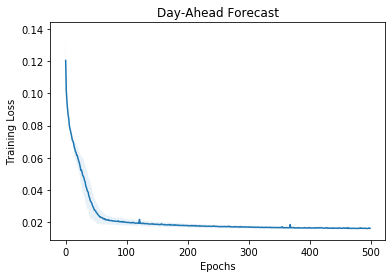

In [881]:
data = plot_train_loss(all_testing_loss, 'Day-Ahead Forecast')

In [873]:
model.eval()
y_test = []
y_preds = []
test_dataset = LondonEnergyDataset(test_df, transform=apply_transform)

testloader = DataLoader(test_dataset, batch_size=24,
                        shuffle=False)

for batch_idx, (features, labels) in enumerate(testloader):
    # Inference
    outputs = model(features)
    y_test.append(labels.numpy())
    y_preds.append(outputs.detach().numpy())
    
y_test = np.concatenate(y_test)
y_preds = np.concatenate(y_preds)

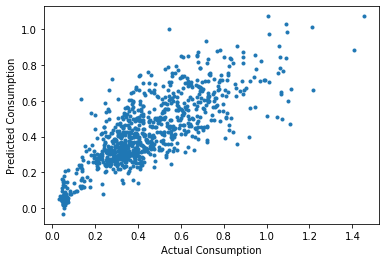

In [875]:
plt.figure()
plt.plot(y_test, y_preds,'.')
plt.xlabel('Actual Consumption')
plt.ylabel('Predicted Consumption')
plt.savefig('mlp_day_ahead_r2.png')

In [876]:
data_dict = {'testing_acc': all_testing_acc,
            'training_loss': all_epoch_loss,
            'testing_loss': all_testing_loss}
with open('mlp_day_ahead_all_houses.pkl', 'wb') as outfile:
    pickle.dump(data_dict, outfile, protocol=pickle.HIGHEST_PROTOCOL)

In [906]:
all_testing_acc[1][-1]

-0.7478405202512364